In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from ctapipe.io.lsteventsource import LSTEventSource
from ctapipe.io import EventSeeker

# Functions to compute pedestal, rms of capacitor and make plot

In [2]:
class DragonPedestal:
    n_pixels = 7
    roisize = 40
    size4drs = 4*1024
    high_gain = 0
    low_gain = 1

    def __init__(self):
        self.first_capacitor = np.zeros((2, 8))
        self.meanped = np.zeros((2, self.n_pixels, self.size4drs))
        self.numped = np.zeros((2, self.n_pixels, self.size4drs))
        self.rms = np.zeros((2, self.n_pixels, self.size4drs))

    def fill_pedestal_event(self, event, nr):
        first_cap = event.lst.tel[0].evt.first_capacitor_id[nr * 8:(nr + 1) * 8]
        
        self.first_capacitor[self.high_gain, 0] = first_cap[0]
        self.first_capacitor[self.high_gain, 1] = first_cap[0]
        self.first_capacitor[self.high_gain, 2] = first_cap[1]
        self.first_capacitor[self.high_gain, 3] = first_cap[1]
        self.first_capacitor[self.high_gain, 4] = first_cap[2]
        self.first_capacitor[self.high_gain, 5] = first_cap[2]
        self.first_capacitor[self.high_gain, 6] = first_cap[3]
        
        self.first_capacitor[self.low_gain, 0] = first_cap[4]
        self.first_capacitor[self.low_gain, 1] = first_cap[4]
        self.first_capacitor[self.low_gain, 2] = first_cap[5]
        self.first_capacitor[self.low_gain, 3] = first_cap[5]
        self.first_capacitor[self.low_gain, 4] = first_cap[6]
        self.first_capacitor[self.low_gain, 5] = first_cap[6]
        self.first_capacitor[self.low_gain, 6] = first_cap[7]
        
        waveform = event.r0.tel[0].waveform[:, nr * 7:(nr + 1) * 7, :]
        for i in range(0, 2):
            for j in range(0, self.n_pixels):
                fc = int(self.first_capacitor[i, j])
                for k in range(2, self.roisize-2):
                    posads = int((k+fc)%self.size4drs)
                    val = waveform[i, j, k]
                    self.meanped[i, j, posads] += val
                    self.numped[i, j, posads] += 1
                    self.rms[i, j, posads] += val**2

    def finalize_pedestal(self):
        try:
            self.meanped = self.meanped/self.numped
            self.rms = self.rms/self.numped
            self.rms = np.sqrt(self.rms - self.meanped**2)
        except Exception as err:
            print(err)

                
def get_rms_of_module(path_to_data, nr_module):
    reader = LSTEventSource(input_url=path_to_data)
    seeker = EventSeeker(reader)
    high_gain = 0
    low_gain = 1
    ped = DragonPedestal()
    for i in range(0, 5500):
        ev = seeker[i]
        ped.fill_pedestal_event(ev, nr_module)
    ped.finalize_pedestal()
    print("Module: {}".format(nr_module))
    for gain in [high_gain, low_gain]:
        for pix in range(0, 7):
            if gain == high_gain:
                print("High gain: pixel = {} mean RMS = {}".format(pix, np.mean(ped.rms[high_gain, pix, :])))
            if gain == low_gain:
                print("Low gain: pixel = {} mean RMS = {}".format(pix, np.mean(ped.rms[low_gain, pix, :])))
    return ped.rms

def plot_box(nr, rms_array):
    hg = 0 #high gain
    lg = 1 #low gain
    rms_hg = [rms_array[nr, hg, 0, :], rms_array[nr, hg, 1, :], rms_array[nr, hg, 2, :], rms_array[nr, hg, 3, :],
                rms_array[nr, hg, 4, :], rms_array[nr, hg, 5, :], rms_array[nr, hg, 6, :]]
    rms_lg = [rms_array[nr, 1, lg, :], rms_array[nr, lg, 1, :], rms_array[nr, lg, 2, :], rms_array[nr, lg, 3, :],
                   rms_array[nr, lg, 4, :], rms_array[nr, lg, 5, :], rms_array[nr, lg, 6, :]]

    fig, ax = plt.subplots(1, 2)
    bp = ax[0].boxplot(rms_hg, vert=0)
    ax[0].set_title("Module = {} high gain".format(nr))
    ax[0].set_xlabel("RMS")
    ax[0].set_xlim([0, 200]) # here you can change x axis range for high gain
    ax[0].set_yticklabels(['pixel 0', 'pixel 1', 'pixel 2', 'pixel 3', 'pixel 4', 'pixel 5', 'pixel 6'])

    bp = ax[1].boxplot(rms_lg, vert=0)
    ax[1].set_title("Module = {} low gain".format(nr))
    ax[1].set_xlabel("RMS")
    ax[1].set_xlim([0, 200]) # here you can change x axis range for low gain
    ax[1].set_yticklabels(['pixel 0', 'pixel 1', 'pixel 2', 'pixel 3', 'pixel 4', 'pixel 5', 'pixel 6'])
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# Read data 

In [5]:
path_to_data = os.path.join("/home", "pawel1", "Pulpit", "Astrophysics", "CTA", "dragon",
                            "data", "dane_lst", "20180629", "Date20180629.0001.fits.fz")
# you can also use this way: path_to_data = "/home/pawel1/Pulpit/Astrophysics/CTA/dragon/data/dane_lst/20180629/Date20180629.0001.fits.fz"

reader = LSTEventSource(input_url=path_to_data)
seeker = EventSeeker(reader)
ev = seeker[0]

num_modules = ev.lst.tel[0].svc.num_modules
number_of_first_module_to_study = 0
number_of_last_module_to_study = num_modules
NR = number_of_last_module_to_study - number_of_first_module_to_study # numbers of module 
rms_cap_array = np.zeros((NR, 2, 7, 4096))


for nr in range(number_of_first_module_to_study, number_of_last_module_to_study): # Here you can chose for which module you want compute RMS
    i = nr-number_of_first_module_to_study
    rms_cap_array[i, :, :, :] = get_rms_of_module(path_to_data, nr)

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/protozfits/__init__.py:56: UserWarning:         Multiple open zfits files at the same time are not supported.
        Reading from mutliple open tables at the same time will reset these
        tables continously and you will read always the same events.
        
  ''')


Module: 0
High gain: pixel = 0 mean RMS = 10.05843952661598
High gain: pixel = 1 mean RMS = 11.132068423618154
High gain: pixel = 2 mean RMS = 9.659957176275558
High gain: pixel = 3 mean RMS = 10.941880370997627
High gain: pixel = 4 mean RMS = 10.56028793406861
High gain: pixel = 5 mean RMS = 11.204435039280945
High gain: pixel = 6 mean RMS = 9.829434979433543
Low gain: pixel = 0 mean RMS = 5.220124303959741
Low gain: pixel = 1 mean RMS = 5.345546787885208
Low gain: pixel = 2 mean RMS = 4.754063394586467
Low gain: pixel = 3 mean RMS = 4.8826363723908175
Low gain: pixel = 4 mean RMS = 5.1464479879755896
Low gain: pixel = 5 mean RMS = 5.266651426290575
Low gain: pixel = 6 mean RMS = 4.944189401902631


Module: 1
High gain: pixel = 0 mean RMS = 8.749706140243728
High gain: pixel = 1 mean RMS = 9.178522170284502
High gain: pixel = 2 mean RMS = 8.90941983297322
High gain: pixel = 3 mean RMS = 9.629787415405634
High gain: pixel = 4 mean RMS = 8.872267736950562
High gain: pixel = 5 mean RMS = 9.419278201326701
High gain: pixel = 6 mean RMS = 8.88367018747493
Low gain: pixel = 0 mean RMS = 3.552791929166679
Low gain: pixel = 1 mean RMS = 3.841429973570161
Low gain: pixel = 2 mean RMS = 3.2556676025943667
Low gain: pixel = 3 mean RMS = 3.3903424718738933
Low gain: pixel = 4 mean RMS = 3.668362656144607
Low gain: pixel = 5 mean RMS = 3.728097242144573
Low gain: pixel = 6 mean RMS = 3.5731252153372504


Module: 2
High gain: pixel = 0 mean RMS = 8.145117712528362
High gain: pixel = 1 mean RMS = 8.896856518524352
High gain: pixel = 2 mean RMS = 8.575499480298667
High gain: pixel = 3 mean RMS = 9.365610336458136
High gain: pixel = 4 mean RMS = 8.484214384550558
High gain: pixel = 5 mean RMS = 9.510721482154628
High gain: pixel = 6 mean RMS = 8.608157412790034
Low gain: pixel = 0 mean RMS = 3.5187932815176115
Low gain: pixel = 1 mean RMS = 3.8743469030473214
Low gain: pixel = 2 mean RMS = 3.257280347032852
Low gain: pixel = 3 mean RMS = 3.4768242846566695
Low gain: pixel = 4 mean RMS = 3.5281588900418472
Low gain: pixel = 5 mean RMS = 3.861954700839004
Low gain: pixel = 6 mean RMS = 3.5113053499942977


Module: 3
High gain: pixel = 0 mean RMS = 9.457370547294566
High gain: pixel = 1 mean RMS = 10.782390280249361
High gain: pixel = 2 mean RMS = 9.622390905878046
High gain: pixel = 3 mean RMS = 11.02452600497548
High gain: pixel = 4 mean RMS = 10.237019699085446
High gain: pixel = 5 mean RMS = 10.890531685538086
High gain: pixel = 6 mean RMS = 9.713949923507553
Low gain: pixel = 0 mean RMS = 4.955777533693038
Low gain: pixel = 1 mean RMS = 5.378280015023943
Low gain: pixel = 2 mean RMS = 4.782477321707211
Low gain: pixel = 3 mean RMS = 5.27552997638049
Low gain: pixel = 4 mean RMS = 5.097541473082254
Low gain: pixel = 5 mean RMS = 5.3128050893257885
Low gain: pixel = 6 mean RMS = 4.56264828108273


Module: 4
High gain: pixel = 0 mean RMS = 9.256442779347992
High gain: pixel = 1 mean RMS = 10.184612132732244
High gain: pixel = 2 mean RMS = 10.424381733092613
High gain: pixel = 3 mean RMS = 11.314854851590047
High gain: pixel = 4 mean RMS = 10.424254976124748
High gain: pixel = 5 mean RMS = 11.120170205034956
High gain: pixel = 6 mean RMS = 9.72248404345611
Low gain: pixel = 0 mean RMS = 5.026343863997081
Low gain: pixel = 1 mean RMS = 5.284125861575285
Low gain: pixel = 2 mean RMS = 4.897241653433951
Low gain: pixel = 3 mean RMS = 4.9528079785254215
Low gain: pixel = 4 mean RMS = 4.9026238150418315
Low gain: pixel = 5 mean RMS = 5.1646764112407695
Low gain: pixel = 6 mean RMS = 4.795768565763675


Module: 5
High gain: pixel = 0 mean RMS = 8.522313465976033
High gain: pixel = 1 mean RMS = 8.850444023696731
High gain: pixel = 2 mean RMS = 9.029500237381367
High gain: pixel = 3 mean RMS = 8.950902302186133
High gain: pixel = 4 mean RMS = 8.733975231553664
High gain: pixel = 5 mean RMS = 9.157089162610228
High gain: pixel = 6 mean RMS = 8.754722139673941
Low gain: pixel = 0 mean RMS = 3.579626644772668
Low gain: pixel = 1 mean RMS = 3.6605707139281947
Low gain: pixel = 2 mean RMS = 3.3309882176177865
Low gain: pixel = 3 mean RMS = 3.3843448700298535
Low gain: pixel = 4 mean RMS = 3.4574913013012205
Low gain: pixel = 5 mean RMS = 3.5703976946071196
Low gain: pixel = 6 mean RMS = 3.5139250628442893


Module: 6
High gain: pixel = 0 mean RMS = 10.296896254399137
High gain: pixel = 1 mean RMS = 10.605451819469241
High gain: pixel = 2 mean RMS = 10.542707806198377
High gain: pixel = 3 mean RMS = 11.406881268463144
High gain: pixel = 4 mean RMS = 10.10631283468936
High gain: pixel = 5 mean RMS = 11.040516121330668
High gain: pixel = 6 mean RMS = 9.357141922492143
Low gain: pixel = 0 mean RMS = 5.25639182857657
Low gain: pixel = 1 mean RMS = 5.2416234921147575
Low gain: pixel = 2 mean RMS = 4.857312455556263
Low gain: pixel = 3 mean RMS = 4.899031665740416
Low gain: pixel = 4 mean RMS = 5.284597921910194
Low gain: pixel = 5 mean RMS = 5.212104281126404
Low gain: pixel = 6 mean RMS = 5.013639796388657


Module: 7
High gain: pixel = 0 mean RMS = 9.42227282320556
High gain: pixel = 1 mean RMS = 9.440825496807236
High gain: pixel = 2 mean RMS = 8.703906974649879
High gain: pixel = 3 mean RMS = 9.803582279575066
High gain: pixel = 4 mean RMS = 8.91025579602451
High gain: pixel = 5 mean RMS = 9.799681113339883
High gain: pixel = 6 mean RMS = 9.37949897130707
Low gain: pixel = 0 mean RMS = 3.6413703752845366
Low gain: pixel = 1 mean RMS = 3.930062241538106
Low gain: pixel = 2 mean RMS = 3.460307189198132
Low gain: pixel = 3 mean RMS = 3.667495724454233
Low gain: pixel = 4 mean RMS = 3.528108348498078
Low gain: pixel = 5 mean RMS = 3.85386579408373
Low gain: pixel = 6 mean RMS = 3.5702893951084818


Module: 8
High gain: pixel = 0 mean RMS = 10.306874287581913
High gain: pixel = 1 mean RMS = 10.920791689055978
High gain: pixel = 2 mean RMS = 9.650694153027938
High gain: pixel = 3 mean RMS = 10.952915764844441
High gain: pixel = 4 mean RMS = 9.798531014561558
High gain: pixel = 5 mean RMS = 10.42071691813716
High gain: pixel = 6 mean RMS = 10.096014453427658
Low gain: pixel = 0 mean RMS = 5.097091296011349
Low gain: pixel = 1 mean RMS = 5.226453622565496
Low gain: pixel = 2 mean RMS = 4.458443127606402
Low gain: pixel = 3 mean RMS = 4.562683314552471
Low gain: pixel = 4 mean RMS = 4.871727190296367
Low gain: pixel = 5 mean RMS = 5.028584874768072
Low gain: pixel = 6 mean RMS = 4.814887235842072


Module: 9
High gain: pixel = 0 mean RMS = 10.509309151745903
High gain: pixel = 1 mean RMS = 11.279571517745953
High gain: pixel = 2 mean RMS = 10.422597321712816
High gain: pixel = 3 mean RMS = 11.870824870392163
High gain: pixel = 4 mean RMS = 10.08379415866661
High gain: pixel = 5 mean RMS = 11.324063232034607
High gain: pixel = 6 mean RMS = 9.89812269463934
Low gain: pixel = 0 mean RMS = 5.385096330022758
Low gain: pixel = 1 mean RMS = 5.684919854442915
Low gain: pixel = 2 mean RMS = 5.232714998553192
Low gain: pixel = 3 mean RMS = 5.286335843902183
Low gain: pixel = 4 mean RMS = 5.573930514423772
Low gain: pixel = 5 mean RMS = 5.565012113003741
Low gain: pixel = 6 mean RMS = 5.619981546014434


Module: 10
High gain: pixel = 0 mean RMS = 8.221295822615767
High gain: pixel = 1 mean RMS = 8.307245946251
High gain: pixel = 2 mean RMS = 8.662664805506097
High gain: pixel = 3 mean RMS = 9.00610760588327
High gain: pixel = 4 mean RMS = 7.8168927134210024
High gain: pixel = 5 mean RMS = 8.500654789039963
High gain: pixel = 6 mean RMS = 7.935621876962551
Low gain: pixel = 0 mean RMS = 3.3178412588479294
Low gain: pixel = 1 mean RMS = 3.4570126807709203
Low gain: pixel = 2 mean RMS = 3.246641852718114
Low gain: pixel = 3 mean RMS = 3.341225751762204
Low gain: pixel = 4 mean RMS = 3.4691426860508443
Low gain: pixel = 5 mean RMS = 3.5983691392799013
Low gain: pixel = 6 mean RMS = 3.4939102353447424


Module: 11
High gain: pixel = 0 mean RMS = 8.638687057312012
High gain: pixel = 1 mean RMS = 9.085343904543926
High gain: pixel = 2 mean RMS = 8.607129868709649
High gain: pixel = 3 mean RMS = 9.683520597757528
High gain: pixel = 4 mean RMS = 9.193225342691
High gain: pixel = 5 mean RMS = 9.458950648624008
High gain: pixel = 6 mean RMS = 9.30969914996413
Low gain: pixel = 0 mean RMS = 3.9980659159866243
Low gain: pixel = 1 mean RMS = 3.9313466565585147
Low gain: pixel = 2 mean RMS = 3.4308564137244377
Low gain: pixel = 3 mean RMS = 3.7196244240286758
Low gain: pixel = 4 mean RMS = 3.7028581967505163
Low gain: pixel = 5 mean RMS = 3.8669135115358135
Low gain: pixel = 6 mean RMS = 3.6727309098855905


Module: 12
High gain: pixel = 0 mean RMS = 9.041194470401082
High gain: pixel = 1 mean RMS = 9.530529023222062
High gain: pixel = 2 mean RMS = 9.588726719429907
High gain: pixel = 3 mean RMS = 9.919794107516497
High gain: pixel = 4 mean RMS = 9.314720611853026
High gain: pixel = 5 mean RMS = 9.999936385849507
High gain: pixel = 6 mean RMS = 9.374989736743569
Low gain: pixel = 0 mean RMS = 3.7921568266119894
Low gain: pixel = 1 mean RMS = 3.8861130246274134
Low gain: pixel = 2 mean RMS = 3.562138305100272
Low gain: pixel = 3 mean RMS = 3.49825442445907
Low gain: pixel = 4 mean RMS = 3.7270502310364337
Low gain: pixel = 5 mean RMS = 3.75976217194352
Low gain: pixel = 6 mean RMS = 3.771979041745089


Module: 13
High gain: pixel = 0 mean RMS = 9.120187638538134
High gain: pixel = 1 mean RMS = 9.726366422613108
High gain: pixel = 2 mean RMS = 9.93978428834523
High gain: pixel = 3 mean RMS = 9.926333644500469
High gain: pixel = 4 mean RMS = 9.04813188926282
High gain: pixel = 5 mean RMS = 9.583299810573486
High gain: pixel = 6 mean RMS = 8.980434757172556
Low gain: pixel = 0 mean RMS = 3.7345463180791674
Low gain: pixel = 1 mean RMS = 3.846726632991536
Low gain: pixel = 2 mean RMS = 3.4466254405513226
Low gain: pixel = 3 mean RMS = 3.4683809051493975
Low gain: pixel = 4 mean RMS = 3.6164801608586696
Low gain: pixel = 5 mean RMS = 3.7845108516460275
Low gain: pixel = 6 mean RMS = 3.621447750340536


Module: 14
High gain: pixel = 0 mean RMS = 8.806660135043943
High gain: pixel = 1 mean RMS = 9.080140509873425
High gain: pixel = 2 mean RMS = 9.179904948395123
High gain: pixel = 3 mean RMS = 9.547936892042852
High gain: pixel = 4 mean RMS = 8.934395298128429
High gain: pixel = 5 mean RMS = 9.464825173859676
High gain: pixel = 6 mean RMS = 9.145882642677607
Low gain: pixel = 0 mean RMS = 3.73025229897781
Low gain: pixel = 1 mean RMS = 3.6440048298514798
Low gain: pixel = 2 mean RMS = 3.363871741195362
Low gain: pixel = 3 mean RMS = 3.2009069451326986
Low gain: pixel = 4 mean RMS = 3.628455575658613
Low gain: pixel = 5 mean RMS = 3.5157072030990033
Low gain: pixel = 6 mean RMS = 3.590759664003991


Module: 15
High gain: pixel = 0 mean RMS = 9.937341722085772
High gain: pixel = 1 mean RMS = 10.507761396654098
High gain: pixel = 2 mean RMS = 10.269334652867595
High gain: pixel = 3 mean RMS = 11.2297244731305
High gain: pixel = 4 mean RMS = 9.541647701929234
High gain: pixel = 5 mean RMS = 10.361371670758503
High gain: pixel = 6 mean RMS = 10.019564389840305
Low gain: pixel = 0 mean RMS = 5.004492607848352
Low gain: pixel = 1 mean RMS = 5.048850768875605
Low gain: pixel = 2 mean RMS = 4.96300007625767
Low gain: pixel = 3 mean RMS = 4.982070115549188
Low gain: pixel = 4 mean RMS = 4.881050192316655
Low gain: pixel = 5 mean RMS = 4.9048786326590115
Low gain: pixel = 6 mean RMS = 4.94184079394546


Module: 16
High gain: pixel = 0 mean RMS = 9.339780467461338
High gain: pixel = 1 mean RMS = 9.902932660402847
High gain: pixel = 2 mean RMS = 9.111934987111928
High gain: pixel = 3 mean RMS = 10.16186299324599
High gain: pixel = 4 mean RMS = 9.488769604016973
High gain: pixel = 5 mean RMS = 10.1105038914015
High gain: pixel = 6 mean RMS = 9.517829373821254
Low gain: pixel = 0 mean RMS = 3.7281195120785426
Low gain: pixel = 1 mean RMS = 3.8258028921030416
Low gain: pixel = 2 mean RMS = 3.5352503121267693
Low gain: pixel = 3 mean RMS = 3.48727979746959
Low gain: pixel = 4 mean RMS = 3.721951926176661
Low gain: pixel = 5 mean RMS = 3.6422108640369206
Low gain: pixel = 6 mean RMS = 3.799524712262029


Module: 17
High gain: pixel = 0 mean RMS = 8.706964604293976
High gain: pixel = 1 mean RMS = 8.978093405925694
High gain: pixel = 2 mean RMS = 8.832639474692929
High gain: pixel = 3 mean RMS = 8.987093115007582
High gain: pixel = 4 mean RMS = 8.413028365619493
High gain: pixel = 5 mean RMS = 9.152289080145753
High gain: pixel = 6 mean RMS = 8.735555889873133
Low gain: pixel = 0 mean RMS = 4.125505313275403
Low gain: pixel = 1 mean RMS = 4.103494944904543
Low gain: pixel = 2 mean RMS = 3.887681559344465
Low gain: pixel = 3 mean RMS = 3.81196843285642
Low gain: pixel = 4 mean RMS = 3.9146525316693754
Low gain: pixel = 5 mean RMS = 3.9599166589766623
Low gain: pixel = 6 mean RMS = 3.9722757590807087


Module: 18
High gain: pixel = 0 mean RMS = 9.325722851013255
High gain: pixel = 1 mean RMS = 9.514358917319498
High gain: pixel = 2 mean RMS = 9.119050696974565
High gain: pixel = 3 mean RMS = 9.454071861071856
High gain: pixel = 4 mean RMS = 8.918419495547456
High gain: pixel = 5 mean RMS = 9.178195692220097
High gain: pixel = 6 mean RMS = 8.662231480618118
Low gain: pixel = 0 mean RMS = 3.687953982610372
Low gain: pixel = 1 mean RMS = 3.6899130108970244
Low gain: pixel = 2 mean RMS = 3.378443296171942
Low gain: pixel = 3 mean RMS = 3.338058999505261
Low gain: pixel = 4 mean RMS = 3.6106031055881775
Low gain: pixel = 5 mean RMS = 3.644425432682022
Low gain: pixel = 6 mean RMS = 3.5635598027562683


Module: 19
High gain: pixel = 0 mean RMS = 8.650578026419327
High gain: pixel = 1 mean RMS = 9.182374444790032
High gain: pixel = 2 mean RMS = 8.683852530320678
High gain: pixel = 3 mean RMS = 9.393449042166218
High gain: pixel = 4 mean RMS = 8.878766512306441
High gain: pixel = 5 mean RMS = 9.587093637021251
High gain: pixel = 6 mean RMS = 8.839338749047121
Low gain: pixel = 0 mean RMS = 3.9983713877711455
Low gain: pixel = 1 mean RMS = 4.051147713627925
Low gain: pixel = 2 mean RMS = 3.653442105664414
Low gain: pixel = 3 mean RMS = 3.642492897577731
Low gain: pixel = 4 mean RMS = 3.8690885168165887
Low gain: pixel = 5 mean RMS = 3.9406323352480683
Low gain: pixel = 6 mean RMS = 3.8010111497001366


Module: 20
High gain: pixel = 0 mean RMS = 8.320159174816721
High gain: pixel = 1 mean RMS = 9.265386969108107
High gain: pixel = 2 mean RMS = 8.830502231482887
High gain: pixel = 3 mean RMS = 9.743228009462456
High gain: pixel = 4 mean RMS = 8.665054581250963
High gain: pixel = 5 mean RMS = 9.448497529795413
High gain: pixel = 6 mean RMS = 8.614548344892501
Low gain: pixel = 0 mean RMS = 3.679616774750971
Low gain: pixel = 1 mean RMS = 3.8048078001695664
Low gain: pixel = 2 mean RMS = 3.479500925040277
Low gain: pixel = 3 mean RMS = 3.4403652187320235
Low gain: pixel = 4 mean RMS = 3.6124205138612444
Low gain: pixel = 5 mean RMS = 3.6376609286251886
Low gain: pixel = 6 mean RMS = 3.518207240999578


Module: 21
High gain: pixel = 0 mean RMS = 9.173277277704901
High gain: pixel = 1 mean RMS = 9.435359380525767
High gain: pixel = 2 mean RMS = 8.874403395995294
High gain: pixel = 3 mean RMS = 10.092187295302157
High gain: pixel = 4 mean RMS = 9.213841844084602
High gain: pixel = 5 mean RMS = 9.67080233616991
High gain: pixel = 6 mean RMS = 8.65455705189514
Low gain: pixel = 0 mean RMS = 3.8354980590799426
Low gain: pixel = 1 mean RMS = 3.9774262535848286
Low gain: pixel = 2 mean RMS = 3.5041458211256336
Low gain: pixel = 3 mean RMS = 3.5793028518970003
Low gain: pixel = 4 mean RMS = 3.6339813088499415
Low gain: pixel = 5 mean RMS = 3.7967131140626122
Low gain: pixel = 6 mean RMS = 3.567670541571442


Module: 22
High gain: pixel = 0 mean RMS = 9.950105680432433
High gain: pixel = 1 mean RMS = 10.493275617008251
High gain: pixel = 2 mean RMS = 9.147840306714901
High gain: pixel = 3 mean RMS = 10.727298806703164
High gain: pixel = 4 mean RMS = 9.410289926463523
High gain: pixel = 5 mean RMS = 10.38468281949907
High gain: pixel = 6 mean RMS = 9.307394622822425
Low gain: pixel = 0 mean RMS = 4.314105206088874
Low gain: pixel = 1 mean RMS = 4.453243245802921
Low gain: pixel = 2 mean RMS = 3.9312940885524474
Low gain: pixel = 3 mean RMS = 3.9392294273497086
Low gain: pixel = 4 mean RMS = 4.146752104316264
Low gain: pixel = 5 mean RMS = 4.3418380973548
Low gain: pixel = 6 mean RMS = 4.230729750988862


Module: 23
High gain: pixel = 0 mean RMS = 8.11970381176075
High gain: pixel = 1 mean RMS = 8.744758042410181
High gain: pixel = 2 mean RMS = 9.01210365626643
High gain: pixel = 3 mean RMS = 9.426496224051911
High gain: pixel = 4 mean RMS = 8.676772812072924
High gain: pixel = 5 mean RMS = 9.132177299434593
High gain: pixel = 6 mean RMS = 8.561231643143758
Low gain: pixel = 0 mean RMS = 3.4496725304099733
Low gain: pixel = 1 mean RMS = 3.698244972487405
Low gain: pixel = 2 mean RMS = 3.2120479150876147
Low gain: pixel = 3 mean RMS = 3.370693072567721
Low gain: pixel = 4 mean RMS = 3.4334745466495766
Low gain: pixel = 5 mean RMS = 3.5905419530480787
Low gain: pixel = 6 mean RMS = 3.3372085976628143


Module: 24
High gain: pixel = 0 mean RMS = 9.127228431286035
High gain: pixel = 1 mean RMS = 9.6139362644533
High gain: pixel = 2 mean RMS = 9.23203124436326
High gain: pixel = 3 mean RMS = 9.956672648630114
High gain: pixel = 4 mean RMS = 9.186481776342623
High gain: pixel = 5 mean RMS = 9.980897048287254
High gain: pixel = 6 mean RMS = 9.187027460139596
Low gain: pixel = 0 mean RMS = 3.938480888530197
Low gain: pixel = 1 mean RMS = 4.0406997118553765
Low gain: pixel = 2 mean RMS = 3.5732457151143957
Low gain: pixel = 3 mean RMS = 3.6160528018245515
Low gain: pixel = 4 mean RMS = 3.788863257918721
Low gain: pixel = 5 mean RMS = 3.930995066798829
Low gain: pixel = 6 mean RMS = 3.6757921929395048


Module: 25
High gain: pixel = 0 mean RMS = 8.498976954815818
High gain: pixel = 1 mean RMS = 9.7907294651007
High gain: pixel = 2 mean RMS = 9.375973228415857
High gain: pixel = 3 mean RMS = 10.072130676114888
High gain: pixel = 4 mean RMS = 9.616230908363473
High gain: pixel = 5 mean RMS = 10.046414904239978
High gain: pixel = 6 mean RMS = 9.17009490661333
Low gain: pixel = 0 mean RMS = 3.7342180954487048
Low gain: pixel = 1 mean RMS = 3.7897532364575666
Low gain: pixel = 2 mean RMS = 3.450238792127951
Low gain: pixel = 3 mean RMS = 3.323762166868208
Low gain: pixel = 4 mean RMS = 3.5896531154126254
Low gain: pixel = 5 mean RMS = 3.7765249833263197
Low gain: pixel = 6 mean RMS = 3.6037331116511515


Module: 26
High gain: pixel = 0 mean RMS = 8.980636387187586
High gain: pixel = 1 mean RMS = 9.2570123943654
High gain: pixel = 2 mean RMS = 8.945117351467216
High gain: pixel = 3 mean RMS = 9.903475192325333
High gain: pixel = 4 mean RMS = 9.328629643776319
High gain: pixel = 5 mean RMS = 9.663231375489332
High gain: pixel = 6 mean RMS = 8.802394669694754
Low gain: pixel = 0 mean RMS = 3.361634978072435
Low gain: pixel = 1 mean RMS = 3.658048285290403
Low gain: pixel = 2 mean RMS = 3.4156752061192277
Low gain: pixel = 3 mean RMS = 3.6115329423336386
Low gain: pixel = 4 mean RMS = 3.5555603129475672
Low gain: pixel = 5 mean RMS = 3.666380330421732
Low gain: pixel = 6 mean RMS = 3.6973015727915097


Module: 27
High gain: pixel = 0 mean RMS = 9.506620877255882
High gain: pixel = 1 mean RMS = 9.95486930542091
High gain: pixel = 2 mean RMS = 9.978801017277842
High gain: pixel = 3 mean RMS = 10.28874156819904
High gain: pixel = 4 mean RMS = 8.898059996867879
High gain: pixel = 5 mean RMS = 10.115123097880133
High gain: pixel = 6 mean RMS = 9.82974772443282
Low gain: pixel = 0 mean RMS = 3.7816691656709644
Low gain: pixel = 1 mean RMS = 3.8185586867663597
Low gain: pixel = 2 mean RMS = 3.424351314944795
Low gain: pixel = 3 mean RMS = 3.4142375940845344
Low gain: pixel = 4 mean RMS = 3.688156136691251
Low gain: pixel = 5 mean RMS = 3.766434001589344
Low gain: pixel = 6 mean RMS = 3.5610784426503783


Module: 28
High gain: pixel = 0 mean RMS = 9.194825885202896
High gain: pixel = 1 mean RMS = 9.178892861620202
High gain: pixel = 2 mean RMS = 9.170008523254008
High gain: pixel = 3 mean RMS = 10.059275236805416
High gain: pixel = 4 mean RMS = 9.007305329267068
High gain: pixel = 5 mean RMS = 9.673171933979775
High gain: pixel = 6 mean RMS = 8.844321809755087
Low gain: pixel = 0 mean RMS = 3.6070156640615463
Low gain: pixel = 1 mean RMS = 3.8892507901262885
Low gain: pixel = 2 mean RMS = 3.519264935227919
Low gain: pixel = 3 mean RMS = 3.7106088394988537
Low gain: pixel = 4 mean RMS = 3.749693187952942
Low gain: pixel = 5 mean RMS = 3.908813709572457
Low gain: pixel = 6 mean RMS = 3.7615001280701037


Module: 29
High gain: pixel = 0 mean RMS = 8.949889637257769
High gain: pixel = 1 mean RMS = 9.172929448174333
High gain: pixel = 2 mean RMS = 9.370559328194425
High gain: pixel = 3 mean RMS = 9.866530029636388
High gain: pixel = 4 mean RMS = 8.302309955559167
High gain: pixel = 5 mean RMS = 9.042311204338656
High gain: pixel = 6 mean RMS = 8.415504028711052
Low gain: pixel = 0 mean RMS = 3.6976419260168605
Low gain: pixel = 1 mean RMS = 3.930967157413643
Low gain: pixel = 2 mean RMS = 3.4485925332781218
Low gain: pixel = 3 mean RMS = 3.6080242128906965
Low gain: pixel = 4 mean RMS = 3.4314545676550745
Low gain: pixel = 5 mean RMS = 3.658709664039642
Low gain: pixel = 6 mean RMS = 3.425583059386035


Module: 30
High gain: pixel = 0 mean RMS = 9.048719756481244
High gain: pixel = 1 mean RMS = 9.201548912981028
High gain: pixel = 2 mean RMS = 8.704295194271175
High gain: pixel = 3 mean RMS = 9.943071543659139
High gain: pixel = 4 mean RMS = 8.650645658282336
High gain: pixel = 5 mean RMS = 9.23379299051556
High gain: pixel = 6 mean RMS = 8.385001088489645
Low gain: pixel = 0 mean RMS = 3.5390990892005854
Low gain: pixel = 1 mean RMS = 3.888731092368954
Low gain: pixel = 2 mean RMS = 3.4441892022883778
Low gain: pixel = 3 mean RMS = 3.7462435620806156
Low gain: pixel = 4 mean RMS = 3.5710248783562877
Low gain: pixel = 5 mean RMS = 3.9068674295282033
Low gain: pixel = 6 mean RMS = 3.6416424570247097


Module: 31
High gain: pixel = 0 mean RMS = 9.17496227845018
High gain: pixel = 1 mean RMS = 9.177544890380648
High gain: pixel = 2 mean RMS = 8.664400503221426
High gain: pixel = 3 mean RMS = 9.357807578324804
High gain: pixel = 4 mean RMS = 9.275630576876864
High gain: pixel = 5 mean RMS = 9.514589323862475
High gain: pixel = 6 mean RMS = 8.965054358401348
Low gain: pixel = 0 mean RMS = 3.814181958131792
Low gain: pixel = 1 mean RMS = 3.735053446845855
Low gain: pixel = 2 mean RMS = 3.445998927018954
Low gain: pixel = 3 mean RMS = 3.3977668973380784
Low gain: pixel = 4 mean RMS = 3.6798495458924565
Low gain: pixel = 5 mean RMS = 3.661200664033183
Low gain: pixel = 6 mean RMS = 3.699217340031764


Module: 32
High gain: pixel = 0 mean RMS = 8.065287708996532
High gain: pixel = 1 mean RMS = 9.066119970640832
High gain: pixel = 2 mean RMS = 8.668416883245087
High gain: pixel = 3 mean RMS = 9.895648428962943
High gain: pixel = 4 mean RMS = 8.691234197039872
High gain: pixel = 5 mean RMS = 9.59803167611337
High gain: pixel = 6 mean RMS = 8.65180210035382
Low gain: pixel = 0 mean RMS = 3.4445822248672746
Low gain: pixel = 1 mean RMS = 3.7720850430038007
Low gain: pixel = 2 mean RMS = 3.314054507232251
Low gain: pixel = 3 mean RMS = 3.5520085518982834
Low gain: pixel = 4 mean RMS = 3.413669734895714
Low gain: pixel = 5 mean RMS = 3.6449283960751617
Low gain: pixel = 6 mean RMS = 3.54660238544564


Module: 33
High gain: pixel = 0 mean RMS = 8.795634122319179
High gain: pixel = 1 mean RMS = 9.608445427235116
High gain: pixel = 2 mean RMS = 9.521406856824395
High gain: pixel = 3 mean RMS = 9.73045891205252
High gain: pixel = 4 mean RMS = 9.3803511558929
High gain: pixel = 5 mean RMS = 9.762948366507867
High gain: pixel = 6 mean RMS = 8.929300619537255
Low gain: pixel = 0 mean RMS = 3.7243836152014405
Low gain: pixel = 1 mean RMS = 3.9599093448274463
Low gain: pixel = 2 mean RMS = 3.7410557432401843
Low gain: pixel = 3 mean RMS = 3.7996576612008313
Low gain: pixel = 4 mean RMS = 3.8235344214997915
Low gain: pixel = 5 mean RMS = 4.093022043626773
Low gain: pixel = 6 mean RMS = 3.7040334558491432


Module: 34
High gain: pixel = 0 mean RMS = 9.684171343354546
High gain: pixel = 1 mean RMS = 10.027993870098676
High gain: pixel = 2 mean RMS = 9.734481878724964
High gain: pixel = 3 mean RMS = 10.36828637389355
High gain: pixel = 4 mean RMS = 10.289749041041029
High gain: pixel = 5 mean RMS = 11.007889801421939
High gain: pixel = 6 mean RMS = 9.036770850421103
Low gain: pixel = 0 mean RMS = 3.7889300879337755
Low gain: pixel = 1 mean RMS = 3.9660576008361423
Low gain: pixel = 2 mean RMS = 3.524052250848311
Low gain: pixel = 3 mean RMS = 3.649259839022738
Low gain: pixel = 4 mean RMS = 3.5267935219553532
Low gain: pixel = 5 mean RMS = 3.7284475981276164
Low gain: pixel = 6 mean RMS = 3.6070161154648215


Module: 35
High gain: pixel = 0 mean RMS = 9.408335412023181
High gain: pixel = 1 mean RMS = 10.185034054900019
High gain: pixel = 2 mean RMS = 10.099021687036522
High gain: pixel = 3 mean RMS = 10.403561284278013
High gain: pixel = 4 mean RMS = 10.374198917447487
High gain: pixel = 5 mean RMS = 10.632255572921649
High gain: pixel = 6 mean RMS = 9.74456663065715
Low gain: pixel = 0 mean RMS = 3.706723527645318
Low gain: pixel = 1 mean RMS = 3.8638111021927695
Low gain: pixel = 2 mean RMS = 3.613671963412253
Low gain: pixel = 3 mean RMS = 3.524635083289193
Low gain: pixel = 4 mean RMS = 3.5977031372601367
Low gain: pixel = 5 mean RMS = 3.7621064081320097
Low gain: pixel = 6 mean RMS = 3.687500339393288


Module: 36
High gain: pixel = 0 mean RMS = 10.149332556574716
High gain: pixel = 1 mean RMS = 10.066924969377752
High gain: pixel = 2 mean RMS = 9.817141683367343
High gain: pixel = 3 mean RMS = 10.70570532967637
High gain: pixel = 4 mean RMS = 9.627358326755193
High gain: pixel = 5 mean RMS = 10.479424435248049
High gain: pixel = 6 mean RMS = 9.614345659650917
Low gain: pixel = 0 mean RMS = 3.8459757176891882
Low gain: pixel = 1 mean RMS = 3.9752608421566853
Low gain: pixel = 2 mean RMS = 3.6204184479216663
Low gain: pixel = 3 mean RMS = 3.6827738058516744
Low gain: pixel = 4 mean RMS = 3.680148867639369
Low gain: pixel = 5 mean RMS = 3.8494685159889355
Low gain: pixel = 6 mean RMS = 3.818831787612374


Module: 37
High gain: pixel = 0 mean RMS = 9.578808251944984
High gain: pixel = 1 mean RMS = 9.593775078059199
High gain: pixel = 2 mean RMS = 9.07679248131723
High gain: pixel = 3 mean RMS = 11.144678971174995
High gain: pixel = 4 mean RMS = 9.295597867116136
High gain: pixel = 5 mean RMS = 10.354578062354248
High gain: pixel = 6 mean RMS = 8.529259662215463
Low gain: pixel = 0 mean RMS = 3.5065230184029086
Low gain: pixel = 1 mean RMS = 3.9024076349488395
Low gain: pixel = 2 mean RMS = 3.3755940689868855
Low gain: pixel = 3 mean RMS = 3.7388156943312394
Low gain: pixel = 4 mean RMS = 3.5719219835209213
Low gain: pixel = 5 mean RMS = 3.9075710510693042
Low gain: pixel = 6 mean RMS = 3.579675672563778


Module: 38
High gain: pixel = 0 mean RMS = 8.9918310499108
High gain: pixel = 1 mean RMS = 9.955980605896126
High gain: pixel = 2 mean RMS = 9.479755439760956
High gain: pixel = 3 mean RMS = 10.305700641252665
High gain: pixel = 4 mean RMS = 9.34276943101394
High gain: pixel = 5 mean RMS = 10.239558836375636
High gain: pixel = 6 mean RMS = 9.368654134849365
Low gain: pixel = 0 mean RMS = 3.7617102626618837
Low gain: pixel = 1 mean RMS = 3.8326904165587083
Low gain: pixel = 2 mean RMS = 3.5136548401845804
Low gain: pixel = 3 mean RMS = 3.3673357560857227
Low gain: pixel = 4 mean RMS = 3.5840252461090074
Low gain: pixel = 5 mean RMS = 3.6554039571612673
Low gain: pixel = 6 mean RMS = 3.6785276655912202


Module: 39
High gain: pixel = 0 mean RMS = 9.491295935982663
High gain: pixel = 1 mean RMS = 10.294524265579803
High gain: pixel = 2 mean RMS = 9.260162433529008
High gain: pixel = 3 mean RMS = 9.969177894309896
High gain: pixel = 4 mean RMS = 9.649145078981764
High gain: pixel = 5 mean RMS = 10.29370251462327
High gain: pixel = 6 mean RMS = 8.946661604191744
Low gain: pixel = 0 mean RMS = 3.8717599820908988
Low gain: pixel = 1 mean RMS = 3.9548516145083226
Low gain: pixel = 2 mean RMS = 3.5748379794876533
Low gain: pixel = 3 mean RMS = 3.5699592521672283
Low gain: pixel = 4 mean RMS = 3.8592521697641504
Low gain: pixel = 5 mean RMS = 3.877078089397428
Low gain: pixel = 6 mean RMS = 3.8373572099934834


Module: 40
High gain: pixel = 0 mean RMS = 9.335754598628624
High gain: pixel = 1 mean RMS = 9.881055737965106
High gain: pixel = 2 mean RMS = 9.5952417583958
High gain: pixel = 3 mean RMS = 10.634360979188337
High gain: pixel = 4 mean RMS = 10.064179326291779
High gain: pixel = 5 mean RMS = 10.41591831620891
High gain: pixel = 6 mean RMS = 9.418492265872125
Low gain: pixel = 0 mean RMS = 3.924850890509414
Low gain: pixel = 1 mean RMS = 4.041456895329067
Low gain: pixel = 2 mean RMS = 3.6291920259958292
Low gain: pixel = 3 mean RMS = 3.690907679579232
Low gain: pixel = 4 mean RMS = 3.7601000693827213
Low gain: pixel = 5 mean RMS = 3.7917456916938193
Low gain: pixel = 6 mean RMS = 3.6954479719234996


Module: 41
High gain: pixel = 0 mean RMS = 10.314901172701202
High gain: pixel = 1 mean RMS = 10.280588628111282
High gain: pixel = 2 mean RMS = 9.24855341891758
High gain: pixel = 3 mean RMS = 10.51042913594147
High gain: pixel = 4 mean RMS = 8.849293933494444
High gain: pixel = 5 mean RMS = 9.96983786300761
High gain: pixel = 6 mean RMS = 9.556071107184701
Low gain: pixel = 0 mean RMS = 3.7701351284386995
Low gain: pixel = 1 mean RMS = 3.7206990610637307
Low gain: pixel = 2 mean RMS = 3.385371451302717
Low gain: pixel = 3 mean RMS = 3.541033560633544
Low gain: pixel = 4 mean RMS = 3.550345155640012
Low gain: pixel = 5 mean RMS = 3.6711008191644776
Low gain: pixel = 6 mean RMS = 3.660294376144355


Module: 42
High gain: pixel = 0 mean RMS = 9.210994126595518
High gain: pixel = 1 mean RMS = 9.815880840062539
High gain: pixel = 2 mean RMS = 9.71364584236005
High gain: pixel = 3 mean RMS = 10.177245682521136
High gain: pixel = 4 mean RMS = 8.953110638124674
High gain: pixel = 5 mean RMS = 9.823822901925354
High gain: pixel = 6 mean RMS = 8.678838048332983
Low gain: pixel = 0 mean RMS = 3.71274365995717
Low gain: pixel = 1 mean RMS = 4.001122687099555
Low gain: pixel = 2 mean RMS = 3.5349768823297065
Low gain: pixel = 3 mean RMS = 3.6648872564801813
Low gain: pixel = 4 mean RMS = 3.777115913707549
Low gain: pixel = 5 mean RMS = 3.8890914849444522
Low gain: pixel = 6 mean RMS = 3.5957249625271244


Module: 43
High gain: pixel = 0 mean RMS = 9.553391183143528
High gain: pixel = 1 mean RMS = 10.438916945283493
High gain: pixel = 2 mean RMS = 10.168864871937888
High gain: pixel = 3 mean RMS = 10.718243485745898
High gain: pixel = 4 mean RMS = 9.021882540820464
High gain: pixel = 5 mean RMS = 10.253094456422371
High gain: pixel = 6 mean RMS = 9.688060486902478
Low gain: pixel = 0 mean RMS = 5.067979208610585
Low gain: pixel = 1 mean RMS = 5.15550865223164
Low gain: pixel = 2 mean RMS = 4.52571604658749
Low gain: pixel = 3 mean RMS = 4.550678762773046
Low gain: pixel = 4 mean RMS = 4.735076693122636
Low gain: pixel = 5 mean RMS = 4.7897534840998315
Low gain: pixel = 6 mean RMS = 5.106157732808402


Module: 44
High gain: pixel = 0 mean RMS = 9.441035699154286
High gain: pixel = 1 mean RMS = 9.847974762061343
High gain: pixel = 2 mean RMS = 8.669678086909576
High gain: pixel = 3 mean RMS = 9.70203559964358
High gain: pixel = 4 mean RMS = 8.939115174467336
High gain: pixel = 5 mean RMS = 9.52201005938736
High gain: pixel = 6 mean RMS = 9.028615937754095
Low gain: pixel = 0 mean RMS = 3.6697715343407493
Low gain: pixel = 1 mean RMS = 3.9719193250190235
Low gain: pixel = 2 mean RMS = 3.4063529376521844
Low gain: pixel = 3 mean RMS = 3.369612432477287
Low gain: pixel = 4 mean RMS = 3.5511277238446546
Low gain: pixel = 5 mean RMS = 3.816572541969733
Low gain: pixel = 6 mean RMS = 3.6097816478276767


Module: 45
High gain: pixel = 0 mean RMS = 9.245341996292211
High gain: pixel = 1 mean RMS = 9.679575930062313
High gain: pixel = 2 mean RMS = 9.349682028727162
High gain: pixel = 3 mean RMS = 9.785198486786612
High gain: pixel = 4 mean RMS = 9.097586309001933
High gain: pixel = 5 mean RMS = 9.636665764087649
High gain: pixel = 6 mean RMS = 8.693878074576977
Low gain: pixel = 0 mean RMS = 4.009880363624331
Low gain: pixel = 1 mean RMS = 4.10879159575323
Low gain: pixel = 2 mean RMS = 3.559747682316118
Low gain: pixel = 3 mean RMS = 3.6016457889719438
Low gain: pixel = 4 mean RMS = 3.6732509575176238
Low gain: pixel = 5 mean RMS = 3.8519837377071564
Low gain: pixel = 6 mean RMS = 3.5865411740358275


Module: 46
High gain: pixel = 0 mean RMS = 9.10926308398731
High gain: pixel = 1 mean RMS = 9.76449437538701
High gain: pixel = 2 mean RMS = 9.298131992619231
High gain: pixel = 3 mean RMS = 9.990195142148583
High gain: pixel = 4 mean RMS = 9.265579820424165
High gain: pixel = 5 mean RMS = 9.794702641256922
High gain: pixel = 6 mean RMS = 9.237914070068907
Low gain: pixel = 0 mean RMS = 3.7683803115777614
Low gain: pixel = 1 mean RMS = 3.824886269131874
Low gain: pixel = 2 mean RMS = 3.4836183302318924
Low gain: pixel = 3 mean RMS = 3.4833694993981497
Low gain: pixel = 4 mean RMS = 3.651790688734917
Low gain: pixel = 5 mean RMS = 3.707561158544336
Low gain: pixel = 6 mean RMS = 3.677641757413063


Module: 47
High gain: pixel = 0 mean RMS = 9.502800455094523
High gain: pixel = 1 mean RMS = 9.528651646382581
High gain: pixel = 2 mean RMS = 8.998864440558405
High gain: pixel = 3 mean RMS = 9.626030701050288
High gain: pixel = 4 mean RMS = 9.320407322126943
High gain: pixel = 5 mean RMS = 9.875670082041996
High gain: pixel = 6 mean RMS = 9.534641076453417
Low gain: pixel = 0 mean RMS = 3.8495732632361133
Low gain: pixel = 1 mean RMS = 3.796399350649102
Low gain: pixel = 2 mean RMS = 3.6741842599984276
Low gain: pixel = 3 mean RMS = 3.629047074729835
Low gain: pixel = 4 mean RMS = 3.696709683940542
Low gain: pixel = 5 mean RMS = 3.72058778985003
Low gain: pixel = 6 mean RMS = 3.87697811877879


/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


Module: 48
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 49
High gain: pixel = 0 mean RMS = 12.831290860934335
High gain: pixel = 1 mean RMS = 13.740751738551248
High gain: pixel = 2 mean RMS = 11.865063489520693
High gain: pixel = 3 mean RMS = 12.624999951366037
High gain: pixel = 4 mean RMS = 13.060010562128502
High gain: pixel = 5 mean RMS = 13.979579573956554
High gain: pixel = 6 mean RMS = 13.22880818630221
Low gain: pixel = 0 mean RMS = 4.941668273805385
Low gain: pixel = 1 mean RMS = 5.173812133939439
Low gain: pixel = 2 mean RMS = 4.513124669708003
Low gain: pixel = 3 mean RMS = 4.63155640556338
Low gain: pixel = 4 mean RMS = 4.703835716840102
Low gain: pixel = 5 mean RMS = 4.8242832731893195
Low gain: pixel = 6 mean RMS = 4.649815557778943


Module: 50
High gain: pixel = 0 mean RMS = 11.400811229800444
High gain: pixel = 1 mean RMS = 11.650351284742463
High gain: pixel = 2 mean RMS = 12.91157637214215
High gain: pixel = 3 mean RMS = 11.863712753605814
High gain: pixel = 4 mean RMS = 11.761605796954184
High gain: pixel = 5 mean RMS = 13.739344571769665
High gain: pixel = 6 mean RMS = 12.759476623475283
Low gain: pixel = 0 mean RMS = 4.063595257981065
Low gain: pixel = 1 mean RMS = 4.137022257499083
Low gain: pixel = 2 mean RMS = 3.4957745097732076
Low gain: pixel = 3 mean RMS = 3.6226428483996016
Low gain: pixel = 4 mean RMS = 3.7034819786711886
Low gain: pixel = 5 mean RMS = 3.9823979844204236
Low gain: pixel = 6 mean RMS = 3.697922933789274


Module: 51
High gain: pixel = 0 mean RMS = 10.46830043721513
High gain: pixel = 1 mean RMS = 12.512829275135289
High gain: pixel = 2 mean RMS = 10.362903946381316
High gain: pixel = 3 mean RMS = 11.472542770004742
High gain: pixel = 4 mean RMS = 10.575485361653232
High gain: pixel = 5 mean RMS = 12.41849101403044
High gain: pixel = 6 mean RMS = 11.077296137431732
Low gain: pixel = 0 mean RMS = 3.7201451242276153
Low gain: pixel = 1 mean RMS = 3.880327958861514
Low gain: pixel = 2 mean RMS = 3.48011326426062
Low gain: pixel = 3 mean RMS = 3.4647183793377634
Low gain: pixel = 4 mean RMS = 3.7254964626083598
Low gain: pixel = 5 mean RMS = 3.8251288475772913
Low gain: pixel = 6 mean RMS = 3.81342990756756


Module: 52
High gain: pixel = 0 mean RMS = 11.194877285244987
High gain: pixel = 1 mean RMS = 11.35360017116547
High gain: pixel = 2 mean RMS = 11.100757799382453
High gain: pixel = 3 mean RMS = 10.780905153654532
High gain: pixel = 4 mean RMS = 11.610147374236309
High gain: pixel = 5 mean RMS = 12.32279255814786
High gain: pixel = 6 mean RMS = 10.32626926333136
Low gain: pixel = 0 mean RMS = 3.917299822474553
Low gain: pixel = 1 mean RMS = 4.08985122029817
Low gain: pixel = 2 mean RMS = 3.6111373044699366
Low gain: pixel = 3 mean RMS = 3.6836834997863366
Low gain: pixel = 4 mean RMS = 3.7180405085191675
Low gain: pixel = 5 mean RMS = 3.863663762621152
Low gain: pixel = 6 mean RMS = 3.7975556083699837


Module: 53
High gain: pixel = 0 mean RMS = 8.169986644918513
High gain: pixel = 1 mean RMS = 9.52199537184802
High gain: pixel = 2 mean RMS = 10.770666432113007
High gain: pixel = 3 mean RMS = 9.711227605705869
High gain: pixel = 4 mean RMS = 9.074588998992311
High gain: pixel = 5 mean RMS = 9.330963808904574
High gain: pixel = 6 mean RMS = 9.491566882732627
Low gain: pixel = 0 mean RMS = 3.3613563158374045
Low gain: pixel = 1 mean RMS = 3.4067790821371817
Low gain: pixel = 2 mean RMS = 3.2134344480287895
Low gain: pixel = 3 mean RMS = 3.2327440864108836
Low gain: pixel = 4 mean RMS = 3.306102316201419
Low gain: pixel = 5 mean RMS = 3.333776535928349
Low gain: pixel = 6 mean RMS = 3.3350552210140236


Module: 54
High gain: pixel = 0 mean RMS = 8.120856772597719
High gain: pixel = 1 mean RMS = 8.435429282528968
High gain: pixel = 2 mean RMS = 8.911943374161073
High gain: pixel = 3 mean RMS = 8.878029425045934
High gain: pixel = 4 mean RMS = 8.39510230036331
High gain: pixel = 5 mean RMS = 8.845007450177977
High gain: pixel = 6 mean RMS = 8.226324171143403
Low gain: pixel = 0 mean RMS = 3.6068270828056455
Low gain: pixel = 1 mean RMS = 3.5205577154874828
Low gain: pixel = 2 mean RMS = 3.5705759501743066
Low gain: pixel = 3 mean RMS = 3.486436942801423
Low gain: pixel = 4 mean RMS = 3.7023128898223505
Low gain: pixel = 5 mean RMS = 3.594470552641945
Low gain: pixel = 6 mean RMS = 3.617712324618568


Module: 55
High gain: pixel = 0 mean RMS = 9.16688400441632
High gain: pixel = 1 mean RMS = 9.705353512907585
High gain: pixel = 2 mean RMS = 9.268120658422074
High gain: pixel = 3 mean RMS = 9.734915278061212
High gain: pixel = 4 mean RMS = 9.383626517317483
High gain: pixel = 5 mean RMS = 9.647301820785135
High gain: pixel = 6 mean RMS = 9.23902917985129
Low gain: pixel = 0 mean RMS = 3.8412900623572894
Low gain: pixel = 1 mean RMS = 4.015532928514759
Low gain: pixel = 2 mean RMS = 3.5676841596445263
Low gain: pixel = 3 mean RMS = 3.4438394736505575
Low gain: pixel = 4 mean RMS = 3.715178741152198
Low gain: pixel = 5 mean RMS = 3.9742119850314612
Low gain: pixel = 6 mean RMS = 3.6420290588384923


Module: 56
High gain: pixel = 0 mean RMS = 10.775164432428419
High gain: pixel = 1 mean RMS = 11.40597139868072
High gain: pixel = 2 mean RMS = 10.254238768155037
High gain: pixel = 3 mean RMS = 11.198940605614876
High gain: pixel = 4 mean RMS = 11.048209891970519
High gain: pixel = 5 mean RMS = 11.33965929864402
High gain: pixel = 6 mean RMS = 11.108194680055604
Low gain: pixel = 0 mean RMS = 5.470342775312219
Low gain: pixel = 1 mean RMS = 5.623739312946671
Low gain: pixel = 2 mean RMS = 5.081920556470776
Low gain: pixel = 3 mean RMS = 5.090080818667101
Low gain: pixel = 4 mean RMS = 5.270070161401964
Low gain: pixel = 5 mean RMS = 5.291302735514878
Low gain: pixel = 6 mean RMS = 5.264112096712914


Module: 57
High gain: pixel = 0 mean RMS = 11.138314255347908
High gain: pixel = 1 mean RMS = 11.147391577599832
High gain: pixel = 2 mean RMS = 11.37189850320156
High gain: pixel = 3 mean RMS = 11.41762837664847
High gain: pixel = 4 mean RMS = 10.913340300358811
High gain: pixel = 5 mean RMS = 11.281096195857554
High gain: pixel = 6 mean RMS = 9.771639467223373
Low gain: pixel = 0 mean RMS = 5.684023625023357
Low gain: pixel = 1 mean RMS = 5.7160961809283055
Low gain: pixel = 2 mean RMS = 5.0830135405088335
Low gain: pixel = 3 mean RMS = 5.06397609802474
Low gain: pixel = 4 mean RMS = 5.465360840648423
Low gain: pixel = 5 mean RMS = 5.433852435436241
Low gain: pixel = 6 mean RMS = 5.384354782800964


Module: 58
High gain: pixel = 0 mean RMS = 9.486176178332055
High gain: pixel = 1 mean RMS = 9.977831246336558
High gain: pixel = 2 mean RMS = 8.554029924425667
High gain: pixel = 3 mean RMS = 10.137819578555844
High gain: pixel = 4 mean RMS = 8.824466023602373
High gain: pixel = 5 mean RMS = 9.761619445401987
High gain: pixel = 6 mean RMS = 8.395192078022841
Low gain: pixel = 0 mean RMS = 3.47388974440347
Low gain: pixel = 1 mean RMS = 3.7960452266029567
Low gain: pixel = 2 mean RMS = 3.380997596628492
Low gain: pixel = 3 mean RMS = 3.583574195168776
Low gain: pixel = 4 mean RMS = 3.4882814557705237
Low gain: pixel = 5 mean RMS = 3.6871017462023996
Low gain: pixel = 6 mean RMS = 3.556350712533992


Module: 59
High gain: pixel = 0 mean RMS = 9.166527334723302
High gain: pixel = 1 mean RMS = 9.519409667139863
High gain: pixel = 2 mean RMS = 9.152216219153544
High gain: pixel = 3 mean RMS = 9.940295154420824
High gain: pixel = 4 mean RMS = 9.174590757360107
High gain: pixel = 5 mean RMS = 9.82076826393174
High gain: pixel = 6 mean RMS = 9.291595241309492
Low gain: pixel = 0 mean RMS = 3.872516431021527
Low gain: pixel = 1 mean RMS = 4.134643906914167
Low gain: pixel = 2 mean RMS = 3.724446060635993
Low gain: pixel = 3 mean RMS = 3.7479254789427427
Low gain: pixel = 4 mean RMS = 3.686014725308161
Low gain: pixel = 5 mean RMS = 4.053003559260816
Low gain: pixel = 6 mean RMS = 3.758558797988622


Module: 60
High gain: pixel = 0 mean RMS = 9.621425355298022
High gain: pixel = 1 mean RMS = 10.400597410546222
High gain: pixel = 2 mean RMS = 9.89389537113647
High gain: pixel = 3 mean RMS = 10.185735430620241
High gain: pixel = 4 mean RMS = 9.094875813194555
High gain: pixel = 5 mean RMS = 10.168102096937277
High gain: pixel = 6 mean RMS = 8.804873579425914
Low gain: pixel = 0 mean RMS = 3.9339671408082397
Low gain: pixel = 1 mean RMS = 4.075835076462903
Low gain: pixel = 2 mean RMS = 3.602797373906814
Low gain: pixel = 3 mean RMS = 3.5848433525093304
Low gain: pixel = 4 mean RMS = 3.7026748700318444
Low gain: pixel = 5 mean RMS = 3.935604043351799
Low gain: pixel = 6 mean RMS = 3.797663417561557


Module: 61
High gain: pixel = 0 mean RMS = 8.717688107546333
High gain: pixel = 1 mean RMS = 9.047899338843266
High gain: pixel = 2 mean RMS = 9.256467231067944
High gain: pixel = 3 mean RMS = 9.536289262633584
High gain: pixel = 4 mean RMS = 9.106920856855858
High gain: pixel = 5 mean RMS = 9.732211063397497
High gain: pixel = 6 mean RMS = 8.642115121393449
Low gain: pixel = 0 mean RMS = 3.634574892329504
Low gain: pixel = 1 mean RMS = 3.828015464552945
Low gain: pixel = 2 mean RMS = 3.418564827569079
Low gain: pixel = 3 mean RMS = 3.552903207875339
Low gain: pixel = 4 mean RMS = 3.5148549026814657
Low gain: pixel = 5 mean RMS = 3.7006127843993335
Low gain: pixel = 6 mean RMS = 3.4959020651806054


Module: 62
High gain: pixel = 0 mean RMS = 12.045344318654557
High gain: pixel = 1 mean RMS = 13.573634855941028
High gain: pixel = 2 mean RMS = 12.944647361423286
High gain: pixel = 3 mean RMS = 12.747785423421355
High gain: pixel = 4 mean RMS = 11.321932735336329
High gain: pixel = 5 mean RMS = 12.206779105394746
High gain: pixel = 6 mean RMS = 14.376093044185723
Low gain: pixel = 0 mean RMS = 3.9467608196735373
Low gain: pixel = 1 mean RMS = 3.9928350848629326
Low gain: pixel = 2 mean RMS = 3.6568987665018806
Low gain: pixel = 3 mean RMS = 3.5869351363271664
Low gain: pixel = 4 mean RMS = 3.8206566037595904
Low gain: pixel = 5 mean RMS = 3.927317357929025
Low gain: pixel = 6 mean RMS = 4.274308717989735


Module: 63
High gain: pixel = 0 mean RMS = 21.212700475129743
High gain: pixel = 1 mean RMS = 19.447508313084946
High gain: pixel = 2 mean RMS = 20.792475329964343
High gain: pixel = 3 mean RMS = 21.89174443680776
High gain: pixel = 4 mean RMS = 19.71573804080679
High gain: pixel = 5 mean RMS = 22.137463812084007
High gain: pixel = 6 mean RMS = 20.31611487082867
Low gain: pixel = 0 mean RMS = 4.362289259954036
Low gain: pixel = 1 mean RMS = 4.397756323388005
Low gain: pixel = 2 mean RMS = 3.8368037532398356
Low gain: pixel = 3 mean RMS = 3.907530617290676
Low gain: pixel = 4 mean RMS = 3.954723285316992
Low gain: pixel = 5 mean RMS = 4.167941566529217
Low gain: pixel = 6 mean RMS = 4.079833719843016


Module: 64
High gain: pixel = 0 mean RMS = 19.46755965817446
High gain: pixel = 1 mean RMS = 23.709844842031252
High gain: pixel = 2 mean RMS = 21.202774183886767
High gain: pixel = 3 mean RMS = 24.50071355231017
High gain: pixel = 4 mean RMS = 19.726629670577026
High gain: pixel = 5 mean RMS = 25.774009127024478
High gain: pixel = 6 mean RMS = 22.63179021560326
Low gain: pixel = 0 mean RMS = 3.8994576297845853
Low gain: pixel = 1 mean RMS = 4.27870965129805
Low gain: pixel = 2 mean RMS = 3.823047856146409
Low gain: pixel = 3 mean RMS = 4.1992234961492185
Low gain: pixel = 4 mean RMS = 3.897877070313384
Low gain: pixel = 5 mean RMS = 4.215097275827453
Low gain: pixel = 6 mean RMS = 3.8630119654792843


Module: 65
High gain: pixel = 0 mean RMS = 16.419966155152636
High gain: pixel = 1 mean RMS = 19.80656125708159
High gain: pixel = 2 mean RMS = 15.99448409901585
High gain: pixel = 3 mean RMS = 23.027279790687608
High gain: pixel = 4 mean RMS = 19.5453044999243
High gain: pixel = 5 mean RMS = 20.300519090211758
High gain: pixel = 6 mean RMS = 21.589487252947833
Low gain: pixel = 0 mean RMS = 5.363807164467198
Low gain: pixel = 1 mean RMS = 5.504096611586564
Low gain: pixel = 2 mean RMS = 5.584602757237093
Low gain: pixel = 3 mean RMS = 5.716285133752169
Low gain: pixel = 4 mean RMS = 5.693675215771284
Low gain: pixel = 5 mean RMS = 5.731242066426316
Low gain: pixel = 6 mean RMS = 5.662729253910811


Module: 66
High gain: pixel = 0 mean RMS = 16.5381309320207
High gain: pixel = 1 mean RMS = 15.269305226611584
High gain: pixel = 2 mean RMS = 18.97142009122674
High gain: pixel = 3 mean RMS = 22.427908152000594
High gain: pixel = 4 mean RMS = 20.01436037232127
High gain: pixel = 5 mean RMS = 20.89463996522656
High gain: pixel = 6 mean RMS = 21.75566004693915
Low gain: pixel = 0 mean RMS = 3.9507929289086534
Low gain: pixel = 1 mean RMS = 3.920676460499894
Low gain: pixel = 2 mean RMS = 3.737846002738822
Low gain: pixel = 3 mean RMS = 3.634753333687388
Low gain: pixel = 4 mean RMS = 3.926115706528467
Low gain: pixel = 5 mean RMS = 3.9097865106435012
Low gain: pixel = 6 mean RMS = 4.075334850020934


Module: 67
High gain: pixel = 0 mean RMS = 13.304269809092933
High gain: pixel = 1 mean RMS = 18.113548650583258
High gain: pixel = 2 mean RMS = 17.68375681501273
High gain: pixel = 3 mean RMS = 14.122594580040289
High gain: pixel = 4 mean RMS = 16.281718223789895
High gain: pixel = 5 mean RMS = 17.74041602682417
High gain: pixel = 6 mean RMS = 17.05670076842693
Low gain: pixel = 0 mean RMS = 3.8890554505483363
Low gain: pixel = 1 mean RMS = 4.229016134887181
Low gain: pixel = 2 mean RMS = 3.774090136593974
Low gain: pixel = 3 mean RMS = 3.852677158207566
Low gain: pixel = 4 mean RMS = 3.7994333919284387
Low gain: pixel = 5 mean RMS = 4.071199395442511
Low gain: pixel = 6 mean RMS = 3.9065620666560523


Module: 68
High gain: pixel = 0 mean RMS = 11.038262009693153
High gain: pixel = 1 mean RMS = 11.888434363685107
High gain: pixel = 2 mean RMS = 11.504064375752465
High gain: pixel = 3 mean RMS = 10.877084709766086
High gain: pixel = 4 mean RMS = 9.854795061485849
High gain: pixel = 5 mean RMS = 11.939355958685333
High gain: pixel = 6 mean RMS = 10.474370617334007
Low gain: pixel = 0 mean RMS = 3.6842485092936332
Low gain: pixel = 1 mean RMS = 4.025955047073813
Low gain: pixel = 2 mean RMS = 3.5273680031924384
Low gain: pixel = 3 mean RMS = 3.7417195498174145
Low gain: pixel = 4 mean RMS = 3.7194602584833225
Low gain: pixel = 5 mean RMS = 4.114064323244381
Low gain: pixel = 6 mean RMS = 3.7989166698440515


Module: 69
High gain: pixel = 0 mean RMS = 9.341238155905613
High gain: pixel = 1 mean RMS = 10.100263610349996
High gain: pixel = 2 mean RMS = 9.674197423445948
High gain: pixel = 3 mean RMS = 10.308404418130412
High gain: pixel = 4 mean RMS = 10.097631638516994
High gain: pixel = 5 mean RMS = 10.2836322660458
High gain: pixel = 6 mean RMS = 10.281775555825616
Low gain: pixel = 0 mean RMS = 3.7373451727704516
Low gain: pixel = 1 mean RMS = 3.8010052299094896
Low gain: pixel = 2 mean RMS = 3.504222043582781
Low gain: pixel = 3 mean RMS = 3.5265954799245627
Low gain: pixel = 4 mean RMS = 3.6382389158768573
Low gain: pixel = 5 mean RMS = 3.7249077761498404
Low gain: pixel = 6 mean RMS = 3.6881879201818375


Module: 70
High gain: pixel = 0 mean RMS = 8.736101798396412
High gain: pixel = 1 mean RMS = 9.448915885013172
High gain: pixel = 2 mean RMS = 8.969941450587264
High gain: pixel = 3 mean RMS = 9.682501059019634
High gain: pixel = 4 mean RMS = 8.631706625104314
High gain: pixel = 5 mean RMS = 9.090515830908682
High gain: pixel = 6 mean RMS = 9.229864853452156
Low gain: pixel = 0 mean RMS = 3.6019048594338643
Low gain: pixel = 1 mean RMS = 3.8143977707214463
Low gain: pixel = 2 mean RMS = 3.431772742572156
Low gain: pixel = 3 mean RMS = 3.542941007461787
Low gain: pixel = 4 mean RMS = 3.5259102847870434
Low gain: pixel = 5 mean RMS = 3.6006170601519694
Low gain: pixel = 6 mean RMS = 3.6447863831540674


Module: 71
High gain: pixel = 0 mean RMS = 8.936141821837598
High gain: pixel = 1 mean RMS = 9.51808000127177
High gain: pixel = 2 mean RMS = 8.956115361254337
High gain: pixel = 3 mean RMS = 9.666584663565713
High gain: pixel = 4 mean RMS = 8.780407729439165
High gain: pixel = 5 mean RMS = 9.450019180570964
High gain: pixel = 6 mean RMS = 8.685636524162925
Low gain: pixel = 0 mean RMS = 3.80979554412506
Low gain: pixel = 1 mean RMS = 3.9694078765464207
Low gain: pixel = 2 mean RMS = 3.456434976614633
Low gain: pixel = 3 mean RMS = 3.5554658352551414
Low gain: pixel = 4 mean RMS = 3.5559694202653507
Low gain: pixel = 5 mean RMS = 3.782137411696252
Low gain: pixel = 6 mean RMS = 3.6252030075872046


Module: 72
High gain: pixel = 0 mean RMS = 8.958462472008733
High gain: pixel = 1 mean RMS = 9.142534157852024
High gain: pixel = 2 mean RMS = 8.725849046709403
High gain: pixel = 3 mean RMS = 9.511248293447634
High gain: pixel = 4 mean RMS = 8.407749881765877
High gain: pixel = 5 mean RMS = 9.07316343189607
High gain: pixel = 6 mean RMS = 8.697299301065897
Low gain: pixel = 0 mean RMS = 3.7412510728560164
Low gain: pixel = 1 mean RMS = 3.8553341870396607
Low gain: pixel = 2 mean RMS = 3.4353240089910013
Low gain: pixel = 3 mean RMS = 3.534556390893907
Low gain: pixel = 4 mean RMS = 3.5855388335501956
Low gain: pixel = 5 mean RMS = 3.692246978140971
Low gain: pixel = 6 mean RMS = 3.5966509074839372


Module: 73
High gain: pixel = 0 mean RMS = 8.803533448378914
High gain: pixel = 1 mean RMS = 9.463511955036747
High gain: pixel = 2 mean RMS = 8.828453031286568
High gain: pixel = 3 mean RMS = 9.581091378839572
High gain: pixel = 4 mean RMS = 9.12579546855503
High gain: pixel = 5 mean RMS = 9.773340851440828
High gain: pixel = 6 mean RMS = 8.95479441945113
Low gain: pixel = 0 mean RMS = 3.7204454132705527
Low gain: pixel = 1 mean RMS = 3.8013382821006436
Low gain: pixel = 2 mean RMS = 3.514174693457992
Low gain: pixel = 3 mean RMS = 3.469771397204333
Low gain: pixel = 4 mean RMS = 3.7035233587990017
Low gain: pixel = 5 mean RMS = 3.6307951412313733
Low gain: pixel = 6 mean RMS = 3.5907429496342687


Module: 74
High gain: pixel = 0 mean RMS = 8.787547751072571
High gain: pixel = 1 mean RMS = 9.649573395331497
High gain: pixel = 2 mean RMS = 8.860315248009172
High gain: pixel = 3 mean RMS = 10.240029281801103
High gain: pixel = 4 mean RMS = 9.344205601001757
High gain: pixel = 5 mean RMS = 10.088361659442036
High gain: pixel = 6 mean RMS = 9.055323511697601
Low gain: pixel = 0 mean RMS = 3.5877872816921217
Low gain: pixel = 1 mean RMS = 3.5862790762308023
Low gain: pixel = 2 mean RMS = 3.4295777682135604
Low gain: pixel = 3 mean RMS = 3.316195398143428
Low gain: pixel = 4 mean RMS = 3.6496658582734587
Low gain: pixel = 5 mean RMS = 3.5272932651564988
Low gain: pixel = 6 mean RMS = 3.6810340898757454


Module: 75
High gain: pixel = 0 mean RMS = 8.803516468339394
High gain: pixel = 1 mean RMS = 9.184267820445656
High gain: pixel = 2 mean RMS = 8.985038394123954
High gain: pixel = 3 mean RMS = 9.146541960540215
High gain: pixel = 4 mean RMS = 9.128249282585115
High gain: pixel = 5 mean RMS = 9.532203812619276
High gain: pixel = 6 mean RMS = 8.76914909479958
Low gain: pixel = 0 mean RMS = 3.676958515331359
Low gain: pixel = 1 mean RMS = 3.7783797071943277
Low gain: pixel = 2 mean RMS = 3.5653156998416557
Low gain: pixel = 3 mean RMS = 3.572938775133338
Low gain: pixel = 4 mean RMS = 3.747011206524318
Low gain: pixel = 5 mean RMS = 3.804733797674425
Low gain: pixel = 6 mean RMS = 3.6303777506351604


Module: 76
High gain: pixel = 0 mean RMS = 9.015217550924124
High gain: pixel = 1 mean RMS = 10.477948252832313
High gain: pixel = 2 mean RMS = 9.445066140122496
High gain: pixel = 3 mean RMS = 9.659330324248794
High gain: pixel = 4 mean RMS = 8.815044643893199
High gain: pixel = 5 mean RMS = 10.062818986978261
High gain: pixel = 6 mean RMS = 9.438506156310744
Low gain: pixel = 0 mean RMS = 3.633958674436189
Low gain: pixel = 1 mean RMS = 3.8824453168032225
Low gain: pixel = 2 mean RMS = 3.3153349611162213
Low gain: pixel = 3 mean RMS = 3.4259229427622473
Low gain: pixel = 4 mean RMS = 3.4306527595480967
Low gain: pixel = 5 mean RMS = 3.581833948672731
Low gain: pixel = 6 mean RMS = 3.4493410089117367


Module: 77
High gain: pixel = 0 mean RMS = 11.983436589173426
High gain: pixel = 1 mean RMS = 12.211863621152869
High gain: pixel = 2 mean RMS = 11.623336977769638
High gain: pixel = 3 mean RMS = 12.318936367905284
High gain: pixel = 4 mean RMS = 10.61461278127052
High gain: pixel = 5 mean RMS = 11.642088691644137
High gain: pixel = 6 mean RMS = 11.13077557396064
Low gain: pixel = 0 mean RMS = 3.8168119614587
Low gain: pixel = 1 mean RMS = 3.8053569498970177
Low gain: pixel = 2 mean RMS = 3.545850920070272
Low gain: pixel = 3 mean RMS = 3.497333324966086
Low gain: pixel = 4 mean RMS = 3.5683777352546002
Low gain: pixel = 5 mean RMS = 3.618187464131743
Low gain: pixel = 6 mean RMS = 3.6651464261931803


Module: 78
High gain: pixel = 0 mean RMS = 25.8980152049056
High gain: pixel = 1 mean RMS = 27.359500467439503
High gain: pixel = 2 mean RMS = 27.067363931017205
High gain: pixel = 3 mean RMS = 21.912944520866965
High gain: pixel = 4 mean RMS = 21.44871365237658
High gain: pixel = 5 mean RMS = 21.834260254987672
High gain: pixel = 6 mean RMS = 22.159829779462264
Low gain: pixel = 0 mean RMS = 4.367430322346536
Low gain: pixel = 1 mean RMS = 4.380975041632963
Low gain: pixel = 2 mean RMS = 4.044913850011788
Low gain: pixel = 3 mean RMS = 3.8307929327230896
Low gain: pixel = 4 mean RMS = 4.0973330100080565
Low gain: pixel = 5 mean RMS = 4.018886090693181
Low gain: pixel = 6 mean RMS = 3.9174629226029394


Module: 79
High gain: pixel = 0 mean RMS = 49.21487003129117
High gain: pixel = 1 mean RMS = 47.344604479647515
High gain: pixel = 2 mean RMS = 52.43916960643692
High gain: pixel = 3 mean RMS = 52.82929301827127
High gain: pixel = 4 mean RMS = 63.40818444803794
High gain: pixel = 5 mean RMS = 44.184065549129656
High gain: pixel = 6 mean RMS = 76.80048233347893
Low gain: pixel = 0 mean RMS = 4.352355544510617
Low gain: pixel = 1 mean RMS = 4.411328060358438
Low gain: pixel = 2 mean RMS = 4.402807037218851
Low gain: pixel = 3 mean RMS = 4.388771575105469
Low gain: pixel = 4 mean RMS = 4.688195928609826
Low gain: pixel = 5 mean RMS = 4.336048574007352
Low gain: pixel = 6 mean RMS = 5.069140927386728


Module: 80
High gain: pixel = 0 mean RMS = 56.34993468805671
High gain: pixel = 1 mean RMS = 33.473840642161925
High gain: pixel = 2 mean RMS = 36.04855892292187
High gain: pixel = 3 mean RMS = 42.49533981209028
High gain: pixel = 4 mean RMS = 32.620836065776885
High gain: pixel = 5 mean RMS = 61.04659741987099
High gain: pixel = 6 mean RMS = 39.56023189295544
Low gain: pixel = 0 mean RMS = 4.120706359382409
Low gain: pixel = 1 mean RMS = 3.7501482431638142
Low gain: pixel = 2 mean RMS = 3.758347558869923
Low gain: pixel = 3 mean RMS = 3.9537029127759733
Low gain: pixel = 4 mean RMS = 3.435050711107769
Low gain: pixel = 5 mean RMS = 4.528181496133515
Low gain: pixel = 6 mean RMS = 3.7019040226884545


Module: 81
High gain: pixel = 0 mean RMS = 38.63454072920995
High gain: pixel = 1 mean RMS = 38.95826891011391
High gain: pixel = 2 mean RMS = 31.117198049105134
High gain: pixel = 3 mean RMS = 33.26174614683502
High gain: pixel = 4 mean RMS = 64.01186869362257
High gain: pixel = 5 mean RMS = 71.00653358606058
High gain: pixel = 6 mean RMS = 61.94017030686429
Low gain: pixel = 0 mean RMS = 3.836454672531095
Low gain: pixel = 1 mean RMS = 4.017251936493251
Low gain: pixel = 2 mean RMS = 3.8311887816902948
Low gain: pixel = 3 mean RMS = 3.792865836959828
Low gain: pixel = 4 mean RMS = 4.617739483449222
Low gain: pixel = 5 mean RMS = 5.109813950740168
Low gain: pixel = 6 mean RMS = 4.594996156587724


Module: 82
High gain: pixel = 0 mean RMS = 54.278630281970976
High gain: pixel = 1 mean RMS = 53.336367394685354
High gain: pixel = 2 mean RMS = 55.83019382145993
High gain: pixel = 3 mean RMS = 28.712696280853738
High gain: pixel = 4 mean RMS = 66.09241959273186
High gain: pixel = 5 mean RMS = 62.2927933550032
High gain: pixel = 6 mean RMS = 66.52090516772321
Low gain: pixel = 0 mean RMS = 4.667358170533182
Low gain: pixel = 1 mean RMS = 4.628982558341084
Low gain: pixel = 2 mean RMS = 4.697461979872016
Low gain: pixel = 3 mean RMS = 3.8945660562163136
Low gain: pixel = 4 mean RMS = 5.048259762624406
Low gain: pixel = 5 mean RMS = 4.896903769841899
Low gain: pixel = 6 mean RMS = 5.022676696482305


Module: 83
High gain: pixel = 0 mean RMS = 17.96699502247568
High gain: pixel = 1 mean RMS = 14.580512178360578
High gain: pixel = 2 mean RMS = 12.401031956028849
High gain: pixel = 3 mean RMS = 12.800488478828752
High gain: pixel = 4 mean RMS = 18.662611428180426
High gain: pixel = 5 mean RMS = 18.608811190118768
High gain: pixel = 6 mean RMS = 20.81918719601164
Low gain: pixel = 0 mean RMS = 4.310407084506737
Low gain: pixel = 1 mean RMS = 4.112819365584955
Low gain: pixel = 2 mean RMS = 3.8367257641569985
Low gain: pixel = 3 mean RMS = 3.711759857539893
Low gain: pixel = 4 mean RMS = 4.080264279167062
Low gain: pixel = 5 mean RMS = 4.159703473680533
Low gain: pixel = 6 mean RMS = 4.229568296463274


Module: 84
High gain: pixel = 0 mean RMS = 11.005660939429351
High gain: pixel = 1 mean RMS = 11.690684435475198
High gain: pixel = 2 mean RMS = 11.226255691719562
High gain: pixel = 3 mean RMS = 11.102870709258031
High gain: pixel = 4 mean RMS = 9.630139971432232
High gain: pixel = 5 mean RMS = 10.502787621023412
High gain: pixel = 6 mean RMS = 8.750268575277984
Low gain: pixel = 0 mean RMS = 3.6439146128660207
Low gain: pixel = 1 mean RMS = 4.043673580956799
Low gain: pixel = 2 mean RMS = 3.5385704622052887
Low gain: pixel = 3 mean RMS = 3.6463829753139843
Low gain: pixel = 4 mean RMS = 3.5483589671689217
Low gain: pixel = 5 mean RMS = 3.809386081119487
Low gain: pixel = 6 mean RMS = 3.399522719735365


Module: 85
High gain: pixel = 0 mean RMS = 9.350117103179079
High gain: pixel = 1 mean RMS = 12.358159993489194
High gain: pixel = 2 mean RMS = 9.069143683317101
High gain: pixel = 3 mean RMS = 10.561962237157303
High gain: pixel = 4 mean RMS = 9.241092657817521
High gain: pixel = 5 mean RMS = 10.287830004953985
High gain: pixel = 6 mean RMS = 8.921229686242334
Low gain: pixel = 0 mean RMS = 3.578363955605911
Low gain: pixel = 1 mean RMS = 3.881205764743821
Low gain: pixel = 2 mean RMS = 3.356114876464291
Low gain: pixel = 3 mean RMS = 3.4373013322821384
Low gain: pixel = 4 mean RMS = 3.654548385813671
Low gain: pixel = 5 mean RMS = 3.9158958429701443
Low gain: pixel = 6 mean RMS = 3.638342341395274


Module: 86
High gain: pixel = 0 mean RMS = 9.739905241058022
High gain: pixel = 1 mean RMS = 10.92244169013831
High gain: pixel = 2 mean RMS = 10.653314393993085
High gain: pixel = 3 mean RMS = 11.022778222474226
High gain: pixel = 4 mean RMS = 10.578629384698862
High gain: pixel = 5 mean RMS = 10.980067643232111
High gain: pixel = 6 mean RMS = 10.043754256832525
Low gain: pixel = 0 mean RMS = 5.214576805601623
Low gain: pixel = 1 mean RMS = 5.333045597024677
Low gain: pixel = 2 mean RMS = 4.638194109034551
Low gain: pixel = 3 mean RMS = 4.627641609196804
Low gain: pixel = 4 mean RMS = 5.312449745528753
Low gain: pixel = 5 mean RMS = 5.408117914886082
Low gain: pixel = 6 mean RMS = 5.056996763595806


Module: 87
High gain: pixel = 0 mean RMS = 9.51437995532118
High gain: pixel = 1 mean RMS = 9.66068191993477
High gain: pixel = 2 mean RMS = 8.925943025973856
High gain: pixel = 3 mean RMS = 9.599197845456679
High gain: pixel = 4 mean RMS = 9.212801708649902
High gain: pixel = 5 mean RMS = 9.716919295524143
High gain: pixel = 6 mean RMS = 8.718178015205837
Low gain: pixel = 0 mean RMS = 3.8487038905897704
Low gain: pixel = 1 mean RMS = 3.8532951905634794
Low gain: pixel = 2 mean RMS = 3.461651622452326
Low gain: pixel = 3 mean RMS = 3.365047135779365
Low gain: pixel = 4 mean RMS = 3.686887241215632
Low gain: pixel = 5 mean RMS = 3.612469080140314
Low gain: pixel = 6 mean RMS = 3.732807724954178


Module: 88
High gain: pixel = 0 mean RMS = 8.888036842647463
High gain: pixel = 1 mean RMS = 9.797334889158233
High gain: pixel = 2 mean RMS = 9.134587720800196
High gain: pixel = 3 mean RMS = 9.966923807015101
High gain: pixel = 4 mean RMS = 9.183047787657165
High gain: pixel = 5 mean RMS = 9.407192114944879
High gain: pixel = 6 mean RMS = 9.30590685789512
Low gain: pixel = 0 mean RMS = 3.598374707225826
Low gain: pixel = 1 mean RMS = 3.5656332507274477
Low gain: pixel = 2 mean RMS = 3.3945648384690523
Low gain: pixel = 3 mean RMS = 3.3397360956585533
Low gain: pixel = 4 mean RMS = 3.58869291513264
Low gain: pixel = 5 mean RMS = 3.583258323446211
Low gain: pixel = 6 mean RMS = 3.56667443848782


Module: 89
High gain: pixel = 0 mean RMS = 8.760914278949832
High gain: pixel = 1 mean RMS = 9.703619211049585
High gain: pixel = 2 mean RMS = 8.961727330654387
High gain: pixel = 3 mean RMS = 10.078001322347742
High gain: pixel = 4 mean RMS = 8.763390849772787
High gain: pixel = 5 mean RMS = 9.742845525546851
High gain: pixel = 6 mean RMS = 8.793707009567429
Low gain: pixel = 0 mean RMS = 3.7207010966661884
Low gain: pixel = 1 mean RMS = 3.800576428275336
Low gain: pixel = 2 mean RMS = 3.555885794519397
Low gain: pixel = 3 mean RMS = 3.5859976683782717
Low gain: pixel = 4 mean RMS = 3.6233678556286586
Low gain: pixel = 5 mean RMS = 3.6998590032889282
Low gain: pixel = 6 mean RMS = 3.6056107950500436


Module: 90
High gain: pixel = 0 mean RMS = 9.479094422645904
High gain: pixel = 1 mean RMS = 9.780345760478857
High gain: pixel = 2 mean RMS = 9.260989409046054
High gain: pixel = 3 mean RMS = 10.156151560973083
High gain: pixel = 4 mean RMS = 9.72734458353296
High gain: pixel = 5 mean RMS = 9.945050532842332
High gain: pixel = 6 mean RMS = 9.46817174546177
Low gain: pixel = 0 mean RMS = 3.571539067072308
Low gain: pixel = 1 mean RMS = 3.866057019907286
Low gain: pixel = 2 mean RMS = 3.5137592716841692
Low gain: pixel = 3 mean RMS = 3.609145148387574
Low gain: pixel = 4 mean RMS = 3.7076301121215898
Low gain: pixel = 5 mean RMS = 3.8880468485401423
Low gain: pixel = 6 mean RMS = 3.6580551294969825


Module: 91
High gain: pixel = 0 mean RMS = 9.89672387819683
High gain: pixel = 1 mean RMS = 9.679766895998565
High gain: pixel = 2 mean RMS = 8.96607834924546
High gain: pixel = 3 mean RMS = 9.83859702854631
High gain: pixel = 4 mean RMS = 9.244572845625749
High gain: pixel = 5 mean RMS = 9.50336994871066
High gain: pixel = 6 mean RMS = 9.583797285872185
Low gain: pixel = 0 mean RMS = 3.6468890597271777
Low gain: pixel = 1 mean RMS = 3.5358123338545746
Low gain: pixel = 2 mean RMS = 3.4371144536456586
Low gain: pixel = 3 mean RMS = 3.348043333093858
Low gain: pixel = 4 mean RMS = 3.4562852605541816
Low gain: pixel = 5 mean RMS = 3.4449875167359085
Low gain: pixel = 6 mean RMS = 3.4503071930993183


Module: 92
High gain: pixel = 0 mean RMS = 8.695807768749361
High gain: pixel = 1 mean RMS = 9.044764704631607
High gain: pixel = 2 mean RMS = 8.698334370809176
High gain: pixel = 3 mean RMS = 9.840599268873714
High gain: pixel = 4 mean RMS = 8.40542387264472
High gain: pixel = 5 mean RMS = 9.316728464106255
High gain: pixel = 6 mean RMS = 9.052312868336825
Low gain: pixel = 0 mean RMS = 3.646579332066548
Low gain: pixel = 1 mean RMS = 3.932487775909565
Low gain: pixel = 2 mean RMS = 3.449143270141469
Low gain: pixel = 3 mean RMS = 3.728083372924343
Low gain: pixel = 4 mean RMS = 3.59245623888327
Low gain: pixel = 5 mean RMS = 3.8128052463224886
Low gain: pixel = 6 mean RMS = 3.694643613013757


Module: 93
High gain: pixel = 0 mean RMS = 11.033441437185315
High gain: pixel = 1 mean RMS = 10.558075780658733
High gain: pixel = 2 mean RMS = 11.719595973985022
High gain: pixel = 3 mean RMS = 10.860680197449224
High gain: pixel = 4 mean RMS = 10.7553486826991
High gain: pixel = 5 mean RMS = 12.4671331562188
High gain: pixel = 6 mean RMS = 11.805260872855525
Low gain: pixel = 0 mean RMS = 3.953304311400194
Low gain: pixel = 1 mean RMS = 3.8335633869387515
Low gain: pixel = 2 mean RMS = 3.4949904476699674
Low gain: pixel = 3 mean RMS = 3.3003307936987487
Low gain: pixel = 4 mean RMS = 3.742927286112158
Low gain: pixel = 5 mean RMS = 3.63162416451617
Low gain: pixel = 6 mean RMS = 3.7520839929085503


Module: 94
High gain: pixel = 0 mean RMS = 17.157574041123
High gain: pixel = 1 mean RMS = 14.444071901444385
High gain: pixel = 2 mean RMS = 20.886066579385137
High gain: pixel = 3 mean RMS = 20.733262822711737
High gain: pixel = 4 mean RMS = 19.526334580534208
High gain: pixel = 5 mean RMS = 21.144293408953153
High gain: pixel = 6 mean RMS = 15.280270251278951
Low gain: pixel = 0 mean RMS = 3.8638739381143004
Low gain: pixel = 1 mean RMS = 3.8495648100831352
Low gain: pixel = 2 mean RMS = 3.595355339219271
Low gain: pixel = 3 mean RMS = 3.624860849271059
Low gain: pixel = 4 mean RMS = 3.805649288857472
Low gain: pixel = 5 mean RMS = 3.850577953510567
Low gain: pixel = 6 mean RMS = 3.810759003875509


Module: 95
High gain: pixel = 0 mean RMS = 70.00750740198951
High gain: pixel = 1 mean RMS = 67.73099108869599
High gain: pixel = 2 mean RMS = 71.18190421252805
High gain: pixel = 3 mean RMS = 67.17649984903628
High gain: pixel = 4 mean RMS = 74.11138954492677
High gain: pixel = 5 mean RMS = 63.02726717732303
High gain: pixel = 6 mean RMS = 80.01406480725734
Low gain: pixel = 0 mean RMS = 4.722013886045375
Low gain: pixel = 1 mean RMS = 4.73338926972951
Low gain: pixel = 2 mean RMS = 5.052331275006324
Low gain: pixel = 3 mean RMS = 4.886332199472355
Low gain: pixel = 4 mean RMS = 4.862502336743557
Low gain: pixel = 5 mean RMS = 4.290191420985263
Low gain: pixel = 6 mean RMS = 5.35540117672603


Module: 96
High gain: pixel = 0 mean RMS = 67.50156100753074
High gain: pixel = 1 mean RMS = 56.48805194224184
High gain: pixel = 2 mean RMS = 66.8265891506123
High gain: pixel = 3 mean RMS = 70.85559847183734
High gain: pixel = 4 mean RMS = 63.429787681555304
High gain: pixel = 5 mean RMS = 62.07697046165198
High gain: pixel = 6 mean RMS = 57.64132024840401
Low gain: pixel = 0 mean RMS = 5.591529872180621
Low gain: pixel = 1 mean RMS = 5.125021795738919
Low gain: pixel = 2 mean RMS = 5.380973454315278
Low gain: pixel = 3 mean RMS = 5.569899381071735
Low gain: pixel = 4 mean RMS = 5.670907402287295
Low gain: pixel = 5 mean RMS = 5.58587622949009
Low gain: pixel = 6 mean RMS = 5.2592652071371475


Module: 97
High gain: pixel = 0 mean RMS = 84.42435670348308
High gain: pixel = 1 mean RMS = 51.91741088559879
High gain: pixel = 2 mean RMS = 57.641831666432054
High gain: pixel = 3 mean RMS = 61.02876156293053
High gain: pixel = 4 mean RMS = 51.76198733555462
High gain: pixel = 5 mean RMS = 54.29085661635621
High gain: pixel = 6 mean RMS = 111.40223669931126
Low gain: pixel = 0 mean RMS = 6.769782344699907
Low gain: pixel = 1 mean RMS = 4.991398409659445
Low gain: pixel = 2 mean RMS = 5.333120465840921
Low gain: pixel = 3 mean RMS = 5.059592893641643
Low gain: pixel = 4 mean RMS = 5.2479500882632495
Low gain: pixel = 5 mean RMS = 5.159218976563608
Low gain: pixel = 6 mean RMS = 8.745820099940389


Module: 98
High gain: pixel = 0 mean RMS = 54.85588946982739
High gain: pixel = 1 mean RMS = 34.72988943182811
High gain: pixel = 2 mean RMS = 48.578080721630414
High gain: pixel = 3 mean RMS = 37.635049386633774
High gain: pixel = 4 mean RMS = 43.47931775725445
High gain: pixel = 5 mean RMS = 49.90208057945935
High gain: pixel = 6 mean RMS = 56.2088257020312
Low gain: pixel = 0 mean RMS = 6.380484278327491
Low gain: pixel = 1 mean RMS = 5.479250239541452
Low gain: pixel = 2 mean RMS = 5.788818121747138
Low gain: pixel = 3 mean RMS = 5.385021726477334
Low gain: pixel = 4 mean RMS = 5.386113840849105
Low gain: pixel = 5 mean RMS = 5.874597709929267
Low gain: pixel = 6 mean RMS = 6.03446960126838


Module: 99
High gain: pixel = 0 mean RMS = 39.408015424423596
High gain: pixel = 1 mean RMS = 31.475425764887817
High gain: pixel = 2 mean RMS = 40.467809142678796
High gain: pixel = 3 mean RMS = 37.72228204566906
High gain: pixel = 4 mean RMS = 40.419220883522634
High gain: pixel = 5 mean RMS = 36.559402068400274
High gain: pixel = 6 mean RMS = 52.71000061457506
Low gain: pixel = 0 mean RMS = 3.95750830025264
Low gain: pixel = 1 mean RMS = 3.893090877509329
Low gain: pixel = 2 mean RMS = 4.1456309629882355
Low gain: pixel = 3 mean RMS = 4.05164801068115
Low gain: pixel = 4 mean RMS = 3.99202186445035
Low gain: pixel = 5 mean RMS = 3.963008836698461
Low gain: pixel = 6 mean RMS = 4.326629551228866


Module: 100
High gain: pixel = 0 mean RMS = 18.563538721275386
High gain: pixel = 1 mean RMS = 13.717064191257922
High gain: pixel = 2 mean RMS = 18.715563955518054
High gain: pixel = 3 mean RMS = 21.80673587264858
High gain: pixel = 4 mean RMS = 15.624574455370709
High gain: pixel = 5 mean RMS = 17.358624821443886
High gain: pixel = 6 mean RMS = 18.062269432686605
Low gain: pixel = 0 mean RMS = 4.073298578296433
Low gain: pixel = 1 mean RMS = 3.9326247566571855
Low gain: pixel = 2 mean RMS = 3.8007292207203722
Low gain: pixel = 3 mean RMS = 3.7555026069558743
Low gain: pixel = 4 mean RMS = 3.9656560884970453
Low gain: pixel = 5 mean RMS = 4.038100938939905
Low gain: pixel = 6 mean RMS = 3.810901121390613


Module: 101
High gain: pixel = 0 mean RMS = 11.917797144932361
High gain: pixel = 1 mean RMS = 12.49139353963609
High gain: pixel = 2 mean RMS = 12.973111957461368
High gain: pixel = 3 mean RMS = 13.560941913142237
High gain: pixel = 4 mean RMS = 12.628100993429904
High gain: pixel = 5 mean RMS = 13.4026442432505
High gain: pixel = 6 mean RMS = 12.45967691917001
Low gain: pixel = 0 mean RMS = 3.826875394108539
Low gain: pixel = 1 mean RMS = 3.946876847617351
Low gain: pixel = 2 mean RMS = 3.516475642879194
Low gain: pixel = 3 mean RMS = 3.6795252446380418
Low gain: pixel = 4 mean RMS = 3.751833047812408
Low gain: pixel = 5 mean RMS = 4.0104366685196915
Low gain: pixel = 6 mean RMS = 3.797055887877648


Module: 102
High gain: pixel = 0 mean RMS = 9.12817904390681
High gain: pixel = 1 mean RMS = 10.070111528257176
High gain: pixel = 2 mean RMS = 9.357364287597143
High gain: pixel = 3 mean RMS = 10.053047973245981
High gain: pixel = 4 mean RMS = 9.274589933705737
High gain: pixel = 5 mean RMS = 9.93751283128935
High gain: pixel = 6 mean RMS = 9.178488279016317
Low gain: pixel = 0 mean RMS = 4.142965316625372
Low gain: pixel = 1 mean RMS = 4.219691563117898
Low gain: pixel = 2 mean RMS = 3.7746547672854764
Low gain: pixel = 3 mean RMS = 3.765936069515432
Low gain: pixel = 4 mean RMS = 3.989067808300501
Low gain: pixel = 5 mean RMS = 4.009929393646342
Low gain: pixel = 6 mean RMS = 3.7839007252122547


Module: 103
High gain: pixel = 0 mean RMS = 10.134693397686904
High gain: pixel = 1 mean RMS = 10.780921993113868
High gain: pixel = 2 mean RMS = 10.57551648666555
High gain: pixel = 3 mean RMS = 10.85957805205969
High gain: pixel = 4 mean RMS = 10.230341146255473
High gain: pixel = 5 mean RMS = 10.967995544941727
High gain: pixel = 6 mean RMS = 9.4698905938216
Low gain: pixel = 0 mean RMS = 4.7296506281716235
Low gain: pixel = 1 mean RMS = 4.896226206077614
Low gain: pixel = 2 mean RMS = 4.537136079076767
Low gain: pixel = 3 mean RMS = 4.474642989603641
Low gain: pixel = 4 mean RMS = 4.549280884909802
Low gain: pixel = 5 mean RMS = 4.893005076409114
Low gain: pixel = 6 mean RMS = 4.730779879275072


Module: 104
High gain: pixel = 0 mean RMS = 9.582739463114015
High gain: pixel = 1 mean RMS = 9.691842683592068
High gain: pixel = 2 mean RMS = 9.33108444749785
High gain: pixel = 3 mean RMS = 9.985344475570749
High gain: pixel = 4 mean RMS = 9.437218592456114
High gain: pixel = 5 mean RMS = 10.012690616432184
High gain: pixel = 6 mean RMS = 9.366970610137932
Low gain: pixel = 0 mean RMS = 3.731694229038843
Low gain: pixel = 1 mean RMS = 3.9585211319250346
Low gain: pixel = 2 mean RMS = 3.5370563892457345
Low gain: pixel = 3 mean RMS = 3.7553579362220315
Low gain: pixel = 4 mean RMS = 3.5756846584999016
Low gain: pixel = 5 mean RMS = 3.8977613703130425
Low gain: pixel = 6 mean RMS = 3.6290174576371155


Module: 105
High gain: pixel = 0 mean RMS = 8.616060525137414
High gain: pixel = 1 mean RMS = 9.29124215682618
High gain: pixel = 2 mean RMS = 9.095826186999751
High gain: pixel = 3 mean RMS = 9.736447792490267
High gain: pixel = 4 mean RMS = 8.709435791202928
High gain: pixel = 5 mean RMS = 9.417853840084813
High gain: pixel = 6 mean RMS = 8.689048351464205
Low gain: pixel = 0 mean RMS = 3.774648338339074
Low gain: pixel = 1 mean RMS = 3.9120177436887067
Low gain: pixel = 2 mean RMS = 3.374842553017751
Low gain: pixel = 3 mean RMS = 3.4815424013785092
Low gain: pixel = 4 mean RMS = 3.6598308249196942
Low gain: pixel = 5 mean RMS = 3.768131537694523
Low gain: pixel = 6 mean RMS = 3.686088239123711


Module: 106
High gain: pixel = 0 mean RMS = 8.459488083365056
High gain: pixel = 1 mean RMS = 9.623743897476635
High gain: pixel = 2 mean RMS = 9.855356582406984
High gain: pixel = 3 mean RMS = 9.88305411843846
High gain: pixel = 4 mean RMS = 9.199765926928979
High gain: pixel = 5 mean RMS = 9.802269348246753
High gain: pixel = 6 mean RMS = 8.32182450377107
Low gain: pixel = 0 mean RMS = 3.600188861942379
Low gain: pixel = 1 mean RMS = 3.9357848470887076
Low gain: pixel = 2 mean RMS = 3.2572138978630525
Low gain: pixel = 3 mean RMS = 3.483170245856166
Low gain: pixel = 4 mean RMS = 3.547939470646076
Low gain: pixel = 5 mean RMS = 3.6371246513683553
Low gain: pixel = 6 mean RMS = 3.4780016895852626


Module: 107
High gain: pixel = 0 mean RMS = 8.809740674994698
High gain: pixel = 1 mean RMS = 9.20244427673996
High gain: pixel = 2 mean RMS = 8.62249437836563
High gain: pixel = 3 mean RMS = 9.698447282009756
High gain: pixel = 4 mean RMS = 9.057231237795737
High gain: pixel = 5 mean RMS = 9.953346249614576
High gain: pixel = 6 mean RMS = 8.997356650900713
Low gain: pixel = 0 mean RMS = 3.727979949057085
Low gain: pixel = 1 mean RMS = 3.7112126218663186
Low gain: pixel = 2 mean RMS = 3.5429688211406307
Low gain: pixel = 3 mean RMS = 3.47521134037207
Low gain: pixel = 4 mean RMS = 3.858340341150782
Low gain: pixel = 5 mean RMS = 3.7402665206856778
Low gain: pixel = 6 mean RMS = 3.791532342031096


Module: 108
High gain: pixel = 0 mean RMS = 10.61850113699365
High gain: pixel = 1 mean RMS = 11.422169687247182
High gain: pixel = 2 mean RMS = 10.684279610115745
High gain: pixel = 3 mean RMS = 11.793023012037938
High gain: pixel = 4 mean RMS = 9.930079166922425
High gain: pixel = 5 mean RMS = 11.223375513395098
High gain: pixel = 6 mean RMS = 10.664379679060415
Low gain: pixel = 0 mean RMS = 5.446261670970335
Low gain: pixel = 1 mean RMS = 5.559821299487675
Low gain: pixel = 2 mean RMS = 5.211859586351391
Low gain: pixel = 3 mean RMS = 5.115931112587732
Low gain: pixel = 4 mean RMS = 5.273350781441145
Low gain: pixel = 5 mean RMS = 5.361622956246158
Low gain: pixel = 6 mean RMS = 5.305352876428224


Module: 109
High gain: pixel = 0 mean RMS = 8.760423835707698
High gain: pixel = 1 mean RMS = 8.723815295303826
High gain: pixel = 2 mean RMS = 8.330179529463294
High gain: pixel = 3 mean RMS = 8.866133076911488
High gain: pixel = 4 mean RMS = 8.318077604533194
High gain: pixel = 5 mean RMS = 8.578730862871119
High gain: pixel = 6 mean RMS = 8.380813094663063
Low gain: pixel = 0 mean RMS = 3.655200931396399
Low gain: pixel = 1 mean RMS = 3.6320277575885114
Low gain: pixel = 2 mean RMS = 3.4026204149795687
Low gain: pixel = 3 mean RMS = 3.405761542393976
Low gain: pixel = 4 mean RMS = 3.641098283596465
Low gain: pixel = 5 mean RMS = 3.6344919723345774
Low gain: pixel = 6 mean RMS = 3.7373076874533657


Module: 110
High gain: pixel = 0 mean RMS = 10.334595646460428
High gain: pixel = 1 mean RMS = 10.241358042711346
High gain: pixel = 2 mean RMS = 9.848180599024705
High gain: pixel = 3 mean RMS = 11.18503625496507
High gain: pixel = 4 mean RMS = 10.426998050550981
High gain: pixel = 5 mean RMS = 10.212868627086916
High gain: pixel = 6 mean RMS = 10.424330686090844
Low gain: pixel = 0 mean RMS = 3.7450104084059266
Low gain: pixel = 1 mean RMS = 3.7998173546402434
Low gain: pixel = 2 mean RMS = 3.4915213668974854
Low gain: pixel = 3 mean RMS = 3.5080901250960768
Low gain: pixel = 4 mean RMS = 3.7628368552770923
Low gain: pixel = 5 mean RMS = 3.763970142902765
Low gain: pixel = 6 mean RMS = 3.726219013345732


Module: 111
High gain: pixel = 0 mean RMS = 19.145025985838252
High gain: pixel = 1 mean RMS = 20.41796477012707
High gain: pixel = 2 mean RMS = 19.245941375810382
High gain: pixel = 3 mean RMS = 15.432465944025157
High gain: pixel = 4 mean RMS = 19.052917545860886
High gain: pixel = 5 mean RMS = 20.058997723778813
High gain: pixel = 6 mean RMS = 18.033363173647057
Low gain: pixel = 0 mean RMS = 4.11454873894179
Low gain: pixel = 1 mean RMS = 4.3265074763836715
Low gain: pixel = 2 mean RMS = 3.773685980292924
Low gain: pixel = 3 mean RMS = 3.6389860455359377
Low gain: pixel = 4 mean RMS = 4.002562327729779
Low gain: pixel = 5 mean RMS = 4.126228617284717
Low gain: pixel = 6 mean RMS = 3.8852560572774504


Module: 112
High gain: pixel = 0 mean RMS = 43.828879002773704
High gain: pixel = 1 mean RMS = 41.318955542113116
High gain: pixel = 2 mean RMS = 63.06715509744943
High gain: pixel = 3 mean RMS = 41.85112966864129
High gain: pixel = 4 mean RMS = 41.65429778270514
High gain: pixel = 5 mean RMS = 40.429628832788296
High gain: pixel = 6 mean RMS = 67.4781148297918
Low gain: pixel = 0 mean RMS = 3.9189979596938316
Low gain: pixel = 1 mean RMS = 4.045035593295452
Low gain: pixel = 2 mean RMS = 4.773468163969541
Low gain: pixel = 3 mean RMS = 4.0520583097105956
Low gain: pixel = 4 mean RMS = 3.80020682536915
Low gain: pixel = 5 mean RMS = 3.9066047004934
Low gain: pixel = 6 mean RMS = 4.695222725816604


Module: 113
High gain: pixel = 0 mean RMS = 66.67841746972634
High gain: pixel = 1 mean RMS = 69.33932339855608
High gain: pixel = 2 mean RMS = 68.37028170779041
High gain: pixel = 3 mean RMS = 82.04161077908695
High gain: pixel = 4 mean RMS = 74.04053752937926
High gain: pixel = 5 mean RMS = 74.47262355917272
High gain: pixel = 6 mean RMS = 72.92469354604847
Low gain: pixel = 0 mean RMS = 5.59010941814905
Low gain: pixel = 1 mean RMS = 5.7811016116756075
Low gain: pixel = 2 mean RMS = 5.954922670927351
Low gain: pixel = 3 mean RMS = 6.437661485983622
Low gain: pixel = 4 mean RMS = 6.430892409848266
Low gain: pixel = 5 mean RMS = 6.556238535538183
Low gain: pixel = 6 mean RMS = 6.247383089597077


Module: 114
High gain: pixel = 0 mean RMS = 147.79978374849304
High gain: pixel = 1 mean RMS = 118.23202926018212
High gain: pixel = 2 mean RMS = 232.52047887604266
High gain: pixel = 3 mean RMS = 334.78597435713834
High gain: pixel = 4 mean RMS = 133.24611677930505
High gain: pixel = 5 mean RMS = 188.6236208663678
High gain: pixel = 6 mean RMS = 121.43395207366521
Low gain: pixel = 0 mean RMS = 10.573874213208388
Low gain: pixel = 1 mean RMS = 8.746492115611698
Low gain: pixel = 2 mean RMS = 15.398430127076178
Low gain: pixel = 3 mean RMS = 21.37662725091013
Low gain: pixel = 4 mean RMS = 9.271526649938474
Low gain: pixel = 5 mean RMS = 12.207977096559848
Low gain: pixel = 6 mean RMS = 8.933394824750522


Module: 115
High gain: pixel = 0 mean RMS = 99.03075327350992
High gain: pixel = 1 mean RMS = 133.85372299937478
High gain: pixel = 2 mean RMS = 196.50887377292676
High gain: pixel = 3 mean RMS = 97.57589398412208
High gain: pixel = 4 mean RMS = 114.00864237282639
High gain: pixel = 5 mean RMS = 155.57424275523204
High gain: pixel = 6 mean RMS = 237.53417734999744
Low gain: pixel = 0 mean RMS = 7.671126490064852
Low gain: pixel = 1 mean RMS = 10.161402656724409
Low gain: pixel = 2 mean RMS = 12.729316575091735
Low gain: pixel = 3 mean RMS = 7.378125361768483
Low gain: pixel = 4 mean RMS = 8.597631667422746
Low gain: pixel = 5 mean RMS = 10.534852057141165
Low gain: pixel = 6 mean RMS = 15.339738202291464


Module: 116
High gain: pixel = 0 mean RMS = 76.33181915801048
High gain: pixel = 1 mean RMS = 90.03500051457209
High gain: pixel = 2 mean RMS = 99.17902577123506
High gain: pixel = 3 mean RMS = 71.46990296033945
High gain: pixel = 4 mean RMS = 59.113924070607155
High gain: pixel = 5 mean RMS = 47.801153274579335
High gain: pixel = 6 mean RMS = 98.38507293412079
Low gain: pixel = 0 mean RMS = 6.478778646311416
Low gain: pixel = 1 mean RMS = 6.730826400358617
Low gain: pixel = 2 mean RMS = 8.11802679784752
Low gain: pixel = 3 mean RMS = 6.352507624494899
Low gain: pixel = 4 mean RMS = 6.161561349971414
Low gain: pixel = 5 mean RMS = 5.587687321783507
Low gain: pixel = 6 mean RMS = 8.28393631699984


Module: 117
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 118
High gain: pixel = 0 mean RMS = 16.00269556223196
High gain: pixel = 1 mean RMS = 22.22285561779371
High gain: pixel = 2 mean RMS = 16.453079240335693
High gain: pixel = 3 mean RMS = 21.861371866140924
High gain: pixel = 4 mean RMS = 19.83403890966919
High gain: pixel = 5 mean RMS = 24.298557957519897
High gain: pixel = 6 mean RMS = 23.00357281286271
Low gain: pixel = 0 mean RMS = 5.634415987914307
Low gain: pixel = 1 mean RMS = 5.934864926400648
Low gain: pixel = 2 mean RMS = 5.3359359493612395
Low gain: pixel = 3 mean RMS = 5.628894331355291
Low gain: pixel = 4 mean RMS = 5.403825218044707
Low gain: pixel = 5 mean RMS = 5.83102703935428
Low gain: pixel = 6 mean RMS = 5.954328093451359


Module: 119
High gain: pixel = 0 mean RMS = 11.846430708459476
High gain: pixel = 1 mean RMS = 10.262680585705692
High gain: pixel = 2 mean RMS = 11.226129988471138
High gain: pixel = 3 mean RMS = 11.845190985894124
High gain: pixel = 4 mean RMS = 11.588669554640694
High gain: pixel = 5 mean RMS = 11.437186428560254
High gain: pixel = 6 mean RMS = 13.227108572951382
Low gain: pixel = 0 mean RMS = 3.6464090862545415
Low gain: pixel = 1 mean RMS = 3.7405096296337996
Low gain: pixel = 2 mean RMS = 3.4785449772075587
Low gain: pixel = 3 mean RMS = 3.575304199769963
Low gain: pixel = 4 mean RMS = 3.6658305785115317
Low gain: pixel = 5 mean RMS = 3.7381477394497606
Low gain: pixel = 6 mean RMS = 3.6358903358725643


Module: 120
High gain: pixel = 0 mean RMS = 8.827403503271592
High gain: pixel = 1 mean RMS = 9.929959679040676
High gain: pixel = 2 mean RMS = 9.520125841570827
High gain: pixel = 3 mean RMS = 9.73274503577199
High gain: pixel = 4 mean RMS = 9.387873947592098
High gain: pixel = 5 mean RMS = 9.991918565672403
High gain: pixel = 6 mean RMS = 9.760945160903166
Low gain: pixel = 0 mean RMS = 3.760724219648413
Low gain: pixel = 1 mean RMS = 3.866689741269749
Low gain: pixel = 2 mean RMS = 3.558868708836827
Low gain: pixel = 3 mean RMS = 3.522652385728133
Low gain: pixel = 4 mean RMS = 3.7630130254229424
Low gain: pixel = 5 mean RMS = 3.7705188524317164
Low gain: pixel = 6 mean RMS = 3.608833421652557


Module: 121
High gain: pixel = 0 mean RMS = 8.560901387368629
High gain: pixel = 1 mean RMS = 9.492425921207193
High gain: pixel = 2 mean RMS = 9.195016327972008
High gain: pixel = 3 mean RMS = 10.376167367609913
High gain: pixel = 4 mean RMS = 8.852105593975365
High gain: pixel = 5 mean RMS = 9.641662655772645
High gain: pixel = 6 mean RMS = 8.51768328702935
Low gain: pixel = 0 mean RMS = 3.749803543672359
Low gain: pixel = 1 mean RMS = 3.900356686528253
Low gain: pixel = 2 mean RMS = 3.5640575148051434
Low gain: pixel = 3 mean RMS = 3.735718642306976
Low gain: pixel = 4 mean RMS = 3.6666239613867204
Low gain: pixel = 5 mean RMS = 3.734095296518444
Low gain: pixel = 6 mean RMS = 3.5979246462838557


Module: 122
High gain: pixel = 0 mean RMS = 8.123633698225305
High gain: pixel = 1 mean RMS = 8.401366444421065
High gain: pixel = 2 mean RMS = 8.704911221079737
High gain: pixel = 3 mean RMS = 8.889132855181902
High gain: pixel = 4 mean RMS = 8.14234181637355
High gain: pixel = 5 mean RMS = 8.356586504422083
High gain: pixel = 6 mean RMS = 8.325747232323055
Low gain: pixel = 0 mean RMS = 3.8017863664094986
Low gain: pixel = 1 mean RMS = 3.7857322362919095
Low gain: pixel = 2 mean RMS = 3.466369429655387
Low gain: pixel = 3 mean RMS = 3.444752598362977
Low gain: pixel = 4 mean RMS = 3.6085511299365614
Low gain: pixel = 5 mean RMS = 3.584293335939706
Low gain: pixel = 6 mean RMS = 3.7552637852375366


Module: 123
High gain: pixel = 0 mean RMS = 9.579265460497655
High gain: pixel = 1 mean RMS = 10.647824123883957
High gain: pixel = 2 mean RMS = 9.915010873849326
High gain: pixel = 3 mean RMS = 11.023023732171197
High gain: pixel = 4 mean RMS = 9.534745444060013
High gain: pixel = 5 mean RMS = 10.874332794060141
High gain: pixel = 6 mean RMS = 9.98806901640047
Low gain: pixel = 0 mean RMS = 5.093330299212237
Low gain: pixel = 1 mean RMS = 5.132353760583653
Low gain: pixel = 2 mean RMS = 5.003521700970401
Low gain: pixel = 3 mean RMS = 4.9788466526711
Low gain: pixel = 4 mean RMS = 4.964412684326852
Low gain: pixel = 5 mean RMS = 5.025230524967698
Low gain: pixel = 6 mean RMS = 5.1183563961157414


Module: 124
High gain: pixel = 0 mean RMS = 9.111013081514342
High gain: pixel = 1 mean RMS = 9.444876675608405
High gain: pixel = 2 mean RMS = 8.858350549560512
High gain: pixel = 3 mean RMS = 9.751897722166426
High gain: pixel = 4 mean RMS = 8.660104480462042
High gain: pixel = 5 mean RMS = 9.586320461793212
High gain: pixel = 6 mean RMS = 8.752775335013487
Low gain: pixel = 0 mean RMS = 3.9341064884959565
Low gain: pixel = 1 mean RMS = 3.932675538030238
Low gain: pixel = 2 mean RMS = 3.4973166430997664
Low gain: pixel = 3 mean RMS = 3.528091614057839
Low gain: pixel = 4 mean RMS = 3.6571237659567895
Low gain: pixel = 5 mean RMS = 3.815144387755465
Low gain: pixel = 6 mean RMS = 3.6483978608625764


Module: 125
High gain: pixel = 0 mean RMS = 8.807411379243948
High gain: pixel = 1 mean RMS = 9.231020647417607
High gain: pixel = 2 mean RMS = 9.382670385304989
High gain: pixel = 3 mean RMS = 9.866019075481706
High gain: pixel = 4 mean RMS = 8.805281936928782
High gain: pixel = 5 mean RMS = 9.345850718053974
High gain: pixel = 6 mean RMS = 9.196967338543999
Low gain: pixel = 0 mean RMS = 3.7557237282841065
Low gain: pixel = 1 mean RMS = 3.7705368149494314
Low gain: pixel = 2 mean RMS = 3.4119122211025577
Low gain: pixel = 3 mean RMS = 3.4906360400353247
Low gain: pixel = 4 mean RMS = 3.5521758654679916
Low gain: pixel = 5 mean RMS = 3.6129170609792904
Low gain: pixel = 6 mean RMS = 3.5651203313971087


Module: 126
High gain: pixel = 0 mean RMS = 8.950699727616149
High gain: pixel = 1 mean RMS = 9.134073973933294
High gain: pixel = 2 mean RMS = 9.065830478428598
High gain: pixel = 3 mean RMS = 9.539051663946555
High gain: pixel = 4 mean RMS = 9.279761971892377
High gain: pixel = 5 mean RMS = 9.876216841830484
High gain: pixel = 6 mean RMS = 9.396165215036408
Low gain: pixel = 0 mean RMS = 3.86328199358224
Low gain: pixel = 1 mean RMS = 3.8540293639652945
Low gain: pixel = 2 mean RMS = 3.538431379250504
Low gain: pixel = 3 mean RMS = 3.5848928709334458
Low gain: pixel = 4 mean RMS = 3.6398726930126033
Low gain: pixel = 5 mean RMS = 3.642310990507324
Low gain: pixel = 6 mean RMS = 3.6256120048229374


Module: 127
High gain: pixel = 0 mean RMS = 9.40125723510602
High gain: pixel = 1 mean RMS = 9.979188983500624
High gain: pixel = 2 mean RMS = 10.592947284219179
High gain: pixel = 3 mean RMS = 10.30011265722584
High gain: pixel = 4 mean RMS = 9.57758430291075
High gain: pixel = 5 mean RMS = 10.45651817723567
High gain: pixel = 6 mean RMS = 10.297743981663174
Low gain: pixel = 0 mean RMS = 3.7360998371360776
Low gain: pixel = 1 mean RMS = 3.7415445174000332
Low gain: pixel = 2 mean RMS = 3.5303996126061445
Low gain: pixel = 3 mean RMS = 3.488896853220844
Low gain: pixel = 4 mean RMS = 3.8888686652585545
Low gain: pixel = 5 mean RMS = 3.9675191078801983
Low gain: pixel = 6 mean RMS = 3.9092734151359165


Module: 128
High gain: pixel = 0 mean RMS = 12.778411949105939
High gain: pixel = 1 mean RMS = 14.4026319425614
High gain: pixel = 2 mean RMS = 12.883859612172222
High gain: pixel = 3 mean RMS = 18.712961733784393
High gain: pixel = 4 mean RMS = 12.051122461656298
High gain: pixel = 5 mean RMS = 11.62007931116346
High gain: pixel = 6 mean RMS = 14.22235481860375
Low gain: pixel = 0 mean RMS = 3.8464083406805587
Low gain: pixel = 1 mean RMS = 3.819598988429682
Low gain: pixel = 2 mean RMS = 3.55171676505018
Low gain: pixel = 3 mean RMS = 3.5684789491588584
Low gain: pixel = 4 mean RMS = 3.776306400881485
Low gain: pixel = 5 mean RMS = 3.62413984063267
Low gain: pixel = 6 mean RMS = 3.7085269142152737


Module: 129
High gain: pixel = 0 mean RMS = 57.07215924763674
High gain: pixel = 1 mean RMS = 51.64964583993991
High gain: pixel = 2 mean RMS = 48.618983160026986
High gain: pixel = 3 mean RMS = 27.0559180156407
High gain: pixel = 4 mean RMS = 45.159676836815954
High gain: pixel = 5 mean RMS = 39.03184251987222
High gain: pixel = 6 mean RMS = 38.66418311786402
Low gain: pixel = 0 mean RMS = 4.759224505297457
Low gain: pixel = 1 mean RMS = 4.6848952700475746
Low gain: pixel = 2 mean RMS = 4.615391383004274
Low gain: pixel = 3 mean RMS = 3.8300942957114206
Low gain: pixel = 4 mean RMS = 4.141362060987573
Low gain: pixel = 5 mean RMS = 3.9193327121632766
Low gain: pixel = 6 mean RMS = 4.089710823452287


Module: 130
High gain: pixel = 0 mean RMS = 66.72087534271655
High gain: pixel = 1 mean RMS = 58.61298258659697
High gain: pixel = 2 mean RMS = 98.3942860924802
High gain: pixel = 3 mean RMS = 59.245017354271155
High gain: pixel = 4 mean RMS = 41.6922596814082
High gain: pixel = 5 mean RMS = 63.215991253174295
High gain: pixel = 6 mean RMS = 63.14259651924306
Low gain: pixel = 0 mean RMS = 5.63125945798293
Low gain: pixel = 1 mean RMS = 5.10331700149953
Low gain: pixel = 2 mean RMS = 7.752200982392359
Low gain: pixel = 3 mean RMS = 5.507359379325168
Low gain: pixel = 4 mean RMS = 4.613226738778698
Low gain: pixel = 5 mean RMS = 5.525271051274921
Low gain: pixel = 6 mean RMS = 5.871022088217128


Module: 131
High gain: pixel = 0 mean RMS = 129.51428548411772
High gain: pixel = 1 mean RMS = 151.12606596783172
High gain: pixel = 2 mean RMS = 172.32630954331808
High gain: pixel = 3 mean RMS = 141.2917517856177
High gain: pixel = 4 mean RMS = 240.92022034329796
High gain: pixel = 5 mean RMS = 262.89961428675775
High gain: pixel = 6 mean RMS = 228.76053977553812
Low gain: pixel = 0 mean RMS = 9.271693575176428
Low gain: pixel = 1 mean RMS = 10.146210124593615
Low gain: pixel = 2 mean RMS = 11.512137544153921
Low gain: pixel = 3 mean RMS = 9.40404527296132
Low gain: pixel = 4 mean RMS = 15.392123802049916
Low gain: pixel = 5 mean RMS = 16.678592649882397
Low gain: pixel = 6 mean RMS = 15.238467659770567


Module: 132
High gain: pixel = 0 mean RMS = 250.79292862734283
High gain: pixel = 1 mean RMS = 222.4346312008421
High gain: pixel = 2 mean RMS = 219.37673594556506
High gain: pixel = 3 mean RMS = 134.04252383099902
High gain: pixel = 4 mean RMS = 205.3103393029569
High gain: pixel = 5 mean RMS = 215.22856188105735
High gain: pixel = 6 mean RMS = 231.95166155009673
Low gain: pixel = 0 mean RMS = 15.317750793562258
Low gain: pixel = 1 mean RMS = 13.762345489943284
Low gain: pixel = 2 mean RMS = 13.6723117637179
Low gain: pixel = 3 mean RMS = 8.63552663079593
Low gain: pixel = 4 mean RMS = 13.17815180068024
Low gain: pixel = 5 mean RMS = 13.400649270231556
Low gain: pixel = 6 mean RMS = 14.842386225618757


Module: 133
High gain: pixel = 0 mean RMS = 255.18690956005946
High gain: pixel = 1 mean RMS = 151.053949973986
High gain: pixel = 2 mean RMS = 148.95721330721872
High gain: pixel = 3 mean RMS = 218.18945054021736
High gain: pixel = 4 mean RMS = 124.69547918707929
High gain: pixel = 5 mean RMS = 153.25294479490285
High gain: pixel = 6 mean RMS = 199.9131484112715
Low gain: pixel = 0 mean RMS = 16.21560090155631
Low gain: pixel = 1 mean RMS = 10.155549405170252
Low gain: pixel = 2 mean RMS = 10.282253158533264
Low gain: pixel = 3 mean RMS = 13.879529524098068
Low gain: pixel = 4 mean RMS = 9.023542823857056
Low gain: pixel = 5 mean RMS = 10.022927658245326
Low gain: pixel = 6 mean RMS = 13.201803080027513


Module: 134
High gain: pixel = 0 mean RMS = 116.15909829745493
High gain: pixel = 1 mean RMS = 112.45210359349929
High gain: pixel = 2 mean RMS = 108.04259611494328
High gain: pixel = 3 mean RMS = 55.82162076892977
High gain: pixel = 4 mean RMS = 102.46384501984977
High gain: pixel = 5 mean RMS = 60.51470461890399
High gain: pixel = 6 mean RMS = 103.33500286480091
Low gain: pixel = 0 mean RMS = 8.821307148460008
Low gain: pixel = 1 mean RMS = 8.34255123349013
Low gain: pixel = 2 mean RMS = 8.130214966543733
Low gain: pixel = 3 mean RMS = 4.809199568762267
Low gain: pixel = 4 mean RMS = 7.815616351468727
Low gain: pixel = 5 mean RMS = 5.291035273896146
Low gain: pixel = 6 mean RMS = 8.709821642932805


Module: 135
High gain: pixel = 0 mean RMS = 67.89066804289342
High gain: pixel = 1 mean RMS = 40.412680750711914
High gain: pixel = 2 mean RMS = 46.29311479529754
High gain: pixel = 3 mean RMS = 84.51958864045763
High gain: pixel = 4 mean RMS = 46.81877588273177
High gain: pixel = 5 mean RMS = 48.69108986270475
High gain: pixel = 6 mean RMS = 75.8254208117605
Low gain: pixel = 0 mean RMS = 4.498314902498294
Low gain: pixel = 1 mean RMS = 3.8077088605521254
Low gain: pixel = 2 mean RMS = 3.971897322820711
Low gain: pixel = 3 mean RMS = 5.777658775437781
Low gain: pixel = 4 mean RMS = 3.8881355033191047
Low gain: pixel = 5 mean RMS = 4.128615997010472
Low gain: pixel = 6 mean RMS = 4.923586603408102


Module: 136
High gain: pixel = 0 mean RMS = 17.030641504917682
High gain: pixel = 1 mean RMS = 17.714790690361518
High gain: pixel = 2 mean RMS = 17.07377896305672
High gain: pixel = 3 mean RMS = 16.069926636954566
High gain: pixel = 4 mean RMS = 21.83983647197753
High gain: pixel = 5 mean RMS = 21.855882129845078
High gain: pixel = 6 mean RMS = 15.638627923519298
Low gain: pixel = 0 mean RMS = 3.8238812138275486
Low gain: pixel = 1 mean RMS = 3.9135373639843407
Low gain: pixel = 2 mean RMS = 3.786778235318203
Low gain: pixel = 3 mean RMS = 3.687994032215195
Low gain: pixel = 4 mean RMS = 4.022725134745681
Low gain: pixel = 5 mean RMS = 4.067887074846749
Low gain: pixel = 6 mean RMS = 3.8773488705504437


Module: 137
High gain: pixel = 0 mean RMS = 11.446388742408443
High gain: pixel = 1 mean RMS = 10.527082669567267
High gain: pixel = 2 mean RMS = 9.035964963312946
High gain: pixel = 3 mean RMS = 13.055086349069763
High gain: pixel = 4 mean RMS = 12.834980604281153
High gain: pixel = 5 mean RMS = 14.076824665110674
High gain: pixel = 6 mean RMS = 13.110070910604474
Low gain: pixel = 0 mean RMS = 3.616850309291231
Low gain: pixel = 1 mean RMS = 3.9166454501782324
Low gain: pixel = 2 mean RMS = 3.486669210627464
Low gain: pixel = 3 mean RMS = 3.7758700351902874
Low gain: pixel = 4 mean RMS = 3.682711070629212
Low gain: pixel = 5 mean RMS = 3.976786850514057
Low gain: pixel = 6 mean RMS = 3.6774675348292214


Module: 138
High gain: pixel = 0 mean RMS = 9.251006112885102
High gain: pixel = 1 mean RMS = 9.869323540475177
High gain: pixel = 2 mean RMS = 9.723900242699038
High gain: pixel = 3 mean RMS = 10.160222230777178
High gain: pixel = 4 mean RMS = 9.593996721832083
High gain: pixel = 5 mean RMS = 9.940130456274833
High gain: pixel = 6 mean RMS = 9.216047858457431
Low gain: pixel = 0 mean RMS = 3.5149659233583304
Low gain: pixel = 1 mean RMS = 3.6956997263163185
Low gain: pixel = 2 mean RMS = 3.329506386074335
Low gain: pixel = 3 mean RMS = 3.4434391386822503
Low gain: pixel = 4 mean RMS = 3.4329961738891512
Low gain: pixel = 5 mean RMS = 3.639522099268018
Low gain: pixel = 6 mean RMS = 3.4347224436750246


Module: 139
High gain: pixel = 0 mean RMS = 8.915016304464551
High gain: pixel = 1 mean RMS = 9.784207091939336
High gain: pixel = 2 mean RMS = 9.04527580027547
High gain: pixel = 3 mean RMS = 9.692624641958975
High gain: pixel = 4 mean RMS = 8.937103581686646
High gain: pixel = 5 mean RMS = 10.126578560836318
High gain: pixel = 6 mean RMS = 8.936344572974813
Low gain: pixel = 0 mean RMS = 3.4164122425689367
Low gain: pixel = 1 mean RMS = 3.834925928532509
Low gain: pixel = 2 mean RMS = 3.512680045155144
Low gain: pixel = 3 mean RMS = 3.580446368551799
Low gain: pixel = 4 mean RMS = 3.598311542080592
Low gain: pixel = 5 mean RMS = 3.956346460825274
Low gain: pixel = 6 mean RMS = 3.5225100426366676


Module: 140
High gain: pixel = 0 mean RMS = 7.798636204880028
High gain: pixel = 1 mean RMS = 7.89280943651065
High gain: pixel = 2 mean RMS = 8.218690421611
High gain: pixel = 3 mean RMS = 8.15006731842072
High gain: pixel = 4 mean RMS = 7.847780304291292
High gain: pixel = 5 mean RMS = 8.172989659264555
High gain: pixel = 6 mean RMS = 8.144056391448055
Low gain: pixel = 0 mean RMS = 3.337654822299894
Low gain: pixel = 1 mean RMS = 3.364782373718666
Low gain: pixel = 2 mean RMS = 3.2354036038972875
Low gain: pixel = 3 mean RMS = 3.200446669360845
Low gain: pixel = 4 mean RMS = 3.355584555705523
Low gain: pixel = 5 mean RMS = 3.414373751244418
Low gain: pixel = 6 mean RMS = 3.3628975768126286


Module: 141
High gain: pixel = 0 mean RMS = 8.203082174122684
High gain: pixel = 1 mean RMS = 8.639201340932336
High gain: pixel = 2 mean RMS = 8.346354506849547
High gain: pixel = 3 mean RMS = 9.288105825433682
High gain: pixel = 4 mean RMS = 8.190475227822366
High gain: pixel = 5 mean RMS = 8.7128847706839
High gain: pixel = 6 mean RMS = 8.411073189638492
Low gain: pixel = 0 mean RMS = 3.691441711888797
Low gain: pixel = 1 mean RMS = 3.761660206266469
Low gain: pixel = 2 mean RMS = 3.20197170906153
Low gain: pixel = 3 mean RMS = 3.280592290594952
Low gain: pixel = 4 mean RMS = 3.467606598667775
Low gain: pixel = 5 mean RMS = 3.5391208911714394
Low gain: pixel = 6 mean RMS = 3.490998079798321


Module: 142
High gain: pixel = 0 mean RMS = 10.647667592339909
High gain: pixel = 1 mean RMS = 11.262486293290912
High gain: pixel = 2 mean RMS = 10.004713074787198
High gain: pixel = 3 mean RMS = 11.388640857955753
High gain: pixel = 4 mean RMS = 9.899295342125821
High gain: pixel = 5 mean RMS = 11.00193218830647
High gain: pixel = 6 mean RMS = 10.128489861137462
Low gain: pixel = 0 mean RMS = 5.366087406284909
Low gain: pixel = 1 mean RMS = 5.52071169288521
Low gain: pixel = 2 mean RMS = 5.100720844004586
Low gain: pixel = 3 mean RMS = 5.054121014522332
Low gain: pixel = 4 mean RMS = 5.172934862173314
Low gain: pixel = 5 mean RMS = 5.279514793585424
Low gain: pixel = 6 mean RMS = 5.388121637829368


Module: 143
High gain: pixel = 0 mean RMS = 9.493636988639299
High gain: pixel = 1 mean RMS = 9.646737381583328
High gain: pixel = 2 mean RMS = 8.773243008991706
High gain: pixel = 3 mean RMS = 9.799646270230872
High gain: pixel = 4 mean RMS = 8.795094547634022
High gain: pixel = 5 mean RMS = 9.459678934581191
High gain: pixel = 6 mean RMS = 8.793750487507785
Low gain: pixel = 0 mean RMS = 3.750690043775839
Low gain: pixel = 1 mean RMS = 3.7572823090085326
Low gain: pixel = 2 mean RMS = 3.401227380630173
Low gain: pixel = 3 mean RMS = 3.3457845148680967
Low gain: pixel = 4 mean RMS = 3.5198733630693835
Low gain: pixel = 5 mean RMS = 3.7619516738607874
Low gain: pixel = 6 mean RMS = 3.613176263076411


Module: 144
High gain: pixel = 0 mean RMS = 8.842702028212038
High gain: pixel = 1 mean RMS = 9.211206448609055
High gain: pixel = 2 mean RMS = 9.042521504460773
High gain: pixel = 3 mean RMS = 9.412378679946737
High gain: pixel = 4 mean RMS = 8.842005838853625
High gain: pixel = 5 mean RMS = 9.236845057498508
High gain: pixel = 6 mean RMS = 9.165235105027168
Low gain: pixel = 0 mean RMS = 3.753065963534831
Low gain: pixel = 1 mean RMS = 3.722280345833676
Low gain: pixel = 2 mean RMS = 3.4340951007205067
Low gain: pixel = 3 mean RMS = 3.5235977946721597
Low gain: pixel = 4 mean RMS = 3.523370289823629
Low gain: pixel = 5 mean RMS = 3.7100899366260403
Low gain: pixel = 6 mean RMS = 3.5627384769832022


Module: 145
High gain: pixel = 0 mean RMS = 10.605919766457701
High gain: pixel = 1 mean RMS = 10.190636933565397
High gain: pixel = 2 mean RMS = 10.660977769824465
High gain: pixel = 3 mean RMS = 11.116311751125071
High gain: pixel = 4 mean RMS = 11.144207018295221
High gain: pixel = 5 mean RMS = 10.157222448686818
High gain: pixel = 6 mean RMS = 10.315586123463987
Low gain: pixel = 0 mean RMS = 3.8329893017939103
Low gain: pixel = 1 mean RMS = 4.073967373372947
Low gain: pixel = 2 mean RMS = 3.6581396128936197
Low gain: pixel = 3 mean RMS = 3.8406705046645992
Low gain: pixel = 4 mean RMS = 3.9119693217172475
Low gain: pixel = 5 mean RMS = 4.043984529313416
Low gain: pixel = 6 mean RMS = 3.7574689010361975


Module: 146
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 147
High gain: pixel = 0 mean RMS = 43.25575930319396
High gain: pixel = 1 mean RMS = 78.31995478018874
High gain: pixel = 2 mean RMS = 37.03099283847099
High gain: pixel = 3 mean RMS = 41.693099839398016
High gain: pixel = 4 mean RMS = 71.30639811931616
High gain: pixel = 5 mean RMS = 73.485426191307
High gain: pixel = 6 mean RMS = 40.18740887063761
Low gain: pixel = 0 mean RMS = 5.304403609833887
Low gain: pixel = 1 mean RMS = 6.558072614985926
Low gain: pixel = 2 mean RMS = 5.5578208089441095
Low gain: pixel = 3 mean RMS = 5.429765973610903
Low gain: pixel = 4 mean RMS = 5.723454361165343
Low gain: pixel = 5 mean RMS = 6.058850601527599
Low gain: pixel = 6 mean RMS = 5.594310585796318


Module: 148
High gain: pixel = 0 mean RMS = 110.03713891139438
High gain: pixel = 1 mean RMS = 97.91020933946967
High gain: pixel = 2 mean RMS = 59.043576138692195
High gain: pixel = 3 mean RMS = 75.82551061250477
High gain: pixel = 4 mean RMS = 51.93985083683479
High gain: pixel = 5 mean RMS = 68.62053624139426
High gain: pixel = 6 mean RMS = 113.59596845049398
Low gain: pixel = 0 mean RMS = 8.11499498392096
Low gain: pixel = 1 mean RMS = 7.096677064008056
Low gain: pixel = 2 mean RMS = 5.546111075007541
Low gain: pixel = 3 mean RMS = 6.332165594457511
Low gain: pixel = 4 mean RMS = 5.644839104529442
Low gain: pixel = 5 mean RMS = 6.279200484295601
Low gain: pixel = 6 mean RMS = 8.781413144189951


Module: 149
High gain: pixel = 0 mean RMS = 220.94963307257478
High gain: pixel = 1 mean RMS = 125.83130098112912
High gain: pixel = 2 mean RMS = 217.5988945501445
High gain: pixel = 3 mean RMS = 151.4191221140412
High gain: pixel = 4 mean RMS = 174.61477126200126
High gain: pixel = 5 mean RMS = 154.5778573410488
High gain: pixel = 6 mean RMS = 145.59180699722467
Low gain: pixel = 0 mean RMS = 14.609693139781752
Low gain: pixel = 1 mean RMS = 9.19141072157015
Low gain: pixel = 2 mean RMS = 14.023904753701638
Low gain: pixel = 3 mean RMS = 10.23650960897146
Low gain: pixel = 4 mean RMS = 11.848775005770008
Low gain: pixel = 5 mean RMS = 10.239079409836684
Low gain: pixel = 6 mean RMS = 10.192282212292689


Module: 150
High gain: pixel = 0 mean RMS = 158.32182572177737
High gain: pixel = 1 mean RMS = 152.07163070329835
High gain: pixel = 2 mean RMS = 157.4956795730437
High gain: pixel = 3 mean RMS = 137.62972882087766
High gain: pixel = 4 mean RMS = 128.599344788591
High gain: pixel = 5 mean RMS = 117.51936354252229
High gain: pixel = 6 mean RMS = 242.917090050641
Low gain: pixel = 0 mean RMS = 10.651177560283053
Low gain: pixel = 1 mean RMS = 10.60032035753121
Low gain: pixel = 2 mean RMS = 10.259193036547554
Low gain: pixel = 3 mean RMS = 9.389315523997185
Low gain: pixel = 4 mean RMS = 9.499448669648524
Low gain: pixel = 5 mean RMS = 8.635966480602116
Low gain: pixel = 6 mean RMS = 15.848590446528712


Module: 151
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 152
High gain: pixel = 0 mean RMS = 45.75783246323114
High gain: pixel = 1 mean RMS = 41.81967760880178
High gain: pixel = 2 mean RMS = 44.74402545881624
High gain: pixel = 3 mean RMS = 60.34233594765848
High gain: pixel = 4 mean RMS = 76.57469093467127
High gain: pixel = 5 mean RMS = 66.02340672610846
High gain: pixel = 6 mean RMS = 52.28190037922017
Low gain: pixel = 0 mean RMS = 4.193605293178605
Low gain: pixel = 1 mean RMS = 4.380273888143536
Low gain: pixel = 2 mean RMS = 4.244637630336224
Low gain: pixel = 3 mean RMS = 4.812845381160342
Low gain: pixel = 4 mean RMS = 5.006641754732758
Low gain: pixel = 5 mean RMS = 5.0177515786086735
Low gain: pixel = 6 mean RMS = 4.413338958311622


Module: 153
High gain: pixel = 0 mean RMS = 18.74975580040567
High gain: pixel = 1 mean RMS = 20.971062707840705
High gain: pixel = 2 mean RMS = 21.780934817500764
High gain: pixel = 3 mean RMS = 22.5077013097398
High gain: pixel = 4 mean RMS = 24.311936109571427
High gain: pixel = 5 mean RMS = 20.245440136162102
High gain: pixel = 6 mean RMS = 19.050336604581066
Low gain: pixel = 0 mean RMS = 3.7809564732909653
Low gain: pixel = 1 mean RMS = 4.249587822862372
Low gain: pixel = 2 mean RMS = 3.7782974522423762
Low gain: pixel = 3 mean RMS = 3.9436449903760056
Low gain: pixel = 4 mean RMS = 4.335497535518168
Low gain: pixel = 5 mean RMS = 4.2396243770147155
Low gain: pixel = 6 mean RMS = 4.027792028900779


Module: 154
High gain: pixel = 0 mean RMS = 12.573141598607263
High gain: pixel = 1 mean RMS = 11.079895955454417
High gain: pixel = 2 mean RMS = 11.673519884950771
High gain: pixel = 3 mean RMS = 11.628298687996129
High gain: pixel = 4 mean RMS = 10.30200476826622
High gain: pixel = 5 mean RMS = 12.035277488714293
High gain: pixel = 6 mean RMS = 13.645944140330807
Low gain: pixel = 0 mean RMS = 3.945587795301228
Low gain: pixel = 1 mean RMS = 3.8580563994877575
Low gain: pixel = 2 mean RMS = 3.6228409438910494
Low gain: pixel = 3 mean RMS = 3.568935755893588
Low gain: pixel = 4 mean RMS = 3.913726337127969
Low gain: pixel = 5 mean RMS = 3.972072047985131
Low gain: pixel = 6 mean RMS = 3.948815399961493


Module: 155
High gain: pixel = 0 mean RMS = 9.166589296032793
High gain: pixel = 1 mean RMS = 9.479870066929747
High gain: pixel = 2 mean RMS = 9.277693703669883
High gain: pixel = 3 mean RMS = 9.88544038288378
High gain: pixel = 4 mean RMS = 8.925193788795639
High gain: pixel = 5 mean RMS = 9.643159208385349
High gain: pixel = 6 mean RMS = 9.544049402822711
Low gain: pixel = 0 mean RMS = 3.9124467982806976
Low gain: pixel = 1 mean RMS = 3.8279395582498554
Low gain: pixel = 2 mean RMS = 3.388829400159743
Low gain: pixel = 3 mean RMS = 3.3409273199439493
Low gain: pixel = 4 mean RMS = 3.6689231137586216
Low gain: pixel = 5 mean RMS = 3.6766185710700743
Low gain: pixel = 6 mean RMS = 3.8922293579318814


Module: 156
High gain: pixel = 0 mean RMS = 9.350882244079129
High gain: pixel = 1 mean RMS = 9.455736296787173
High gain: pixel = 2 mean RMS = 8.981787989558423
High gain: pixel = 3 mean RMS = 9.540374901185595
High gain: pixel = 4 mean RMS = 9.37743915492263
High gain: pixel = 5 mean RMS = 9.634978309491537
High gain: pixel = 6 mean RMS = 8.917338678245617
Low gain: pixel = 0 mean RMS = 3.7888213835989974
Low gain: pixel = 1 mean RMS = 3.85160931720865
Low gain: pixel = 2 mean RMS = 3.4708502465469424
Low gain: pixel = 3 mean RMS = 3.3905525858780754
Low gain: pixel = 4 mean RMS = 3.7283735671664067
Low gain: pixel = 5 mean RMS = 3.792304973341989
Low gain: pixel = 6 mean RMS = 3.7641428590955535


Module: 157
High gain: pixel = 0 mean RMS = 9.032938213575669
High gain: pixel = 1 mean RMS = 9.248198559957117
High gain: pixel = 2 mean RMS = 9.002462082880061
High gain: pixel = 3 mean RMS = 9.77071177422744
High gain: pixel = 4 mean RMS = 8.792427134471586
High gain: pixel = 5 mean RMS = 9.853914364414619
High gain: pixel = 6 mean RMS = 8.471544561075438
Low gain: pixel = 0 mean RMS = 3.6917065929564634
Low gain: pixel = 1 mean RMS = 4.02695266367458
Low gain: pixel = 2 mean RMS = 3.4084749208687866
Low gain: pixel = 3 mean RMS = 3.6329895770962333
Low gain: pixel = 4 mean RMS = 3.66519232203233
Low gain: pixel = 5 mean RMS = 3.957541356140179
Low gain: pixel = 6 mean RMS = 3.5788579257631006


Module: 158
High gain: pixel = 0 mean RMS = 9.57839665336235
High gain: pixel = 1 mean RMS = 9.534528714214948
High gain: pixel = 2 mean RMS = 9.448658506803387
High gain: pixel = 3 mean RMS = 9.923922568723086
High gain: pixel = 4 mean RMS = 9.526965931774534
High gain: pixel = 5 mean RMS = 9.653793845268982
High gain: pixel = 6 mean RMS = 8.605299765404974
Low gain: pixel = 0 mean RMS = 3.8859079797559364
Low gain: pixel = 1 mean RMS = 3.7739756549615078
Low gain: pixel = 2 mean RMS = 3.547278279944268
Low gain: pixel = 3 mean RMS = 3.5275158118561167
Low gain: pixel = 4 mean RMS = 3.764080634071004
Low gain: pixel = 5 mean RMS = 3.8297900882259146
Low gain: pixel = 6 mean RMS = 3.6916399703814604


Module: 159
High gain: pixel = 0 mean RMS = 10.033572910376686
High gain: pixel = 1 mean RMS = 10.93415748280012
High gain: pixel = 2 mean RMS = 9.804803549940992
High gain: pixel = 3 mean RMS = 11.269102802834304
High gain: pixel = 4 mean RMS = 9.852850620000035
High gain: pixel = 5 mean RMS = 10.963803228975575
High gain: pixel = 6 mean RMS = 9.044361768632875
Low gain: pixel = 0 mean RMS = 4.997169631725298
Low gain: pixel = 1 mean RMS = 4.903650240475473
Low gain: pixel = 2 mean RMS = 4.743047736408132
Low gain: pixel = 3 mean RMS = 4.693291677877911
Low gain: pixel = 4 mean RMS = 4.742855713084502
Low gain: pixel = 5 mean RMS = 4.943083295827713
Low gain: pixel = 6 mean RMS = 4.777213894640199


Module: 160
High gain: pixel = 0 mean RMS = 9.095136939767684
High gain: pixel = 1 mean RMS = 9.306921230721063
High gain: pixel = 2 mean RMS = 9.213414208131242
High gain: pixel = 3 mean RMS = 9.73076423261066
High gain: pixel = 4 mean RMS = 8.738878955185266
High gain: pixel = 5 mean RMS = 9.398681383910263
High gain: pixel = 6 mean RMS = 8.491350537475373
Low gain: pixel = 0 mean RMS = 3.7992198501735466
Low gain: pixel = 1 mean RMS = 3.6883571352339923
Low gain: pixel = 2 mean RMS = 3.6081120047639024
Low gain: pixel = 3 mean RMS = 3.516645851278973
Low gain: pixel = 4 mean RMS = 3.7473957529206636
Low gain: pixel = 5 mean RMS = 3.7089880395305412
Low gain: pixel = 6 mean RMS = 3.691272669460603


Module: 161
High gain: pixel = 0 mean RMS = 9.414277288143499
High gain: pixel = 1 mean RMS = 9.635619757317656
High gain: pixel = 2 mean RMS = 9.296617829261127
High gain: pixel = 3 mean RMS = 9.712900417013653
High gain: pixel = 4 mean RMS = 9.088829048219893
High gain: pixel = 5 mean RMS = 9.985710035442223
High gain: pixel = 6 mean RMS = 8.936774346321585
Low gain: pixel = 0 mean RMS = 3.8770925540099
Low gain: pixel = 1 mean RMS = 3.8409707136849027
Low gain: pixel = 2 mean RMS = 3.558747492100978
Low gain: pixel = 3 mean RMS = 3.518767853878928
Low gain: pixel = 4 mean RMS = 3.7125422075994585
Low gain: pixel = 5 mean RMS = 3.7532080261994567
Low gain: pixel = 6 mean RMS = 3.749392598348881


Module: 162
High gain: pixel = 0 mean RMS = 9.39897968041253
High gain: pixel = 1 mean RMS = 10.028130712338722
High gain: pixel = 2 mean RMS = 9.439692033741716
High gain: pixel = 3 mean RMS = 10.20830597471478
High gain: pixel = 4 mean RMS = 8.917477999874318
High gain: pixel = 5 mean RMS = 9.762925657046765
High gain: pixel = 6 mean RMS = 9.315150670045918
Low gain: pixel = 0 mean RMS = 3.762948584106039
Low gain: pixel = 1 mean RMS = 3.6599930644556613
Low gain: pixel = 2 mean RMS = 3.5096839035674754
Low gain: pixel = 3 mean RMS = 3.4643640328083847
Low gain: pixel = 4 mean RMS = 3.779116527556895
Low gain: pixel = 5 mean RMS = 3.714531237662048
Low gain: pixel = 6 mean RMS = 3.7400300040041525


Module: 163
High gain: pixel = 0 mean RMS = 10.396390114717825
High gain: pixel = 1 mean RMS = 10.71672305589875
High gain: pixel = 2 mean RMS = 10.221891554543095
High gain: pixel = 3 mean RMS = 10.663893074060722
High gain: pixel = 4 mean RMS = 10.234389111851524
High gain: pixel = 5 mean RMS = 10.455474519950918
High gain: pixel = 6 mean RMS = 9.23329197350353
Low gain: pixel = 0 mean RMS = 3.7279766103152348
Low gain: pixel = 1 mean RMS = 4.058028461303412
Low gain: pixel = 2 mean RMS = 3.5204228494420837
Low gain: pixel = 3 mean RMS = 3.6696669786255205
Low gain: pixel = 4 mean RMS = 3.8065081381074917
Low gain: pixel = 5 mean RMS = 4.0720680758709324
Low gain: pixel = 6 mean RMS = 3.6091484504860896


Module: 164
High gain: pixel = 0 mean RMS = 15.934901781371366
High gain: pixel = 1 mean RMS = 16.404806591424578
High gain: pixel = 2 mean RMS = 15.661771514451369
High gain: pixel = 3 mean RMS = 19.87875675347304
High gain: pixel = 4 mean RMS = 16.166526609520048
High gain: pixel = 5 mean RMS = 15.23942281648959
High gain: pixel = 6 mean RMS = 17.30797218043973
Low gain: pixel = 0 mean RMS = 5.505922500389948
Low gain: pixel = 1 mean RMS = 5.586838716497156
Low gain: pixel = 2 mean RMS = 4.894474542656802
Low gain: pixel = 3 mean RMS = 5.057133874148812
Low gain: pixel = 4 mean RMS = 5.279526655100041
Low gain: pixel = 5 mean RMS = 5.41318005708616
Low gain: pixel = 6 mean RMS = 5.04299877784781


Module: 165
High gain: pixel = 0 mean RMS = 44.63090315261213
High gain: pixel = 1 mean RMS = 43.84777688766832
High gain: pixel = 2 mean RMS = 41.883604454076206
High gain: pixel = 3 mean RMS = 44.340495319518936
High gain: pixel = 4 mean RMS = 40.172388462999535
High gain: pixel = 5 mean RMS = 36.487207558859424
High gain: pixel = 6 mean RMS = 40.731879763889296
Low gain: pixel = 0 mean RMS = 5.679681727184429
Low gain: pixel = 1 mean RMS = 5.679166671297434
Low gain: pixel = 2 mean RMS = 5.779621884891755
Low gain: pixel = 3 mean RMS = 5.7938483109759
Low gain: pixel = 4 mean RMS = 5.360152776095424
Low gain: pixel = 5 mean RMS = 5.316698403867801
Low gain: pixel = 6 mean RMS = 5.4950153078412125


Module: 166
High gain: pixel = 0 mean RMS = 59.1579490568679
High gain: pixel = 1 mean RMS = 58.26245924978045
High gain: pixel = 2 mean RMS = 64.90028903847738
High gain: pixel = 3 mean RMS = 69.36693640663428
High gain: pixel = 4 mean RMS = 58.06130141148731
High gain: pixel = 5 mean RMS = 59.12829897975168
High gain: pixel = 6 mean RMS = 73.55525557022614
Low gain: pixel = 0 mean RMS = 4.993958515582747
Low gain: pixel = 1 mean RMS = 5.013173327493898
Low gain: pixel = 2 mean RMS = 5.314669662371305
Low gain: pixel = 3 mean RMS = 5.799470296381736
Low gain: pixel = 4 mean RMS = 4.736095463303021
Low gain: pixel = 5 mean RMS = 4.930207303673028
Low gain: pixel = 6 mean RMS = 5.789701718790983


Module: 167
High gain: pixel = 0 mean RMS = 67.00376704608178
High gain: pixel = 1 mean RMS = 65.38101551695692
High gain: pixel = 2 mean RMS = 64.31233930112069
High gain: pixel = 3 mean RMS = 68.05977114657966
High gain: pixel = 4 mean RMS = 52.44147832237987
High gain: pixel = 5 mean RMS = 88.86317878709089
High gain: pixel = 6 mean RMS = 102.850399179247
Low gain: pixel = 0 mean RMS = 5.667143651191672
Low gain: pixel = 1 mean RMS = 5.523451749783324
Low gain: pixel = 2 mean RMS = 5.297810493978206
Low gain: pixel = 3 mean RMS = 5.493786558110747
Low gain: pixel = 4 mean RMS = 5.126030663135062
Low gain: pixel = 5 mean RMS = 7.389112787105507
Low gain: pixel = 6 mean RMS = 8.090433530774222


Module: 168
High gain: pixel = 0 mean RMS = 87.31623477736665
High gain: pixel = 1 mean RMS = 95.51442959911856
High gain: pixel = 2 mean RMS = 89.57566080237355
High gain: pixel = 3 mean RMS = 100.56774402784981
High gain: pixel = 4 mean RMS = 101.51069655267217
High gain: pixel = 5 mean RMS = 99.41259989417858
High gain: pixel = 6 mean RMS = 70.27110047957258
Low gain: pixel = 0 mean RMS = 6.888191213465509
Low gain: pixel = 1 mean RMS = 7.578828179834325
Low gain: pixel = 2 mean RMS = 6.811086706268028
Low gain: pixel = 3 mean RMS = 7.6202969500087265
Low gain: pixel = 4 mean RMS = 7.9201721060873345
Low gain: pixel = 5 mean RMS = 8.080045963247796
Low gain: pixel = 6 mean RMS = 5.897291451107175


Module: 169
High gain: pixel = 0 mean RMS = 78.70101445810369
High gain: pixel = 1 mean RMS = 48.70119640147442
High gain: pixel = 2 mean RMS = 50.4948272758825
High gain: pixel = 3 mean RMS = 57.04854681847893
High gain: pixel = 4 mean RMS = 53.40028524684011
High gain: pixel = 5 mean RMS = 56.676499281006954
High gain: pixel = 6 mean RMS = 46.339037171083234
Low gain: pixel = 0 mean RMS = 6.284490946788329
Low gain: pixel = 1 mean RMS = 5.633185810495607
Low gain: pixel = 2 mean RMS = 5.776647189557682
Low gain: pixel = 3 mean RMS = 5.931495231308626
Low gain: pixel = 4 mean RMS = 5.7423908185457755
Low gain: pixel = 5 mean RMS = 5.848394640848954
Low gain: pixel = 6 mean RMS = 5.656293632224666


Module: 170
High gain: pixel = 0 mean RMS = 15.851102456157182
High gain: pixel = 1 mean RMS = 18.543515637021635
High gain: pixel = 2 mean RMS = 14.788893163996114
High gain: pixel = 3 mean RMS = 16.17636742411062
High gain: pixel = 4 mean RMS = 17.365753707019696
High gain: pixel = 5 mean RMS = 19.81444978336547
High gain: pixel = 6 mean RMS = 21.980167675073098
Low gain: pixel = 0 mean RMS = 4.118575096671046
Low gain: pixel = 1 mean RMS = 4.201489384798144
Low gain: pixel = 2 mean RMS = 3.5760795461752135
Low gain: pixel = 3 mean RMS = 3.753012411399151
Low gain: pixel = 4 mean RMS = 3.9949025295820477
Low gain: pixel = 5 mean RMS = 4.204724070236747
Low gain: pixel = 6 mean RMS = 4.1741403911343875


Module: 171
High gain: pixel = 0 mean RMS = 13.080785355787796
High gain: pixel = 1 mean RMS = 13.078486978801845
High gain: pixel = 2 mean RMS = 11.284727957523206
High gain: pixel = 3 mean RMS = 12.267103599373215
High gain: pixel = 4 mean RMS = 12.337708767334256
High gain: pixel = 5 mean RMS = 12.28674154627538
High gain: pixel = 6 mean RMS = 11.642999562313754
Low gain: pixel = 0 mean RMS = 4.027142297601831
Low gain: pixel = 1 mean RMS = 3.9946203609515134
Low gain: pixel = 2 mean RMS = 3.6280317627355227
Low gain: pixel = 3 mean RMS = 3.508222195103091
Low gain: pixel = 4 mean RMS = 3.740016667398637
Low gain: pixel = 5 mean RMS = 3.7736500862167217
Low gain: pixel = 6 mean RMS = 3.92667145779591


Module: 172
High gain: pixel = 0 mean RMS = 9.437560641712684
High gain: pixel = 1 mean RMS = 10.390804011733131
High gain: pixel = 2 mean RMS = 9.271979746043325
High gain: pixel = 3 mean RMS = 10.285413682402115
High gain: pixel = 4 mean RMS = 9.603917800004611
High gain: pixel = 5 mean RMS = 10.309715133468172
High gain: pixel = 6 mean RMS = 9.995348103634903
Low gain: pixel = 0 mean RMS = 3.6577383567186854
Low gain: pixel = 1 mean RMS = 3.943842517327214
Low gain: pixel = 2 mean RMS = 3.479817158171999
Low gain: pixel = 3 mean RMS = 3.4690315303825905
Low gain: pixel = 4 mean RMS = 3.692807751732203
Low gain: pixel = 5 mean RMS = 3.8234028637523885
Low gain: pixel = 6 mean RMS = 3.7169276402104097


Module: 173
High gain: pixel = 0 mean RMS = 9.252614586243592
High gain: pixel = 1 mean RMS = 9.775825797435319
High gain: pixel = 2 mean RMS = 9.799665735038683
High gain: pixel = 3 mean RMS = 10.254967232260416
High gain: pixel = 4 mean RMS = 10.136158731766407
High gain: pixel = 5 mean RMS = 10.106622594724602
High gain: pixel = 6 mean RMS = 9.6584186240033
Low gain: pixel = 0 mean RMS = 3.7346111611633166
Low gain: pixel = 1 mean RMS = 3.715809070978796
Low gain: pixel = 2 mean RMS = 3.3893325402803978
Low gain: pixel = 3 mean RMS = 3.340052844170705
Low gain: pixel = 4 mean RMS = 3.6742579647684583
Low gain: pixel = 5 mean RMS = 3.6086073696508807
Low gain: pixel = 6 mean RMS = 3.578604130895269


Module: 174
High gain: pixel = 0 mean RMS = 9.016857520807957
High gain: pixel = 1 mean RMS = 9.302390247636566
High gain: pixel = 2 mean RMS = 9.383313848974545
High gain: pixel = 3 mean RMS = 9.855805514560984
High gain: pixel = 4 mean RMS = 9.337782925734958
High gain: pixel = 5 mean RMS = 9.683388397336618
High gain: pixel = 6 mean RMS = 8.496509462222248
Low gain: pixel = 0 mean RMS = 3.7452980759012346
Low gain: pixel = 1 mean RMS = 3.8605537480417955
Low gain: pixel = 2 mean RMS = 3.645862160078713
Low gain: pixel = 3 mean RMS = 3.6393031152694526
Low gain: pixel = 4 mean RMS = 3.5261023304176558
Low gain: pixel = 5 mean RMS = 3.778877017016224
Low gain: pixel = 6 mean RMS = 3.782020440341922


Module: 175
High gain: pixel = 0 mean RMS = 9.99379578494312
High gain: pixel = 1 mean RMS = 10.227262512707249
High gain: pixel = 2 mean RMS = 8.738468325065568
High gain: pixel = 3 mean RMS = 10.50051731185188
High gain: pixel = 4 mean RMS = 9.614388179986832
High gain: pixel = 5 mean RMS = 10.097841703500244
High gain: pixel = 6 mean RMS = 8.302326881983584
Low gain: pixel = 0 mean RMS = 3.971198305279609
Low gain: pixel = 1 mean RMS = 3.986924391006105
Low gain: pixel = 2 mean RMS = 3.5135361080171594
Low gain: pixel = 3 mean RMS = 3.453783100807195
Low gain: pixel = 4 mean RMS = 3.576599123123378
Low gain: pixel = 5 mean RMS = 3.5721306064274314
Low gain: pixel = 6 mean RMS = 3.6647393054544732


Module: 176
High gain: pixel = 0 mean RMS = 9.783571785778733
High gain: pixel = 1 mean RMS = 10.008137374354595
High gain: pixel = 2 mean RMS = 9.286038816524595
High gain: pixel = 3 mean RMS = 10.203308492757102
High gain: pixel = 4 mean RMS = 9.21206088359925
High gain: pixel = 5 mean RMS = 10.049382216303767
High gain: pixel = 6 mean RMS = 8.842536779760366
Low gain: pixel = 0 mean RMS = 3.9551345739082553
Low gain: pixel = 1 mean RMS = 3.85626572929786
Low gain: pixel = 2 mean RMS = 3.5213527651235452
Low gain: pixel = 3 mean RMS = 3.507443002933452
Low gain: pixel = 4 mean RMS = 3.703939774709113
Low gain: pixel = 5 mean RMS = 3.768726648504521
Low gain: pixel = 6 mean RMS = 3.7365427915756473


Module: 177
High gain: pixel = 0 mean RMS = 9.21181176635261
High gain: pixel = 1 mean RMS = 10.398958893274035
High gain: pixel = 2 mean RMS = 10.164280401950425
High gain: pixel = 3 mean RMS = 11.091006017240025
High gain: pixel = 4 mean RMS = 9.689503293271162
High gain: pixel = 5 mean RMS = 10.588384954975854
High gain: pixel = 6 mean RMS = 9.650464667756655
Low gain: pixel = 0 mean RMS = 5.164728695704225
Low gain: pixel = 1 mean RMS = 5.31662816501387
Low gain: pixel = 2 mean RMS = 4.883619627853122
Low gain: pixel = 3 mean RMS = 5.021202182893126
Low gain: pixel = 4 mean RMS = 5.1185910572084605
Low gain: pixel = 5 mean RMS = 5.285914243467941
Low gain: pixel = 6 mean RMS = 5.206199611153174


Module: 178
High gain: pixel = 0 mean RMS = 9.373475088173935
High gain: pixel = 1 mean RMS = 9.667285302011807
High gain: pixel = 2 mean RMS = 8.695633895114483
High gain: pixel = 3 mean RMS = 9.852971186695266
High gain: pixel = 4 mean RMS = 9.331981081133254
High gain: pixel = 5 mean RMS = 10.147542321854043
High gain: pixel = 6 mean RMS = 8.840524602256743
Low gain: pixel = 0 mean RMS = 3.791762810584809
Low gain: pixel = 1 mean RMS = 3.780118195964544
Low gain: pixel = 2 mean RMS = 3.382874798533375
Low gain: pixel = 3 mean RMS = 3.423480723037599
Low gain: pixel = 4 mean RMS = 3.577063389961973
Low gain: pixel = 5 mean RMS = 3.67181300197489
Low gain: pixel = 6 mean RMS = 3.411275662806748


Module: 179
High gain: pixel = 0 mean RMS = 9.115737033846028
High gain: pixel = 1 mean RMS = 10.08738864977893
High gain: pixel = 2 mean RMS = 9.097160283567586
High gain: pixel = 3 mean RMS = 10.765277662331073
High gain: pixel = 4 mean RMS = 9.389640540787735
High gain: pixel = 5 mean RMS = 10.41420280836103
High gain: pixel = 6 mean RMS = 8.796658486055174
Low gain: pixel = 0 mean RMS = 3.7153209605342914
Low gain: pixel = 1 mean RMS = 3.743146519445037
Low gain: pixel = 2 mean RMS = 3.582481997408237
Low gain: pixel = 3 mean RMS = 3.5604929908314
Low gain: pixel = 4 mean RMS = 3.7452175367534433
Low gain: pixel = 5 mean RMS = 3.772174690281253
Low gain: pixel = 6 mean RMS = 3.552199404178187


Module: 180
High gain: pixel = 0 mean RMS = 11.871932815649147
High gain: pixel = 1 mean RMS = 12.130298792070821
High gain: pixel = 2 mean RMS = 11.451365756365238
High gain: pixel = 3 mean RMS = 12.688454097744607
High gain: pixel = 4 mean RMS = 11.211881932162342
High gain: pixel = 5 mean RMS = 12.169795742081444
High gain: pixel = 6 mean RMS = 11.399919420518113
Low gain: pixel = 0 mean RMS = 5.352294474946649
Low gain: pixel = 1 mean RMS = 5.417982704173466
Low gain: pixel = 2 mean RMS = 5.120149399095792
Low gain: pixel = 3 mean RMS = 5.144136419559414
Low gain: pixel = 4 mean RMS = 5.281617632662575
Low gain: pixel = 5 mean RMS = 5.454513478045053
Low gain: pixel = 6 mean RMS = 5.143634128048583


Module: 181
High gain: pixel = 0 mean RMS = 17.685718428351308
High gain: pixel = 1 mean RMS = 19.04375038248982
High gain: pixel = 2 mean RMS = 14.933639111575825
High gain: pixel = 3 mean RMS = 17.774405413401944
High gain: pixel = 4 mean RMS = 16.812896967568808
High gain: pixel = 5 mean RMS = 17.04824879917523
High gain: pixel = 6 mean RMS = 17.602269760921082
Low gain: pixel = 0 mean RMS = 4.111473126597928
Low gain: pixel = 1 mean RMS = 4.127383913562493
Low gain: pixel = 2 mean RMS = 3.596656585461539
Low gain: pixel = 3 mean RMS = 3.5880634400049294
Low gain: pixel = 4 mean RMS = 3.853759398208843
Low gain: pixel = 5 mean RMS = 3.8452347220948906
Low gain: pixel = 6 mean RMS = 3.8434191646960114


Module: 182
High gain: pixel = 0 mean RMS = 49.47360206344518
High gain: pixel = 1 mean RMS = 40.89550593293225
High gain: pixel = 2 mean RMS = 39.700586849599894
High gain: pixel = 3 mean RMS = 31.351303806712046
High gain: pixel = 4 mean RMS = 26.383177273026092
High gain: pixel = 5 mean RMS = 44.93639242695403
High gain: pixel = 6 mean RMS = 56.63967660114085
Low gain: pixel = 0 mean RMS = 4.408429308624644
Low gain: pixel = 1 mean RMS = 4.19756966449208
Low gain: pixel = 2 mean RMS = 3.9868907355101966
Low gain: pixel = 3 mean RMS = 3.8412809833903268
Low gain: pixel = 4 mean RMS = 4.082898111212439
Low gain: pixel = 5 mean RMS = 4.440722862634383
Low gain: pixel = 6 mean RMS = 4.60404923609542


Module: 183
High gain: pixel = 0 mean RMS = 44.815447848015
High gain: pixel = 1 mean RMS = 36.643065300653284
High gain: pixel = 2 mean RMS = 36.42146614685427
High gain: pixel = 3 mean RMS = 32.39083564464036
High gain: pixel = 4 mean RMS = 35.95394422792043
High gain: pixel = 5 mean RMS = 42.31313682596151
High gain: pixel = 6 mean RMS = 36.04683995060629
Low gain: pixel = 0 mean RMS = 4.10879004073823
Low gain: pixel = 1 mean RMS = 4.112996735448759
Low gain: pixel = 2 mean RMS = 4.027306276746522
Low gain: pixel = 3 mean RMS = 3.908861427288831
Low gain: pixel = 4 mean RMS = 3.822052327421537
Low gain: pixel = 5 mean RMS = 4.235078027117487
Low gain: pixel = 6 mean RMS = 3.7321298471410724


Module: 184
High gain: pixel = 0 mean RMS = 45.286766342490566
High gain: pixel = 1 mean RMS = 36.996118307189974
High gain: pixel = 2 mean RMS = 44.07717450055401
High gain: pixel = 3 mean RMS = 42.956817494764366
High gain: pixel = 4 mean RMS = 36.05854110731982
High gain: pixel = 5 mean RMS = 38.98904791461017
High gain: pixel = 6 mean RMS = 41.429773755368615
Low gain: pixel = 0 mean RMS = 3.8984661942255725
Low gain: pixel = 1 mean RMS = 3.9197717707293767
Low gain: pixel = 2 mean RMS = 3.968966373838157
Low gain: pixel = 3 mean RMS = 4.043811969425068
Low gain: pixel = 4 mean RMS = 3.6400757887590593
Low gain: pixel = 5 mean RMS = 3.8610119607633537
Low gain: pixel = 6 mean RMS = 3.725570090928352


Module: 185
High gain: pixel = 0 mean RMS = 37.36550049632443
High gain: pixel = 1 mean RMS = 35.77294912495337
High gain: pixel = 2 mean RMS = 35.7720940548579
High gain: pixel = 3 mean RMS = 31.605351343387547
High gain: pixel = 4 mean RMS = 39.14588189943473
High gain: pixel = 5 mean RMS = 41.56029747960635
High gain: pixel = 6 mean RMS = 62.9822493536572
Low gain: pixel = 0 mean RMS = 3.9386353500856606
Low gain: pixel = 1 mean RMS = 3.9806263419670844
Low gain: pixel = 2 mean RMS = 3.9460060783732915
Low gain: pixel = 3 mean RMS = 3.7591715328992237
Low gain: pixel = 4 mean RMS = 3.8822912925469115
Low gain: pixel = 5 mean RMS = 4.071738166177385
Low gain: pixel = 6 mean RMS = 4.925203020444892


Module: 186
High gain: pixel = 0 mean RMS = 17.925192462632147
High gain: pixel = 1 mean RMS = 12.752751831120658
High gain: pixel = 2 mean RMS = 18.54929507735626
High gain: pixel = 3 mean RMS = 15.918591150171657
High gain: pixel = 4 mean RMS = 17.08088079298003
High gain: pixel = 5 mean RMS = 20.336893201948314
High gain: pixel = 6 mean RMS = 15.425570820594828
Low gain: pixel = 0 mean RMS = 3.5206953393464726
Low gain: pixel = 1 mean RMS = 3.5421208414813825
Low gain: pixel = 2 mean RMS = 3.3398687406933405
Low gain: pixel = 3 mean RMS = 3.34635932024395
Low gain: pixel = 4 mean RMS = 3.5699831150407477
Low gain: pixel = 5 mean RMS = 3.682977425579171
Low gain: pixel = 6 mean RMS = 3.5247112915739987


Module: 187
High gain: pixel = 0 mean RMS = 11.524211663823378
High gain: pixel = 1 mean RMS = 12.66051752540151
High gain: pixel = 2 mean RMS = 11.726849269091659
High gain: pixel = 3 mean RMS = 12.138014362115326
High gain: pixel = 4 mean RMS = 13.330529434493748
High gain: pixel = 5 mean RMS = 11.761923532222454
High gain: pixel = 6 mean RMS = 11.046786945467245
Low gain: pixel = 0 mean RMS = 3.820148748463045
Low gain: pixel = 1 mean RMS = 4.1034456129317824
Low gain: pixel = 2 mean RMS = 3.713280118193959
Low gain: pixel = 3 mean RMS = 3.9443943883269847
Low gain: pixel = 4 mean RMS = 3.8327414860175844
Low gain: pixel = 5 mean RMS = 3.8972787327033425
Low gain: pixel = 6 mean RMS = 3.794718468796336


Module: 188
High gain: pixel = 0 mean RMS = 8.452632153922668
High gain: pixel = 1 mean RMS = 9.406921372348506
High gain: pixel = 2 mean RMS = 8.9462671944991
High gain: pixel = 3 mean RMS = 9.786386581151211
High gain: pixel = 4 mean RMS = 9.419517235736851
High gain: pixel = 5 mean RMS = 9.9651795314055
High gain: pixel = 6 mean RMS = 8.523911298729926
Low gain: pixel = 0 mean RMS = 3.520829253443896
Low gain: pixel = 1 mean RMS = 3.5738850631086034
Low gain: pixel = 2 mean RMS = 3.2714913671569246
Low gain: pixel = 3 mean RMS = 3.2458960919955926
Low gain: pixel = 4 mean RMS = 3.624761337301174
Low gain: pixel = 5 mean RMS = 3.609985339402449
Low gain: pixel = 6 mean RMS = 3.6209601726696423


Module: 189
High gain: pixel = 0 mean RMS = 9.565600622455959
High gain: pixel = 1 mean RMS = 10.951918708975306
High gain: pixel = 2 mean RMS = 10.2986230941749
High gain: pixel = 3 mean RMS = 11.331819962637034
High gain: pixel = 4 mean RMS = 9.3409369113526
High gain: pixel = 5 mean RMS = 11.051404131800709
High gain: pixel = 6 mean RMS = 9.800851358686945
Low gain: pixel = 0 mean RMS = 5.48336436583067
Low gain: pixel = 1 mean RMS = 5.590389107872278
Low gain: pixel = 2 mean RMS = 5.133422854012857
Low gain: pixel = 3 mean RMS = 5.17906459673328
Low gain: pixel = 4 mean RMS = 5.301633388091415
Low gain: pixel = 5 mean RMS = 5.488681958839681
Low gain: pixel = 6 mean RMS = 5.310311592588167


Module: 190
High gain: pixel = 0 mean RMS = 9.292047381533262
High gain: pixel = 1 mean RMS = 9.632077565728455
High gain: pixel = 2 mean RMS = 8.842453709595288
High gain: pixel = 3 mean RMS = 9.843814926989136
High gain: pixel = 4 mean RMS = 8.63832375837844
High gain: pixel = 5 mean RMS = 9.801336559694736
High gain: pixel = 6 mean RMS = 8.68792088935979
Low gain: pixel = 0 mean RMS = 3.6366757050601146
Low gain: pixel = 1 mean RMS = 3.8083705234886924
Low gain: pixel = 2 mean RMS = 3.4631764834249648
Low gain: pixel = 3 mean RMS = 3.646069372841969
Low gain: pixel = 4 mean RMS = 3.6200243460411397
Low gain: pixel = 5 mean RMS = 3.8327606486492507
Low gain: pixel = 6 mean RMS = 3.5419031553934848


Module: 191
High gain: pixel = 0 mean RMS = 9.017560875343692
High gain: pixel = 1 mean RMS = 9.169996611187514
High gain: pixel = 2 mean RMS = 9.565893455191217
High gain: pixel = 3 mean RMS = 10.040278802898179
High gain: pixel = 4 mean RMS = 8.986100352559847
High gain: pixel = 5 mean RMS = 9.731309132130058
High gain: pixel = 6 mean RMS = 8.507349426898179
Low gain: pixel = 0 mean RMS = 3.751520909365019
Low gain: pixel = 1 mean RMS = 3.816253133161541
Low gain: pixel = 2 mean RMS = 3.3739735308439034
Low gain: pixel = 3 mean RMS = 3.3694701057149787
Low gain: pixel = 4 mean RMS = 3.544637891047118
Low gain: pixel = 5 mean RMS = 3.66755046923703
Low gain: pixel = 6 mean RMS = 3.5573897713014917


Module: 192
High gain: pixel = 0 mean RMS = 9.331198056721483
High gain: pixel = 1 mean RMS = 9.547839072545095
High gain: pixel = 2 mean RMS = 9.673799079915355
High gain: pixel = 3 mean RMS = 9.948333878861243
High gain: pixel = 4 mean RMS = 9.253787176135095
High gain: pixel = 5 mean RMS = 9.526844206500847
High gain: pixel = 6 mean RMS = 8.975799814498078
Low gain: pixel = 0 mean RMS = 3.8593356204358624
Low gain: pixel = 1 mean RMS = 3.8798711393460366
Low gain: pixel = 2 mean RMS = 3.4992073677758633
Low gain: pixel = 3 mean RMS = 3.483016699301844
Low gain: pixel = 4 mean RMS = 3.633747394344737
Low gain: pixel = 5 mean RMS = 3.6383352268298372
Low gain: pixel = 6 mean RMS = 3.634545291418635


Module: 193
High gain: pixel = 0 mean RMS = 7.755775960239279
High gain: pixel = 1 mean RMS = 7.872466366117317
High gain: pixel = 2 mean RMS = 8.280361943576864
High gain: pixel = 3 mean RMS = 8.319307035016156
High gain: pixel = 4 mean RMS = 7.917921105532034
High gain: pixel = 5 mean RMS = 8.159668651707676
High gain: pixel = 6 mean RMS = 8.4806440156541
Low gain: pixel = 0 mean RMS = 3.253667660868506
Low gain: pixel = 1 mean RMS = 3.301335626042858
Low gain: pixel = 2 mean RMS = 3.2699222385652975
Low gain: pixel = 3 mean RMS = 3.297187795758984
Low gain: pixel = 4 mean RMS = 3.325065514909027
Low gain: pixel = 5 mean RMS = 3.346428775894235
Low gain: pixel = 6 mean RMS = 3.4552037151584862


Module: 194
High gain: pixel = 0 mean RMS = 9.173244410539812
High gain: pixel = 1 mean RMS = 9.578418769550513
High gain: pixel = 2 mean RMS = 9.401237510801758
High gain: pixel = 3 mean RMS = 9.920428740732106
High gain: pixel = 4 mean RMS = 8.491992791210258
High gain: pixel = 5 mean RMS = 9.462640705650692
High gain: pixel = 6 mean RMS = 8.439354674320876
Low gain: pixel = 0 mean RMS = 3.6643961299162573
Low gain: pixel = 1 mean RMS = 3.796183305664808
Low gain: pixel = 2 mean RMS = 3.5221411094604935
Low gain: pixel = 3 mean RMS = 3.407844366696319
Low gain: pixel = 4 mean RMS = 3.6476991620227195
Low gain: pixel = 5 mean RMS = 3.6247500107622144
Low gain: pixel = 6 mean RMS = 3.545850697243072


Module: 195
High gain: pixel = 0 mean RMS = 9.242331371341637
High gain: pixel = 1 mean RMS = 9.971397167480262
High gain: pixel = 2 mean RMS = 9.765342228094141
High gain: pixel = 3 mean RMS = 9.999653770661626
High gain: pixel = 4 mean RMS = 10.374065832204725
High gain: pixel = 5 mean RMS = 10.265102046586584
High gain: pixel = 6 mean RMS = 9.599112633586909
Low gain: pixel = 0 mean RMS = 3.6844154493916395
Low gain: pixel = 1 mean RMS = 3.735937021783416
Low gain: pixel = 2 mean RMS = 3.5903753973103165
Low gain: pixel = 3 mean RMS = 3.502673161239545
Low gain: pixel = 4 mean RMS = 3.7180715795738584
Low gain: pixel = 5 mean RMS = 3.67503002731019
Low gain: pixel = 6 mean RMS = 3.756596928666305


Module: 196
High gain: pixel = 0 mean RMS = 12.263648210550098
High gain: pixel = 1 mean RMS = 11.487013603645591
High gain: pixel = 2 mean RMS = 11.477228531965396
High gain: pixel = 3 mean RMS = 11.667439444853677
High gain: pixel = 4 mean RMS = 11.391968239049017
High gain: pixel = 5 mean RMS = 11.335497445158182
High gain: pixel = 6 mean RMS = 11.00607377522698
Low gain: pixel = 0 mean RMS = 3.9343704116624973
Low gain: pixel = 1 mean RMS = 4.137987926825975
Low gain: pixel = 2 mean RMS = 3.6659998853096405
Low gain: pixel = 3 mean RMS = 3.674535967470995
Low gain: pixel = 4 mean RMS = 3.857089142432561
Low gain: pixel = 5 mean RMS = 3.7998804000259314
Low gain: pixel = 6 mean RMS = 3.7824320078975338


Module: 197
High gain: pixel = 0 mean RMS = 14.231562194460405
High gain: pixel = 1 mean RMS = 14.61064552347829
High gain: pixel = 2 mean RMS = 18.472472719088273
High gain: pixel = 3 mean RMS = 13.657287498992456
High gain: pixel = 4 mean RMS = 15.517403975835679
High gain: pixel = 5 mean RMS = 12.655691030443169
High gain: pixel = 6 mean RMS = 13.928621175512816
Low gain: pixel = 0 mean RMS = 3.9971502553483917
Low gain: pixel = 1 mean RMS = 3.940964456249098
Low gain: pixel = 2 mean RMS = 3.675822414946328
Low gain: pixel = 3 mean RMS = 3.6587570105781664
Low gain: pixel = 4 mean RMS = 3.7324952216118
Low gain: pixel = 5 mean RMS = 3.7550074552404964
Low gain: pixel = 6 mean RMS = 3.8235341314989553


Module: 198
High gain: pixel = 0 mean RMS = 16.916047839521422
High gain: pixel = 1 mean RMS = 18.256641052136615
High gain: pixel = 2 mean RMS = 17.66128359801362
High gain: pixel = 3 mean RMS = 17.87909232478937
High gain: pixel = 4 mean RMS = 18.247997446112116
High gain: pixel = 5 mean RMS = 16.553063588061253
High gain: pixel = 6 mean RMS = 16.04348822437413
Low gain: pixel = 0 mean RMS = 4.0021840749078486
Low gain: pixel = 1 mean RMS = 4.183296972984719
Low gain: pixel = 2 mean RMS = 3.6549780108810683
Low gain: pixel = 3 mean RMS = 3.7099960686039886
Low gain: pixel = 4 mean RMS = 3.7656519989205446
Low gain: pixel = 5 mean RMS = 4.051655076794816
Low gain: pixel = 6 mean RMS = 3.79545752426775


Module: 199
High gain: pixel = 0 mean RMS = 17.683092770830456
High gain: pixel = 1 mean RMS = 11.827860557561717
High gain: pixel = 2 mean RMS = 13.097709070506127
High gain: pixel = 3 mean RMS = 13.853040661267407
High gain: pixel = 4 mean RMS = 13.865780117355545
High gain: pixel = 5 mean RMS = 16.067533015349085
High gain: pixel = 6 mean RMS = 16.940402855711632
Low gain: pixel = 0 mean RMS = 4.146525532950237
Low gain: pixel = 1 mean RMS = 4.205218636481939
Low gain: pixel = 2 mean RMS = 3.7258605077683855
Low gain: pixel = 3 mean RMS = 3.9268261883067934
Low gain: pixel = 4 mean RMS = 3.7959064834178147
Low gain: pixel = 5 mean RMS = 4.109249888733285
Low gain: pixel = 6 mean RMS = 4.004102717313754


Module: 200
High gain: pixel = 0 mean RMS = 17.325160152199864
High gain: pixel = 1 mean RMS = 15.433204895877772
High gain: pixel = 2 mean RMS = 16.55644554076077
High gain: pixel = 3 mean RMS = 17.37266693841387
High gain: pixel = 4 mean RMS = 24.0992423723197
High gain: pixel = 5 mean RMS = 17.590480825504187
High gain: pixel = 6 mean RMS = 18.466337413159867
Low gain: pixel = 0 mean RMS = 4.227637263390343
Low gain: pixel = 1 mean RMS = 4.025017238999618
Low gain: pixel = 2 mean RMS = 3.861921131152746
Low gain: pixel = 3 mean RMS = 3.833069261831069
Low gain: pixel = 4 mean RMS = 4.288220910573749
Low gain: pixel = 5 mean RMS = 3.987248289293916
Low gain: pixel = 6 mean RMS = 3.99382160019236


Module: 201
High gain: pixel = 0 mean RMS = 14.101386460121786
High gain: pixel = 1 mean RMS = 17.527932105444922
High gain: pixel = 2 mean RMS = 15.630388385633246
High gain: pixel = 3 mean RMS = 18.921829485687546
High gain: pixel = 4 mean RMS = 17.19583272320412
High gain: pixel = 5 mean RMS = 13.265022596051434
High gain: pixel = 6 mean RMS = 13.169102292908489
Low gain: pixel = 0 mean RMS = 3.382809792062739
Low gain: pixel = 1 mean RMS = 3.4799093897881477
Low gain: pixel = 2 mean RMS = 3.3163878156223676
Low gain: pixel = 3 mean RMS = 3.3753658399334805
Low gain: pixel = 4 mean RMS = 3.6188658068215407
Low gain: pixel = 5 mean RMS = 3.615212451512493
Low gain: pixel = 6 mean RMS = 3.4390067157446733


Module: 202
High gain: pixel = 0 mean RMS = 12.155130438974776
High gain: pixel = 1 mean RMS = 13.46783488017442
High gain: pixel = 2 mean RMS = 12.515347227236878
High gain: pixel = 3 mean RMS = 12.488324416576228
High gain: pixel = 4 mean RMS = 12.825185536733791
High gain: pixel = 5 mean RMS = 12.52484368665122
High gain: pixel = 6 mean RMS = 12.259263325395708
Low gain: pixel = 0 mean RMS = 3.986752377107426
Low gain: pixel = 1 mean RMS = 4.024058782725442
Low gain: pixel = 2 mean RMS = 3.3749988310899317
Low gain: pixel = 3 mean RMS = 3.4756946585902377
Low gain: pixel = 4 mean RMS = 3.685608638928019
Low gain: pixel = 5 mean RMS = 3.794674045891201
Low gain: pixel = 6 mean RMS = 3.6984438158007515


Module: 203
High gain: pixel = 0 mean RMS = 10.653018908279943
High gain: pixel = 1 mean RMS = 11.659287301500177
High gain: pixel = 2 mean RMS = 10.397010689547574
High gain: pixel = 3 mean RMS = 11.784306809469586
High gain: pixel = 4 mean RMS = 11.369374198873192
High gain: pixel = 5 mean RMS = 11.497236268949846
High gain: pixel = 6 mean RMS = 9.959431677795266
Low gain: pixel = 0 mean RMS = 5.528705574211585
Low gain: pixel = 1 mean RMS = 5.568546172787954
Low gain: pixel = 2 mean RMS = 5.0579770820709555
Low gain: pixel = 3 mean RMS = 5.080496096047255
Low gain: pixel = 4 mean RMS = 5.539431836876057
Low gain: pixel = 5 mean RMS = 5.483094791988195
Low gain: pixel = 6 mean RMS = 5.459451220460965


Module: 204
High gain: pixel = 0 mean RMS = 9.539746572012756
High gain: pixel = 1 mean RMS = 10.539999861472499
High gain: pixel = 2 mean RMS = 9.42556457357449
High gain: pixel = 3 mean RMS = 10.402178789188667
High gain: pixel = 4 mean RMS = 9.177489927123634
High gain: pixel = 5 mean RMS = 10.264530710811247
High gain: pixel = 6 mean RMS = 8.430867238955024
Low gain: pixel = 0 mean RMS = 3.712448409451788
Low gain: pixel = 1 mean RMS = 3.946211002504145
Low gain: pixel = 2 mean RMS = 3.5284548846862007
Low gain: pixel = 3 mean RMS = 3.4452475329926395
Low gain: pixel = 4 mean RMS = 3.604710914159608
Low gain: pixel = 5 mean RMS = 3.7680450125882112
Low gain: pixel = 6 mean RMS = 3.681297797313055


Module: 205
High gain: pixel = 0 mean RMS = 8.988742532873484
High gain: pixel = 1 mean RMS = 9.683580340890812
High gain: pixel = 2 mean RMS = 9.007825366208188
High gain: pixel = 3 mean RMS = 10.064448226103131
High gain: pixel = 4 mean RMS = 9.047461858246233
High gain: pixel = 5 mean RMS = 9.59288374212459
High gain: pixel = 6 mean RMS = 8.617544992054494
Low gain: pixel = 0 mean RMS = 3.9303806079674493
Low gain: pixel = 1 mean RMS = 4.084574124285638
Low gain: pixel = 2 mean RMS = 3.425707346400209
Low gain: pixel = 3 mean RMS = 3.6421811820974543
Low gain: pixel = 4 mean RMS = 3.6408834554079883
Low gain: pixel = 5 mean RMS = 3.8299006354753526
Low gain: pixel = 6 mean RMS = 3.5500096125862526


Module: 206
High gain: pixel = 0 mean RMS = 10.440151714120969
High gain: pixel = 1 mean RMS = 10.995400672565122
High gain: pixel = 2 mean RMS = 10.72178917228965
High gain: pixel = 3 mean RMS = 11.435654043594875
High gain: pixel = 4 mean RMS = 10.456230317515313
High gain: pixel = 5 mean RMS = 10.94749817500708
High gain: pixel = 6 mean RMS = 10.029867924955683
Low gain: pixel = 0 mean RMS = 5.203123079597637
Low gain: pixel = 1 mean RMS = 5.24001809877625
Low gain: pixel = 2 mean RMS = 4.978276602616873
Low gain: pixel = 3 mean RMS = 4.950982972482851
Low gain: pixel = 4 mean RMS = 5.132005460314405
Low gain: pixel = 5 mean RMS = 5.242029308157796
Low gain: pixel = 6 mean RMS = 5.09322552988484


Module: 207
High gain: pixel = 0 mean RMS = 10.262446477686826
High gain: pixel = 1 mean RMS = 11.020975344212037
High gain: pixel = 2 mean RMS = 10.20378051544536
High gain: pixel = 3 mean RMS = 11.074010124202685
High gain: pixel = 4 mean RMS = 10.766203417975074
High gain: pixel = 5 mean RMS = 11.322812103041592
High gain: pixel = 6 mean RMS = 10.41640004808231
Low gain: pixel = 0 mean RMS = 5.033930829001132
Low gain: pixel = 1 mean RMS = 5.004285649930824
Low gain: pixel = 2 mean RMS = 4.960468576268471
Low gain: pixel = 3 mean RMS = 4.891461057753605
Low gain: pixel = 4 mean RMS = 5.069199259438811
Low gain: pixel = 5 mean RMS = 5.072811494689165
Low gain: pixel = 6 mean RMS = 4.999185905988278


Module: 208
High gain: pixel = 0 mean RMS = 9.260584956714412
High gain: pixel = 1 mean RMS = 9.551874493008865
High gain: pixel = 2 mean RMS = 8.968411261890049
High gain: pixel = 3 mean RMS = 9.963697297700925
High gain: pixel = 4 mean RMS = 8.7458516675663
High gain: pixel = 5 mean RMS = 9.3419893448365
High gain: pixel = 6 mean RMS = 8.777262576726073
Low gain: pixel = 0 mean RMS = 3.9796055555573906
Low gain: pixel = 1 mean RMS = 3.921780299393731
Low gain: pixel = 2 mean RMS = 3.724319299795551
Low gain: pixel = 3 mean RMS = 3.612170587991889
Low gain: pixel = 4 mean RMS = 3.7342183481277273
Low gain: pixel = 5 mean RMS = 3.69249131010294
Low gain: pixel = 6 mean RMS = 3.700474248800287


Module: 209
High gain: pixel = 0 mean RMS = 9.373300724762018
High gain: pixel = 1 mean RMS = 9.60906105125235
High gain: pixel = 2 mean RMS = 9.451009758540442
High gain: pixel = 3 mean RMS = 9.84734015644501
High gain: pixel = 4 mean RMS = 9.607301223698915
High gain: pixel = 5 mean RMS = 9.910531255616172
High gain: pixel = 6 mean RMS = 8.630554226964135
Low gain: pixel = 0 mean RMS = 3.8943945136734337
Low gain: pixel = 1 mean RMS = 3.963861840678444
Low gain: pixel = 2 mean RMS = 3.5532495635630026
Low gain: pixel = 3 mean RMS = 3.427897274792356
Low gain: pixel = 4 mean RMS = 3.8260166005481926
Low gain: pixel = 5 mean RMS = 3.897348657137432
Low gain: pixel = 6 mean RMS = 3.8107996043835843


Module: 210
High gain: pixel = 0 mean RMS = 8.540959695644379
High gain: pixel = 1 mean RMS = 8.909672273533094
High gain: pixel = 2 mean RMS = 9.077709151410785
High gain: pixel = 3 mean RMS = 9.466997383072869
High gain: pixel = 4 mean RMS = 9.25358325648407
High gain: pixel = 5 mean RMS = 9.176935754844372
High gain: pixel = 6 mean RMS = 9.00108781206638
Low gain: pixel = 0 mean RMS = 3.6941941598908885
Low gain: pixel = 1 mean RMS = 3.6923156794487277
Low gain: pixel = 2 mean RMS = 3.6623998227527377
Low gain: pixel = 3 mean RMS = 3.604785382954609
Low gain: pixel = 4 mean RMS = 3.7926057077908775
Low gain: pixel = 5 mean RMS = 3.7821094509429765
Low gain: pixel = 6 mean RMS = 3.7828616887845676


Module: 211
High gain: pixel = 0 mean RMS = 9.406723718921167
High gain: pixel = 1 mean RMS = 10.72887543561367
High gain: pixel = 2 mean RMS = 10.011660729383273
High gain: pixel = 3 mean RMS = 10.984726877035056
High gain: pixel = 4 mean RMS = 9.786333937007983
High gain: pixel = 5 mean RMS = 10.154316171396324
High gain: pixel = 6 mean RMS = 9.170010209681081
Low gain: pixel = 0 mean RMS = 3.7206982185831965
Low gain: pixel = 1 mean RMS = 4.155520504603211
Low gain: pixel = 2 mean RMS = 3.4760849489897465
Low gain: pixel = 3 mean RMS = 3.7723745791228875
Low gain: pixel = 4 mean RMS = 3.6920950525419087
Low gain: pixel = 5 mean RMS = 4.074880804194349
Low gain: pixel = 6 mean RMS = 3.6555860714137545


Module: 212
High gain: pixel = 0 mean RMS = 9.333413929745578
High gain: pixel = 1 mean RMS = 9.678036851443181
High gain: pixel = 2 mean RMS = 9.921760480726928
High gain: pixel = 3 mean RMS = 10.293387497720115
High gain: pixel = 4 mean RMS = 9.2231483435824
High gain: pixel = 5 mean RMS = 10.579390022226555
High gain: pixel = 6 mean RMS = 10.135297273964529
Low gain: pixel = 0 mean RMS = 3.7261474043952925
Low gain: pixel = 1 mean RMS = 4.103911785925893
Low gain: pixel = 2 mean RMS = 3.720411092525138
Low gain: pixel = 3 mean RMS = 3.8418017755672933
Low gain: pixel = 4 mean RMS = 3.7236631094267896
Low gain: pixel = 5 mean RMS = 4.046207514989316
Low gain: pixel = 6 mean RMS = 3.689019203564016


Module: 213
High gain: pixel = 0 mean RMS = 9.379447164120721
High gain: pixel = 1 mean RMS = 10.308485114849308
High gain: pixel = 2 mean RMS = 9.893796417320736
High gain: pixel = 3 mean RMS = 10.002511556156048
High gain: pixel = 4 mean RMS = 9.550919893594688
High gain: pixel = 5 mean RMS = 9.933928723578447
High gain: pixel = 6 mean RMS = 9.321684955725825
Low gain: pixel = 0 mean RMS = 3.777184158676964
Low gain: pixel = 1 mean RMS = 3.827668058599142
Low gain: pixel = 2 mean RMS = 3.4607917333738865
Low gain: pixel = 3 mean RMS = 3.433967711197515
Low gain: pixel = 4 mean RMS = 3.7351852356389226
Low gain: pixel = 5 mean RMS = 3.7541232705328507
Low gain: pixel = 6 mean RMS = 3.5871829567078946


Module: 214
High gain: pixel = 0 mean RMS = 10.30687012875317
High gain: pixel = 1 mean RMS = 11.540111885060913
High gain: pixel = 2 mean RMS = 11.93108407846414
High gain: pixel = 3 mean RMS = 12.19209677686167
High gain: pixel = 4 mean RMS = 10.37899648248484
High gain: pixel = 5 mean RMS = 12.887463747149848
High gain: pixel = 6 mean RMS = 11.12519655463483
Low gain: pixel = 0 mean RMS = 4.280542624462291
Low gain: pixel = 1 mean RMS = 4.680664830236334
Low gain: pixel = 2 mean RMS = 4.409661703214161
Low gain: pixel = 3 mean RMS = 4.428907038467089
Low gain: pixel = 4 mean RMS = 4.56962300469482
Low gain: pixel = 5 mean RMS = 4.912947957602189
Low gain: pixel = 6 mean RMS = 4.531700438155264


Module: 215
High gain: pixel = 0 mean RMS = 11.882097503302159
High gain: pixel = 1 mean RMS = 12.84846305544211
High gain: pixel = 2 mean RMS = 11.747634819143153
High gain: pixel = 3 mean RMS = 12.648899730454708
High gain: pixel = 4 mean RMS = 12.32623754160149
High gain: pixel = 5 mean RMS = 13.121563672744102
High gain: pixel = 6 mean RMS = 12.41364028529019
Low gain: pixel = 0 mean RMS = 5.513822543403437
Low gain: pixel = 1 mean RMS = 5.668564106820778
Low gain: pixel = 2 mean RMS = 5.339362097693343
Low gain: pixel = 3 mean RMS = 5.412439137865961
Low gain: pixel = 4 mean RMS = 5.2289104285456
Low gain: pixel = 5 mean RMS = 5.387878378168799
Low gain: pixel = 6 mean RMS = 5.355882226915027


Module: 216
High gain: pixel = 0 mean RMS = 10.337103564343593
High gain: pixel = 1 mean RMS = 10.618753255477436
High gain: pixel = 2 mean RMS = 9.66375855164721
High gain: pixel = 3 mean RMS = 10.845856018509505
High gain: pixel = 4 mean RMS = 9.911292675118009
High gain: pixel = 5 mean RMS = 11.186724634275262
High gain: pixel = 6 mean RMS = 9.864783707159077
Low gain: pixel = 0 mean RMS = 3.780216976229374
Low gain: pixel = 1 mean RMS = 3.915733295098695
Low gain: pixel = 2 mean RMS = 3.61899358709422
Low gain: pixel = 3 mean RMS = 3.803323616507087
Low gain: pixel = 4 mean RMS = 3.6888054169990543
Low gain: pixel = 5 mean RMS = 4.000960720929864
Low gain: pixel = 6 mean RMS = 3.9213277192638376


Module: 217
High gain: pixel = 0 mean RMS = 10.705718737751155
High gain: pixel = 1 mean RMS = 11.47600041886553
High gain: pixel = 2 mean RMS = 10.86581379584356
High gain: pixel = 3 mean RMS = 12.121579935394827
High gain: pixel = 4 mean RMS = 11.676907413858043
High gain: pixel = 5 mean RMS = 12.108237433993374
High gain: pixel = 6 mean RMS = 11.235987862750296
Low gain: pixel = 0 mean RMS = 5.306591397319153
Low gain: pixel = 1 mean RMS = 5.485927376179443
Low gain: pixel = 2 mean RMS = 5.5155544666406655
Low gain: pixel = 3 mean RMS = 5.500046171680383
Low gain: pixel = 4 mean RMS = 5.446647914141748
Low gain: pixel = 5 mean RMS = 5.632609130129756
Low gain: pixel = 6 mean RMS = 5.417021913476011


Module: 218
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 219
High gain: pixel = 0 mean RMS = 10.020631017220726
High gain: pixel = 1 mean RMS = 10.693204587043542
High gain: pixel = 2 mean RMS = 9.216175267361923
High gain: pixel = 3 mean RMS = 10.593639615130735
High gain: pixel = 4 mean RMS = 10.023036595665207
High gain: pixel = 5 mean RMS = 10.810211935037554
High gain: pixel = 6 mean RMS = 10.112482420336756
Low gain: pixel = 0 mean RMS = 4.930501856939436
Low gain: pixel = 1 mean RMS = 5.077318681165535
Low gain: pixel = 2 mean RMS = 5.151669744663791
Low gain: pixel = 3 mean RMS = 5.25290250412303
Low gain: pixel = 4 mean RMS = 4.971499650688961
Low gain: pixel = 5 mean RMS = 5.192236908473211
Low gain: pixel = 6 mean RMS = 5.062130312366417


Module: 220
High gain: pixel = 0 mean RMS = 9.450373000526131
High gain: pixel = 1 mean RMS = 10.639493005859237
High gain: pixel = 2 mean RMS = 9.449573184508232
High gain: pixel = 3 mean RMS = 10.530784023850188
High gain: pixel = 4 mean RMS = 9.002972219312902
High gain: pixel = 5 mean RMS = 10.279982201681925
High gain: pixel = 6 mean RMS = 9.36714111357023
Low gain: pixel = 0 mean RMS = 3.8102657084440663
Low gain: pixel = 1 mean RMS = 3.9519114681731025
Low gain: pixel = 2 mean RMS = 3.577696207970628
Low gain: pixel = 3 mean RMS = 3.4752620559652443
Low gain: pixel = 4 mean RMS = 3.7096427263678833
Low gain: pixel = 5 mean RMS = 3.874540899858001
Low gain: pixel = 6 mean RMS = 3.648025039289744


Module: 221
High gain: pixel = 0 mean RMS = 9.065516315565963
High gain: pixel = 1 mean RMS = 9.541625418718041
High gain: pixel = 2 mean RMS = 8.7076803364487
High gain: pixel = 3 mean RMS = 9.848702561219998
High gain: pixel = 4 mean RMS = 8.519052156196672
High gain: pixel = 5 mean RMS = 9.345918583535752
High gain: pixel = 6 mean RMS = 8.892522105058678
Low gain: pixel = 0 mean RMS = 3.691052434599671
Low gain: pixel = 1 mean RMS = 3.764553886972629
Low gain: pixel = 2 mean RMS = 3.2783235828725785
Low gain: pixel = 3 mean RMS = 3.4668636386189244
Low gain: pixel = 4 mean RMS = 3.5164845817907784
Low gain: pixel = 5 mean RMS = 3.709408785276299
Low gain: pixel = 6 mean RMS = 3.5944655387695232


Module: 222
High gain: pixel = 0 mean RMS = 8.965726547977905
High gain: pixel = 1 mean RMS = 9.710904762292037
High gain: pixel = 2 mean RMS = 8.950493491047375
High gain: pixel = 3 mean RMS = 9.711482100186538
High gain: pixel = 4 mean RMS = 9.458537929834662
High gain: pixel = 5 mean RMS = 9.838836973256171
High gain: pixel = 6 mean RMS = 9.031060767032853
Low gain: pixel = 0 mean RMS = 3.80430688250324
Low gain: pixel = 1 mean RMS = 3.9417512455246646
Low gain: pixel = 2 mean RMS = 3.7075689959801736
Low gain: pixel = 3 mean RMS = 3.607048083769029
Low gain: pixel = 4 mean RMS = 3.736110116174099
Low gain: pixel = 5 mean RMS = 3.714369381231346
Low gain: pixel = 6 mean RMS = 3.5326621449709688


Module: 223
High gain: pixel = 0 mean RMS = 9.191475289516779
High gain: pixel = 1 mean RMS = 9.140392691699223
High gain: pixel = 2 mean RMS = 9.26955602612997
High gain: pixel = 3 mean RMS = 9.645260411739084
High gain: pixel = 4 mean RMS = 9.670306454344265
High gain: pixel = 5 mean RMS = 9.679072924234859
High gain: pixel = 6 mean RMS = 8.797050916871974
Low gain: pixel = 0 mean RMS = 3.7053685318759193
Low gain: pixel = 1 mean RMS = 3.580685845934432
Low gain: pixel = 2 mean RMS = 3.436404886307485
Low gain: pixel = 3 mean RMS = 3.2730447155361
Low gain: pixel = 4 mean RMS = 3.7280736955040634
Low gain: pixel = 5 mean RMS = 3.5142334411756924
Low gain: pixel = 6 mean RMS = 3.6685965299386787


Module: 224
High gain: pixel = 0 mean RMS = 8.952860816414558
High gain: pixel = 1 mean RMS = 9.285514398178531
High gain: pixel = 2 mean RMS = 9.295433416308471
High gain: pixel = 3 mean RMS = 9.989670766492807
High gain: pixel = 4 mean RMS = 9.032863073045082
High gain: pixel = 5 mean RMS = 9.60942558549228
High gain: pixel = 6 mean RMS = 8.956109335789595
Low gain: pixel = 0 mean RMS = 3.5653608794959073
Low gain: pixel = 1 mean RMS = 3.849574869306985
Low gain: pixel = 2 mean RMS = 3.379964295600841
Low gain: pixel = 3 mean RMS = 3.587303924793552
Low gain: pixel = 4 mean RMS = 3.5522858921813083
Low gain: pixel = 5 mean RMS = 3.7259186273243063
Low gain: pixel = 6 mean RMS = 3.5510053512475372


Module: 225
High gain: pixel = 0 mean RMS = 8.850938385103944
High gain: pixel = 1 mean RMS = 9.6920254854999
High gain: pixel = 2 mean RMS = 9.293689696326641
High gain: pixel = 3 mean RMS = 10.908006518961427
High gain: pixel = 4 mean RMS = 9.708655533512989
High gain: pixel = 5 mean RMS = 10.295110286198295
High gain: pixel = 6 mean RMS = 9.261586307667029
Low gain: pixel = 0 mean RMS = 3.726361067951176
Low gain: pixel = 1 mean RMS = 4.070110770946478
Low gain: pixel = 2 mean RMS = 3.3830377528962856
Low gain: pixel = 3 mean RMS = 3.5374300554334424
Low gain: pixel = 4 mean RMS = 3.5382965635305768
Low gain: pixel = 5 mean RMS = 3.756453521318713
Low gain: pixel = 6 mean RMS = 3.5641911419021572


Module: 226
High gain: pixel = 0 mean RMS = 9.219534007241732
High gain: pixel = 1 mean RMS = 9.554419127747622
High gain: pixel = 2 mean RMS = 9.132213136319375
High gain: pixel = 3 mean RMS = 10.00860422256183
High gain: pixel = 4 mean RMS = 8.671714347191628
High gain: pixel = 5 mean RMS = 9.541937822629732
High gain: pixel = 6 mean RMS = 8.60203574760672
Low gain: pixel = 0 mean RMS = 3.5637641232474637
Low gain: pixel = 1 mean RMS = 3.7607470735857462
Low gain: pixel = 2 mean RMS = 3.335234448301409
Low gain: pixel = 3 mean RMS = 3.5065359425154976
Low gain: pixel = 4 mean RMS = 3.6498433944463815
Low gain: pixel = 5 mean RMS = 4.004927609227307
Low gain: pixel = 6 mean RMS = 3.5728881426963537


Module: 227
High gain: pixel = 0 mean RMS = 9.496562250813145
High gain: pixel = 1 mean RMS = 9.90227057845768
High gain: pixel = 2 mean RMS = 9.61449015517892
High gain: pixel = 3 mean RMS = 10.139167567355715
High gain: pixel = 4 mean RMS = 9.271154459297248
High gain: pixel = 5 mean RMS = 9.402702225929062
High gain: pixel = 6 mean RMS = 8.96586505443574
Low gain: pixel = 0 mean RMS = 3.6471533857557605
Low gain: pixel = 1 mean RMS = 3.843505340837591
Low gain: pixel = 2 mean RMS = 3.406236509731091
Low gain: pixel = 3 mean RMS = 3.519430578475527
Low gain: pixel = 4 mean RMS = 3.4897198660706894
Low gain: pixel = 5 mean RMS = 3.7463477004765258
Low gain: pixel = 6 mean RMS = 3.6162996119597013


Module: 228
High gain: pixel = 0 mean RMS = 8.436980010589958
High gain: pixel = 1 mean RMS = 8.628118026581607
High gain: pixel = 2 mean RMS = 8.715810434432772
High gain: pixel = 3 mean RMS = 8.941514359104541
High gain: pixel = 4 mean RMS = 8.511486465334105
High gain: pixel = 5 mean RMS = 9.008635633288158
High gain: pixel = 6 mean RMS = 8.266943252041864
Low gain: pixel = 0 mean RMS = 3.5838433961188887
Low gain: pixel = 1 mean RMS = 3.5538507779877806
Low gain: pixel = 2 mean RMS = 3.5113857389295084
Low gain: pixel = 3 mean RMS = 3.4965667451729896
Low gain: pixel = 4 mean RMS = 3.515255579570185
Low gain: pixel = 5 mean RMS = 3.5470039812427565
Low gain: pixel = 6 mean RMS = 3.4751047968781394


Module: 229
High gain: pixel = 0 mean RMS = 9.428638948899238
High gain: pixel = 1 mean RMS = 9.319131058586752
High gain: pixel = 2 mean RMS = 9.690106657035498
High gain: pixel = 3 mean RMS = 9.727318970813126
High gain: pixel = 4 mean RMS = 9.057379258229833
High gain: pixel = 5 mean RMS = 9.788427585358226
High gain: pixel = 6 mean RMS = 9.014074019961297
Low gain: pixel = 0 mean RMS = 3.6156775624365842
Low gain: pixel = 1 mean RMS = 3.7063828508189642
Low gain: pixel = 2 mean RMS = 3.3150820717350378
Low gain: pixel = 3 mean RMS = 3.2716662030136394
Low gain: pixel = 4 mean RMS = 3.508919591629983
Low gain: pixel = 5 mean RMS = 3.602774339629985
Low gain: pixel = 6 mean RMS = 3.448437685918004


Module: 230
High gain: pixel = 0 mean RMS = 9.600799239338198
High gain: pixel = 1 mean RMS = 9.762362406436218
High gain: pixel = 2 mean RMS = 8.907329537684285
High gain: pixel = 3 mean RMS = 10.080477697829279
High gain: pixel = 4 mean RMS = 9.170413778041594
High gain: pixel = 5 mean RMS = 10.312046610191345
High gain: pixel = 6 mean RMS = 8.873729848953204
Low gain: pixel = 0 mean RMS = 4.033828139261219
Low gain: pixel = 1 mean RMS = 4.4087489151397135
Low gain: pixel = 2 mean RMS = 3.637774025033722
Low gain: pixel = 3 mean RMS = 3.773100505510918
Low gain: pixel = 4 mean RMS = 3.6717665943026105
Low gain: pixel = 5 mean RMS = 4.146436191278106
Low gain: pixel = 6 mean RMS = 3.7025960002798053


Module: 231
High gain: pixel = 0 mean RMS = 10.257671620972069
High gain: pixel = 1 mean RMS = 10.246339528584727
High gain: pixel = 2 mean RMS = 9.233007336840249
High gain: pixel = 3 mean RMS = 10.48347732918759
High gain: pixel = 4 mean RMS = 9.623536477272765
High gain: pixel = 5 mean RMS = 10.210974356108311
High gain: pixel = 6 mean RMS = 9.272072407617001
Low gain: pixel = 0 mean RMS = 3.8420910011087273
Low gain: pixel = 1 mean RMS = 4.082802852353794
Low gain: pixel = 2 mean RMS = 3.557297337743809
Low gain: pixel = 3 mean RMS = 3.5452217982691625
Low gain: pixel = 4 mean RMS = 3.8314437709351363
Low gain: pixel = 5 mean RMS = 3.8106038042870147
Low gain: pixel = 6 mean RMS = 3.7796988215238856


Module: 232
High gain: pixel = 0 mean RMS = 9.124265403140782
High gain: pixel = 1 mean RMS = 9.25485796199901
High gain: pixel = 2 mean RMS = 8.737934279967144
High gain: pixel = 3 mean RMS = 9.959410309867412
High gain: pixel = 4 mean RMS = 9.3025141374839
High gain: pixel = 5 mean RMS = 9.754616561966094
High gain: pixel = 6 mean RMS = 9.00531935706249
Low gain: pixel = 0 mean RMS = 3.824491045324897
Low gain: pixel = 1 mean RMS = 4.003240170207372
Low gain: pixel = 2 mean RMS = 3.560503868326191
Low gain: pixel = 3 mean RMS = 3.7144503294909517
Low gain: pixel = 4 mean RMS = 3.7023841512422755
Low gain: pixel = 5 mean RMS = 3.8589709403203454
Low gain: pixel = 6 mean RMS = 3.62719059979667


Module: 233
High gain: pixel = 0 mean RMS = 9.00577983988263
High gain: pixel = 1 mean RMS = 9.698480927405237
High gain: pixel = 2 mean RMS = 8.306945305377322
High gain: pixel = 3 mean RMS = 9.958042003464625
High gain: pixel = 4 mean RMS = 9.465727781885823
High gain: pixel = 5 mean RMS = 9.95887322903339
High gain: pixel = 6 mean RMS = 8.674836781541192
Low gain: pixel = 0 mean RMS = 3.698643960240408
Low gain: pixel = 1 mean RMS = 3.835100113284155
Low gain: pixel = 2 mean RMS = 3.34788738113427
Low gain: pixel = 3 mean RMS = 3.313378892197161
Low gain: pixel = 4 mean RMS = 3.682005802877324
Low gain: pixel = 5 mean RMS = 3.7935668656785486
Low gain: pixel = 6 mean RMS = 3.505536907067545


Module: 234
High gain: pixel = 0 mean RMS = 9.040318761146548
High gain: pixel = 1 mean RMS = 9.17079109107324
High gain: pixel = 2 mean RMS = 8.822293535242796
High gain: pixel = 3 mean RMS = 9.629000682708934
High gain: pixel = 4 mean RMS = 9.10223686033174
High gain: pixel = 5 mean RMS = 9.763289727193019
High gain: pixel = 6 mean RMS = 8.779715368401712
Low gain: pixel = 0 mean RMS = 3.566980090231774
Low gain: pixel = 1 mean RMS = 3.768977436186124
Low gain: pixel = 2 mean RMS = 3.493732263365515
Low gain: pixel = 3 mean RMS = 3.554818069683032
Low gain: pixel = 4 mean RMS = 3.7615740593710028
Low gain: pixel = 5 mean RMS = 3.97858556686032
Low gain: pixel = 6 mean RMS = 3.6518367223572894


Module: 235
High gain: pixel = 0 mean RMS = 8.316374525454979
High gain: pixel = 1 mean RMS = 8.801054505177534
High gain: pixel = 2 mean RMS = 8.998568681599384
High gain: pixel = 3 mean RMS = 9.039058004169172
High gain: pixel = 4 mean RMS = 8.49467265284455
High gain: pixel = 5 mean RMS = 8.883947374680197
High gain: pixel = 6 mean RMS = 8.193919692121636
Low gain: pixel = 0 mean RMS = 3.5735793882727607
Low gain: pixel = 1 mean RMS = 3.861217341817374
Low gain: pixel = 2 mean RMS = 3.296196855962652
Low gain: pixel = 3 mean RMS = 3.4469649950130465
Low gain: pixel = 4 mean RMS = 3.5738090332027976
Low gain: pixel = 5 mean RMS = 3.723502987840983
Low gain: pixel = 6 mean RMS = 3.549292591865746


Module: 236
High gain: pixel = 0 mean RMS = 9.046833511361296
High gain: pixel = 1 mean RMS = 9.952033030217782
High gain: pixel = 2 mean RMS = 9.556856733976613
High gain: pixel = 3 mean RMS = 9.919065884942862
High gain: pixel = 4 mean RMS = 9.391271660464835
High gain: pixel = 5 mean RMS = 9.790634215534038
High gain: pixel = 6 mean RMS = 8.77489702861321
Low gain: pixel = 0 mean RMS = 3.726767794771463
Low gain: pixel = 1 mean RMS = 3.691428874947936
Low gain: pixel = 2 mean RMS = 3.486149927867509
Low gain: pixel = 3 mean RMS = 3.4646838182649526
Low gain: pixel = 4 mean RMS = 3.6337666862681175
Low gain: pixel = 5 mean RMS = 3.580614015484411
Low gain: pixel = 6 mean RMS = 3.3204827635337786


Module: 237
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 238
High gain: pixel = 0 mean RMS = 8.968278044859122
High gain: pixel = 1 mean RMS = 9.461700874174268
High gain: pixel = 2 mean RMS = 9.231151452362845
High gain: pixel = 3 mean RMS = 9.583658129954578
High gain: pixel = 4 mean RMS = 8.928930351675465
High gain: pixel = 5 mean RMS = 9.518124451588886
High gain: pixel = 6 mean RMS = 9.189899858774242
Low gain: pixel = 0 mean RMS = 3.8230522153820576
Low gain: pixel = 1 mean RMS = 3.7365282031391365
Low gain: pixel = 2 mean RMS = 3.4017903259120184
Low gain: pixel = 3 mean RMS = 3.314776691729258
Low gain: pixel = 4 mean RMS = 3.5568916798436243
Low gain: pixel = 5 mean RMS = 3.516504702375255
Low gain: pixel = 6 mean RMS = 3.5907512480994788


Module: 239
High gain: pixel = 0 mean RMS = 9.650127052772678
High gain: pixel = 1 mean RMS = 10.929082724657778
High gain: pixel = 2 mean RMS = 10.530457714725511
High gain: pixel = 3 mean RMS = 11.012656407067766
High gain: pixel = 4 mean RMS = 9.560501041982981
High gain: pixel = 5 mean RMS = 10.951568095514109
High gain: pixel = 6 mean RMS = 10.710387691568686
Low gain: pixel = 0 mean RMS = 4.508702396264236
Low gain: pixel = 1 mean RMS = 4.815249524464104
Low gain: pixel = 2 mean RMS = 4.660104400480746
Low gain: pixel = 3 mean RMS = 4.726324453998035
Low gain: pixel = 4 mean RMS = 5.164404493671083
Low gain: pixel = 5 mean RMS = 5.342475008949788
Low gain: pixel = 6 mean RMS = 4.889861534145693


Module: 240
High gain: pixel = 0 mean RMS = 10.365530642945181
High gain: pixel = 1 mean RMS = 10.586360600978344
High gain: pixel = 2 mean RMS = 10.05761978457952
High gain: pixel = 3 mean RMS = 11.156375814402974
High gain: pixel = 4 mean RMS = 10.117818041475328
High gain: pixel = 5 mean RMS = 10.754498278516575
High gain: pixel = 6 mean RMS = 10.042202921557308
Low gain: pixel = 0 mean RMS = 3.88072661371636
Low gain: pixel = 1 mean RMS = 4.94315849492159
Low gain: pixel = 2 mean RMS = 3.746191589014628
Low gain: pixel = 3 mean RMS = 4.201577501346824
Low gain: pixel = 4 mean RMS = 3.856797781432662
Low gain: pixel = 5 mean RMS = 4.718140772494757
Low gain: pixel = 6 mean RMS = 3.7428029966400156


Module: 241
High gain: pixel = 0 mean RMS = 8.90316363064316
High gain: pixel = 1 mean RMS = 9.110506898229088
High gain: pixel = 2 mean RMS = 8.778153389184094
High gain: pixel = 3 mean RMS = 9.360320076600871
High gain: pixel = 4 mean RMS = 9.017079226812864
High gain: pixel = 5 mean RMS = 9.411616369543513
High gain: pixel = 6 mean RMS = 8.950551969940665
Low gain: pixel = 0 mean RMS = 3.8246850501205323
Low gain: pixel = 1 mean RMS = 3.9518614262280716
Low gain: pixel = 2 mean RMS = 3.5700025436942795
Low gain: pixel = 3 mean RMS = 3.5717457071146654
Low gain: pixel = 4 mean RMS = 3.7848976737631963
Low gain: pixel = 5 mean RMS = 3.836699047540514
Low gain: pixel = 6 mean RMS = 3.5887456900267907


Module: 242
High gain: pixel = 0 mean RMS = 11.000300776622723
High gain: pixel = 1 mean RMS = 11.21047243062264
High gain: pixel = 2 mean RMS = 10.595947079897687
High gain: pixel = 3 mean RMS = 11.87972160322436
High gain: pixel = 4 mean RMS = 11.412401960544212
High gain: pixel = 5 mean RMS = 11.97444468942949
High gain: pixel = 6 mean RMS = 10.350077606898543
Low gain: pixel = 0 mean RMS = 5.257203441578441
Low gain: pixel = 1 mean RMS = 5.474226956237579
Low gain: pixel = 2 mean RMS = 5.298755749874209
Low gain: pixel = 3 mean RMS = 5.1821698781700105
Low gain: pixel = 4 mean RMS = 5.7745181258279406
Low gain: pixel = 5 mean RMS = 5.774908316912114
Low gain: pixel = 6 mean RMS = 5.499744971869516


Module: 243
High gain: pixel = 0 mean RMS = 9.875389461889512
High gain: pixel = 1 mean RMS = 11.01177700966489
High gain: pixel = 2 mean RMS = 10.408488931864024
High gain: pixel = 3 mean RMS = 11.0992586052846
High gain: pixel = 4 mean RMS = 10.233774484484675
High gain: pixel = 5 mean RMS = 11.771794354575787
High gain: pixel = 6 mean RMS = 10.095070606852666
Low gain: pixel = 0 mean RMS = 5.340546255397408
Low gain: pixel = 1 mean RMS = 5.616897878405753
Low gain: pixel = 2 mean RMS = 5.3428631185127955
Low gain: pixel = 3 mean RMS = 5.388437426217473
Low gain: pixel = 4 mean RMS = 5.2060377588349525
Low gain: pixel = 5 mean RMS = 5.338607849495549
Low gain: pixel = 6 mean RMS = 5.353551484139183


Module: 244
High gain: pixel = 0 mean RMS = 9.096595812956732
High gain: pixel = 1 mean RMS = 9.682356315101877
High gain: pixel = 2 mean RMS = 9.01073719479772
High gain: pixel = 3 mean RMS = 9.729425456628924
High gain: pixel = 4 mean RMS = 8.684067003636688
High gain: pixel = 5 mean RMS = 9.45859665084782
High gain: pixel = 6 mean RMS = 8.665248953658
Low gain: pixel = 0 mean RMS = 3.4850751733437466
Low gain: pixel = 1 mean RMS = 3.692984036068522
Low gain: pixel = 2 mean RMS = 3.320374641327219
Low gain: pixel = 3 mean RMS = 3.3553617789617043
Low gain: pixel = 4 mean RMS = 3.4232739792882803
Low gain: pixel = 5 mean RMS = 3.6163352422868105
Low gain: pixel = 6 mean RMS = 3.46697702700361


Module: 245
High gain: pixel = 0 mean RMS = 8.222463941596233
High gain: pixel = 1 mean RMS = 8.378110148346012
High gain: pixel = 2 mean RMS = 8.795397190643396
High gain: pixel = 3 mean RMS = 8.832485279031403
High gain: pixel = 4 mean RMS = 8.580847613637184
High gain: pixel = 5 mean RMS = 8.636506882524912
High gain: pixel = 6 mean RMS = 8.124311910430416
Low gain: pixel = 0 mean RMS = 3.543747125356119
Low gain: pixel = 1 mean RMS = 3.5157411401602636
Low gain: pixel = 2 mean RMS = 3.41491092867307
Low gain: pixel = 3 mean RMS = 3.351790419208764
Low gain: pixel = 4 mean RMS = 3.570931836130745
Low gain: pixel = 5 mean RMS = 3.53199603159313
Low gain: pixel = 6 mean RMS = 3.570466576340441


Module: 246
High gain: pixel = 0 mean RMS = 9.054290641402936
High gain: pixel = 1 mean RMS = 9.565084520222996
High gain: pixel = 2 mean RMS = 8.935054634929788
High gain: pixel = 3 mean RMS = 9.803421299877758
High gain: pixel = 4 mean RMS = 9.21614153346189
High gain: pixel = 5 mean RMS = 9.344743634132772
High gain: pixel = 6 mean RMS = 8.78463991950142
Low gain: pixel = 0 mean RMS = 3.7758432953480368
Low gain: pixel = 1 mean RMS = 3.8462826202309115
Low gain: pixel = 2 mean RMS = 3.5776655083257545
Low gain: pixel = 3 mean RMS = 3.7397166685650487
Low gain: pixel = 4 mean RMS = 3.769926458282316
Low gain: pixel = 5 mean RMS = 3.8364916037276258
Low gain: pixel = 6 mean RMS = 3.7249426139566477


Module: 247
High gain: pixel = 0 mean RMS = 8.43660971119559
High gain: pixel = 1 mean RMS = 9.147636239013414
High gain: pixel = 2 mean RMS = 8.928004879034626
High gain: pixel = 3 mean RMS = 9.714967109082847
High gain: pixel = 4 mean RMS = 8.272729759065012
High gain: pixel = 5 mean RMS = 9.307884959921523
High gain: pixel = 6 mean RMS = 8.580838404461474
Low gain: pixel = 0 mean RMS = 3.687027137088821
Low gain: pixel = 1 mean RMS = 3.8521582240556462
Low gain: pixel = 2 mean RMS = 3.4163565543386447
Low gain: pixel = 3 mean RMS = 3.49600559618638
Low gain: pixel = 4 mean RMS = 3.5800236425866796
Low gain: pixel = 5 mean RMS = 3.7600830675580577
Low gain: pixel = 6 mean RMS = 3.4519169729068424


Module: 248
High gain: pixel = 0 mean RMS = 8.877260988569848
High gain: pixel = 1 mean RMS = 9.726404178885025
High gain: pixel = 2 mean RMS = 8.537742668715154
High gain: pixel = 3 mean RMS = 9.93794517049156
High gain: pixel = 4 mean RMS = 8.478223762878045
High gain: pixel = 5 mean RMS = 9.43523372710314
High gain: pixel = 6 mean RMS = 9.144480011955816
Low gain: pixel = 0 mean RMS = 3.5990113389305707
Low gain: pixel = 1 mean RMS = 3.896516967413442
Low gain: pixel = 2 mean RMS = 3.450824088004934
Low gain: pixel = 3 mean RMS = 3.597162593160153
Low gain: pixel = 4 mean RMS = 3.620507978257899
Low gain: pixel = 5 mean RMS = 3.764558214422408
Low gain: pixel = 6 mean RMS = 3.5544334308685275


Module: 249
High gain: pixel = 0 mean RMS = 8.410166458541207
High gain: pixel = 1 mean RMS = 9.727829061840854
High gain: pixel = 2 mean RMS = 9.138614850710145
High gain: pixel = 3 mean RMS = 10.060736829459481
High gain: pixel = 4 mean RMS = 8.946514410206088
High gain: pixel = 5 mean RMS = 9.889009875383
High gain: pixel = 6 mean RMS = 8.657565947386772
Low gain: pixel = 0 mean RMS = 3.8745398861566613
Low gain: pixel = 1 mean RMS = 3.887820214906365
Low gain: pixel = 2 mean RMS = 3.4206330600642767
Low gain: pixel = 3 mean RMS = 3.49495149259576
Low gain: pixel = 4 mean RMS = 3.719550380751609
Low gain: pixel = 5 mean RMS = 3.7975108523300185
Low gain: pixel = 6 mean RMS = 3.632719648401377


Module: 250
High gain: pixel = 0 mean RMS = 8.890074453008323
High gain: pixel = 1 mean RMS = 9.732054113663672
High gain: pixel = 2 mean RMS = 8.735168319170104
High gain: pixel = 3 mean RMS = 10.34434513900446
High gain: pixel = 4 mean RMS = 8.736464339480772
High gain: pixel = 5 mean RMS = 9.688954331007338
High gain: pixel = 6 mean RMS = 8.647576456008565
Low gain: pixel = 0 mean RMS = 3.656238463844411
Low gain: pixel = 1 mean RMS = 3.8979166435374655
Low gain: pixel = 2 mean RMS = 3.396623324529337
Low gain: pixel = 3 mean RMS = 3.5491705125764543
Low gain: pixel = 4 mean RMS = 3.6090289185769
Low gain: pixel = 5 mean RMS = 3.756707477881774
Low gain: pixel = 6 mean RMS = 3.647602140369097


Module: 251
High gain: pixel = 0 mean RMS = 8.953681704792356
High gain: pixel = 1 mean RMS = 9.06709343751816
High gain: pixel = 2 mean RMS = 9.132888336948124
High gain: pixel = 3 mean RMS = 9.742705560844202
High gain: pixel = 4 mean RMS = 9.177988606325508
High gain: pixel = 5 mean RMS = 9.584366044243678
High gain: pixel = 6 mean RMS = 8.874000881168778
Low gain: pixel = 0 mean RMS = 3.930697104603879
Low gain: pixel = 1 mean RMS = 3.983081231554226
Low gain: pixel = 2 mean RMS = 3.5406837837941145
Low gain: pixel = 3 mean RMS = 3.6294044592664814
Low gain: pixel = 4 mean RMS = 3.5989252059423684
Low gain: pixel = 5 mean RMS = 3.7530804790921812
Low gain: pixel = 6 mean RMS = 3.692735021301063


Module: 252
High gain: pixel = 0 mean RMS = 9.279371474077717
High gain: pixel = 1 mean RMS = 9.49806120001448
High gain: pixel = 2 mean RMS = 8.953167881132028
High gain: pixel = 3 mean RMS = 9.77613933574889
High gain: pixel = 4 mean RMS = 8.81517338190196
High gain: pixel = 5 mean RMS = 9.516095164963009
High gain: pixel = 6 mean RMS = 8.702256521565907
Low gain: pixel = 0 mean RMS = 3.789485587027441
Low gain: pixel = 1 mean RMS = 3.8313943524374636
Low gain: pixel = 2 mean RMS = 3.598811913952917
Low gain: pixel = 3 mean RMS = 3.546829884907547
Low gain: pixel = 4 mean RMS = 3.6347440881064874
Low gain: pixel = 5 mean RMS = 3.7348111602251026
Low gain: pixel = 6 mean RMS = 3.6356840097312446


Module: 253
High gain: pixel = 0 mean RMS = 10.213183787658146
High gain: pixel = 1 mean RMS = 10.683981723609662
High gain: pixel = 2 mean RMS = 9.61424039788685
High gain: pixel = 3 mean RMS = 10.868676600143115
High gain: pixel = 4 mean RMS = 9.557187317396544
High gain: pixel = 5 mean RMS = 10.525387036982126
High gain: pixel = 6 mean RMS = 9.358448579858113
Low gain: pixel = 0 mean RMS = 5.1428482518481395
Low gain: pixel = 1 mean RMS = 5.5152093751570215
Low gain: pixel = 2 mean RMS = 5.14282257417651
Low gain: pixel = 3 mean RMS = 5.314316809685806
Low gain: pixel = 4 mean RMS = 4.995071280752205
Low gain: pixel = 5 mean RMS = 5.179857829469919
Low gain: pixel = 6 mean RMS = 5.237866335907217


Module: 254
High gain: pixel = 0 mean RMS = 9.288490725860793
High gain: pixel = 1 mean RMS = 9.775328855616445
High gain: pixel = 2 mean RMS = 8.17016715132091
High gain: pixel = 3 mean RMS = 9.954932860716287
High gain: pixel = 4 mean RMS = 9.523915827817522
High gain: pixel = 5 mean RMS = 9.962075781808256
High gain: pixel = 6 mean RMS = 9.263119695620434
Low gain: pixel = 0 mean RMS = 3.680834581168944
Low gain: pixel = 1 mean RMS = 3.9186962823054996
Low gain: pixel = 2 mean RMS = 3.460759661714168
Low gain: pixel = 3 mean RMS = 3.4411150905059316
Low gain: pixel = 4 mean RMS = 3.5122991618875377
Low gain: pixel = 5 mean RMS = 3.663905888225402
Low gain: pixel = 6 mean RMS = 3.6438526646596214


Module: 255
High gain: pixel = 0 mean RMS = 9.495555459180054
High gain: pixel = 1 mean RMS = 10.079467936574627
High gain: pixel = 2 mean RMS = 8.750941329588894
High gain: pixel = 3 mean RMS = 9.96260194987968
High gain: pixel = 4 mean RMS = 8.822014692001185
High gain: pixel = 5 mean RMS = 9.74382499214222
High gain: pixel = 6 mean RMS = 8.817298388604364
Low gain: pixel = 0 mean RMS = 3.4464624953883414
Low gain: pixel = 1 mean RMS = 3.816528212929494
Low gain: pixel = 2 mean RMS = 3.4340258117758973
Low gain: pixel = 3 mean RMS = 3.6227505743959174
Low gain: pixel = 4 mean RMS = 3.5199467745191666
Low gain: pixel = 5 mean RMS = 3.8649259885587877
Low gain: pixel = 6 mean RMS = 3.590109311414342


Module: 256
High gain: pixel = 0 mean RMS = 8.911227494327193
High gain: pixel = 1 mean RMS = 9.125028667452746
High gain: pixel = 2 mean RMS = 9.184631005523983
High gain: pixel = 3 mean RMS = 9.356620876315365
High gain: pixel = 4 mean RMS = 9.044972154875015
High gain: pixel = 5 mean RMS = 9.433339963961616
High gain: pixel = 6 mean RMS = 8.749020429489434
Low gain: pixel = 0 mean RMS = 3.9164892041534434
Low gain: pixel = 1 mean RMS = 3.909831794183413
Low gain: pixel = 2 mean RMS = 3.799968072472109
Low gain: pixel = 3 mean RMS = 3.7141325144592705
Low gain: pixel = 4 mean RMS = 4.078760663927039
Low gain: pixel = 5 mean RMS = 4.043921658741301
Low gain: pixel = 6 mean RMS = 4.015176491571355


Module: 257
High gain: pixel = 0 mean RMS = 8.36629623271063
High gain: pixel = 1 mean RMS = 9.500426260804197
High gain: pixel = 2 mean RMS = 9.219438363495353
High gain: pixel = 3 mean RMS = 9.98562746056884
High gain: pixel = 4 mean RMS = 9.070077019962744
High gain: pixel = 5 mean RMS = 9.826599492093084
High gain: pixel = 6 mean RMS = 9.416313468336668
Low gain: pixel = 0 mean RMS = 3.6777831229188616
Low gain: pixel = 1 mean RMS = 3.6220465342645496
Low gain: pixel = 2 mean RMS = 3.656992952048931
Low gain: pixel = 3 mean RMS = 3.503568757239272
Low gain: pixel = 4 mean RMS = 3.5912960020402473
Low gain: pixel = 5 mean RMS = 3.7050161855364077
Low gain: pixel = 6 mean RMS = 3.6580496220000938
Module: 258
High gain: pixel = 0 mean RMS = 10.48276298358925
High gain: pixel = 1 mean RMS = 11.42217697612645
High gain: pixel = 2 mean RMS = 10.692779392481123
High gain: pixel = 3 mean RMS = 11.425387565419546
High gain: pixel = 4 mean RMS = 10.488273486852659
High gain: pixel = 5 mean R

# Compute mean RMS of capacitor for all pixels

In [6]:
rms_cap_mean_array = np.zeros((NR, 2, 7))
for n in range(0, NR):
    for gain in range(0, 2):
        for pixel in range(0, 7):
            rms_cap_mean_array[n, gain, pixel] = np.mean(rms_cap_array[n, gain, pixel, :])

rms_cap_mean_array=np.nan_to_num(rms_cap_mean_array) # Here remove nan value which occur when is not enouth event to compute rms (it happens rarely) 

# Looking for module where mean RMS > threshold

In [7]:
threshold = 50
print("High gain: Module where mean RMS > {} : {}".format(threshold, np.unique(np.where(rms_cap_mean_array[:, 0, :]>threshold)[0])))
print("Low gain: Module where mean RMS > {} : {}".format(threshold, np.unique(np.where(rms_cap_mean_array[:, 1, :]>threshold)[0])))

High gain: Module where mean RMS > 50 : [ 79  80  81  82  95  96  97  98  99 112 113 114 115 116 129 130 131 132
 133 134 135 147 148 149 150 152 166 167 168 169 182 185]
Low gain: Module where mean RMS > 50 : []


# Box plot for all pixels in module

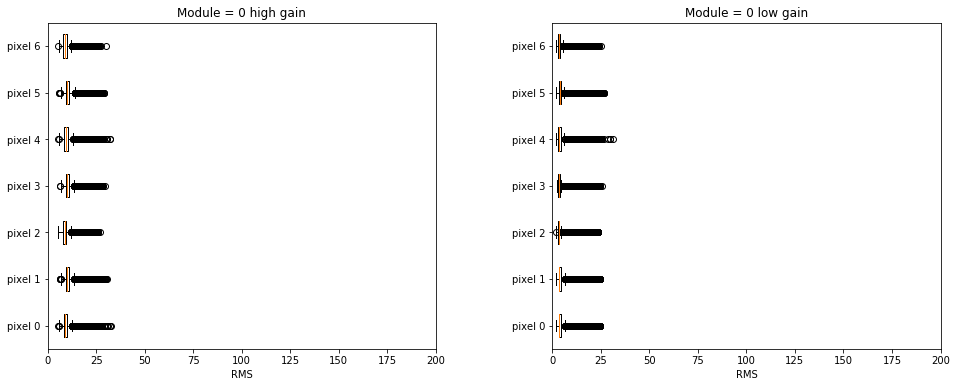

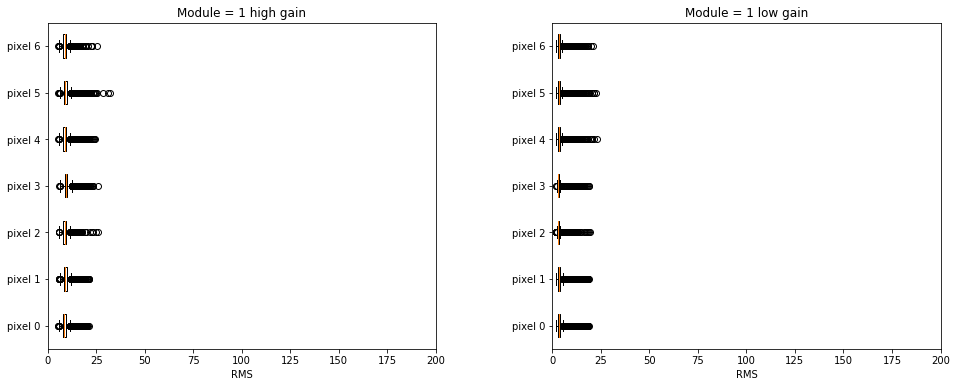

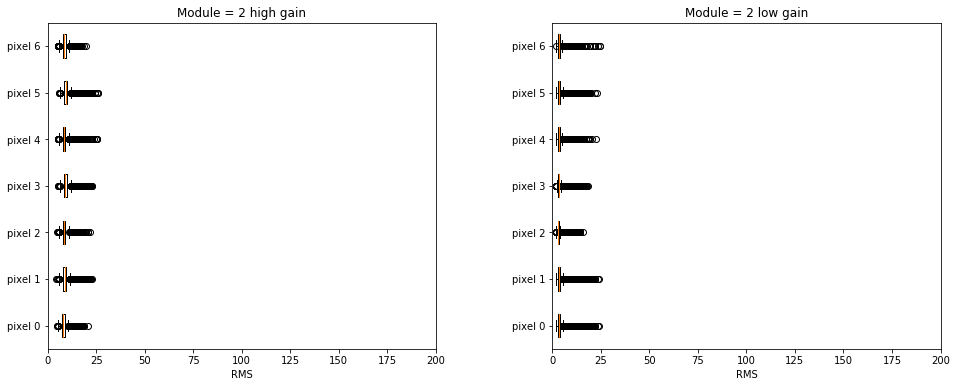

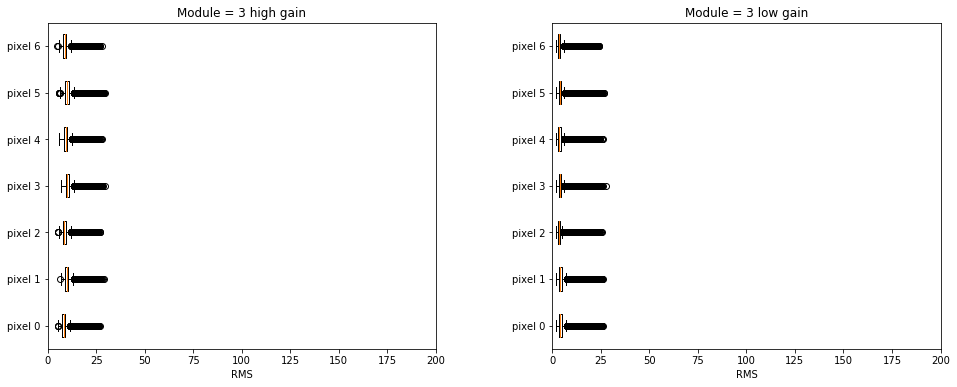

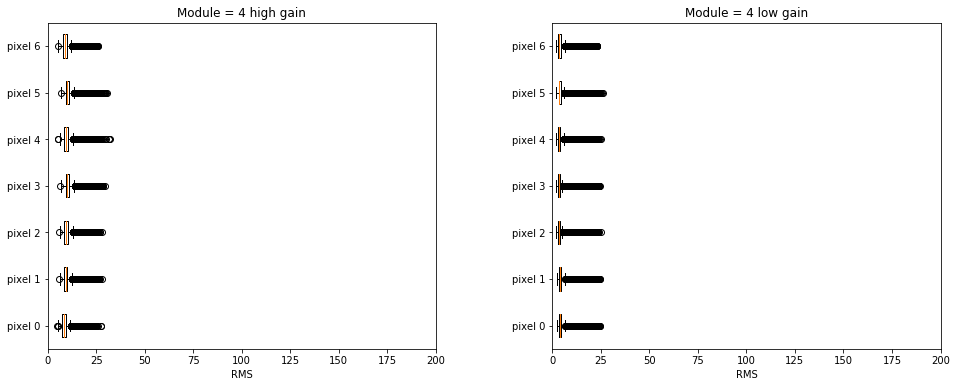

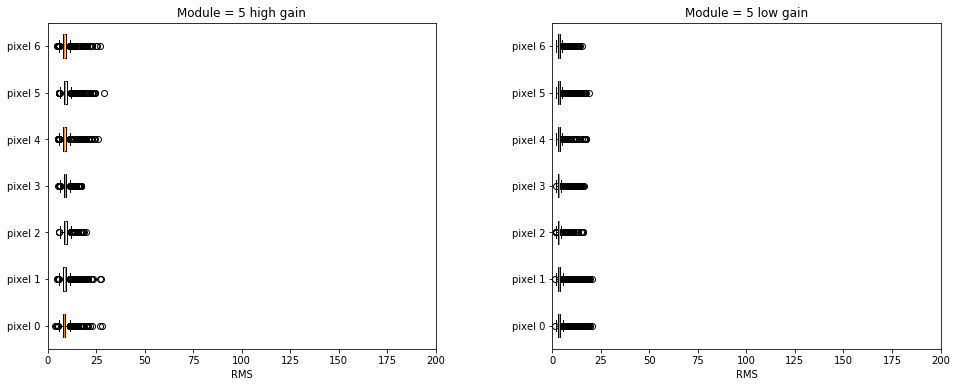

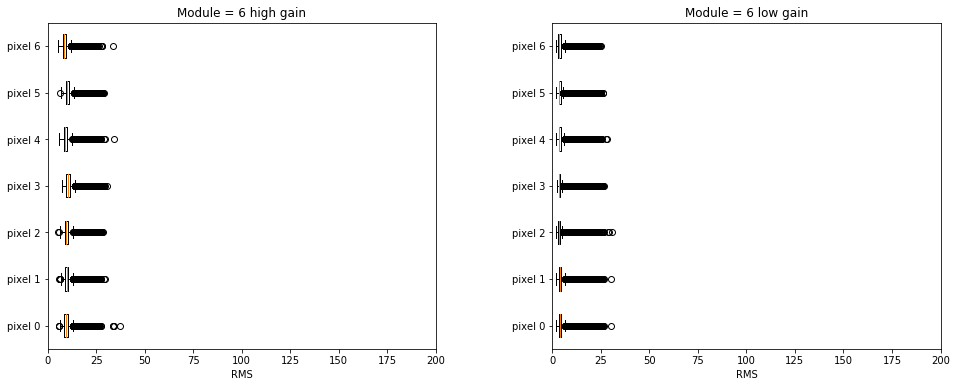

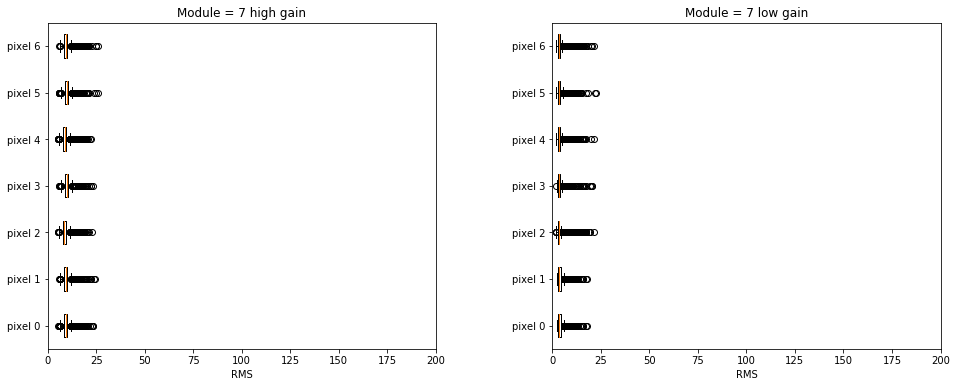

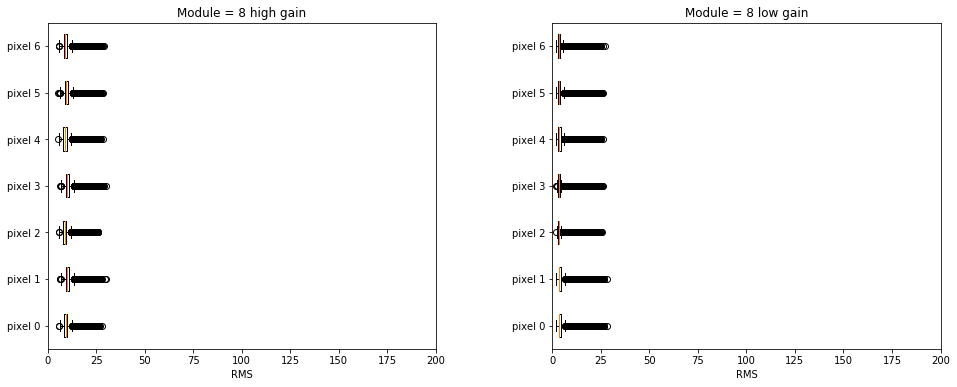

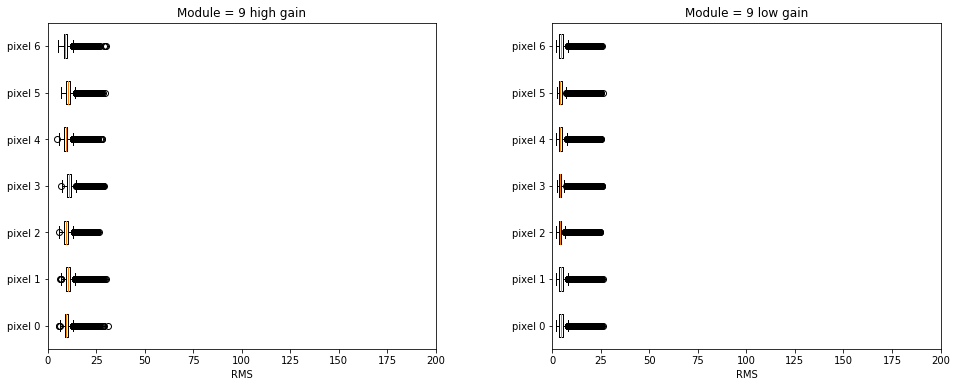

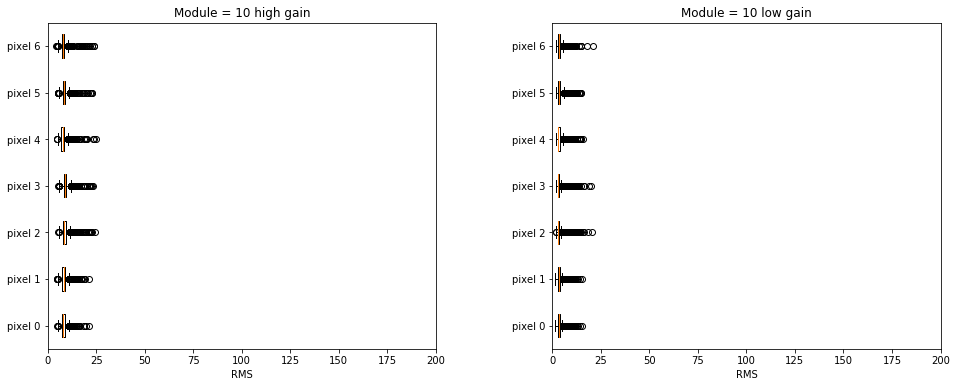

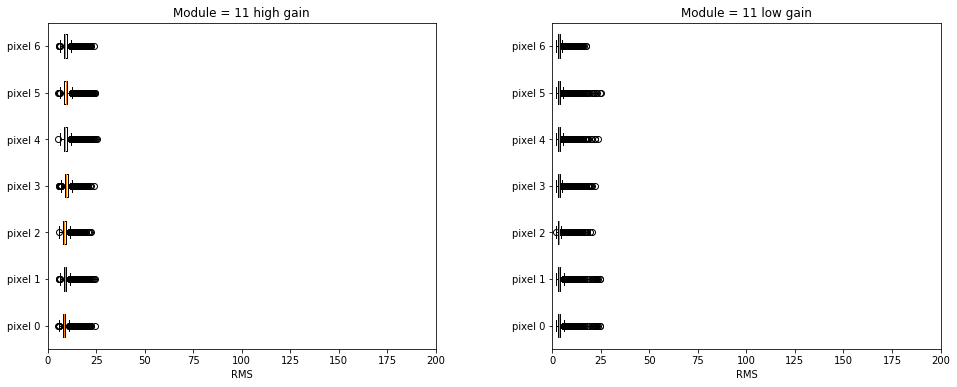

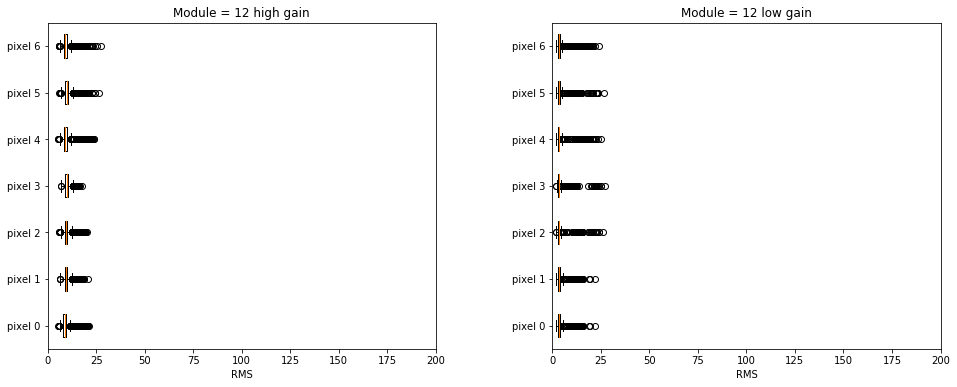

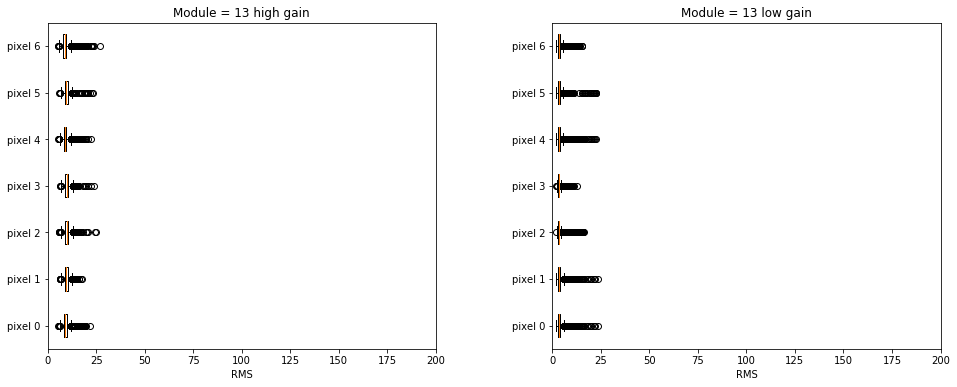

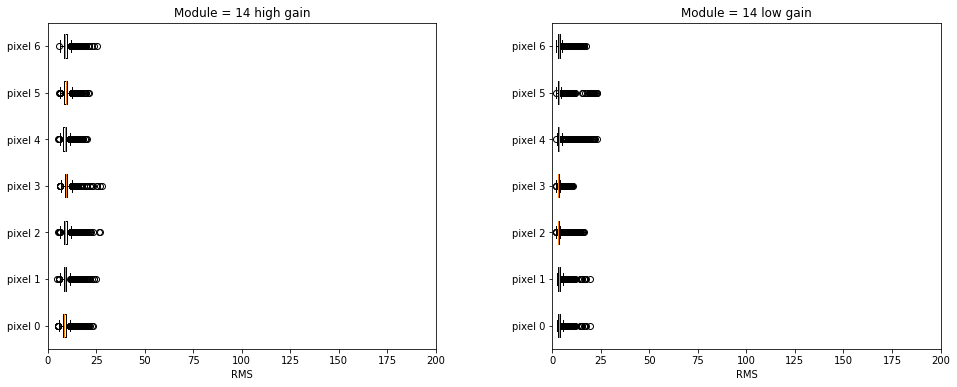

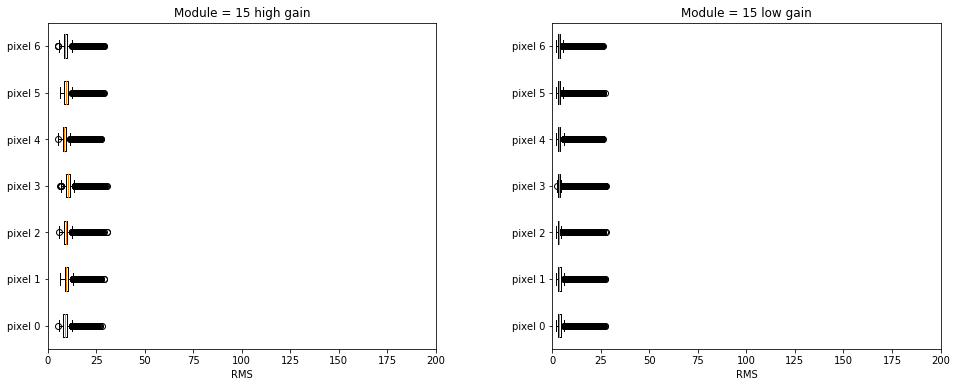

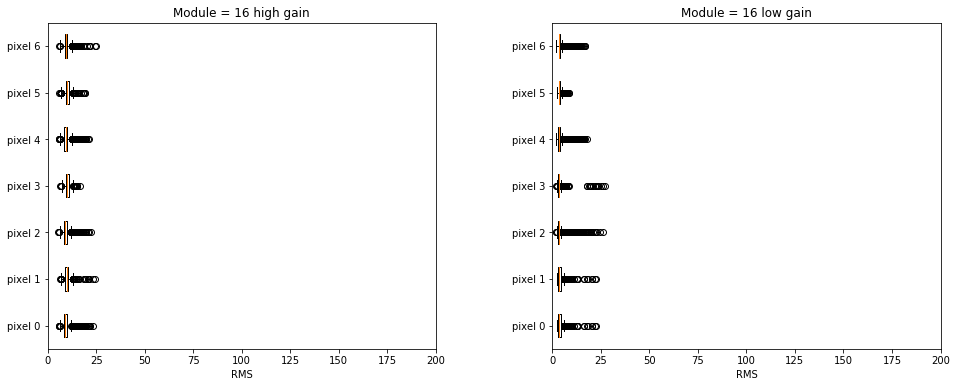

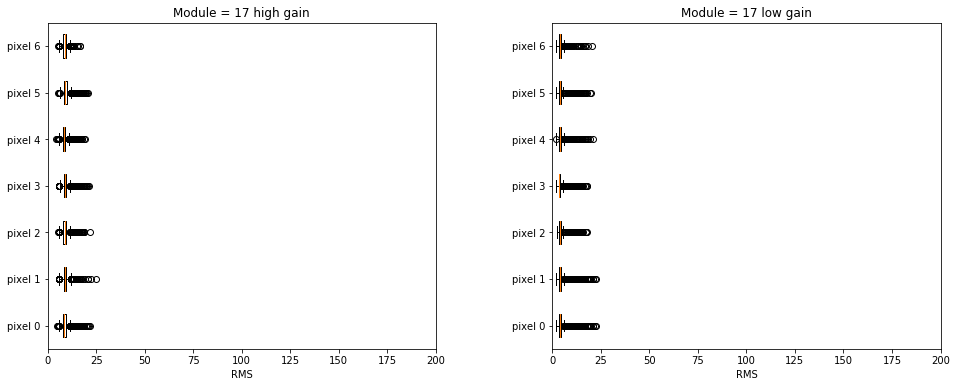

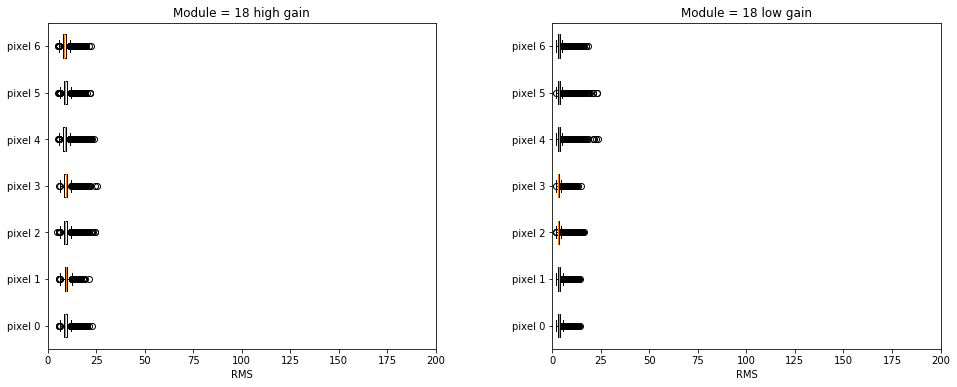

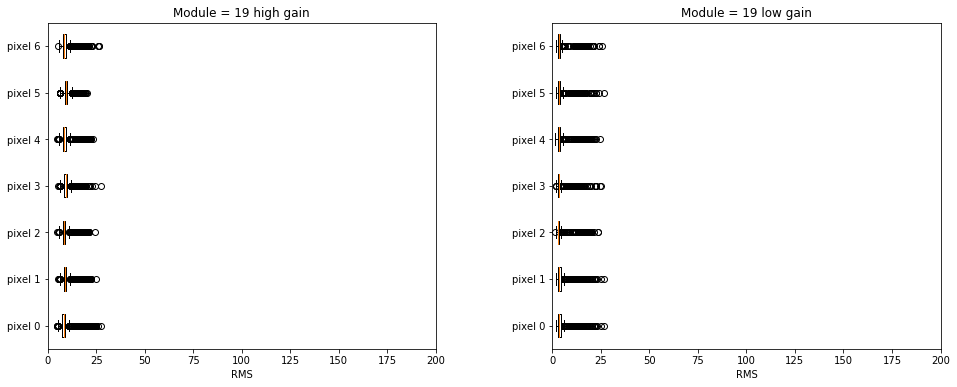

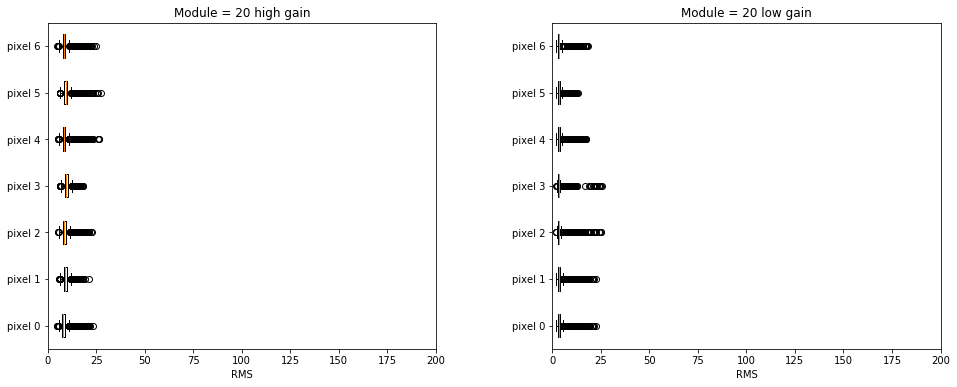

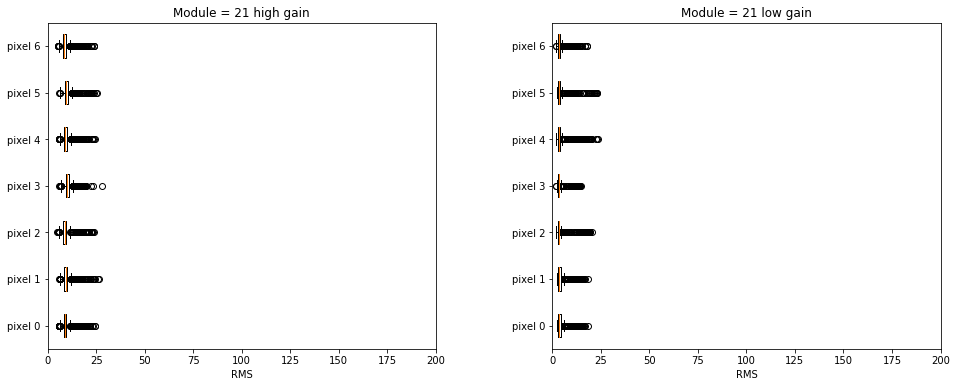

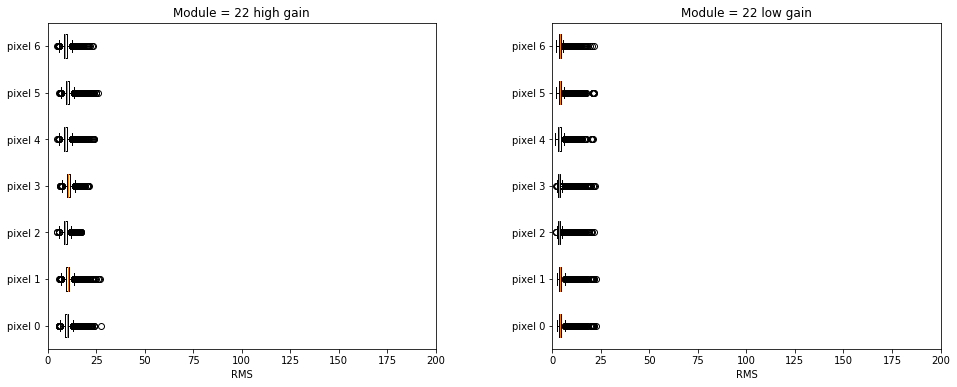

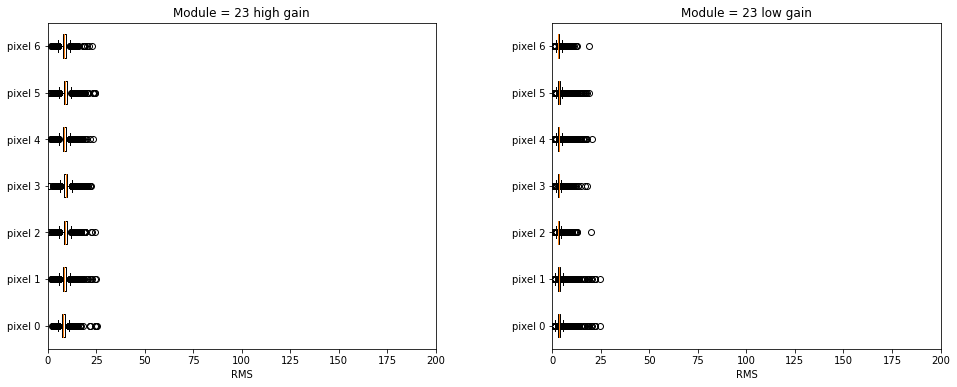

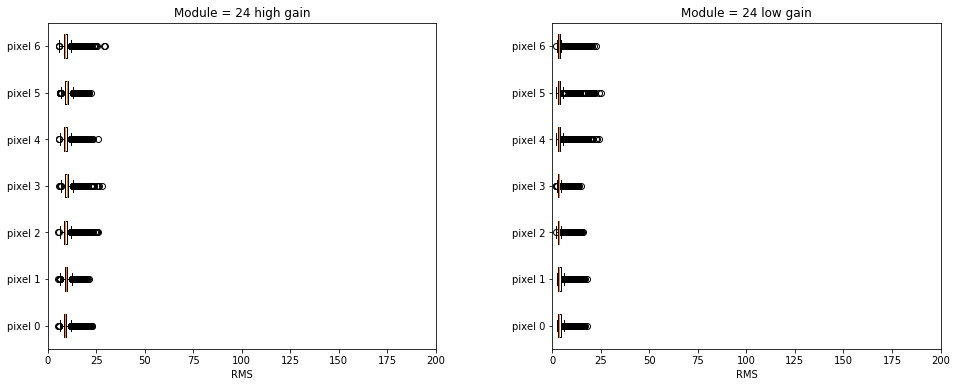

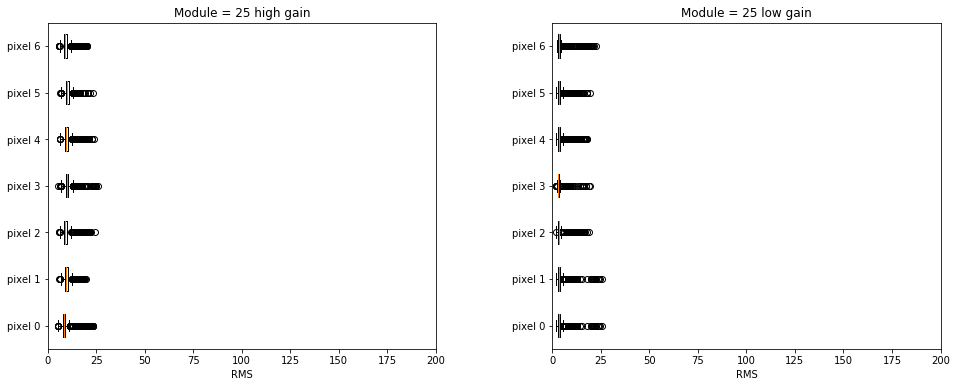

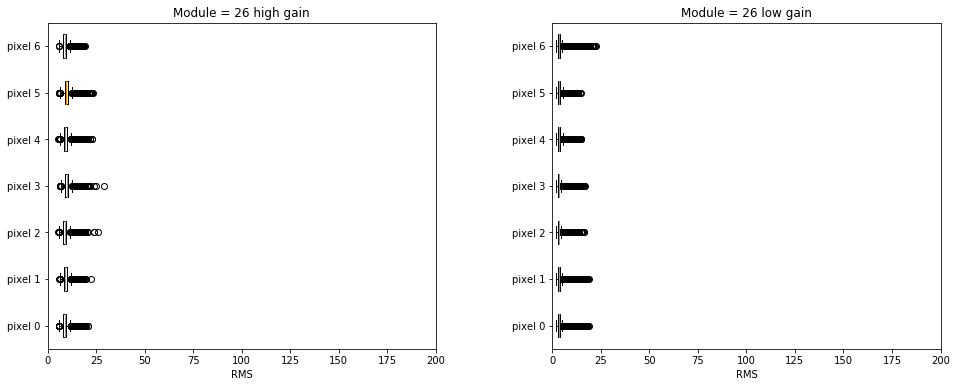

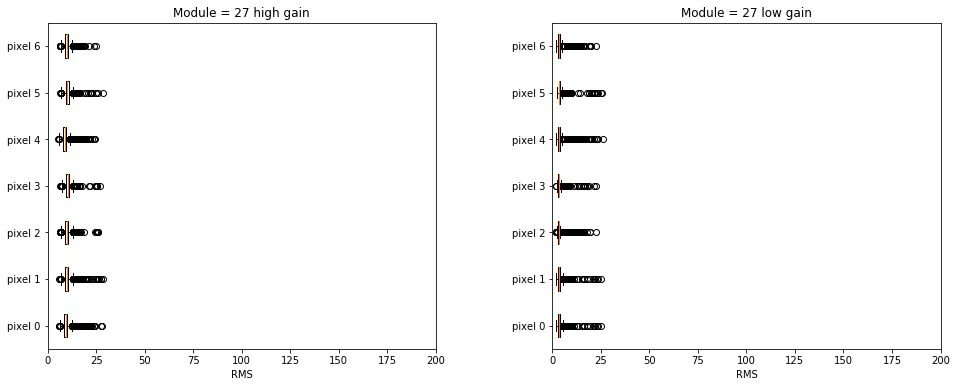

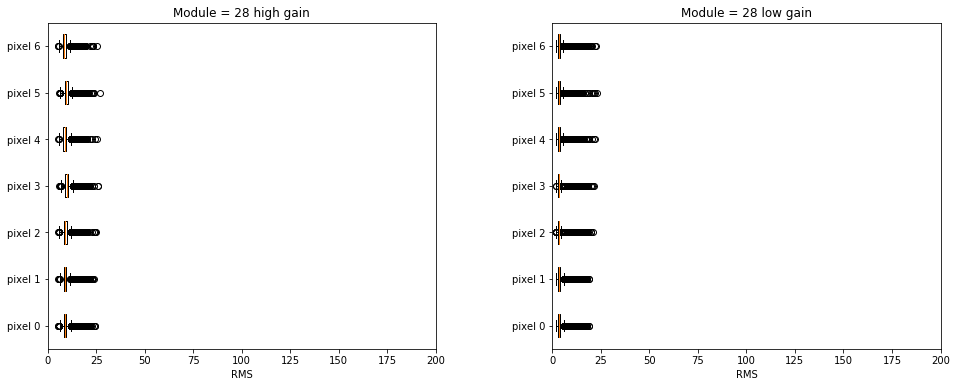

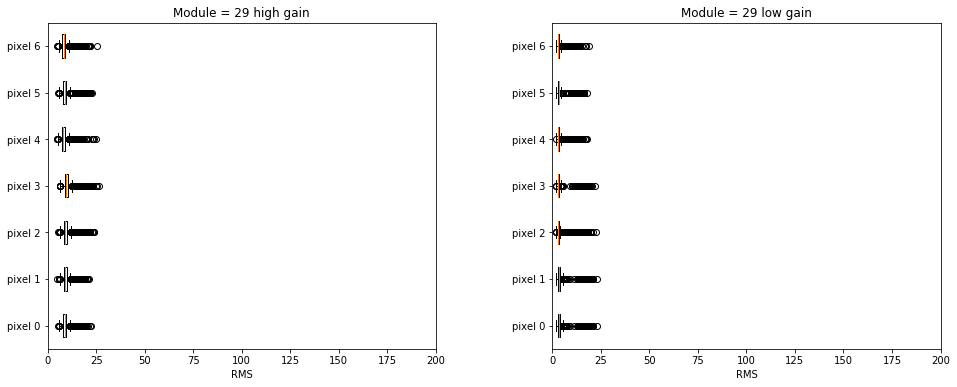

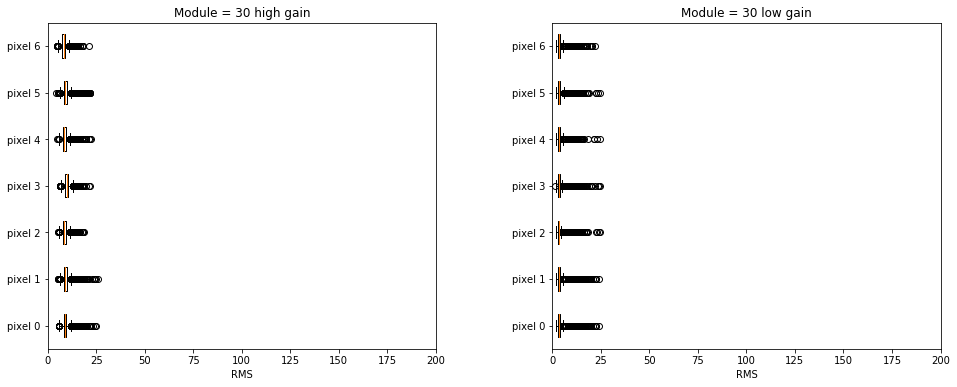

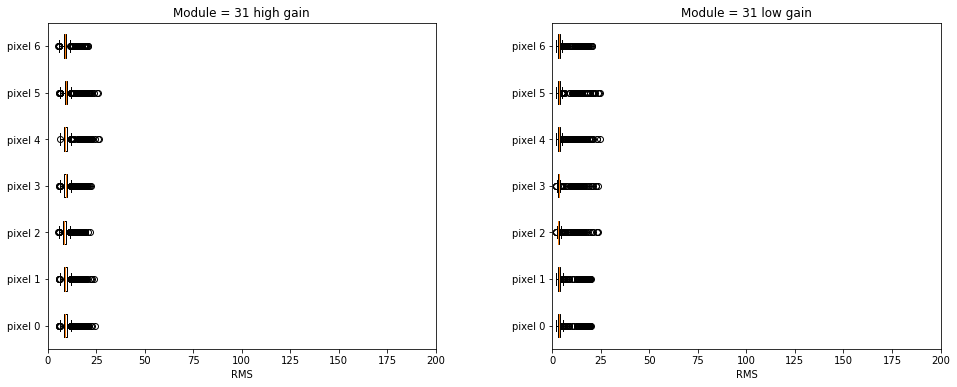

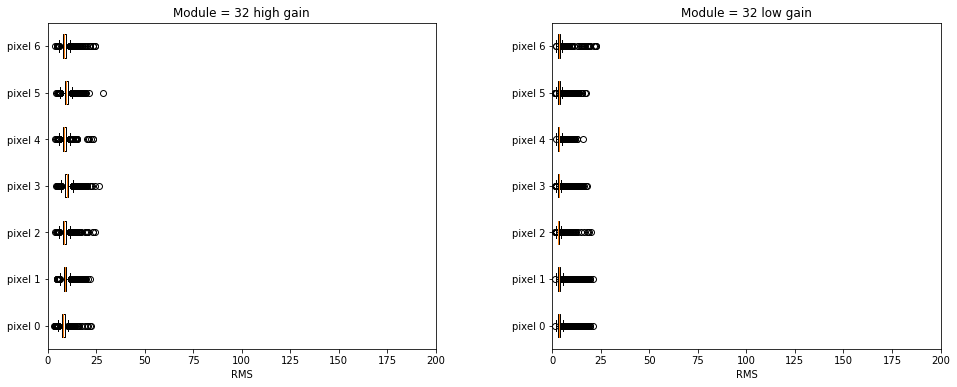

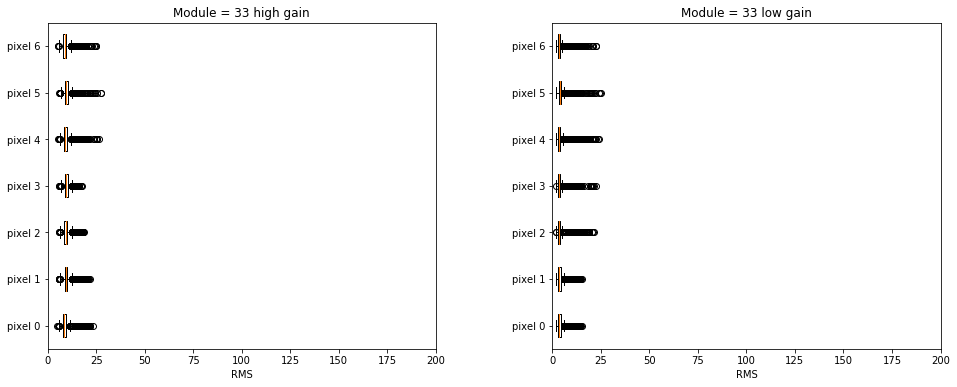

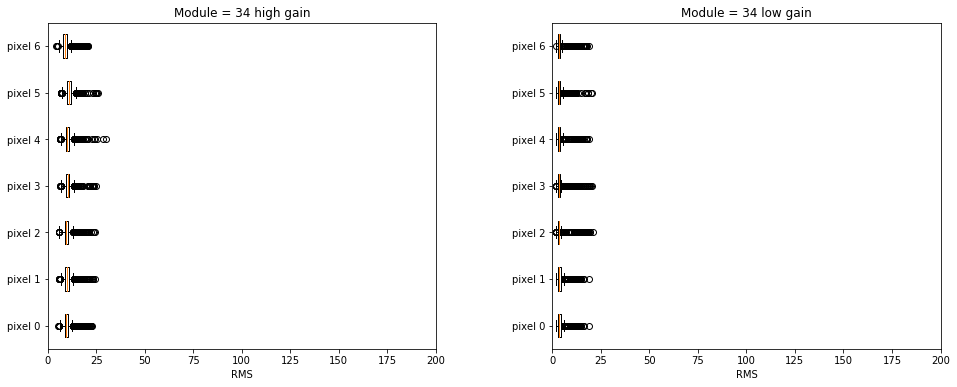

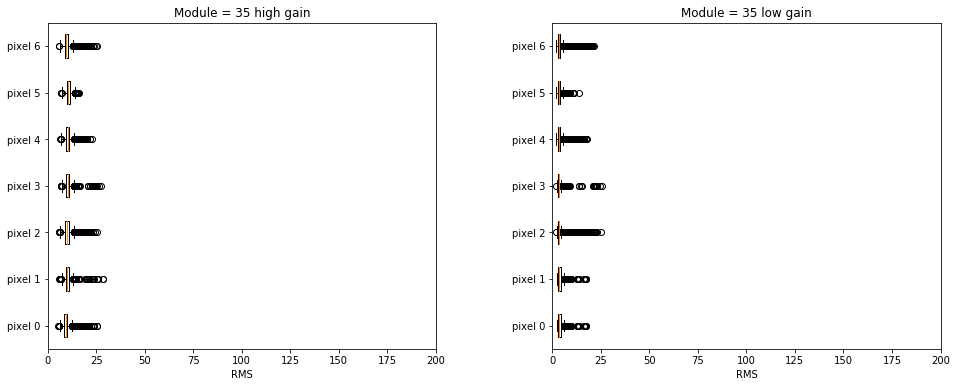

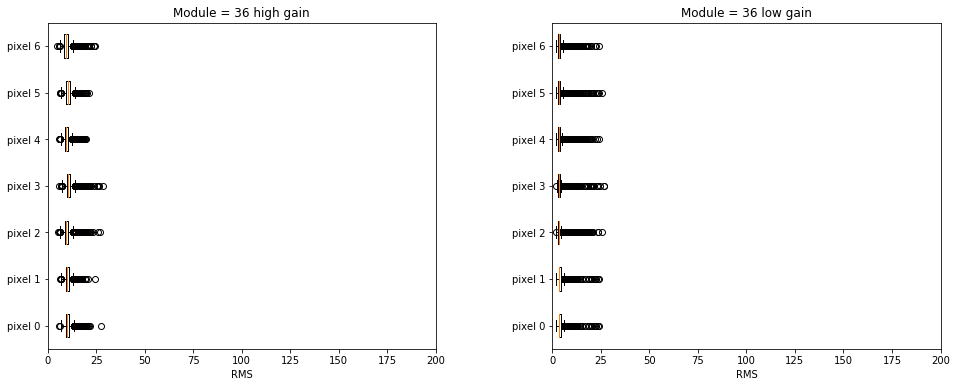

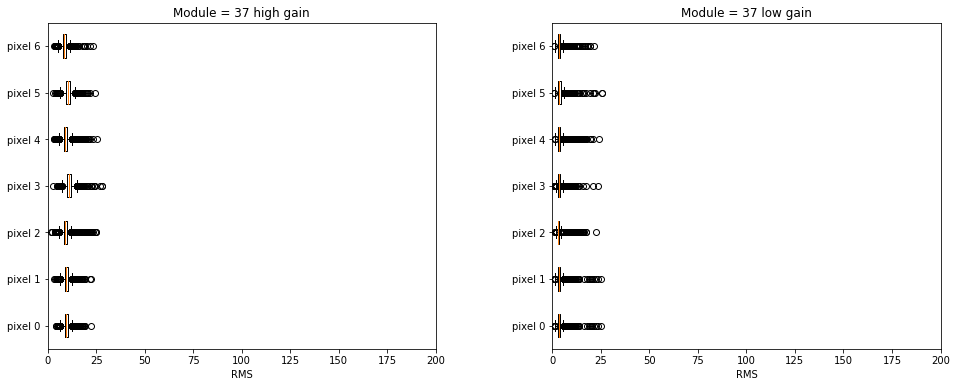

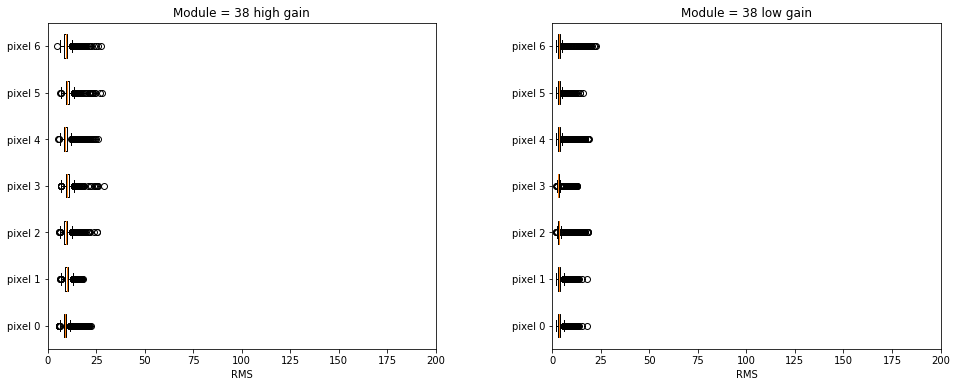

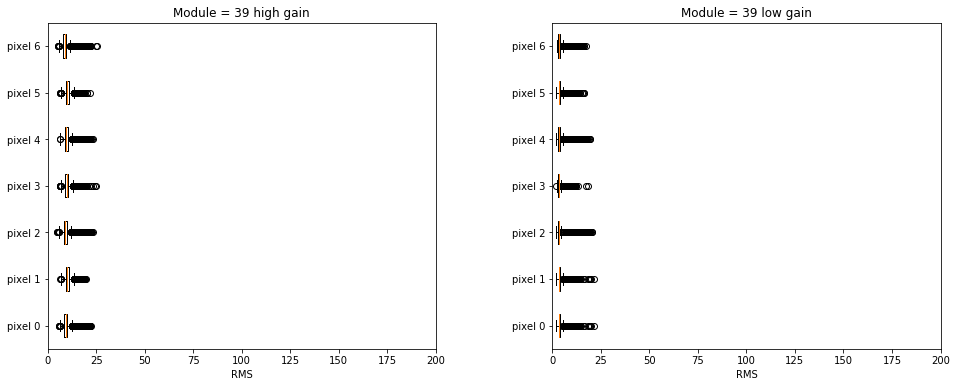

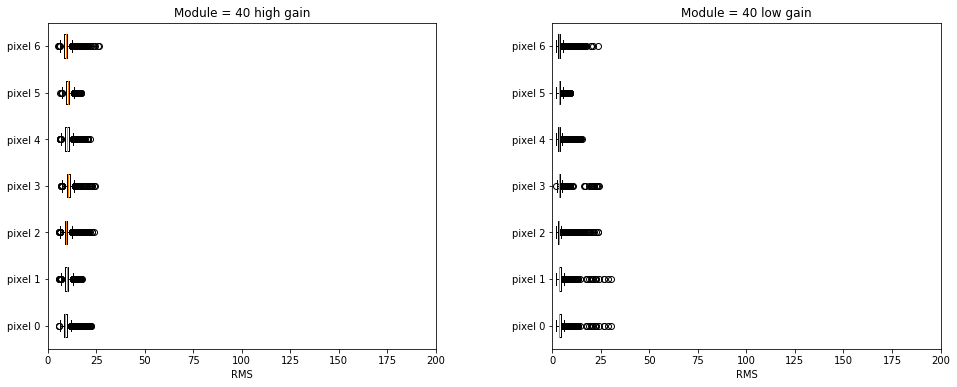

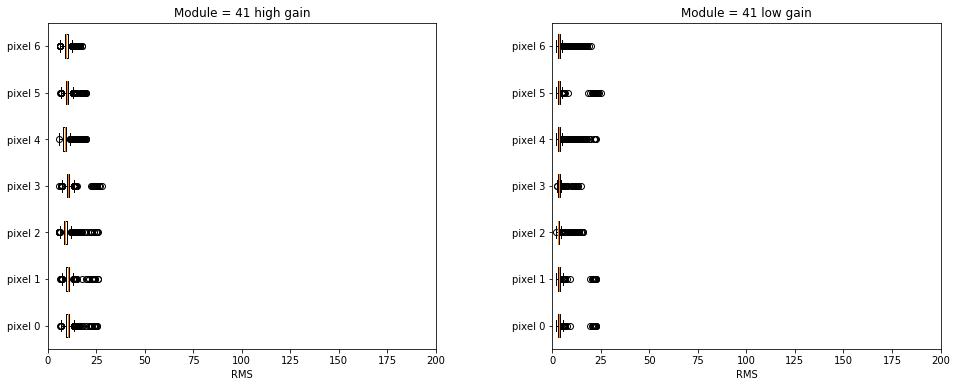

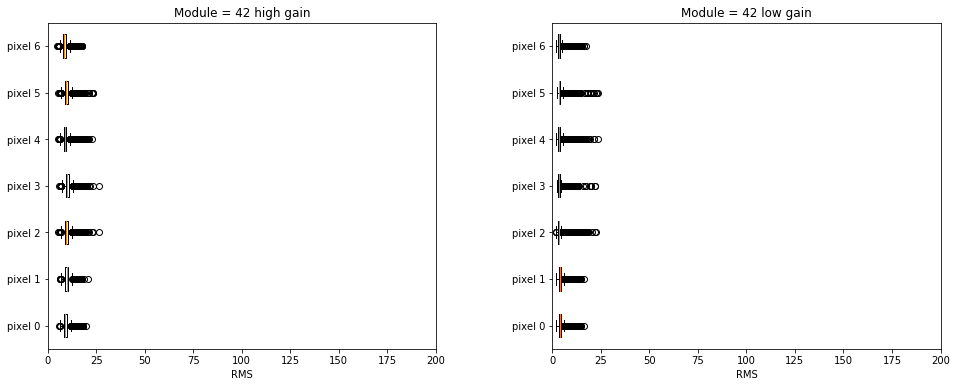

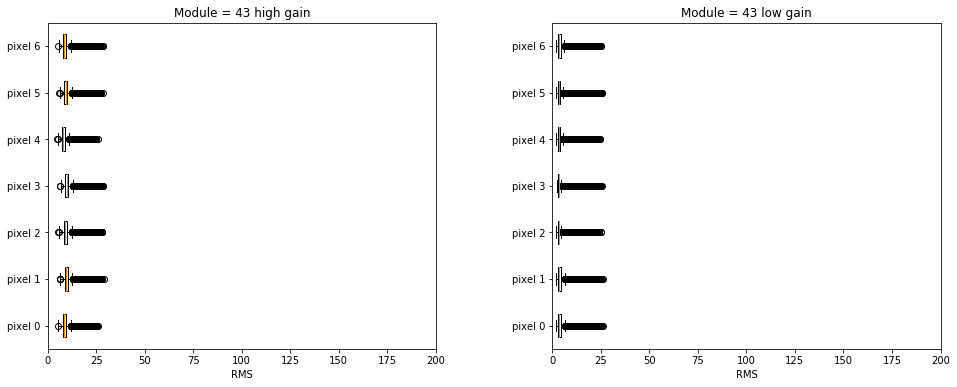

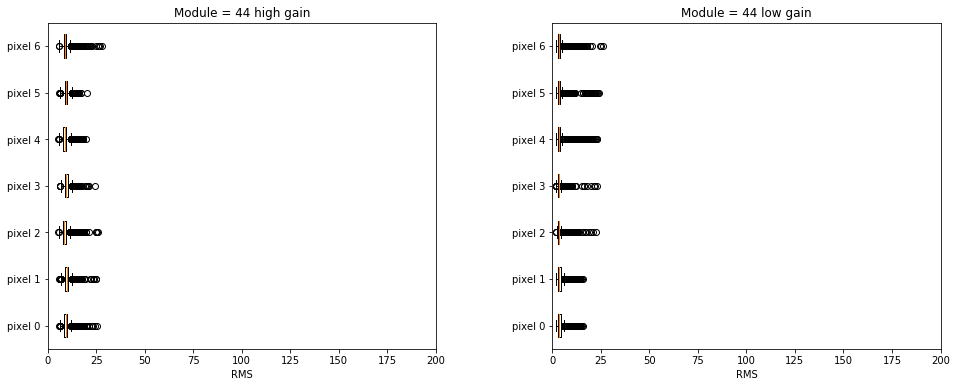

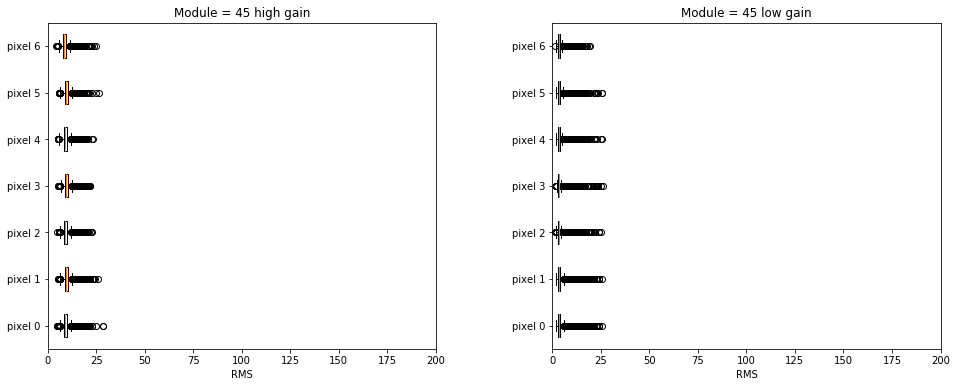

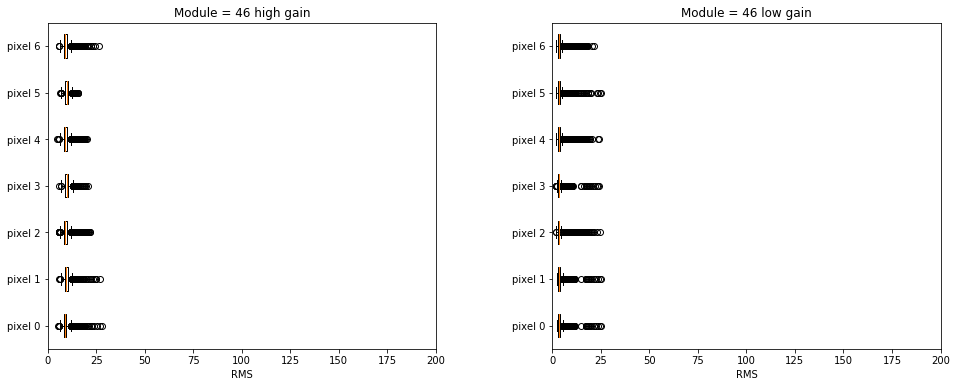

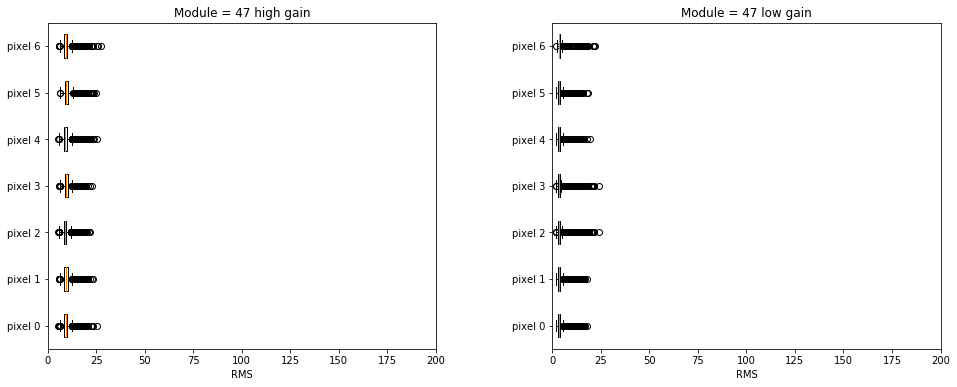

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1887: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1888: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


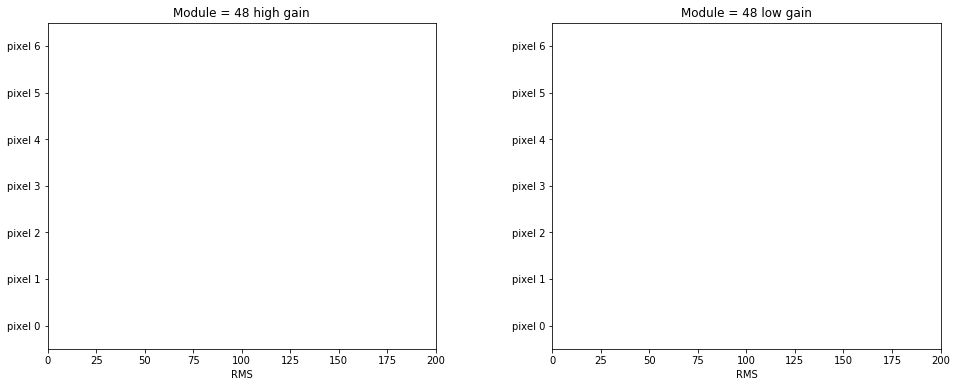

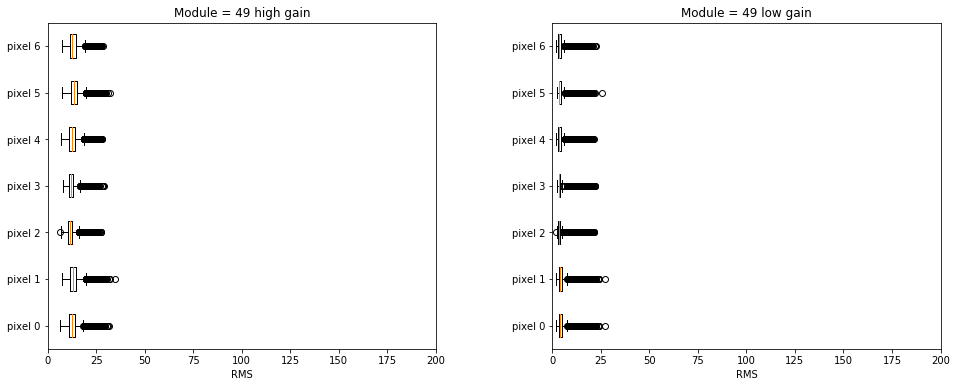

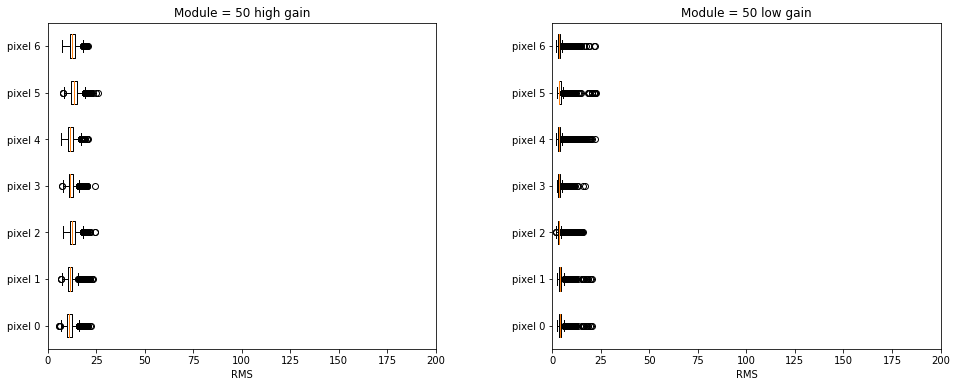

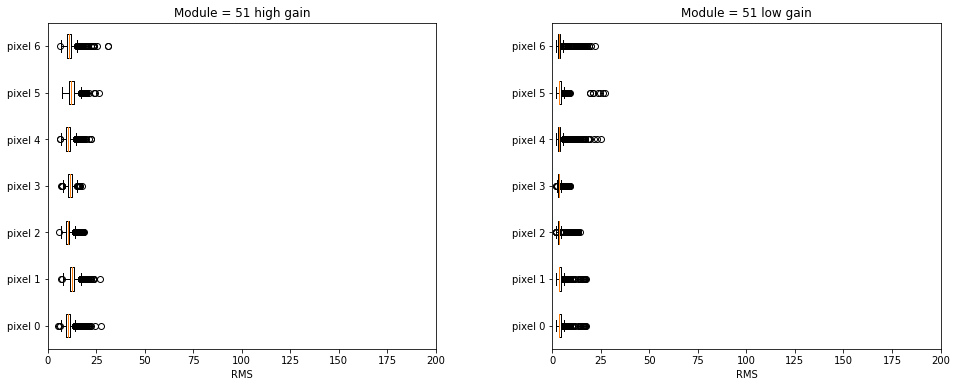

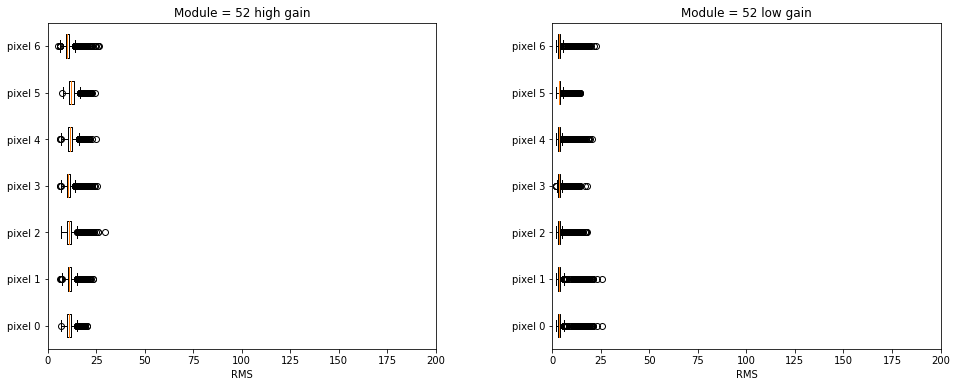

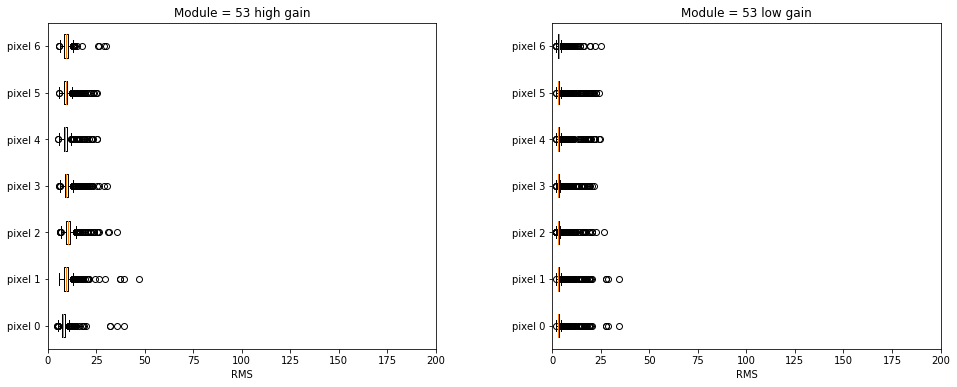

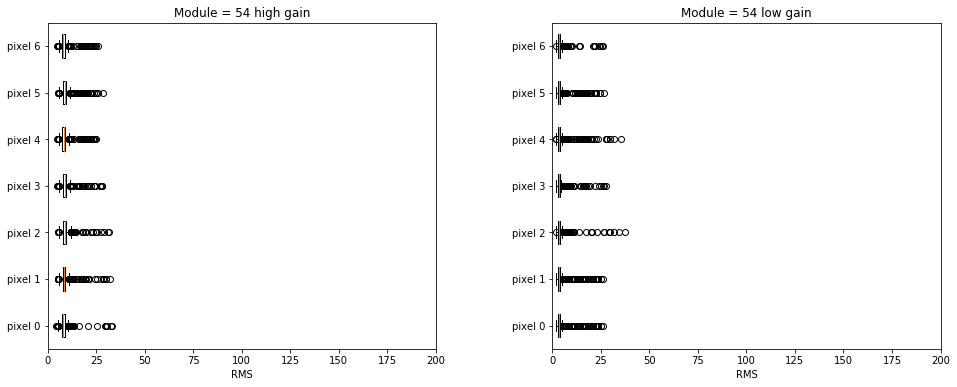

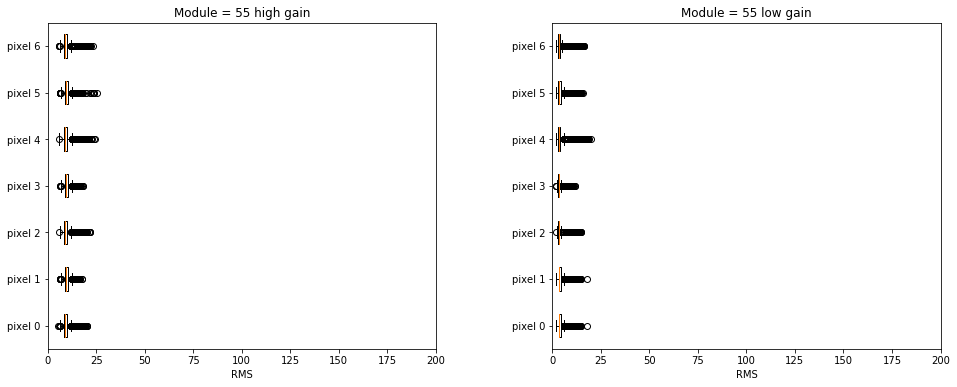

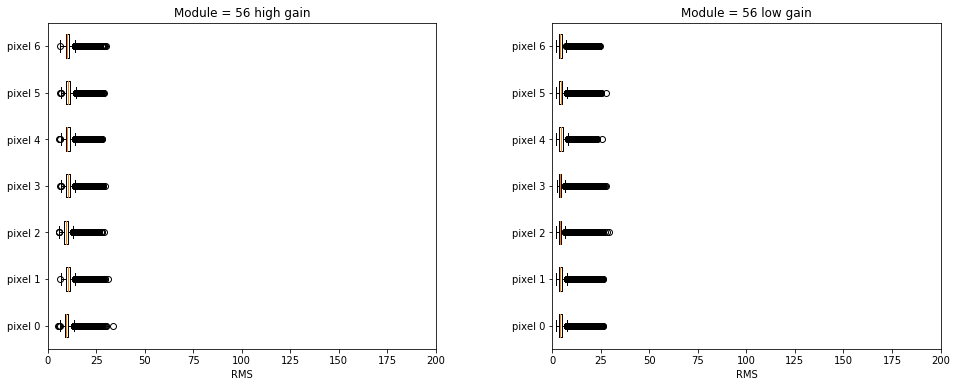

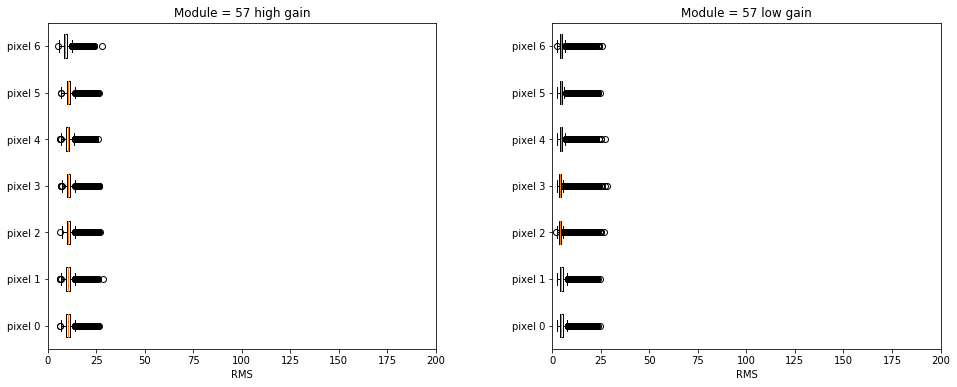

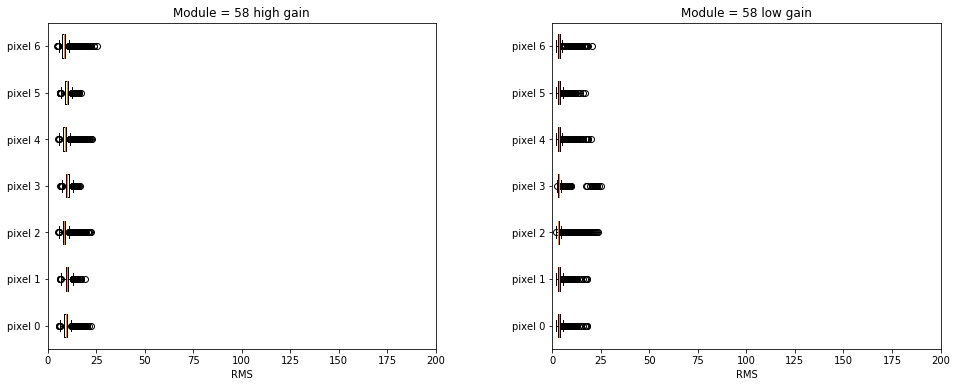

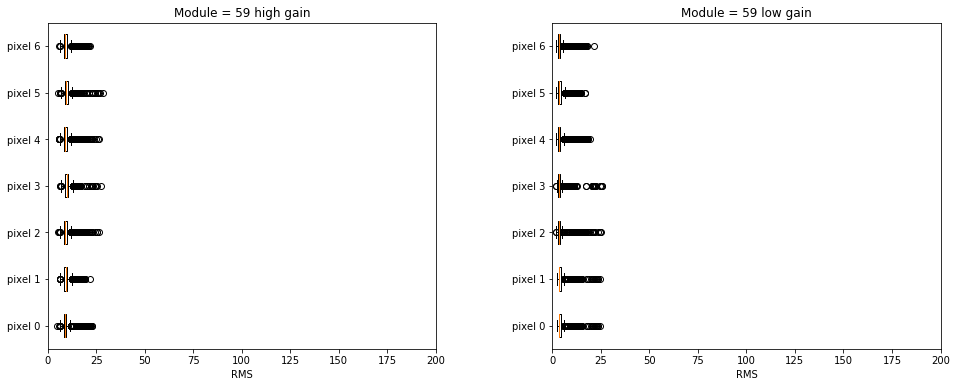

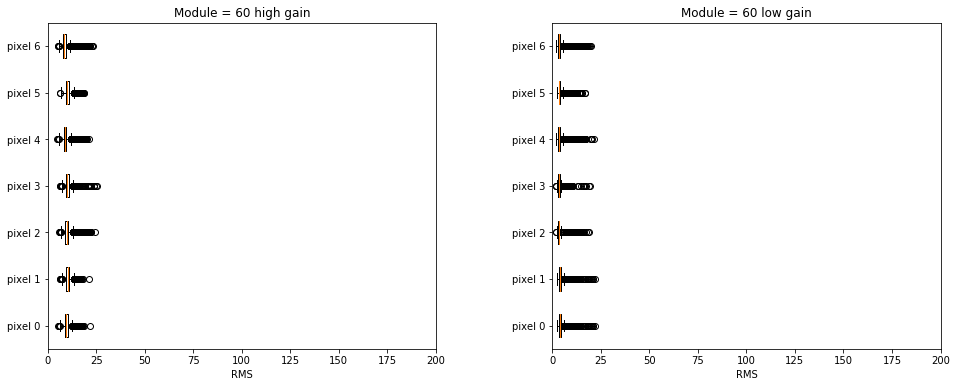

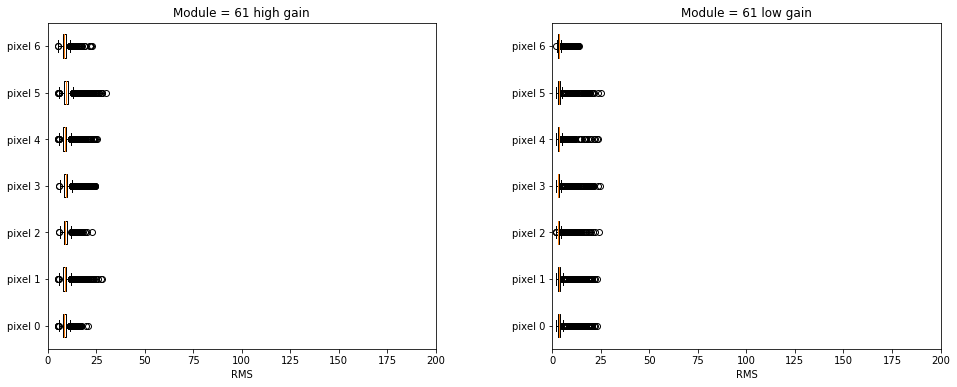

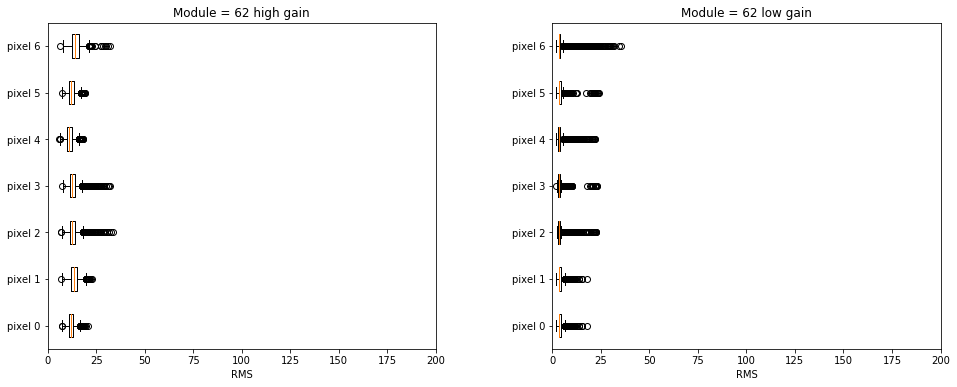

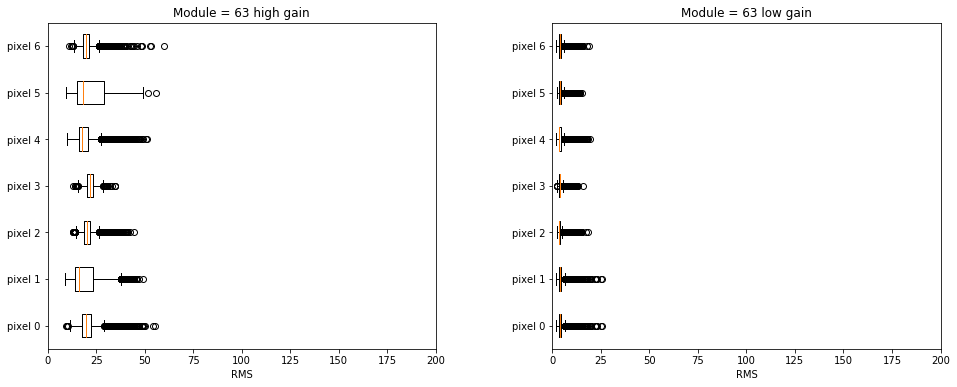

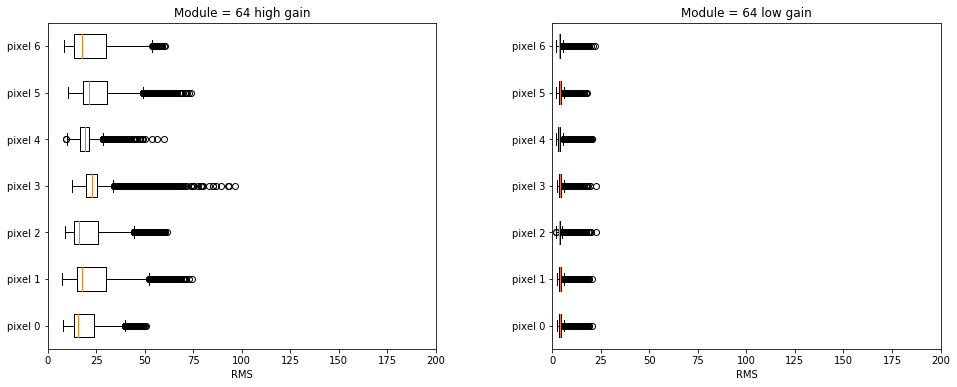

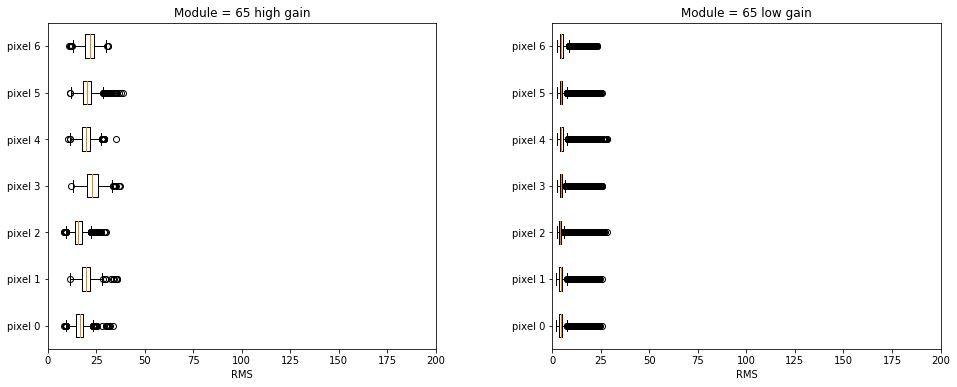

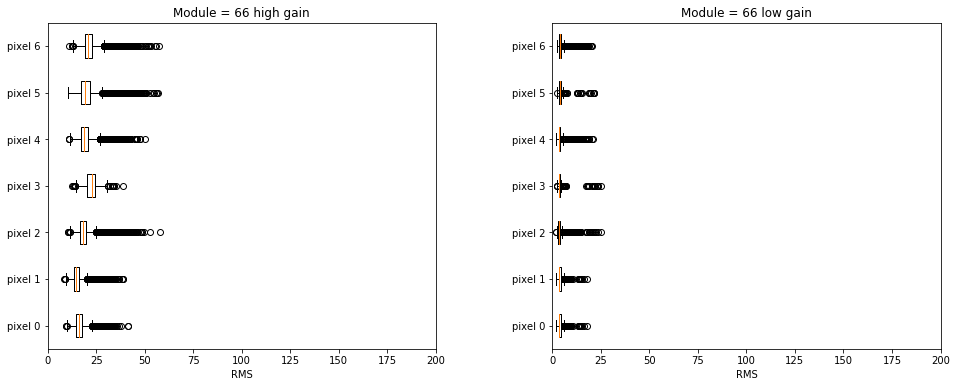

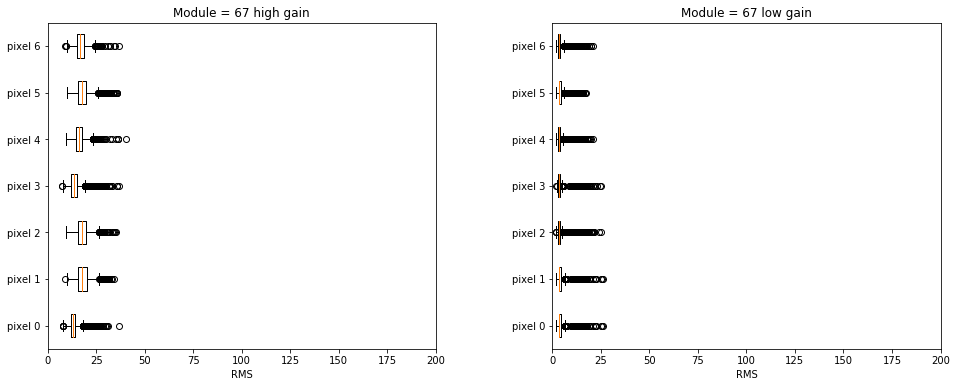

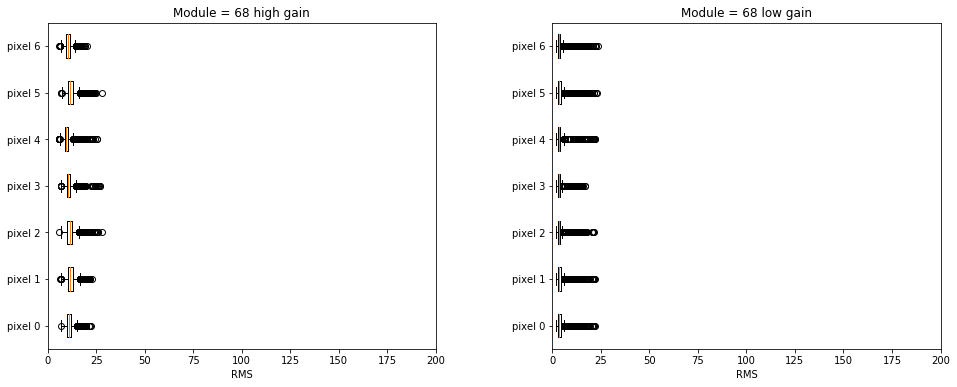

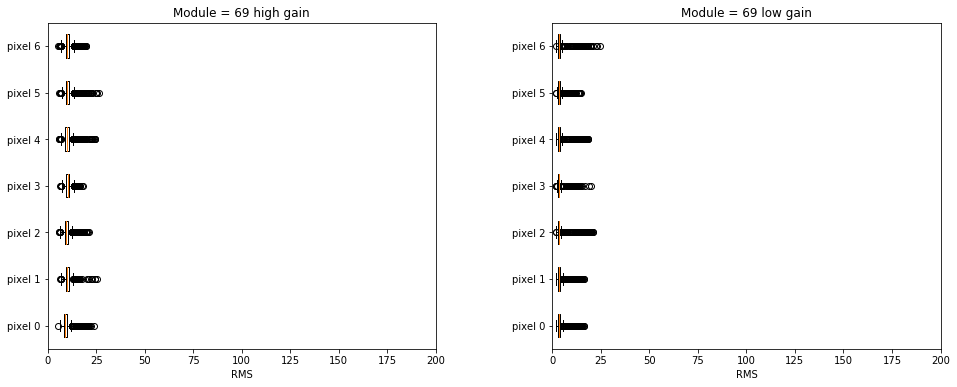

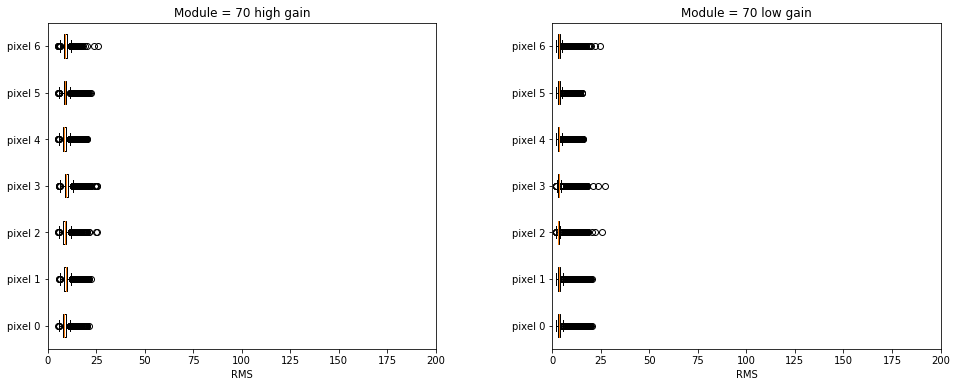

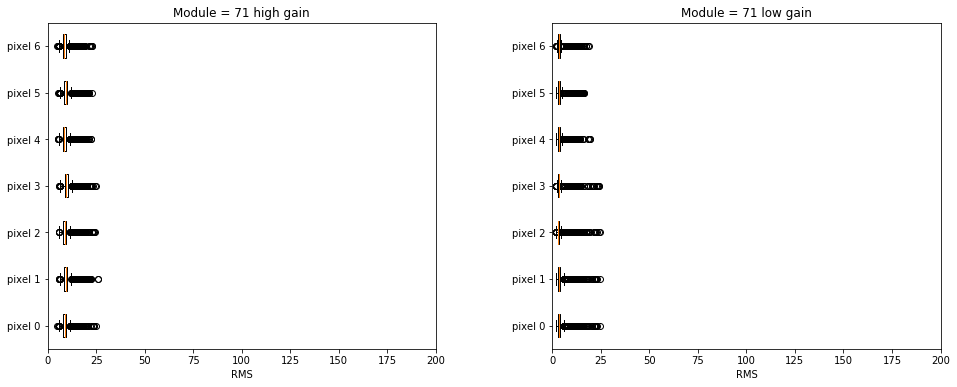

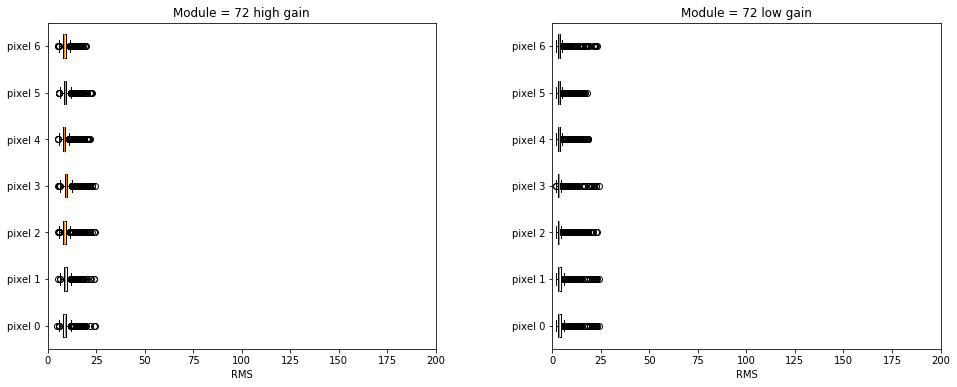

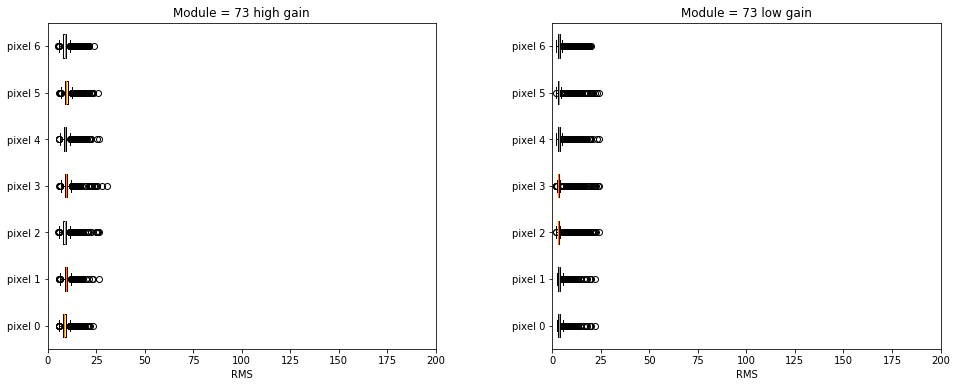

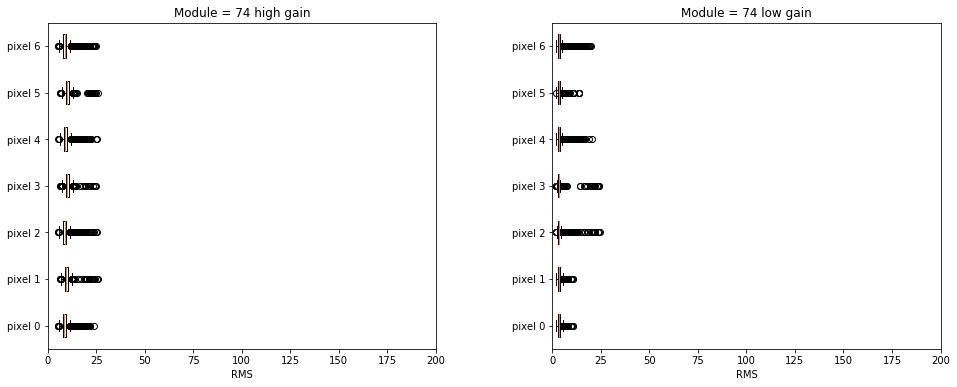

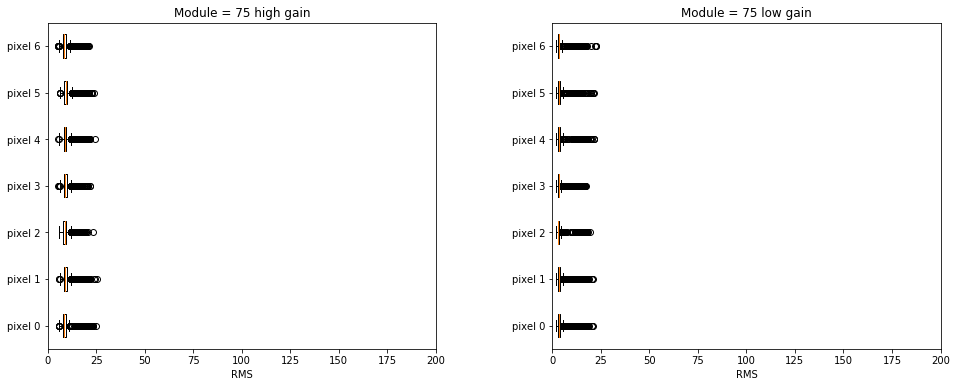

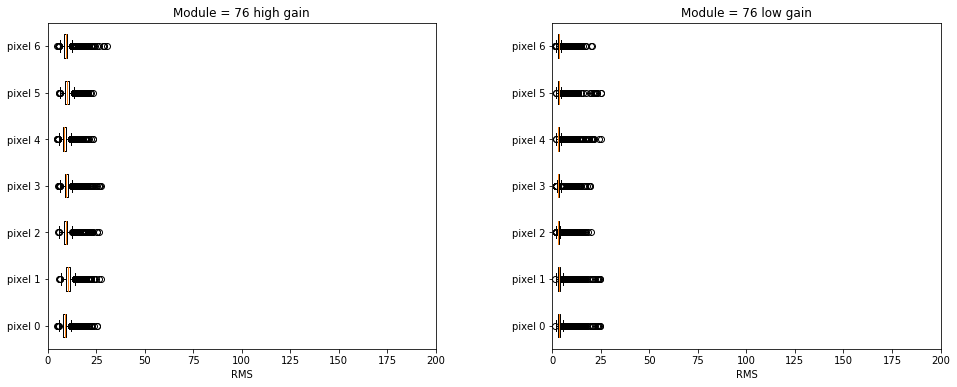

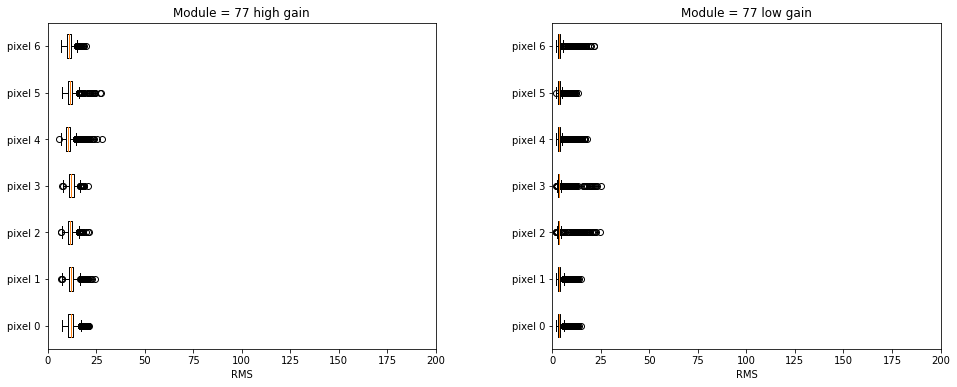

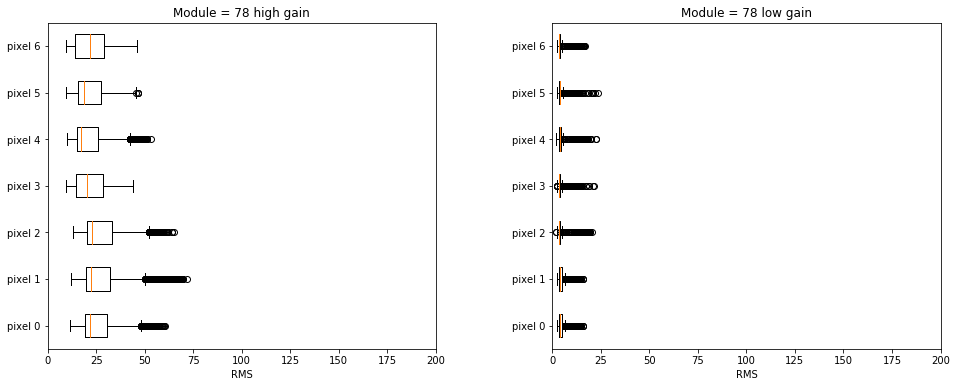

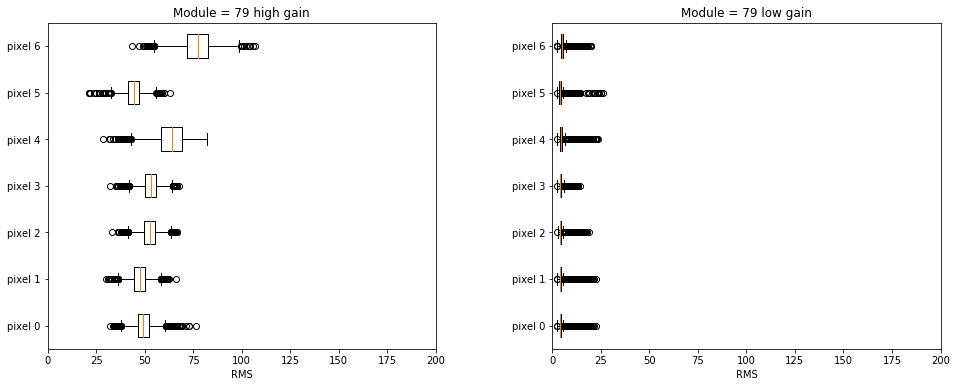

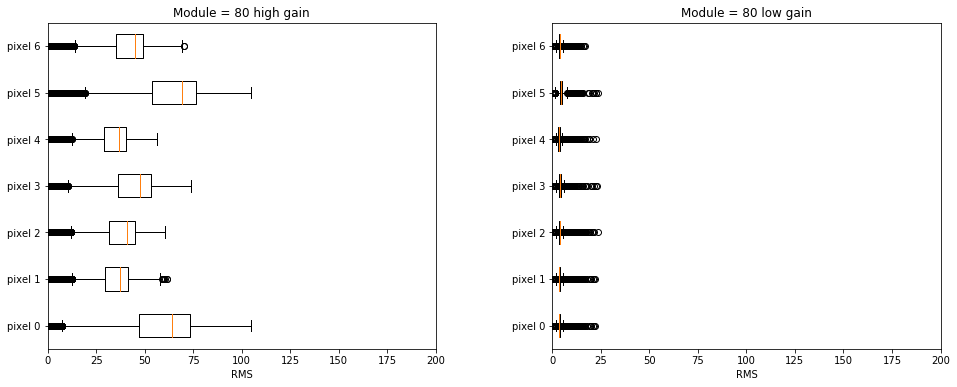

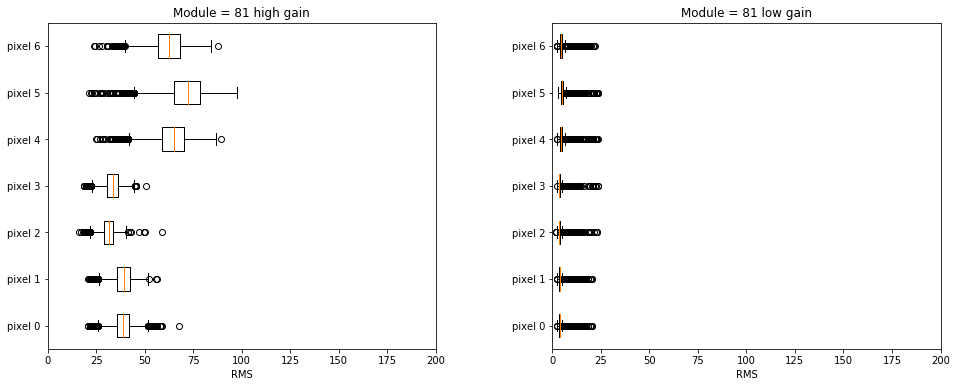

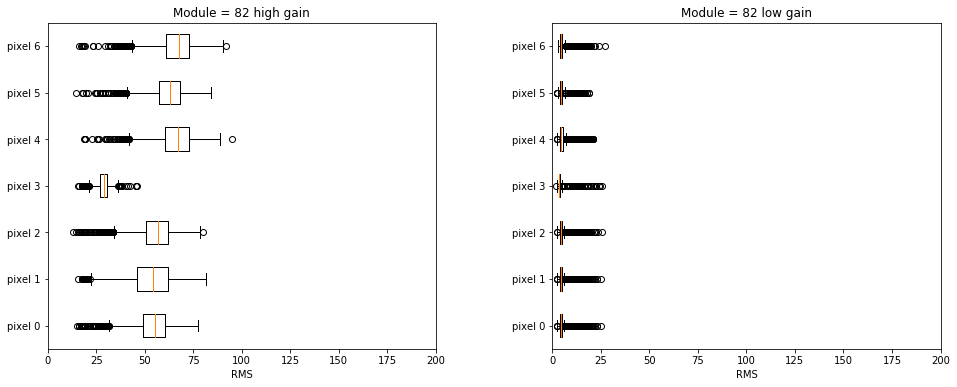

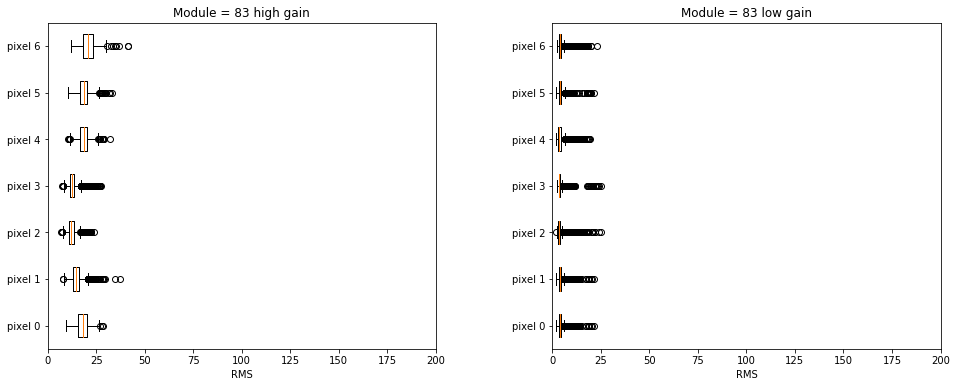

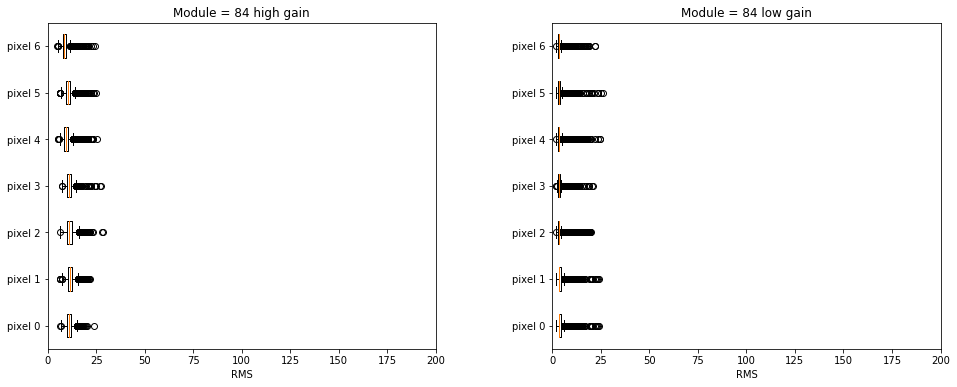

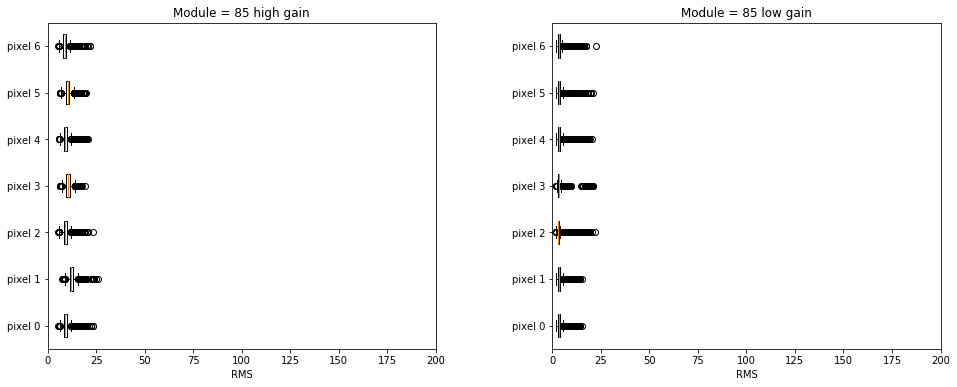

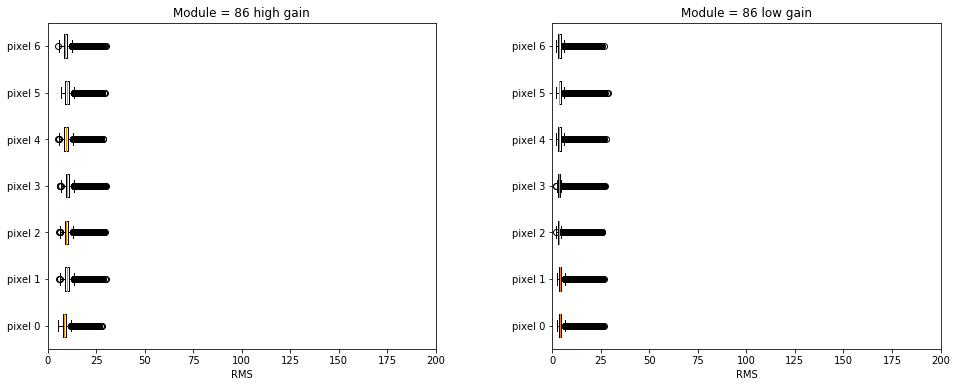

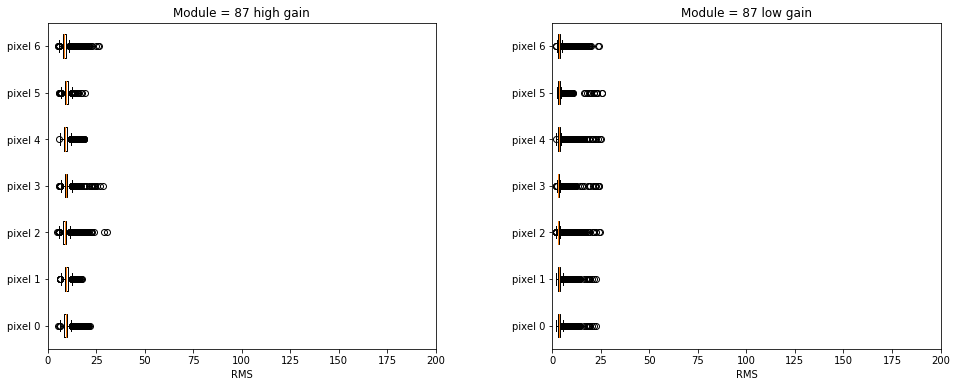

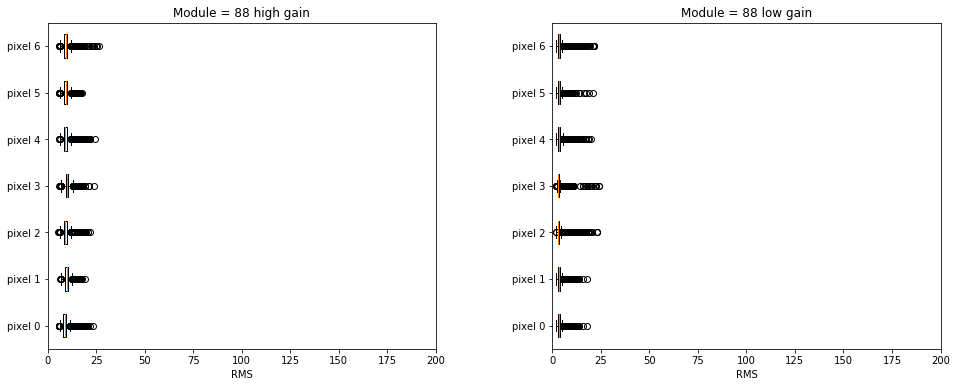

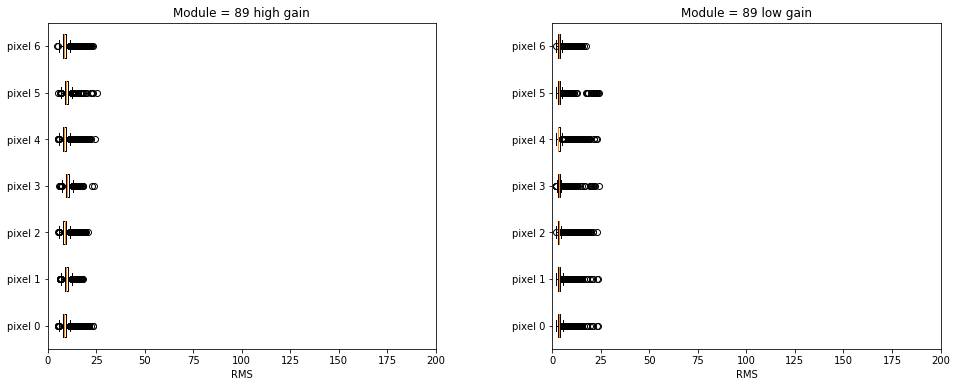

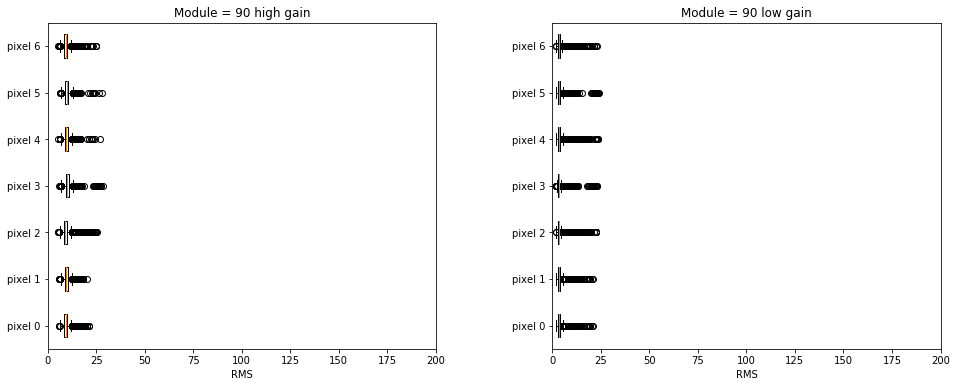

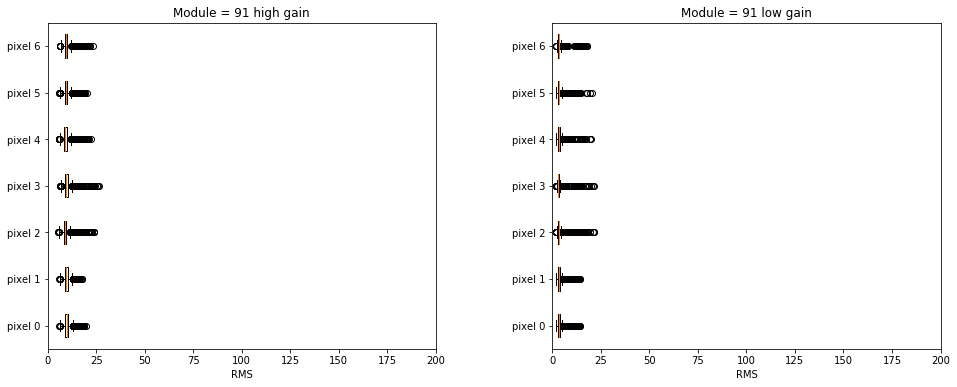

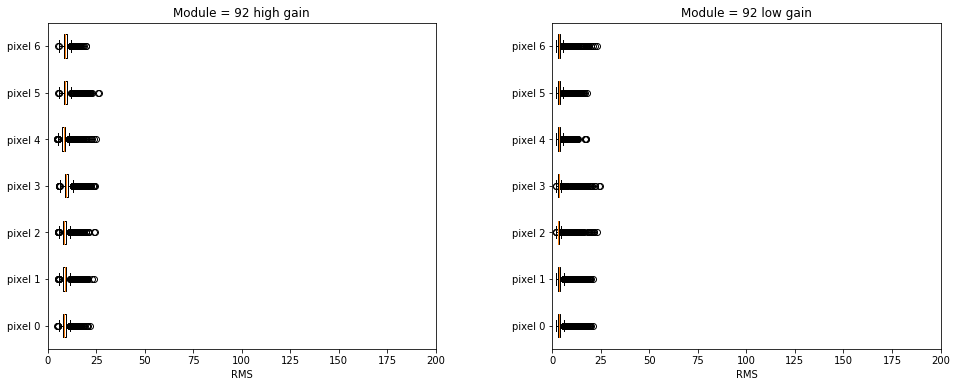

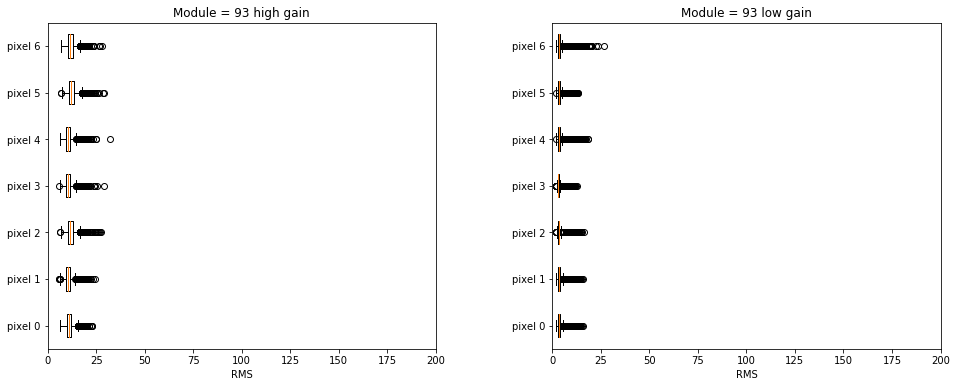

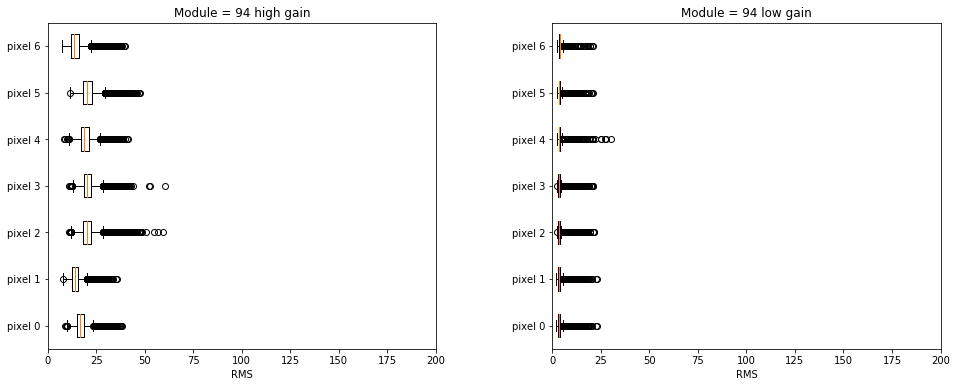

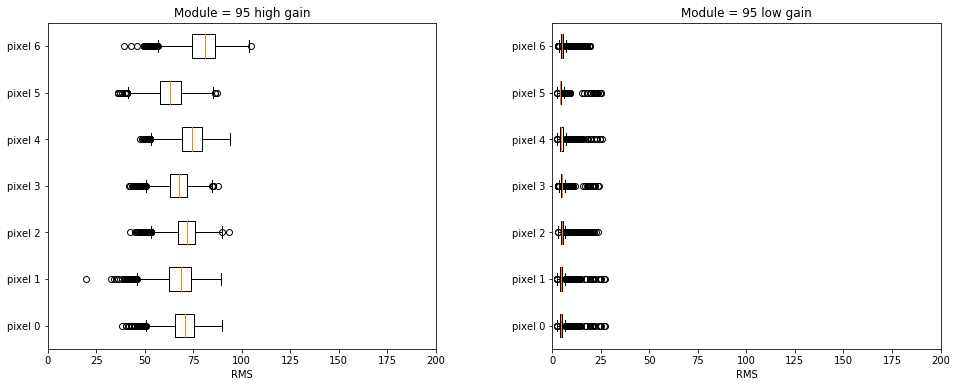

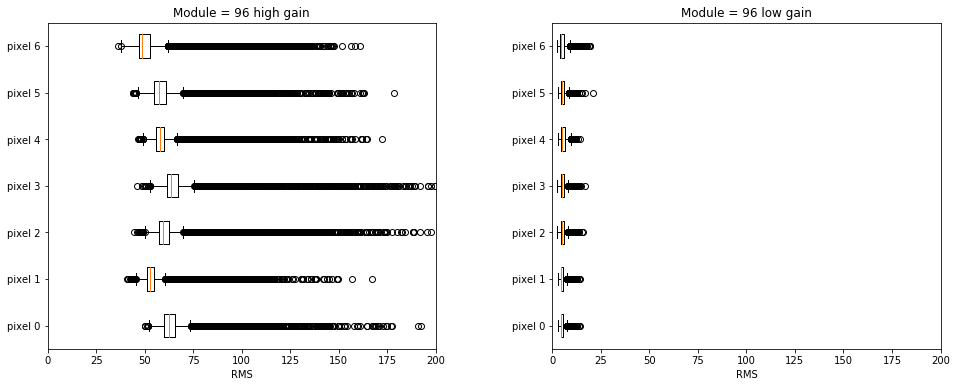

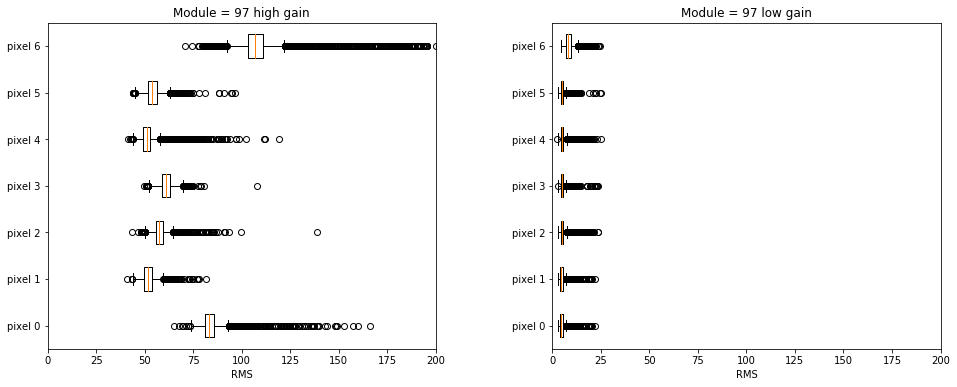

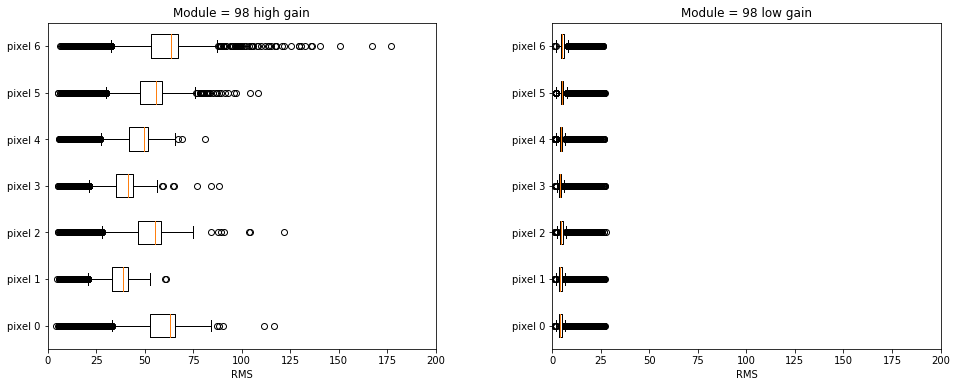

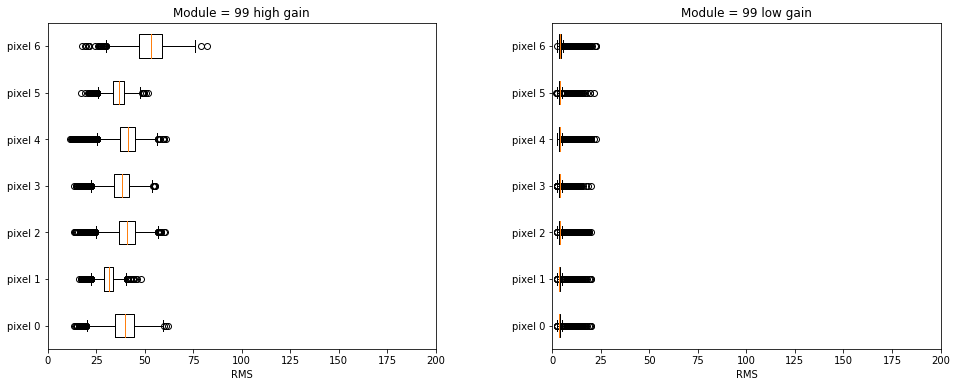

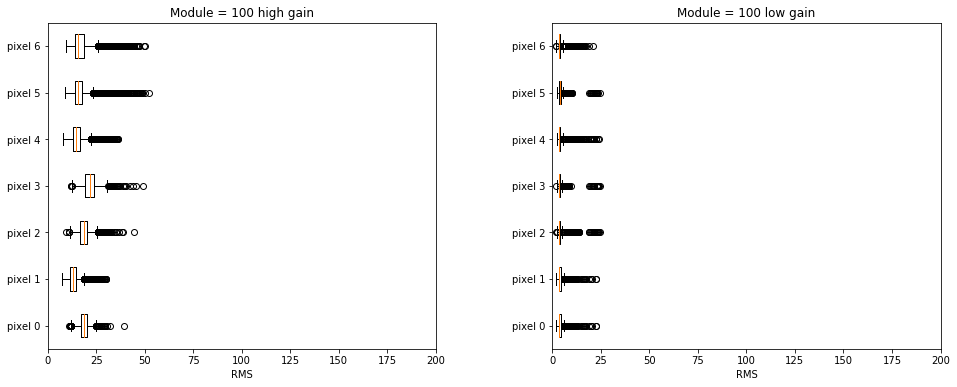

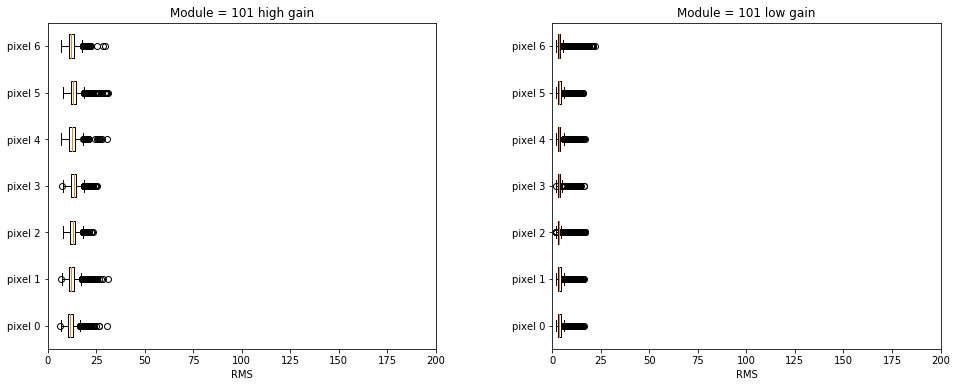

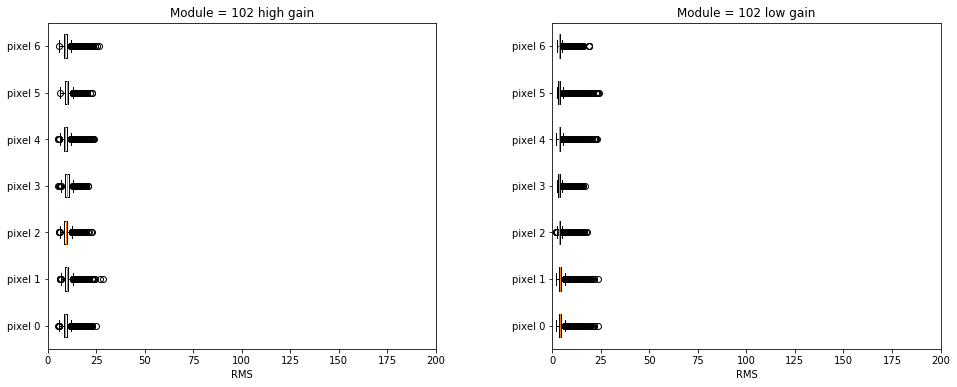

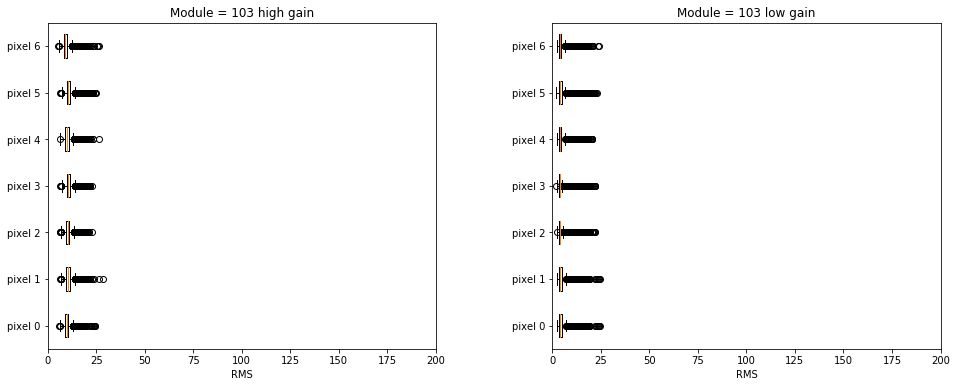

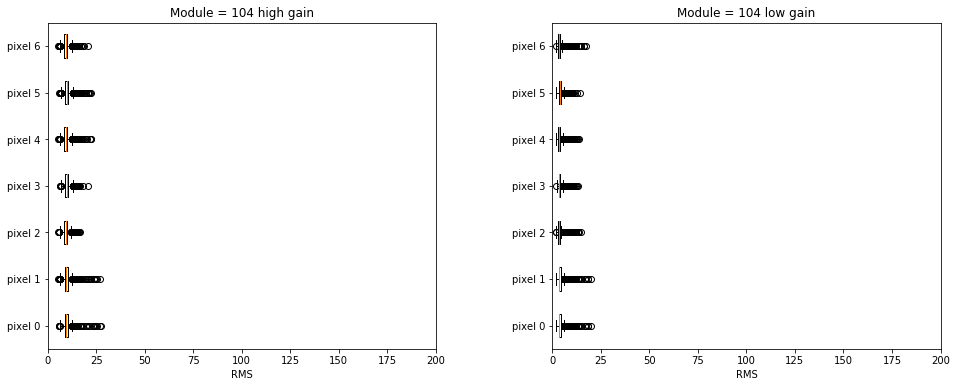

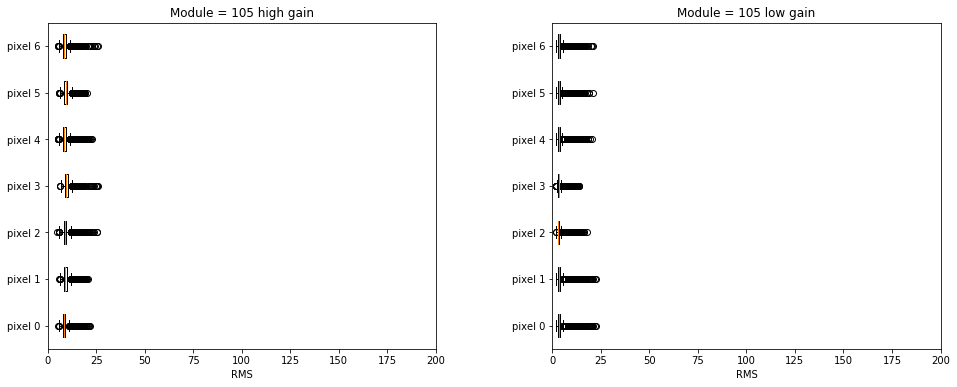

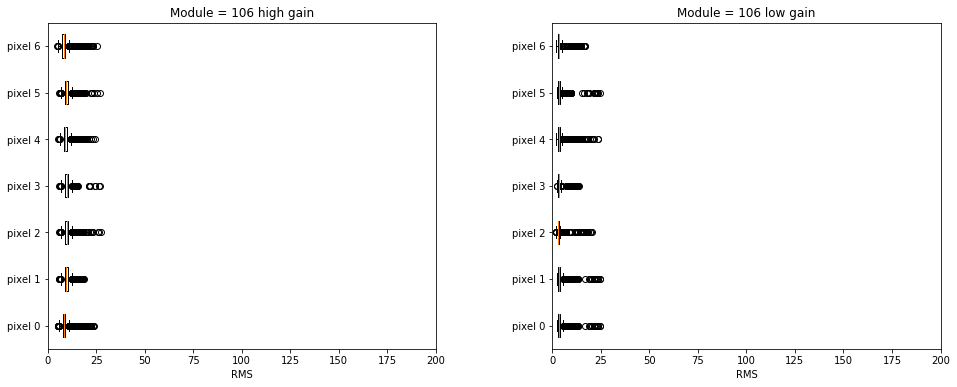

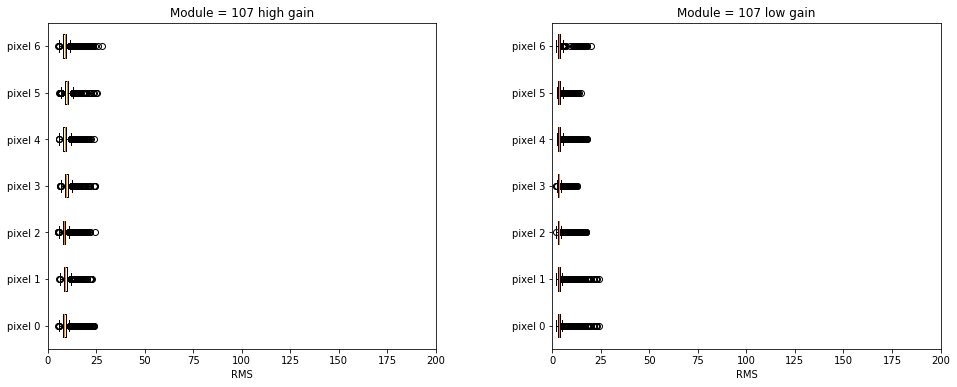

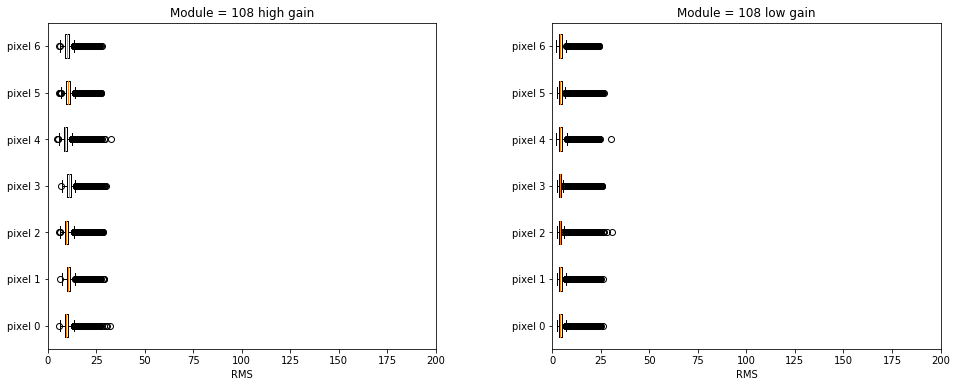

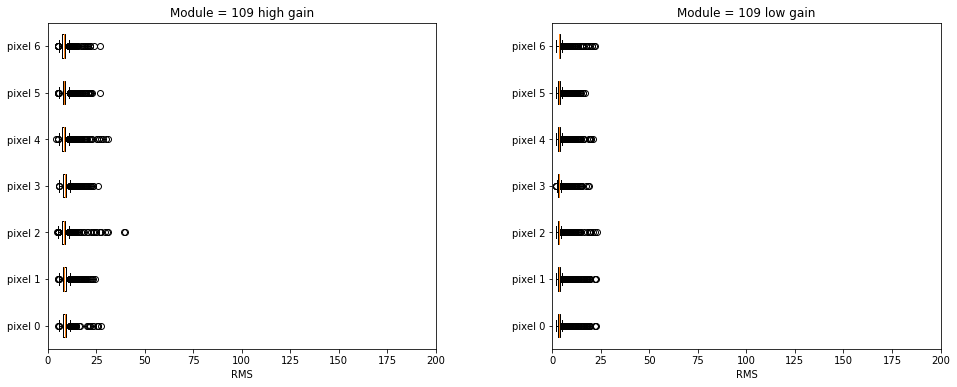

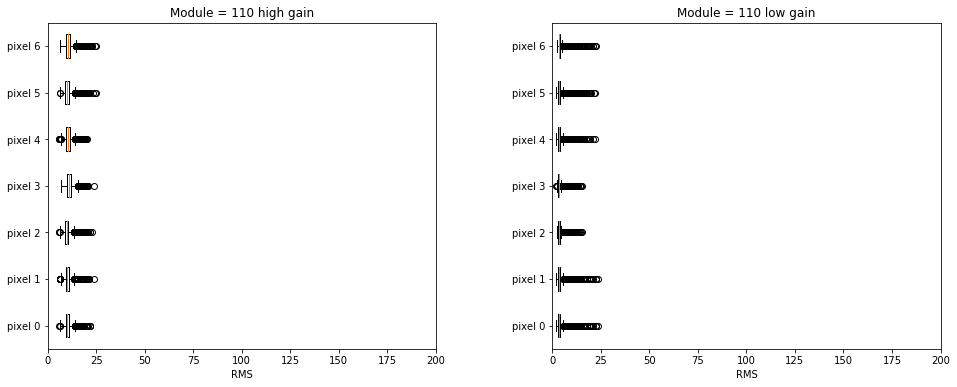

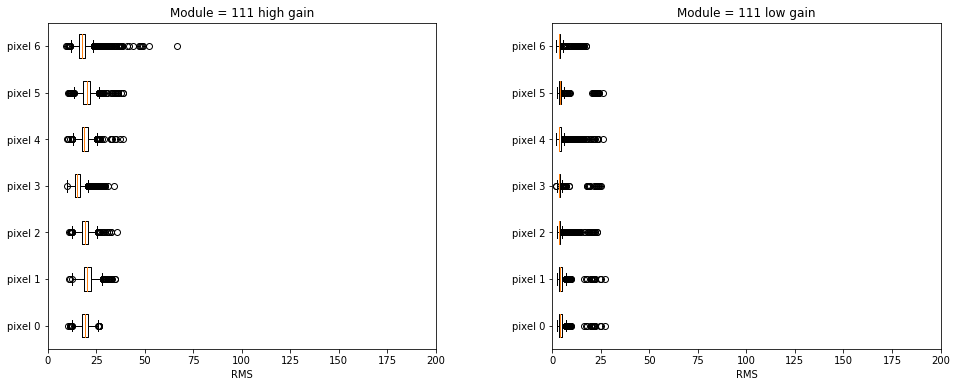

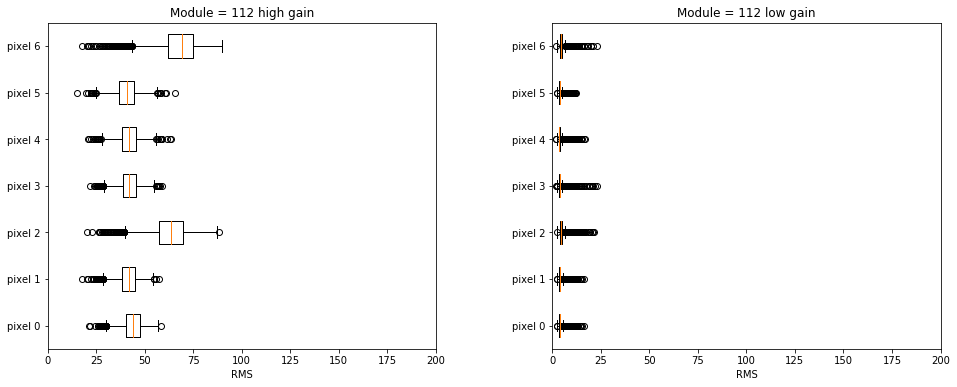

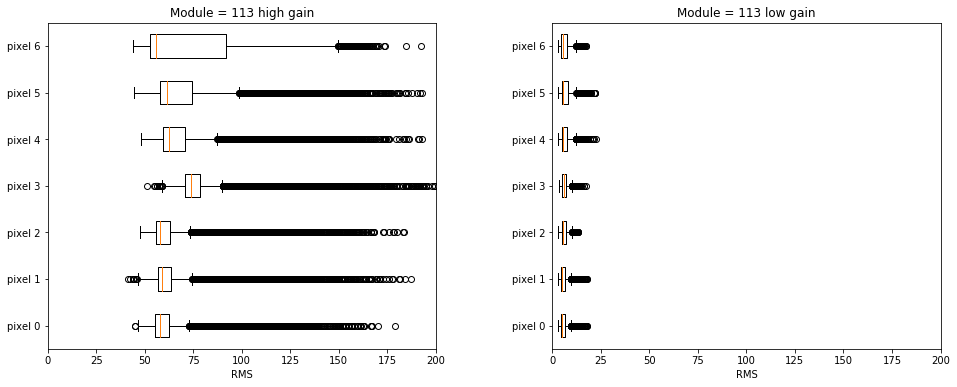

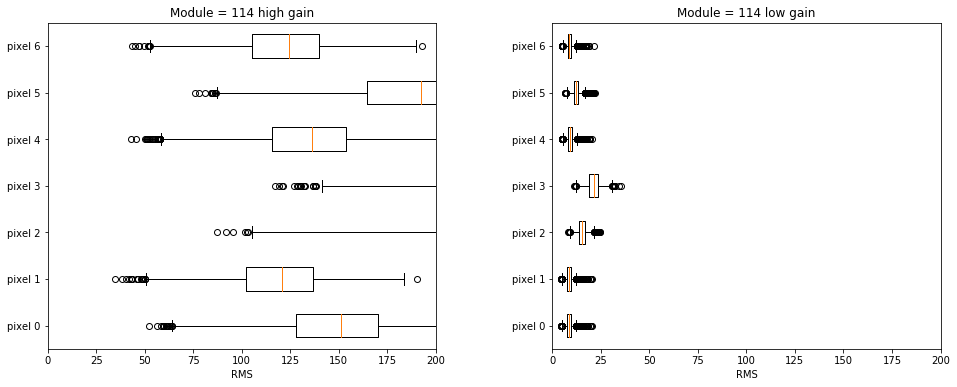

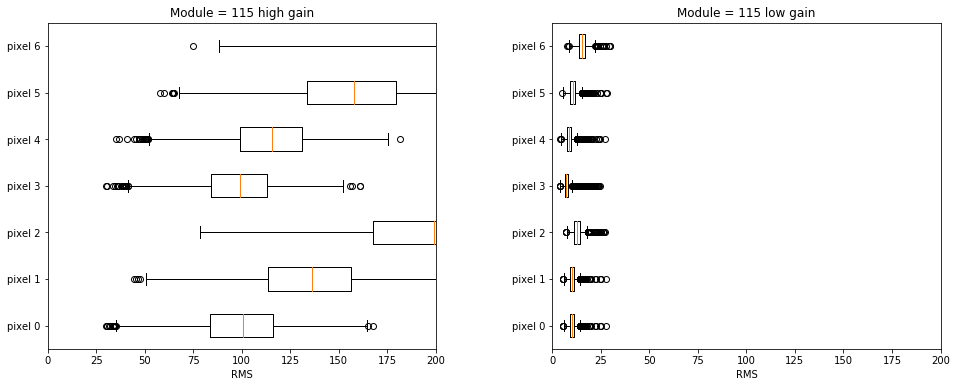

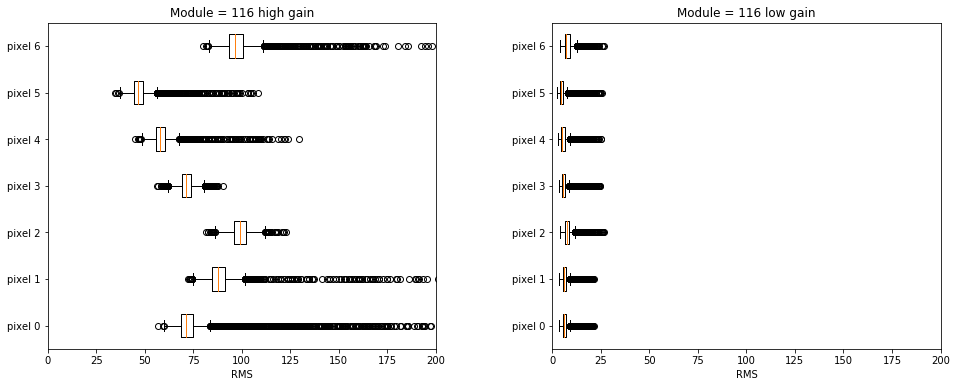

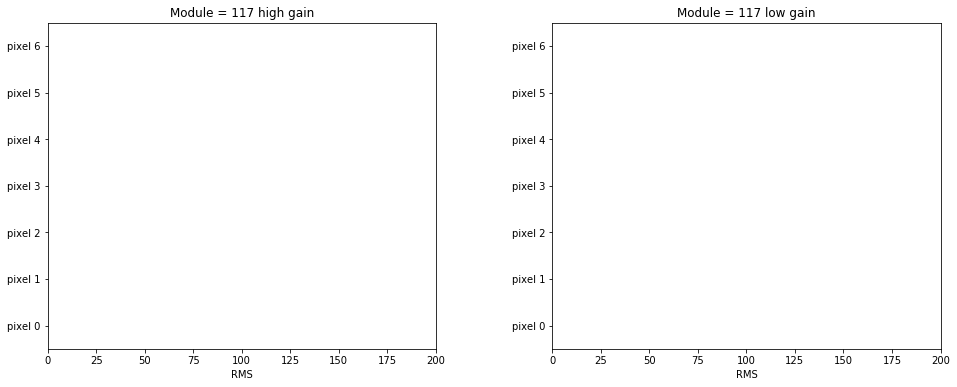

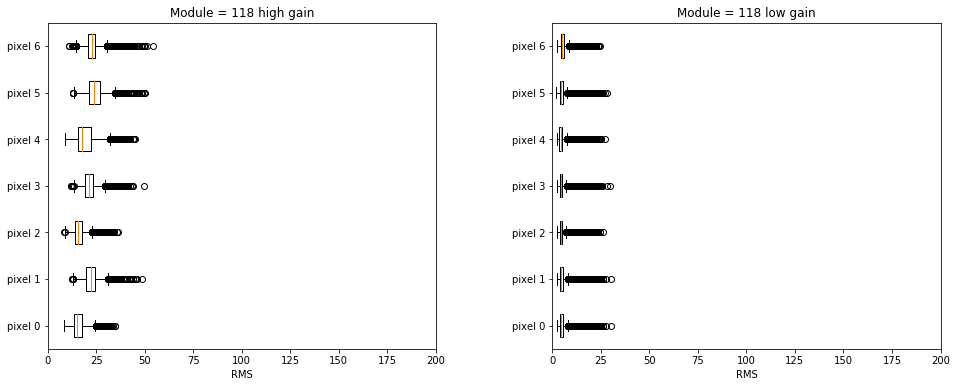

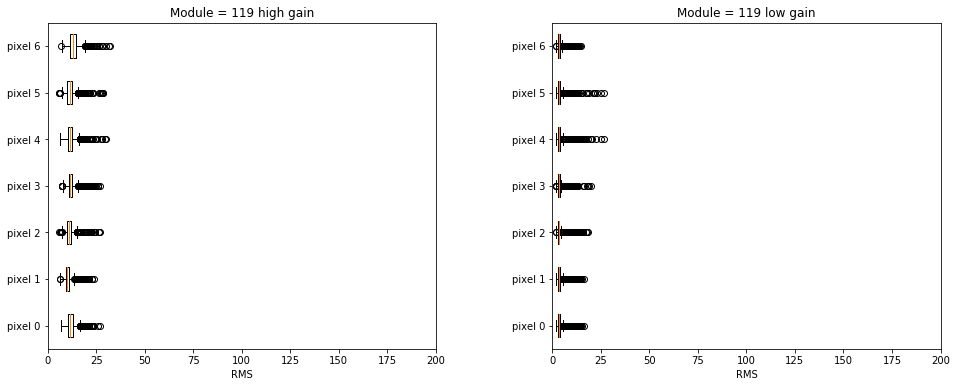

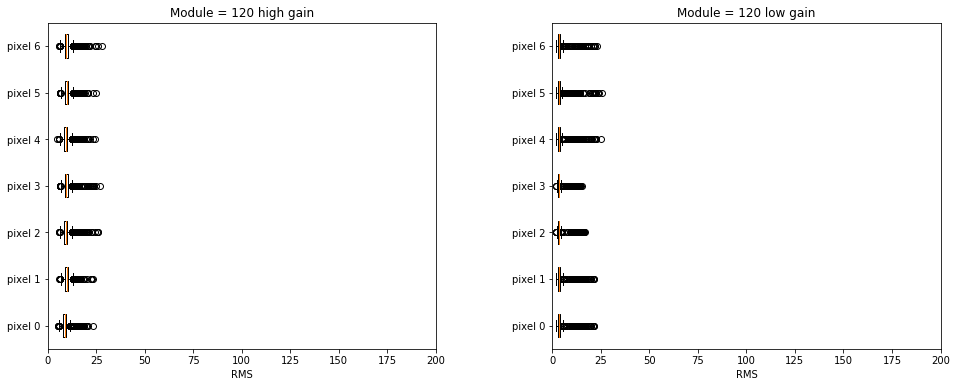

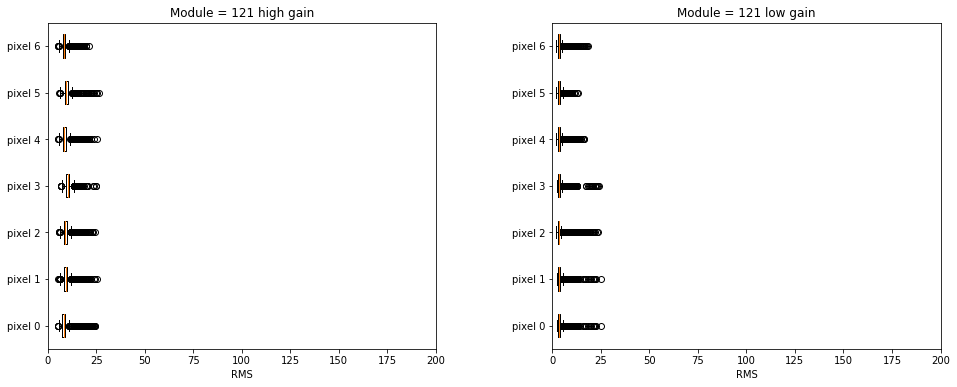

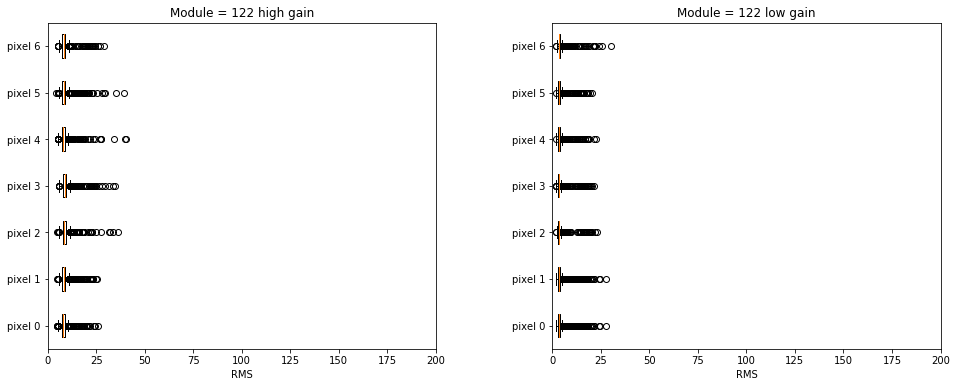

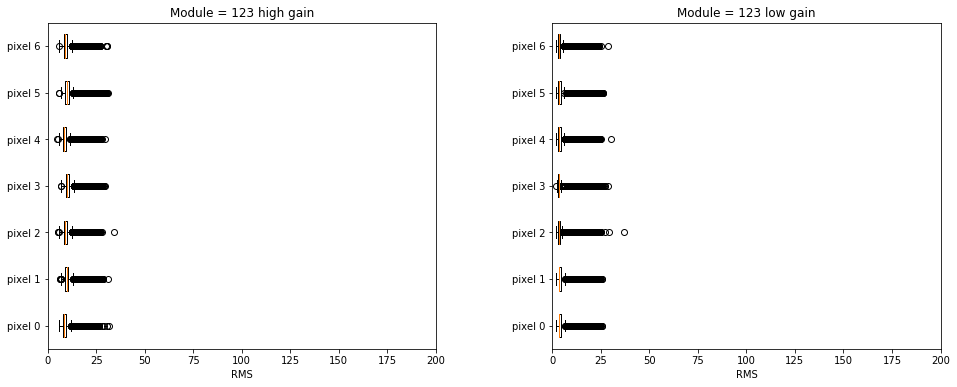

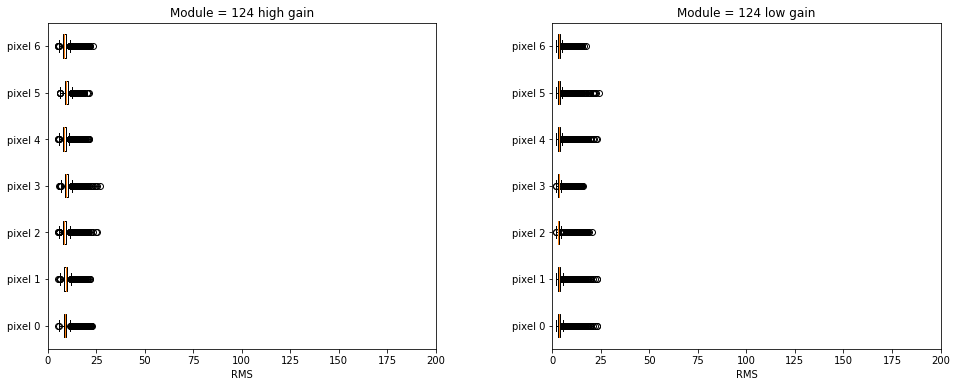

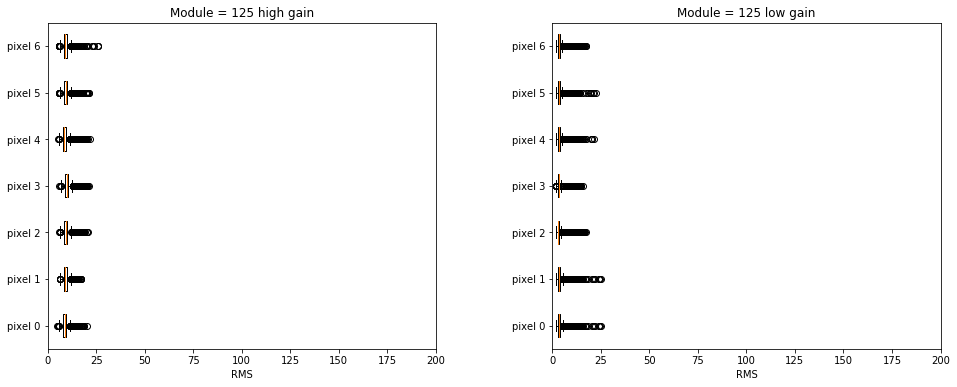

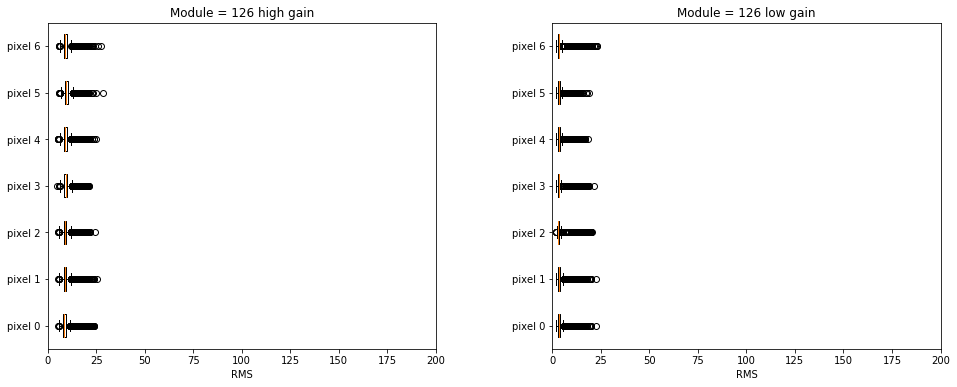

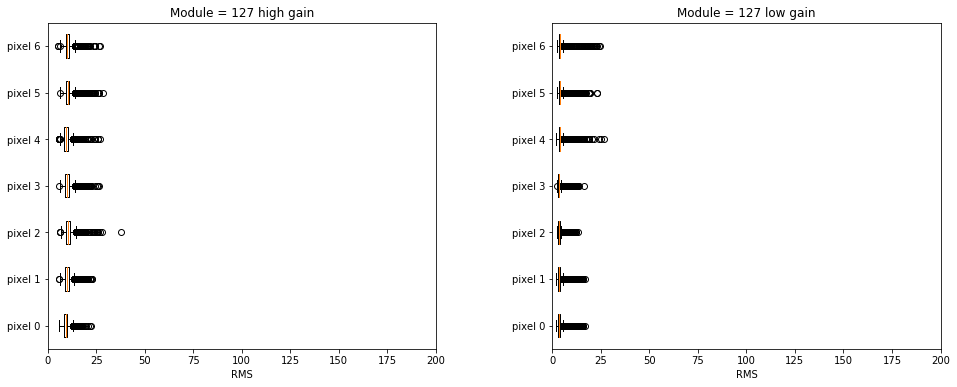

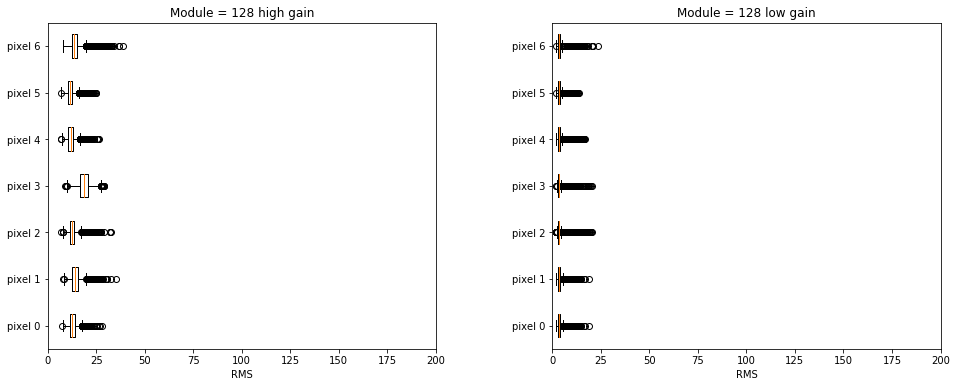

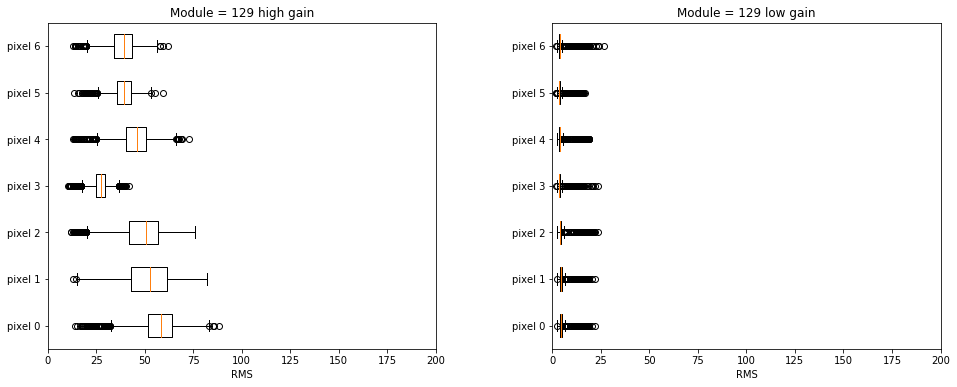

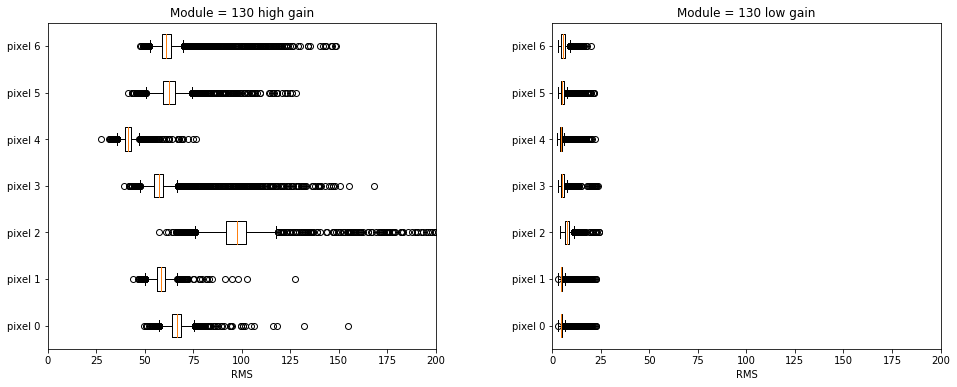

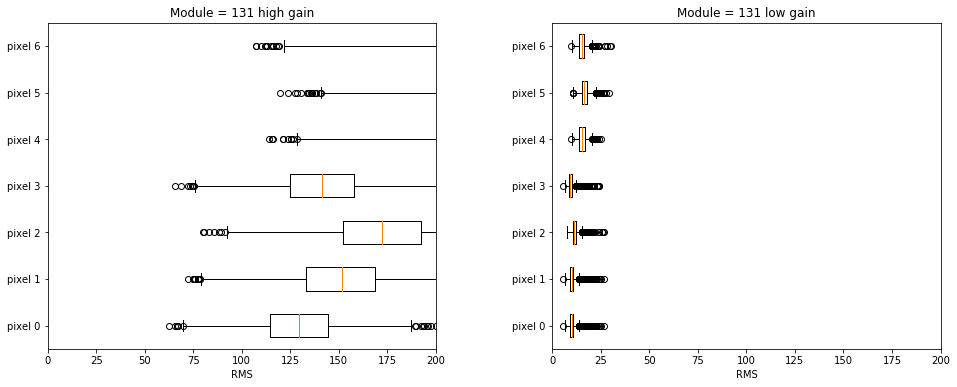

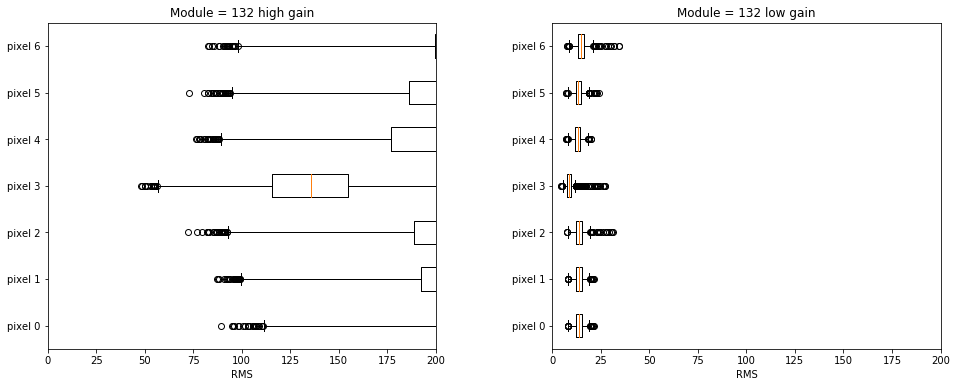

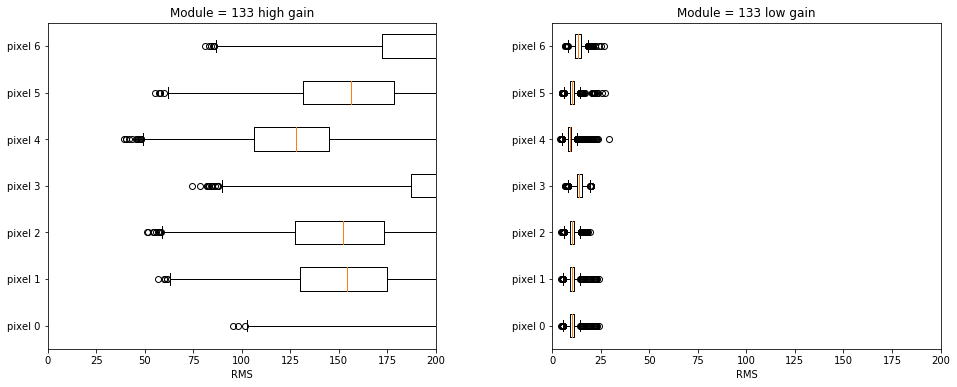

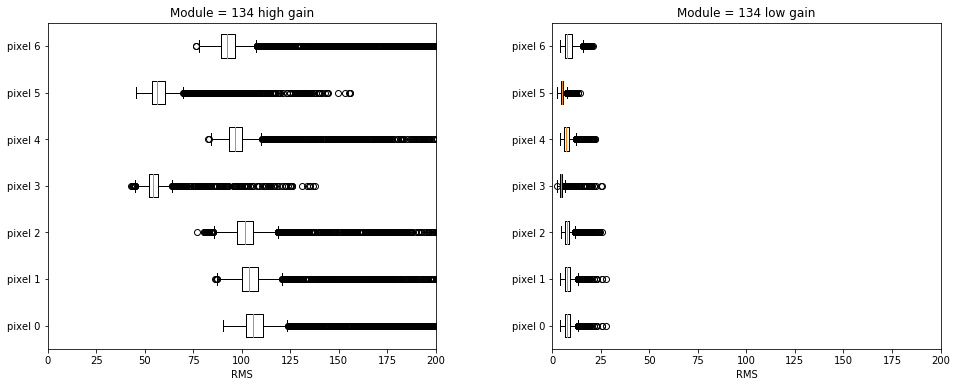

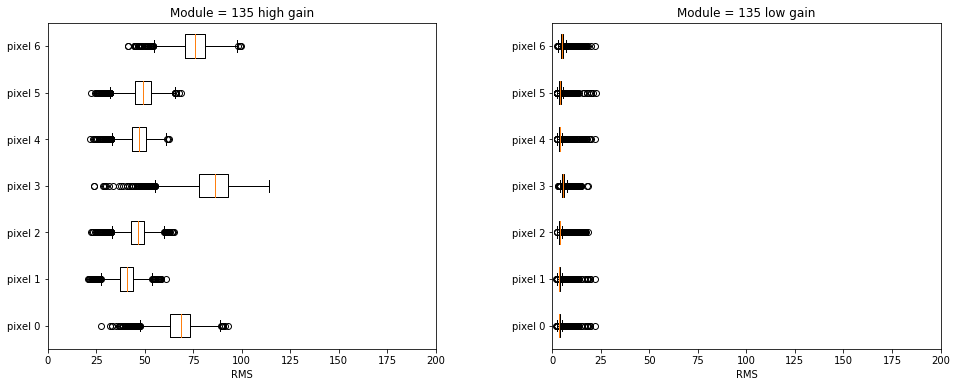

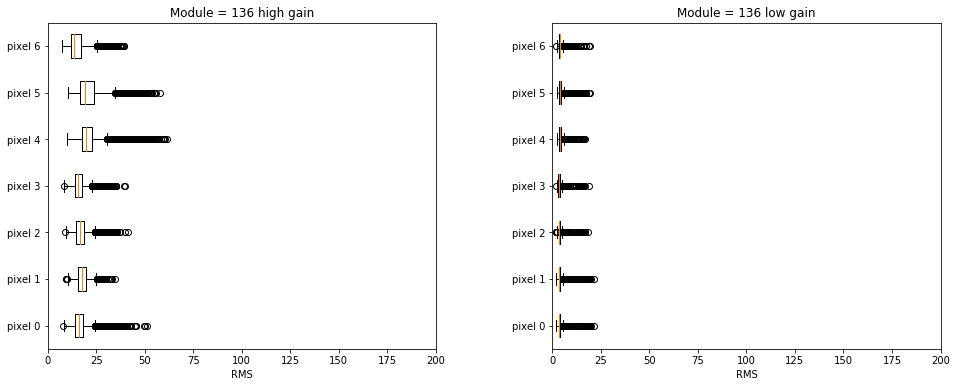

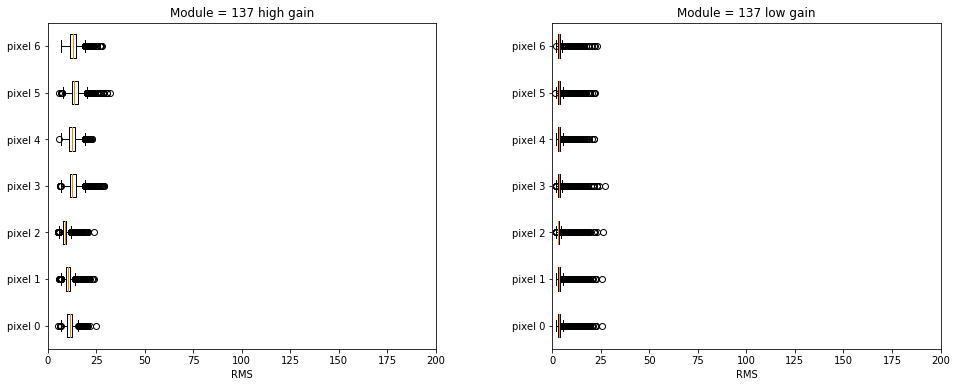

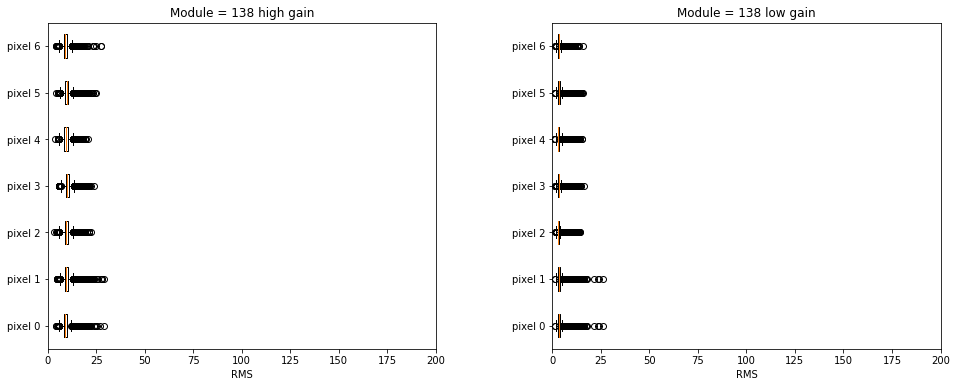

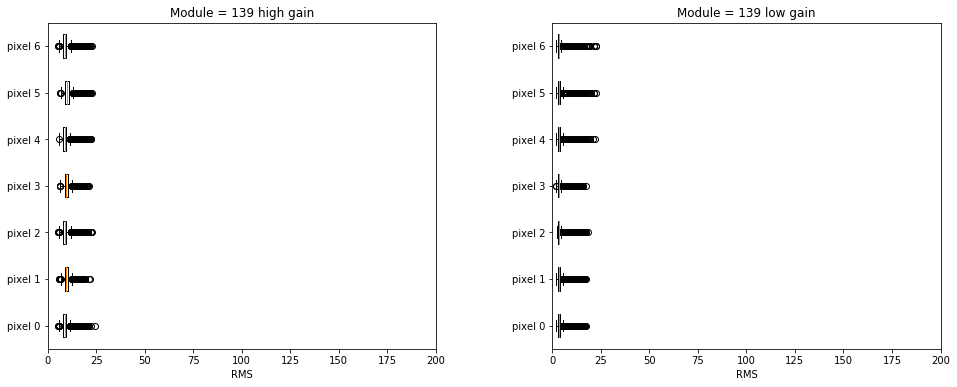

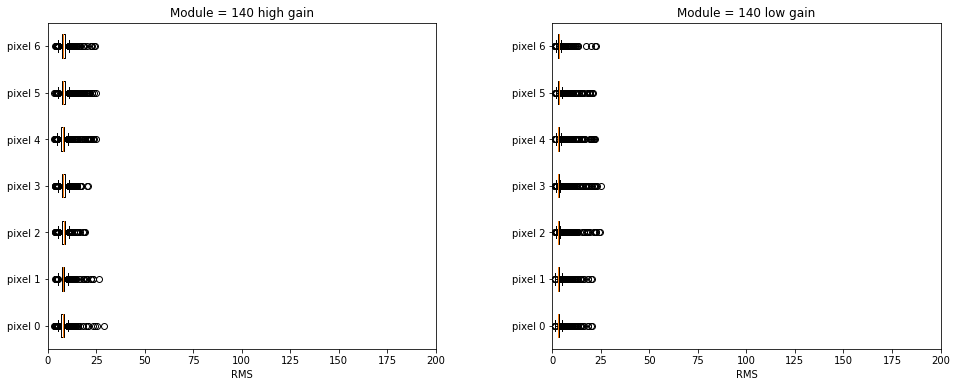

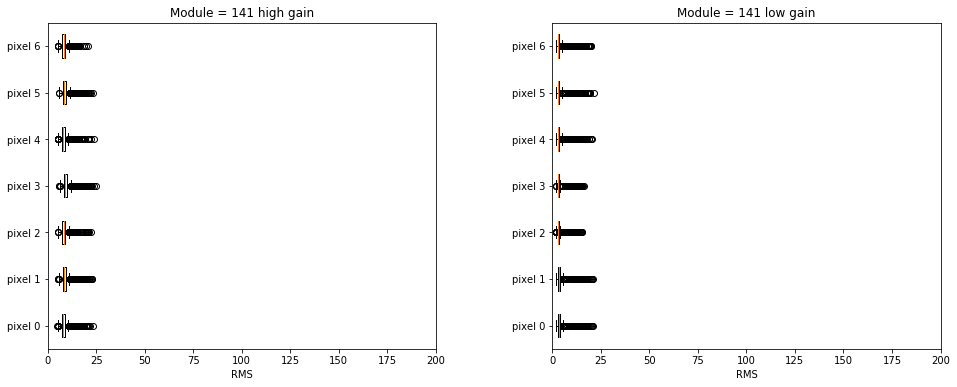

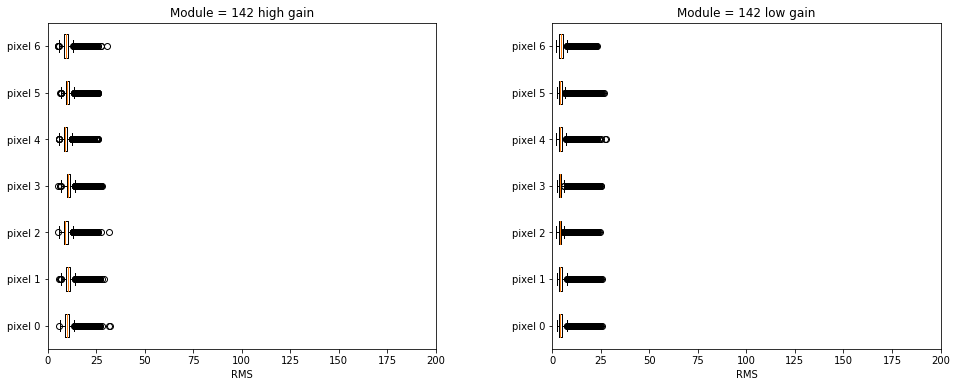

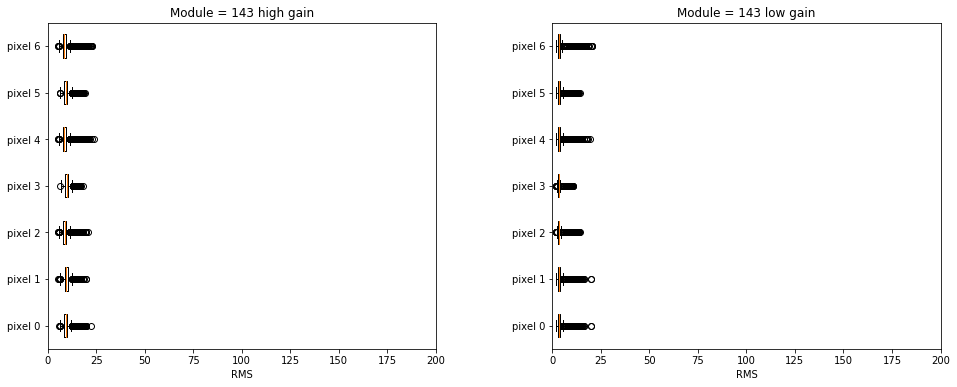

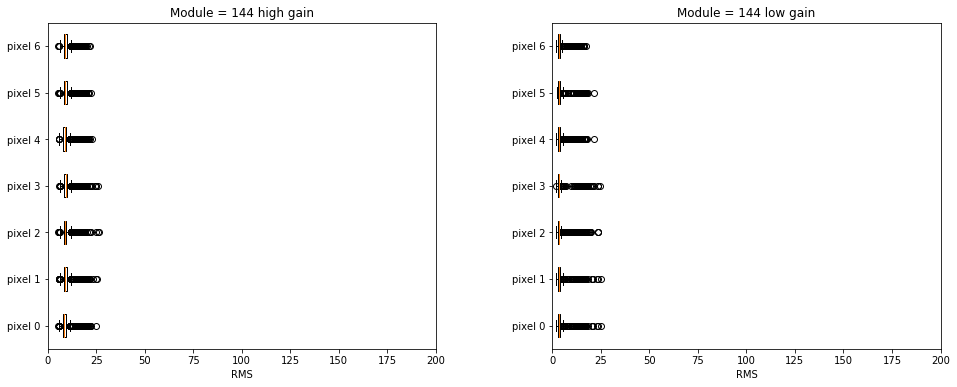

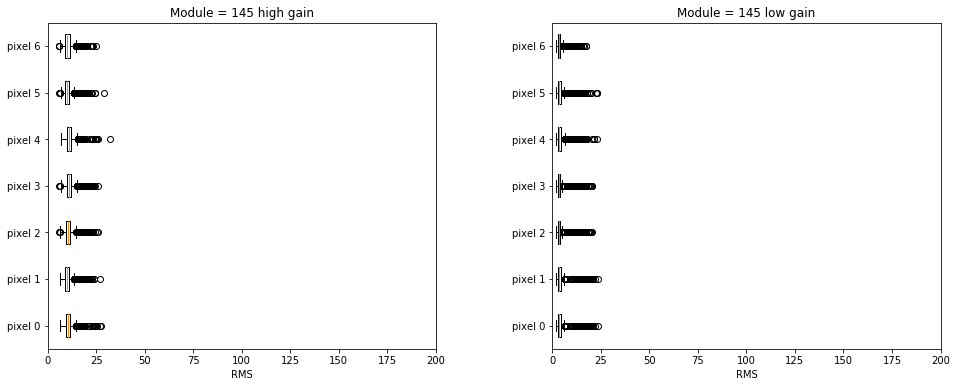

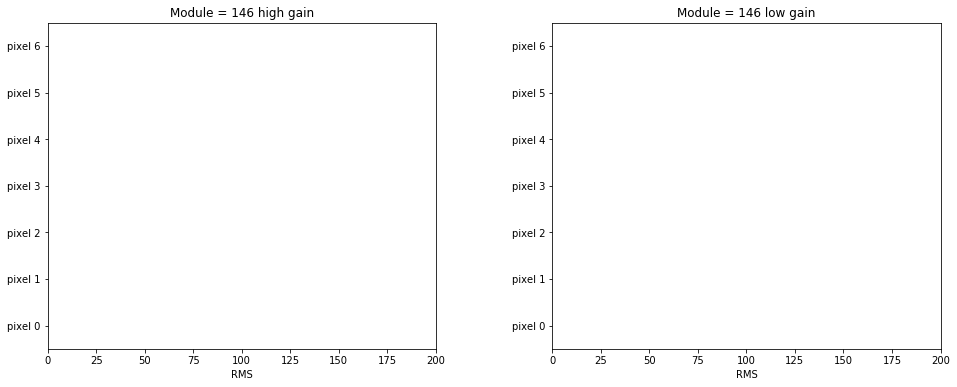

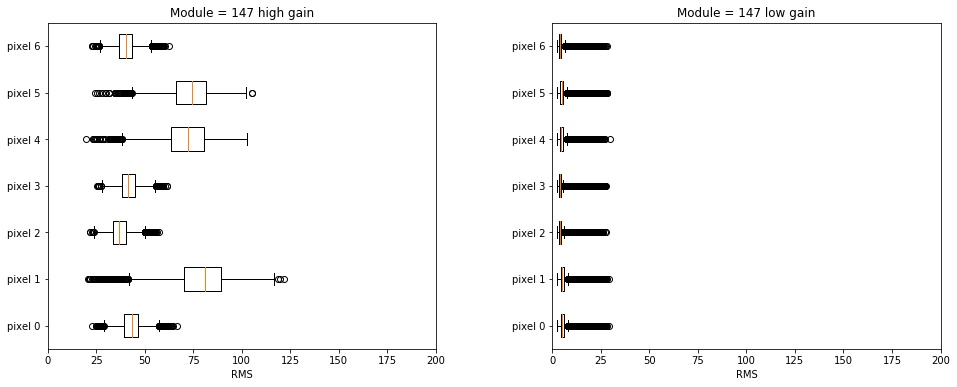

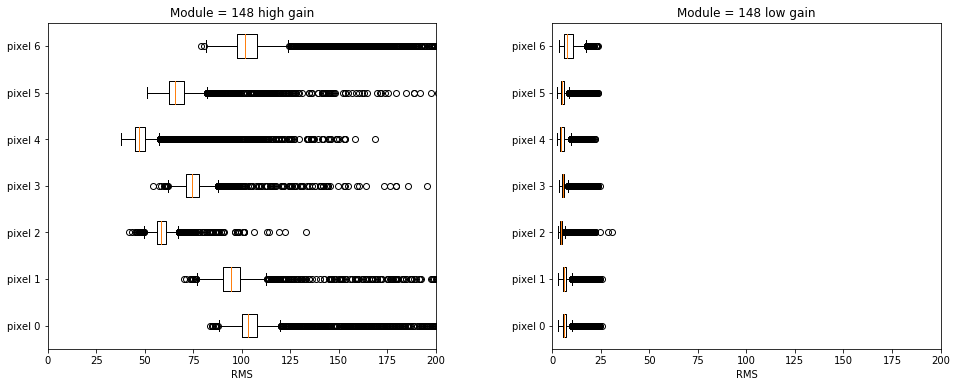

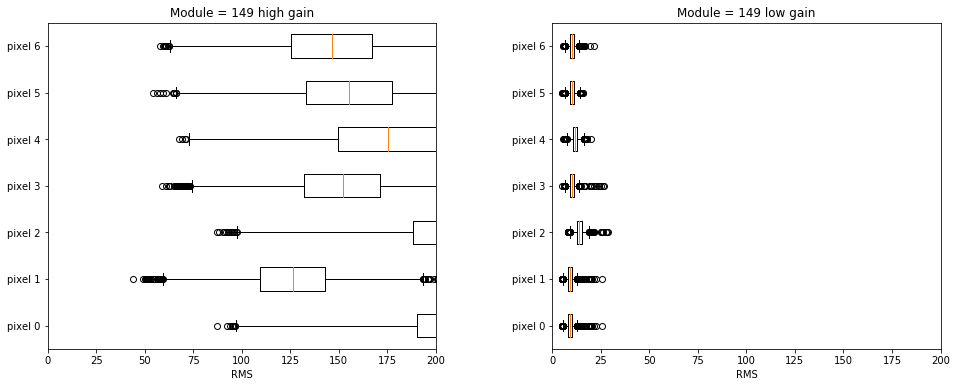

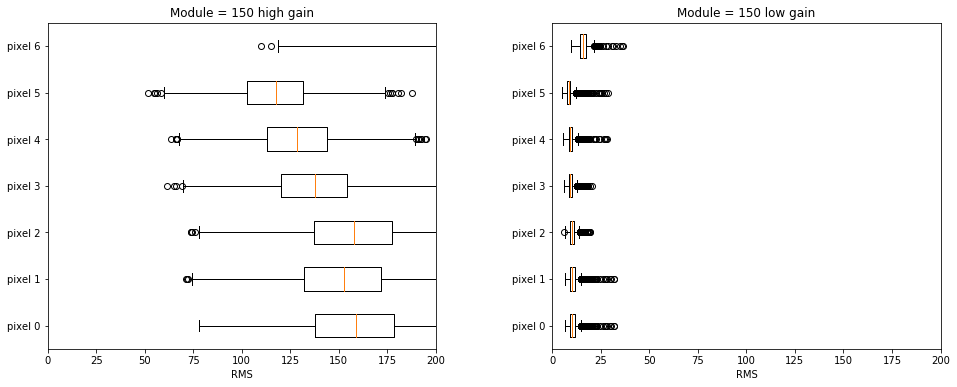

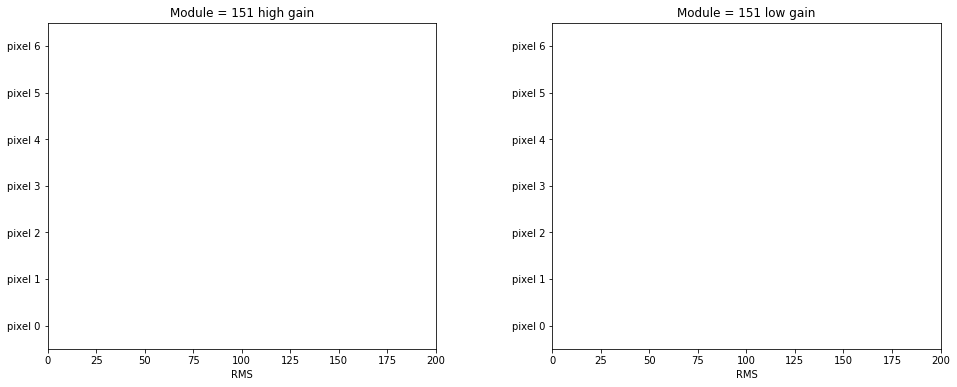

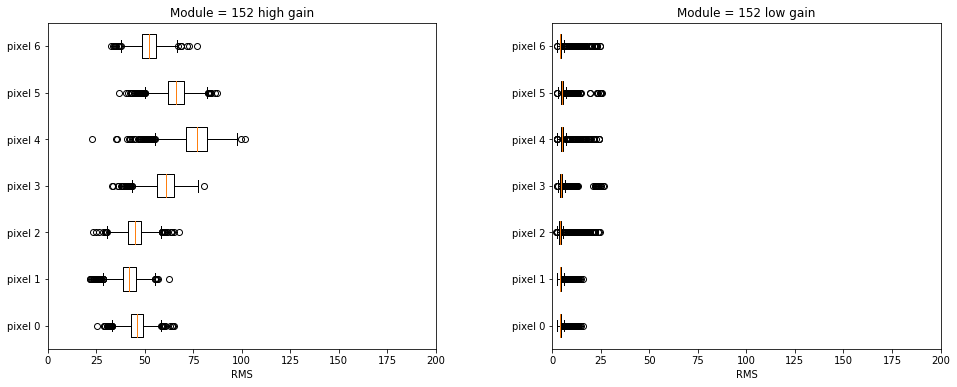

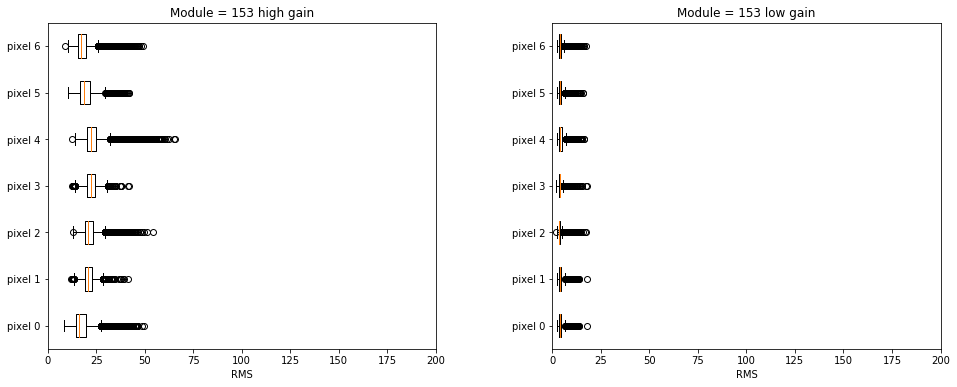

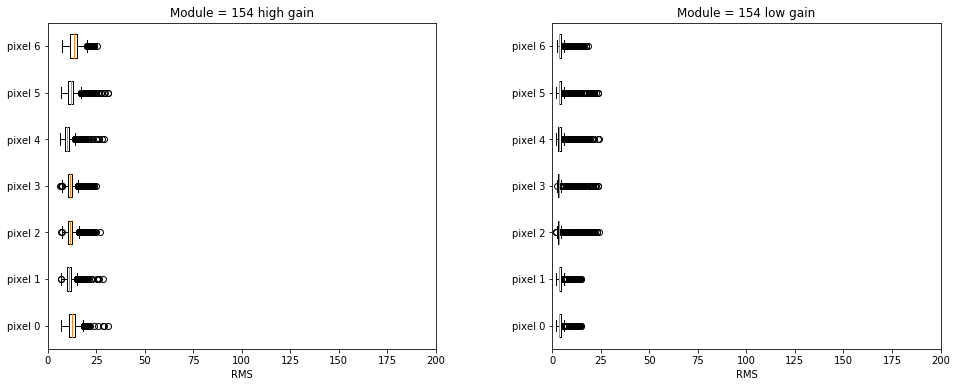

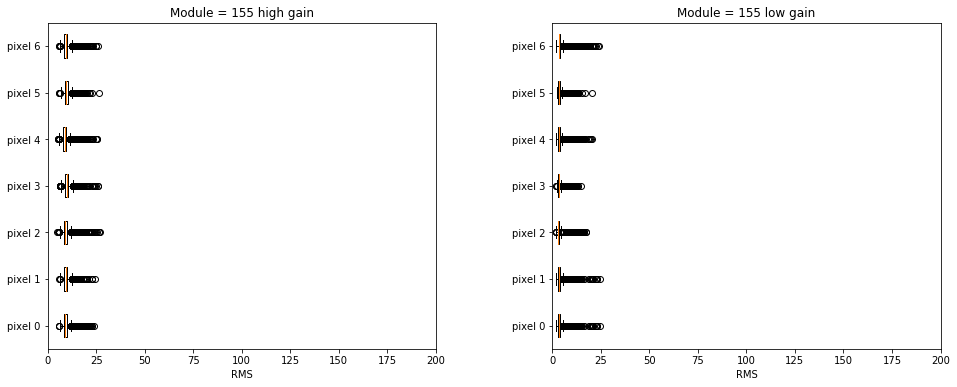

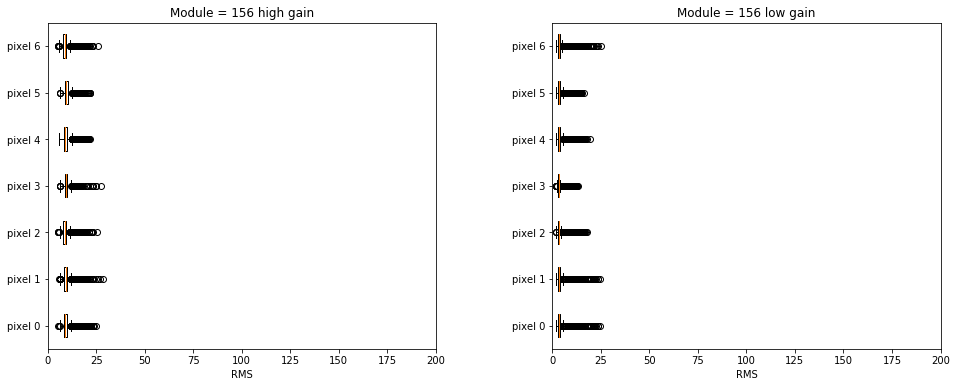

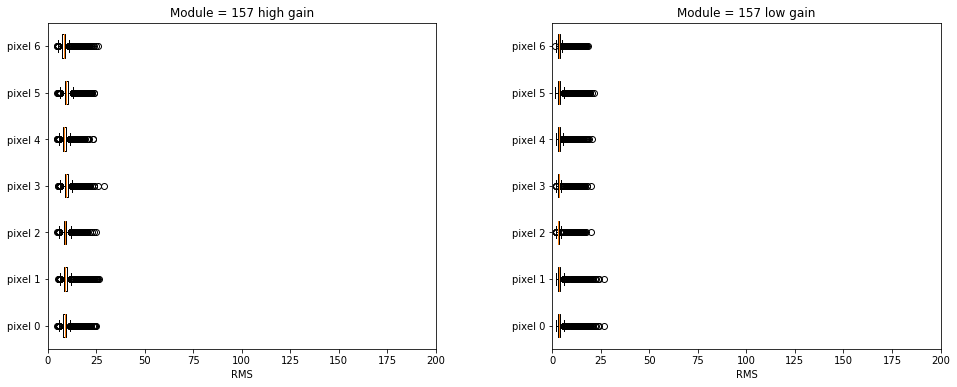

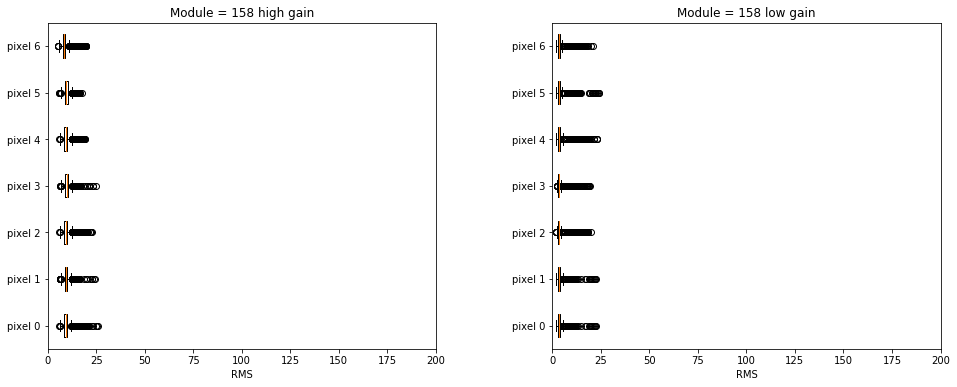

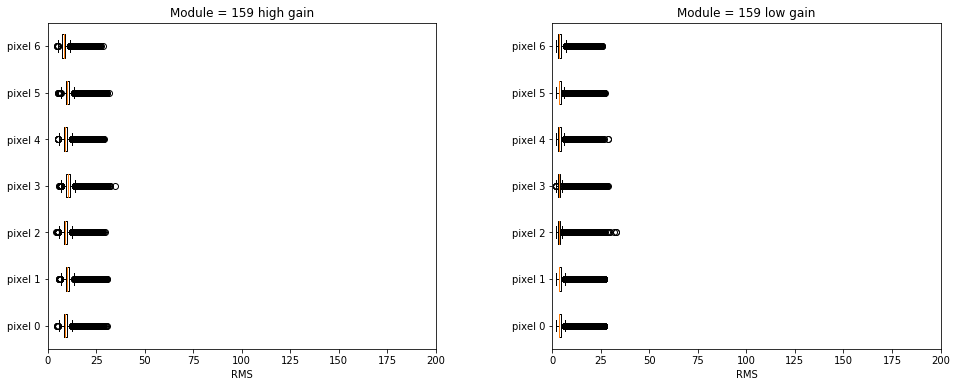

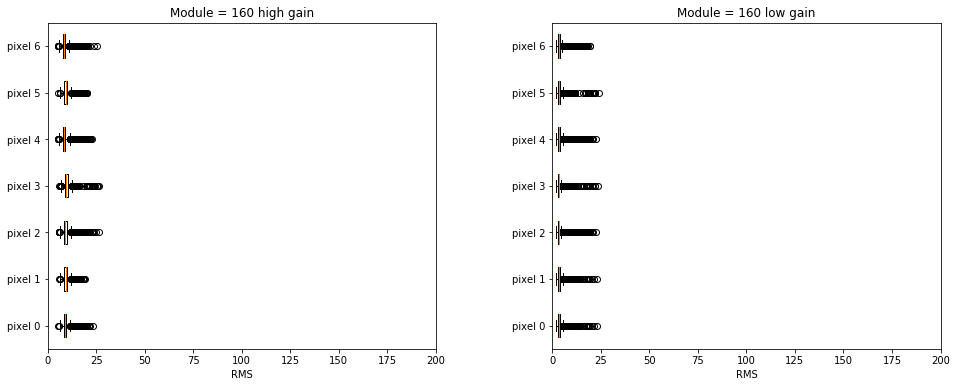

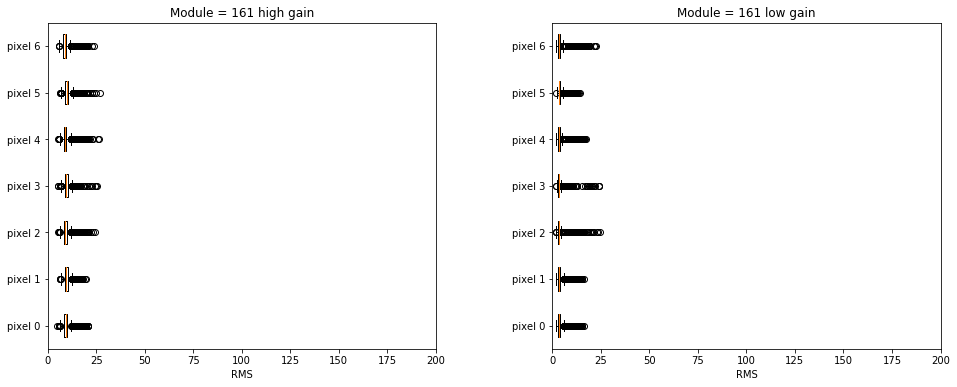

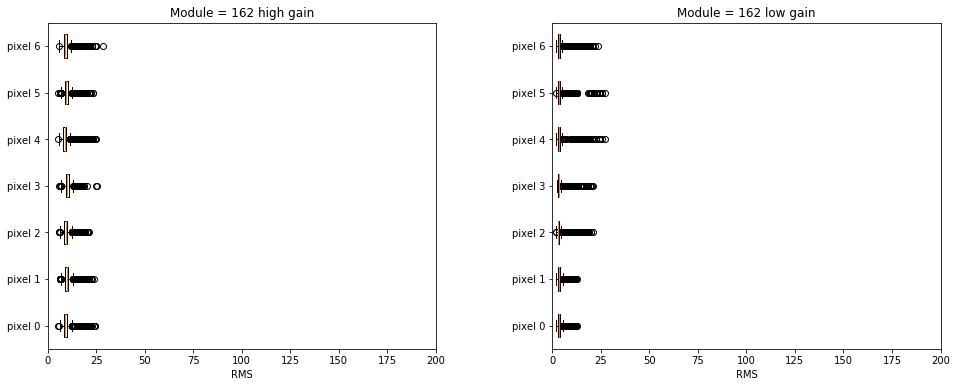

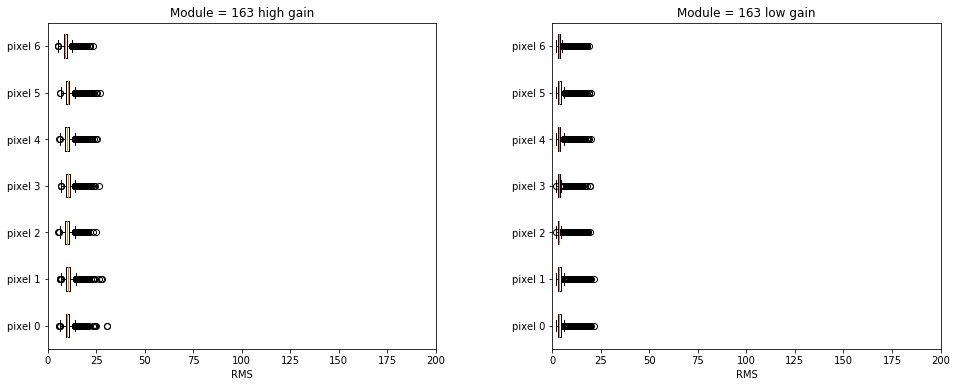

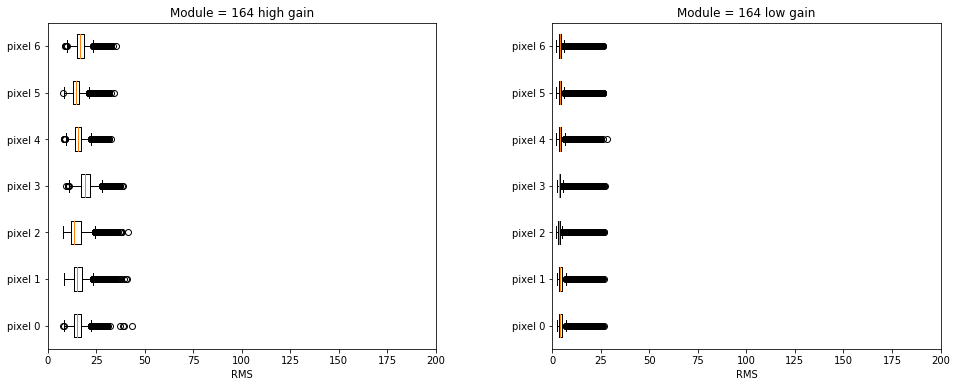

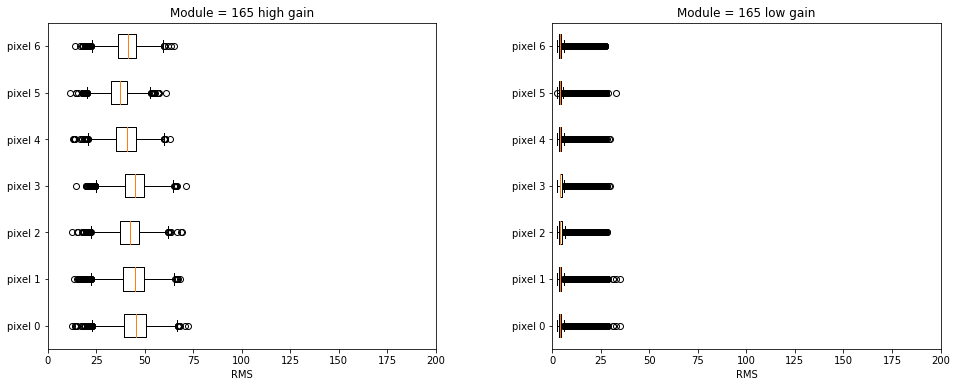

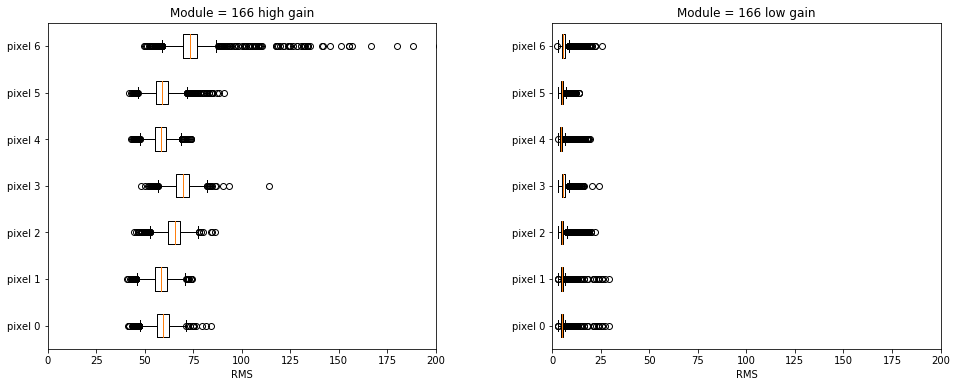

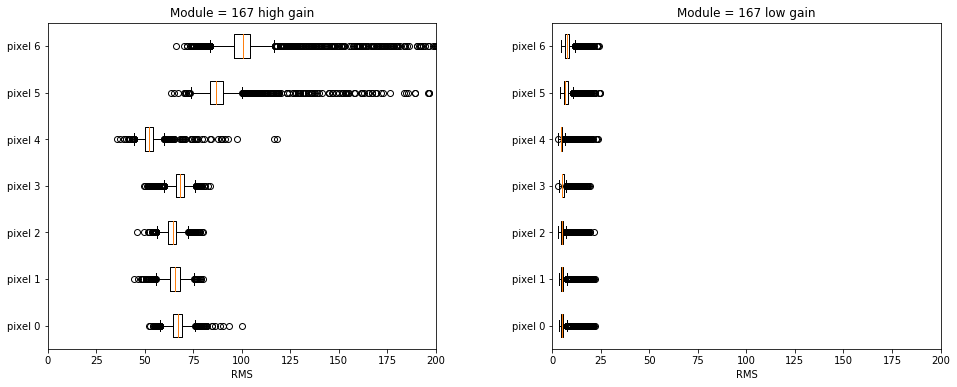

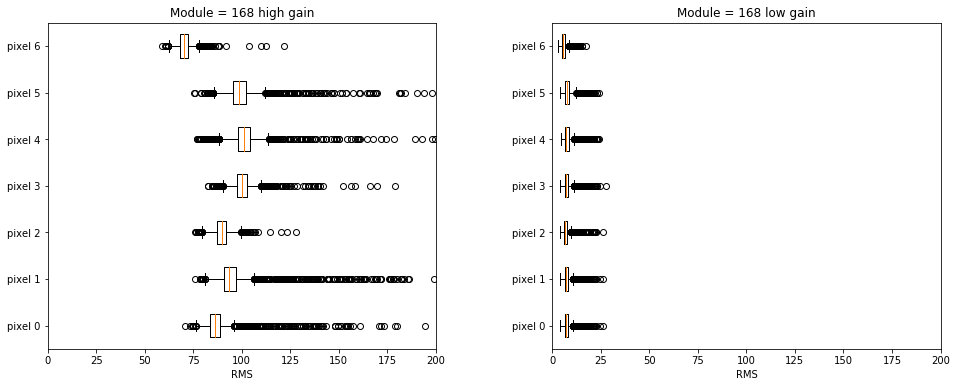

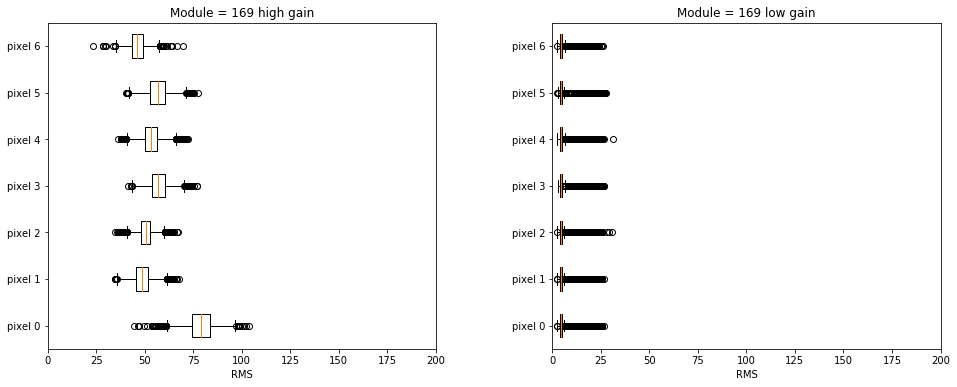

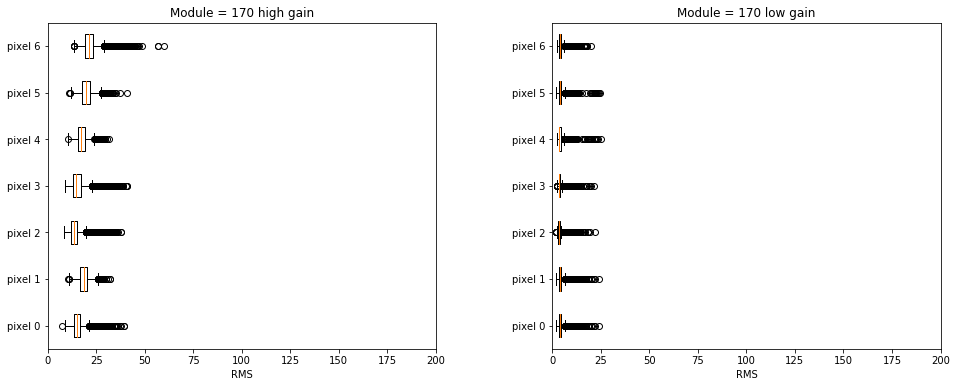

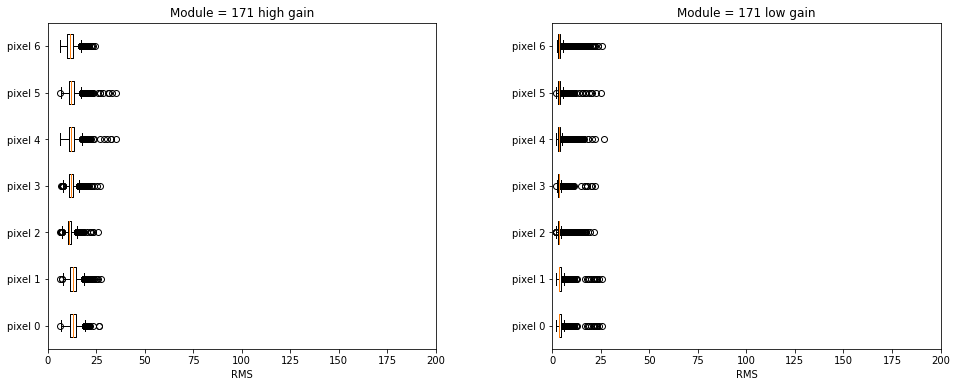

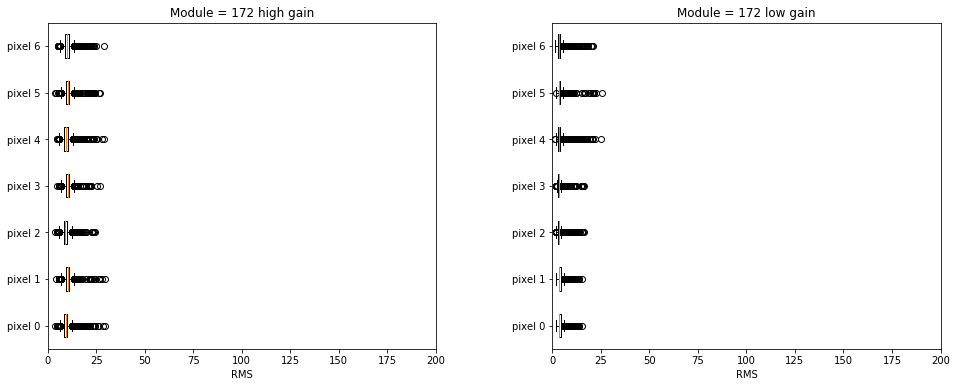

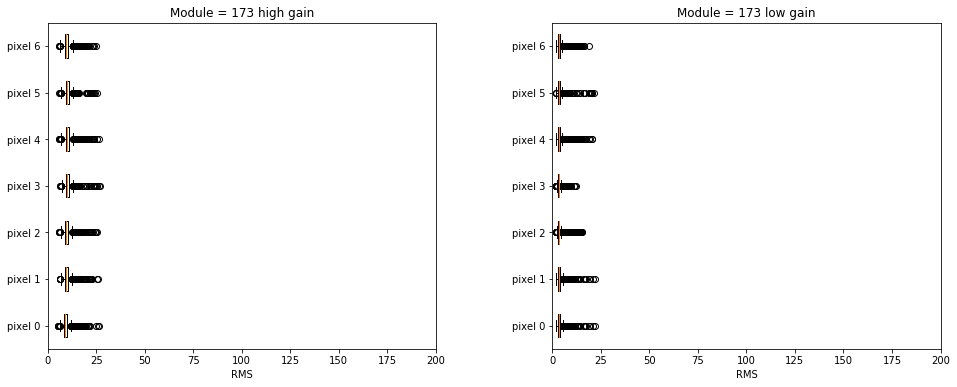

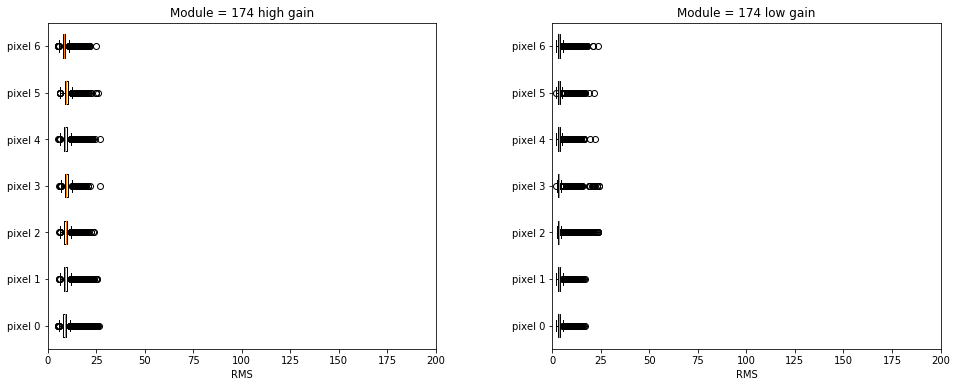

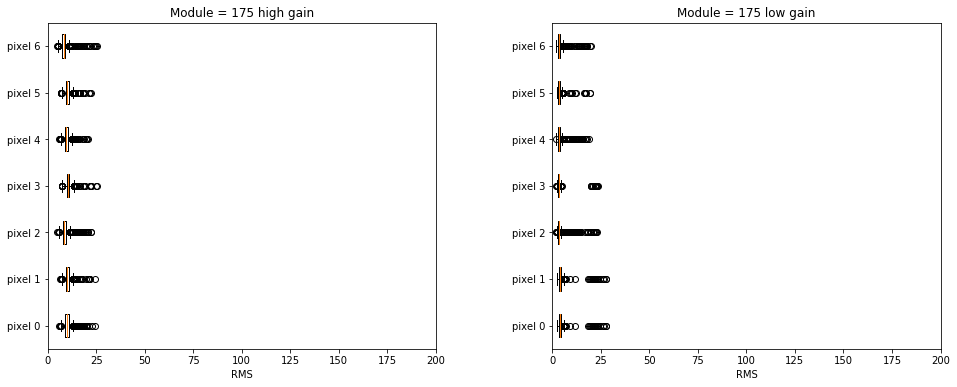

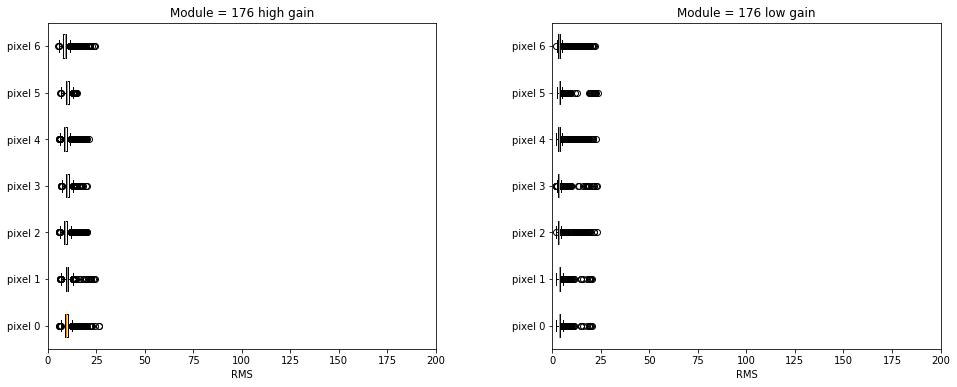

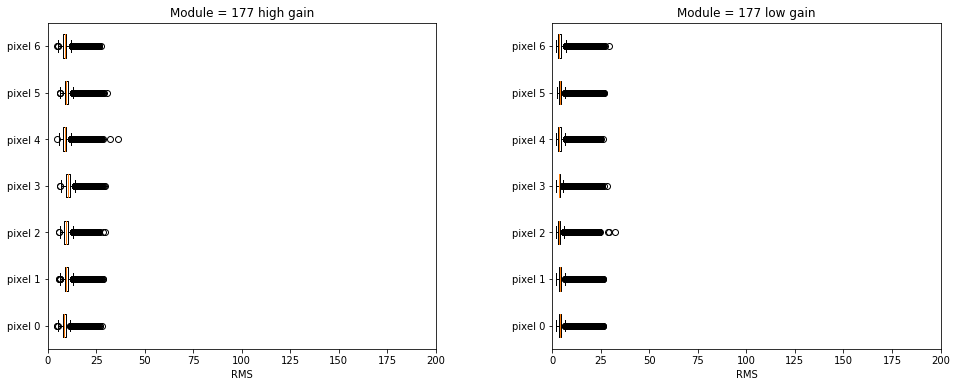

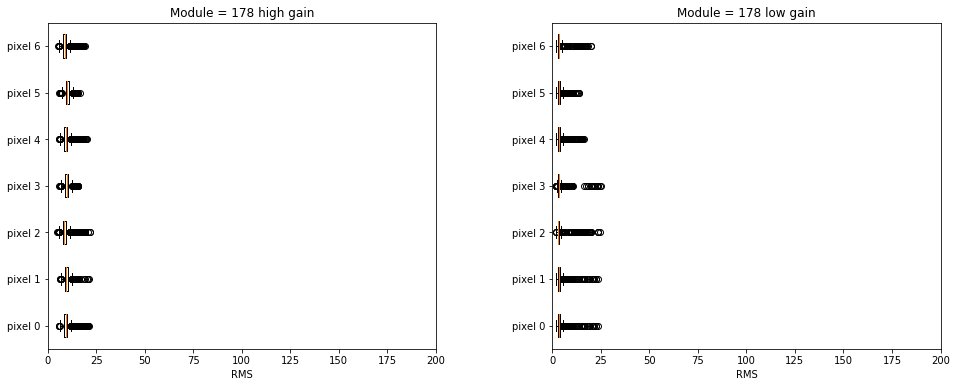

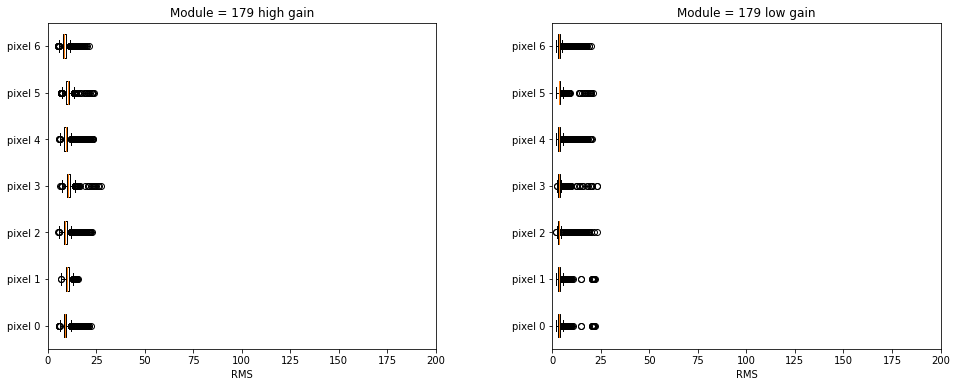

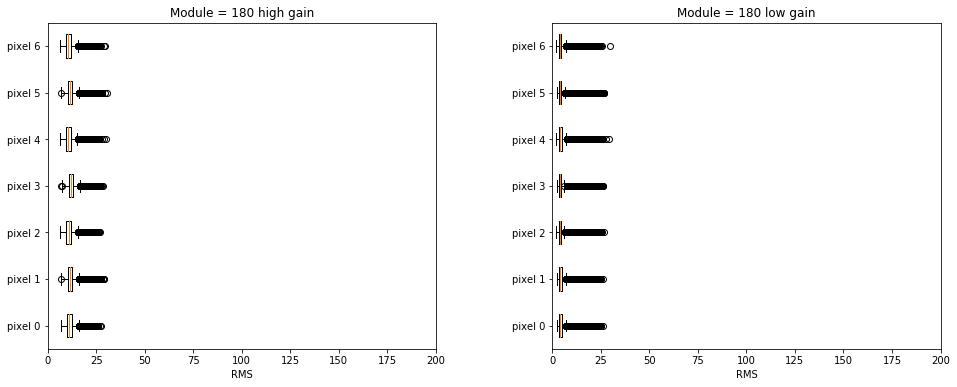

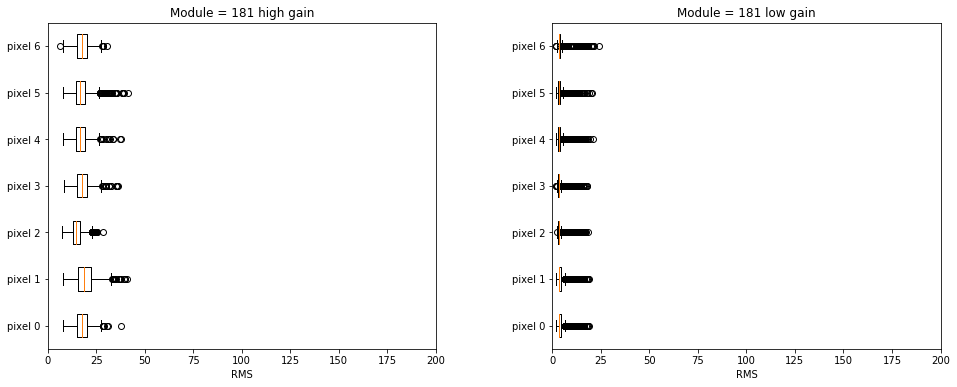

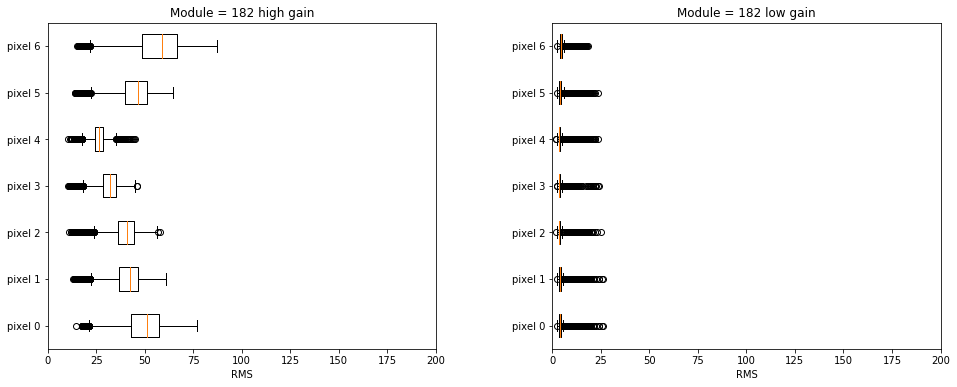

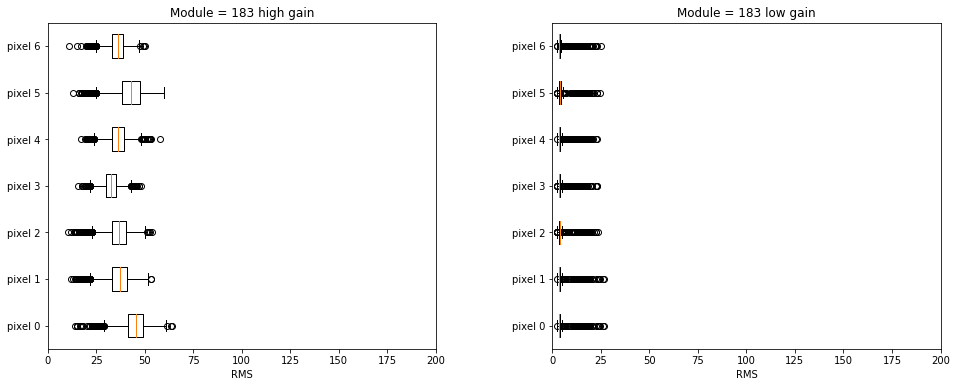

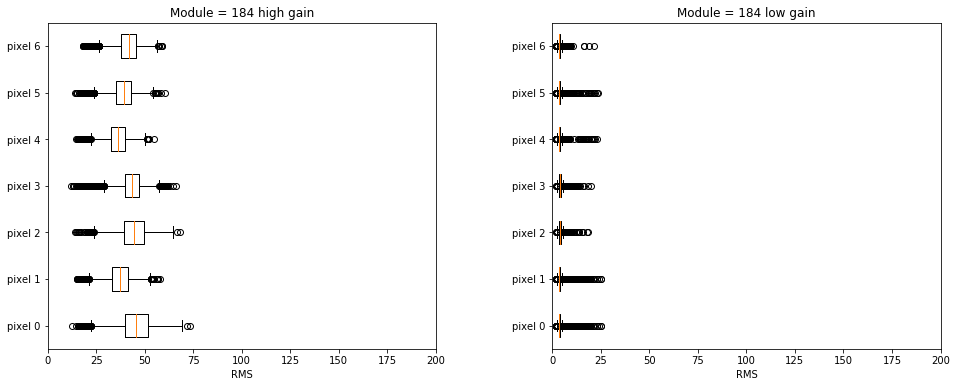

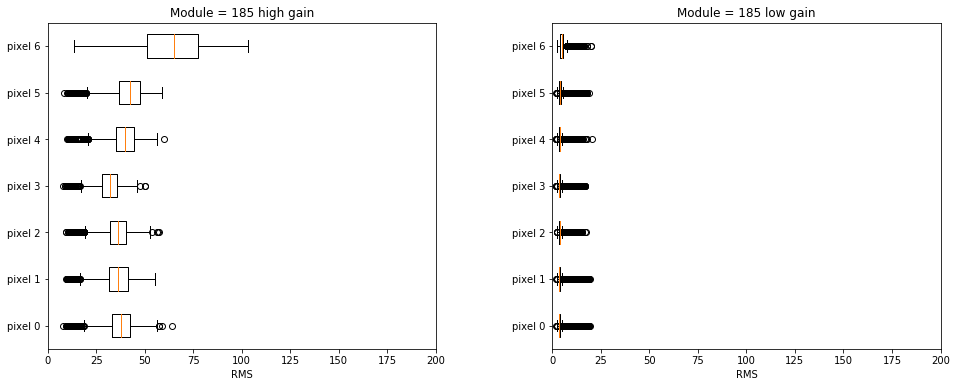

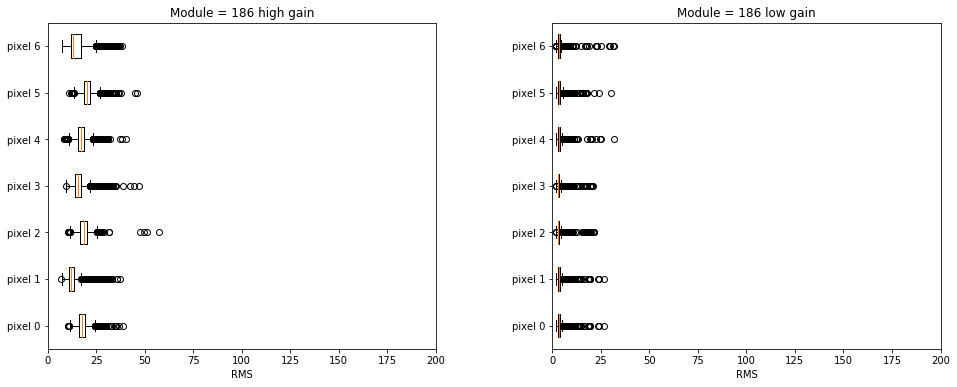

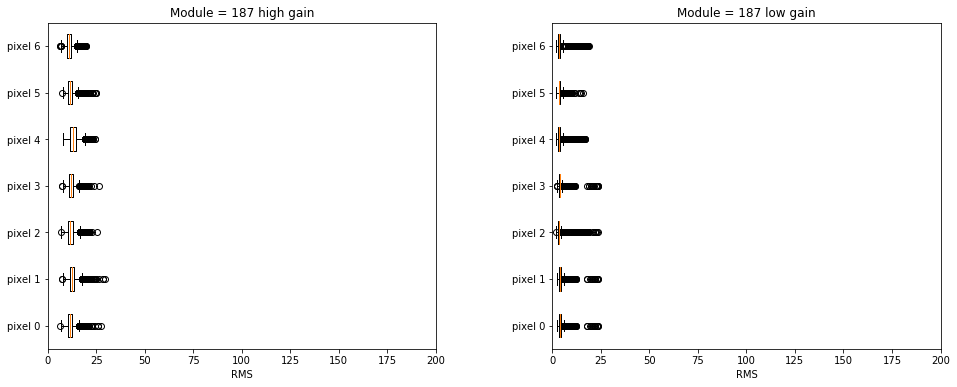

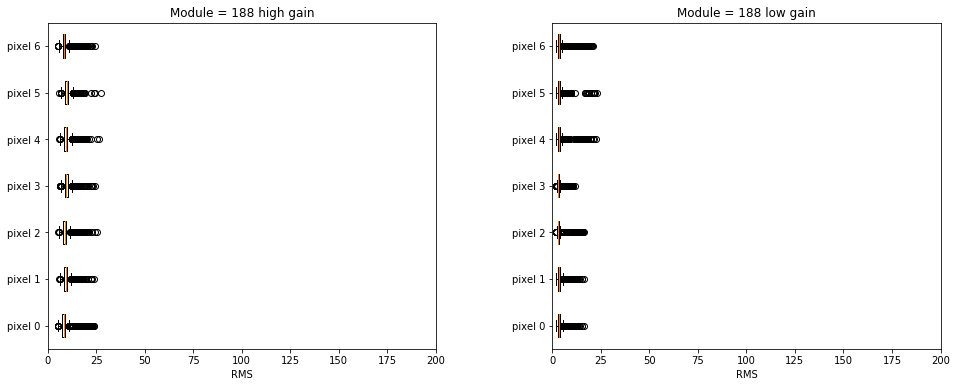

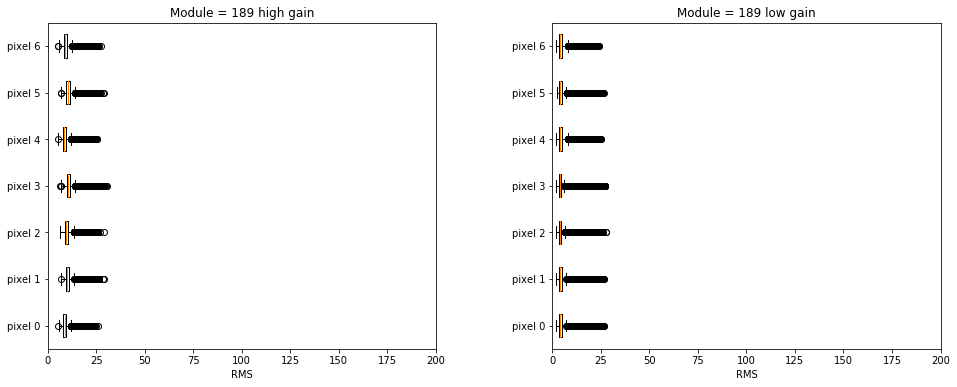

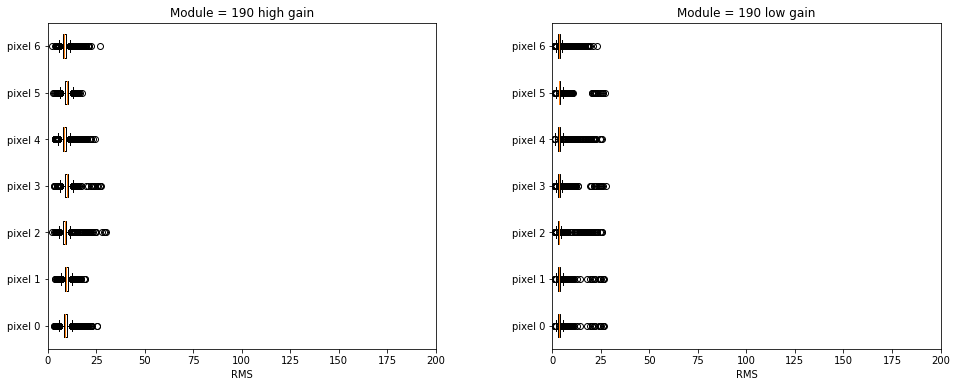

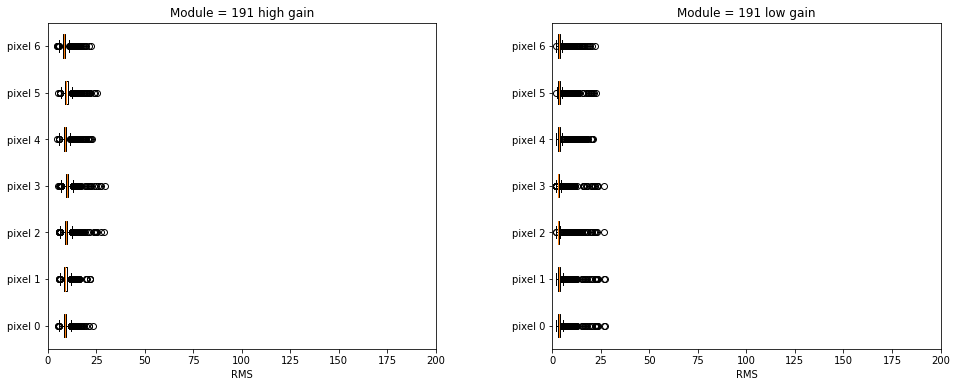

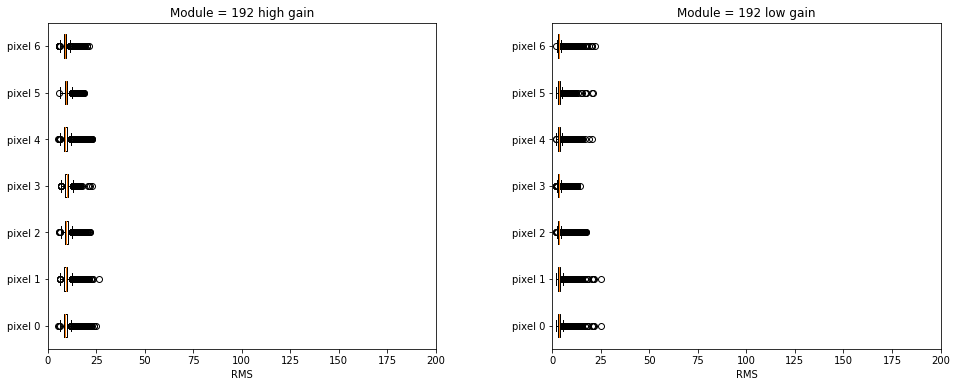

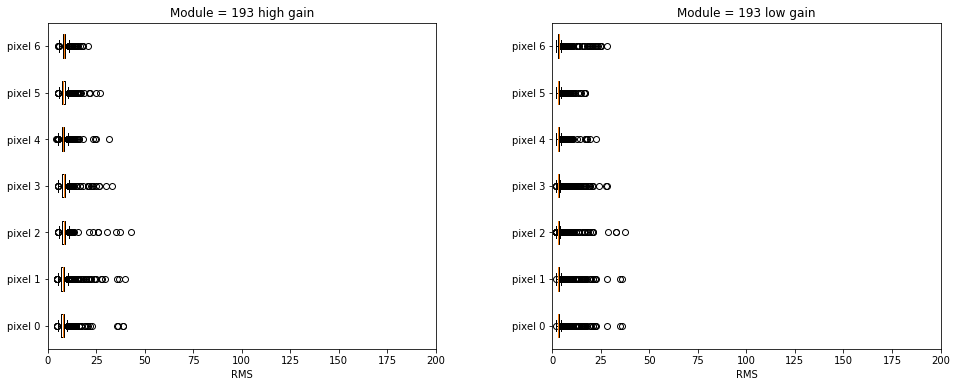

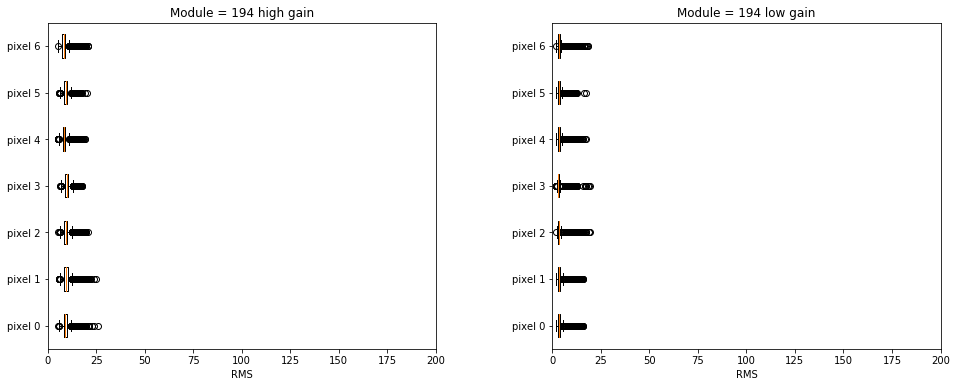

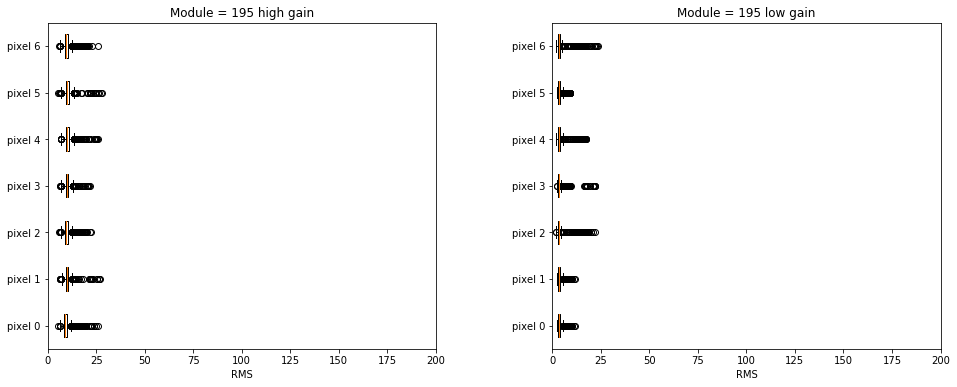

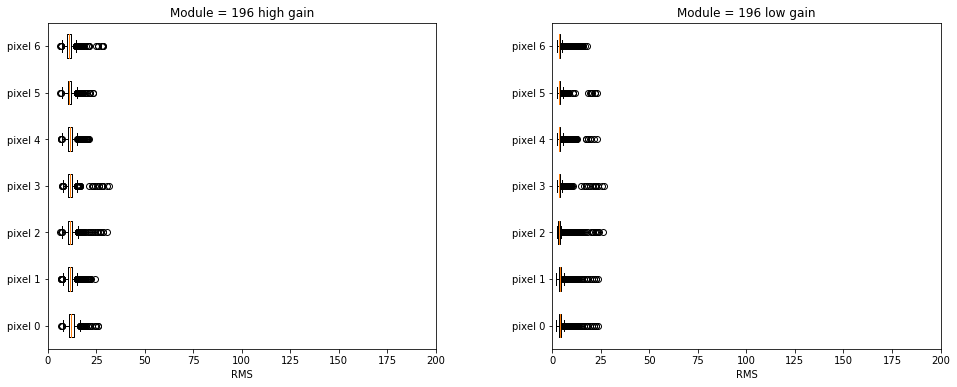

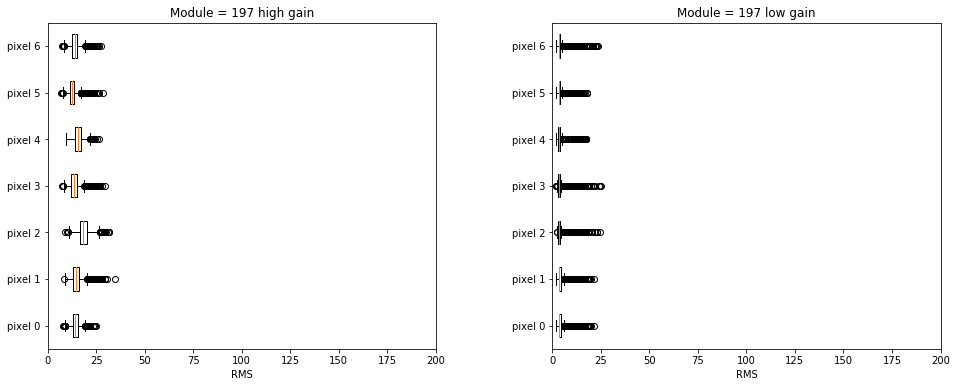

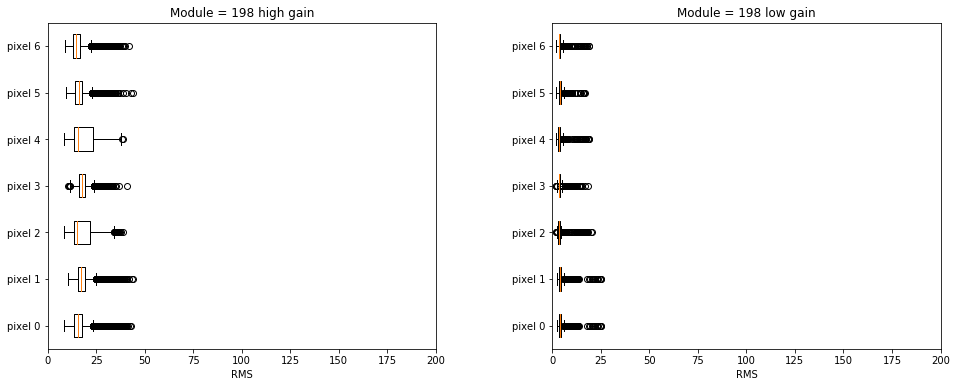

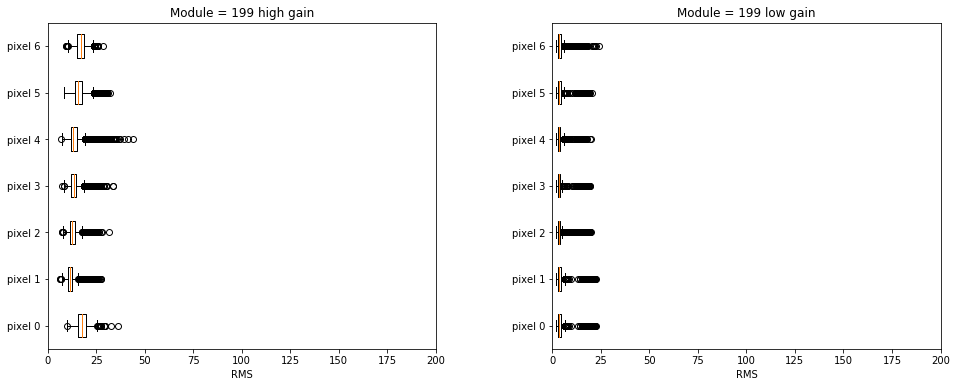

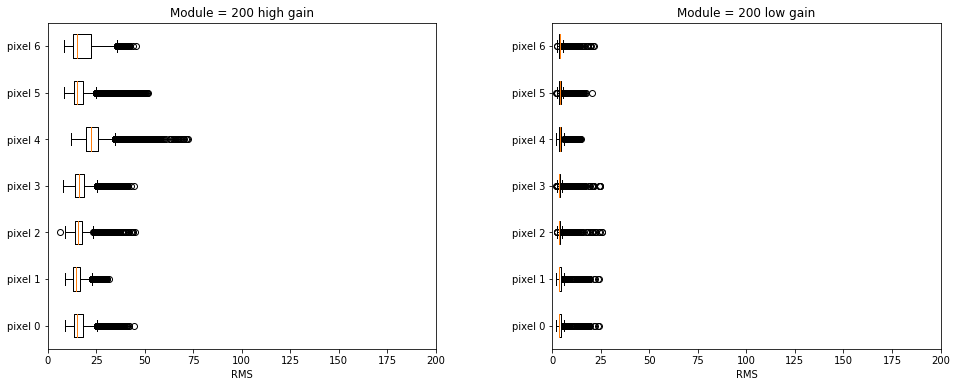

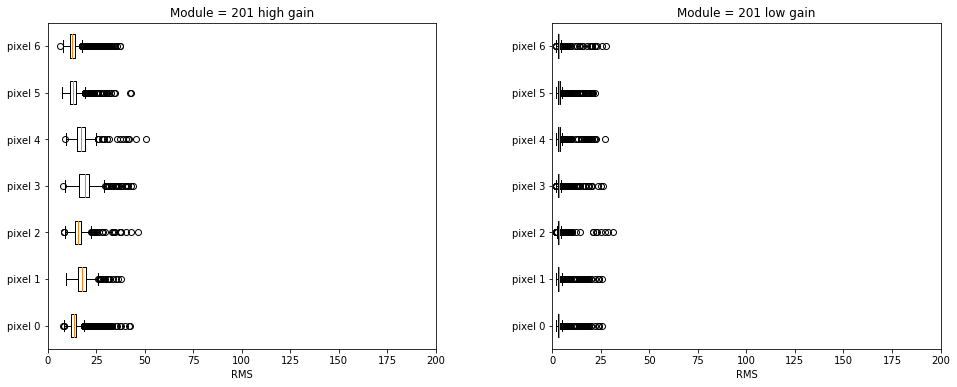

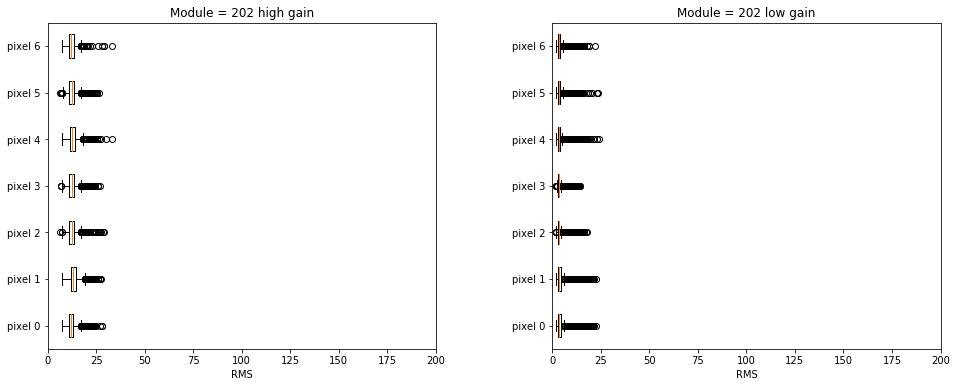

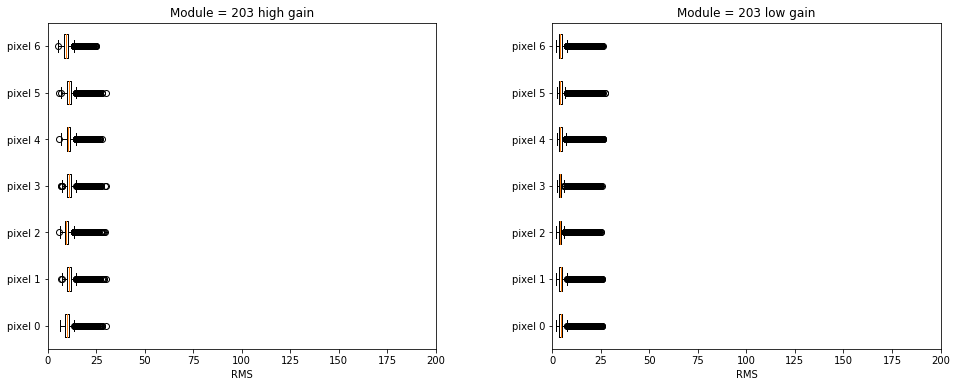

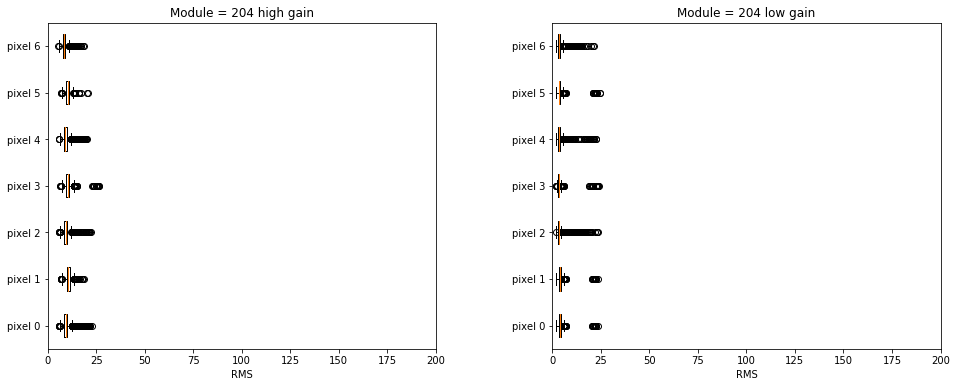

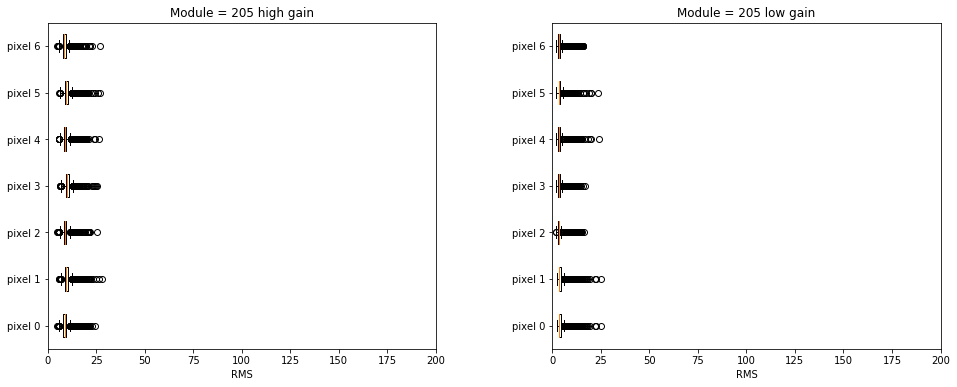

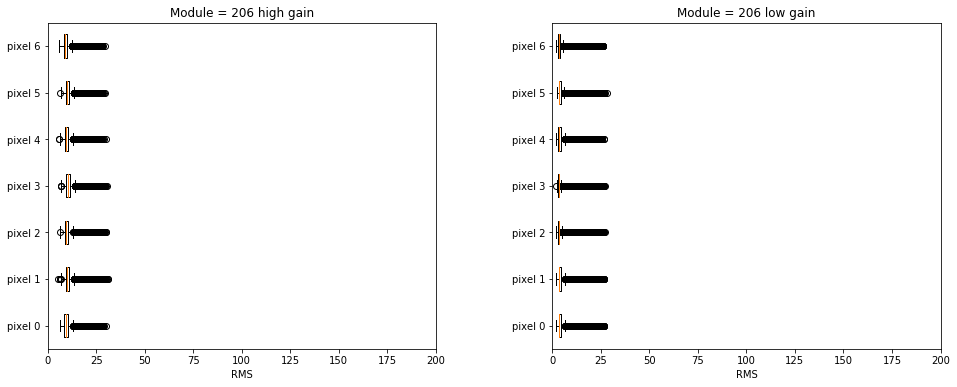

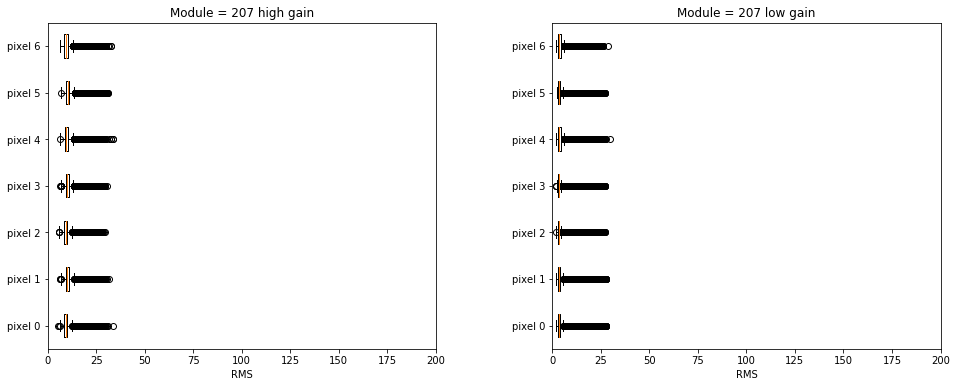

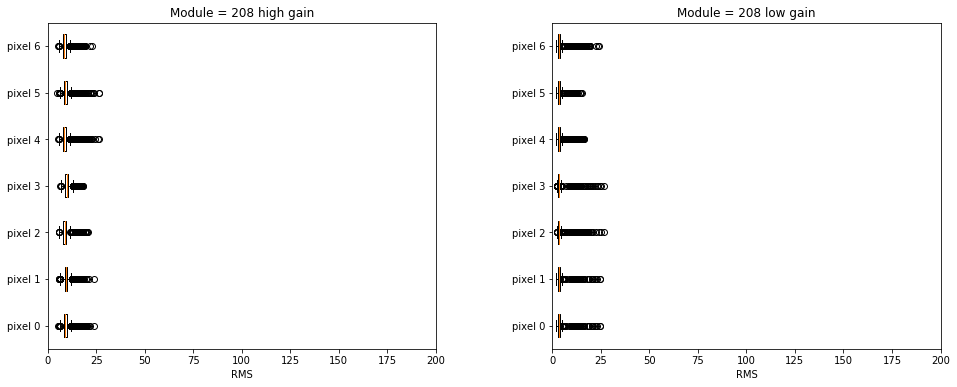

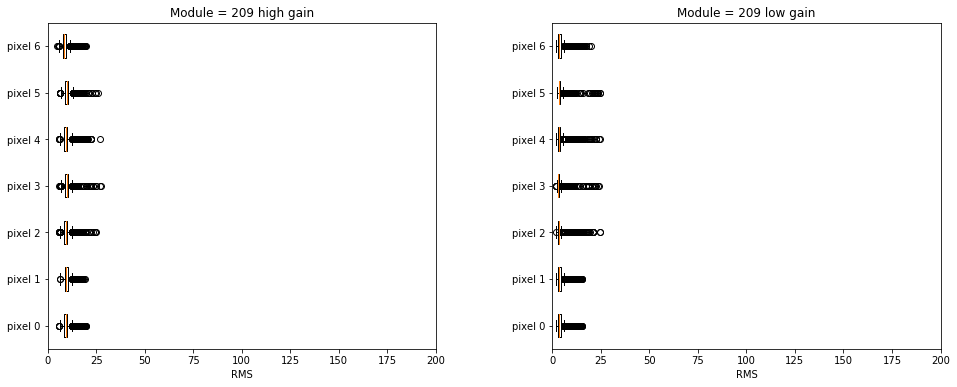

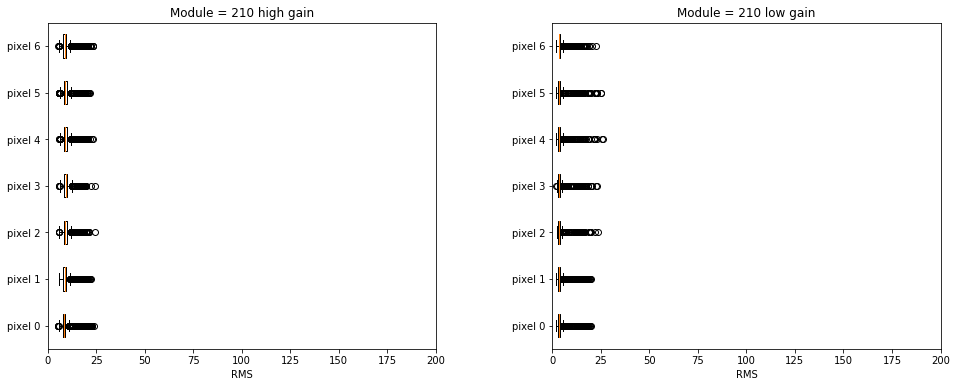

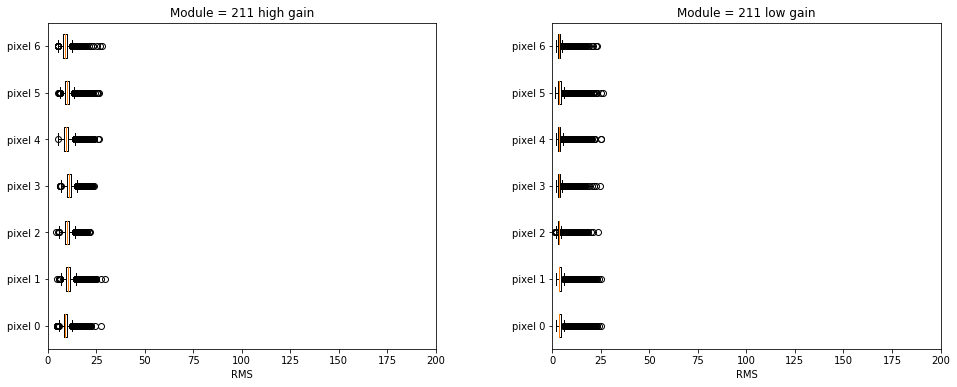

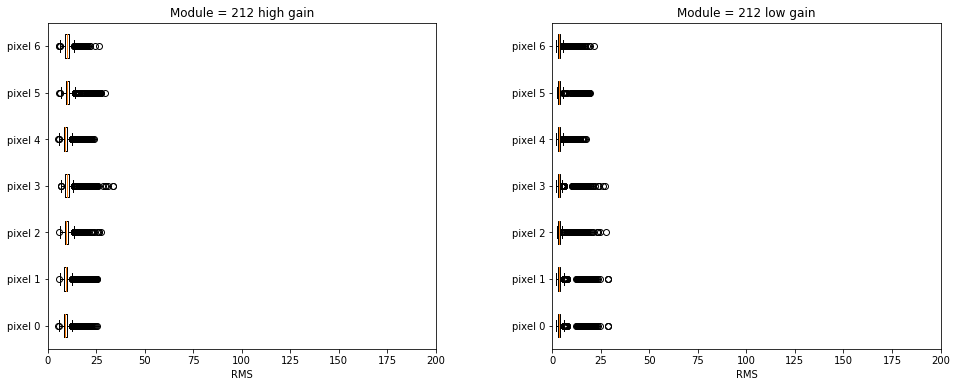

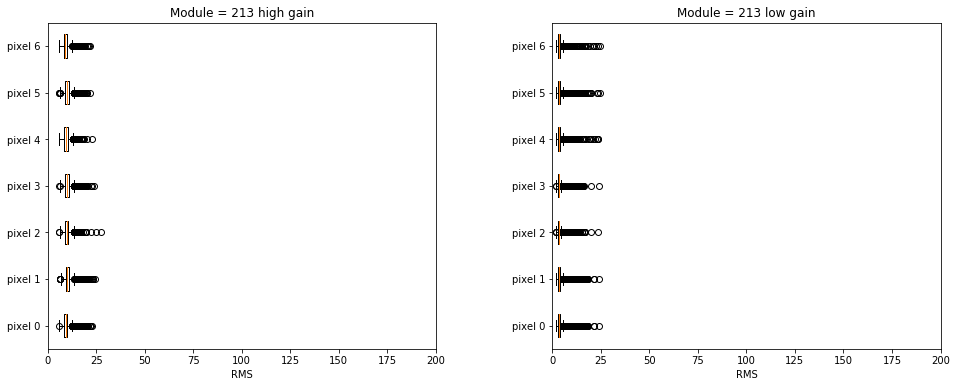

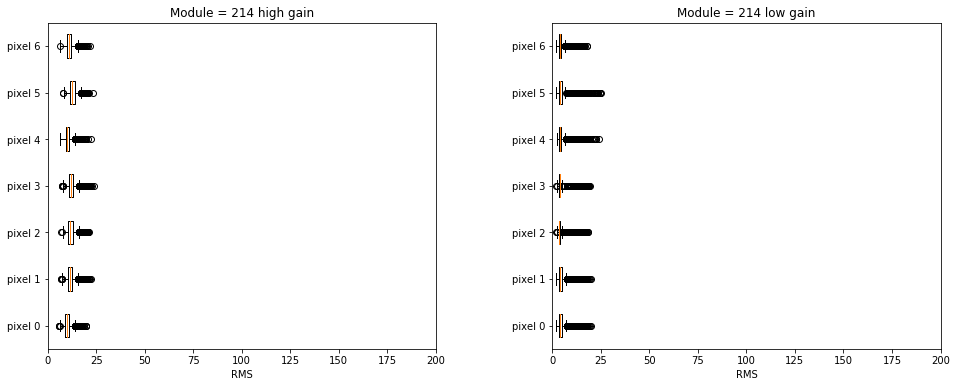

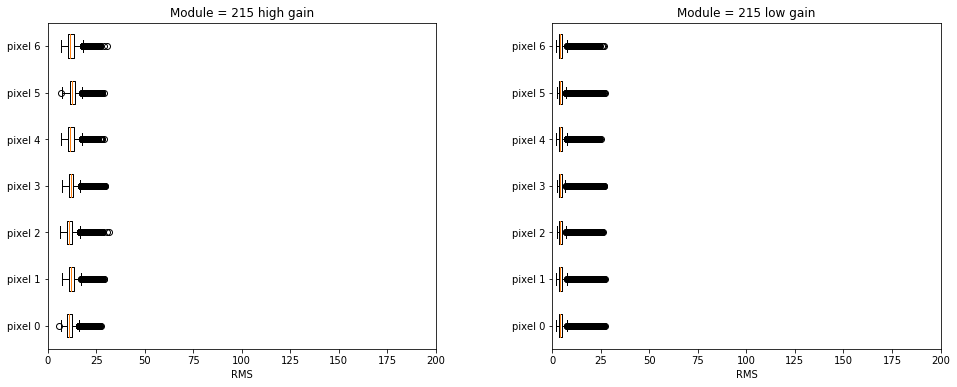

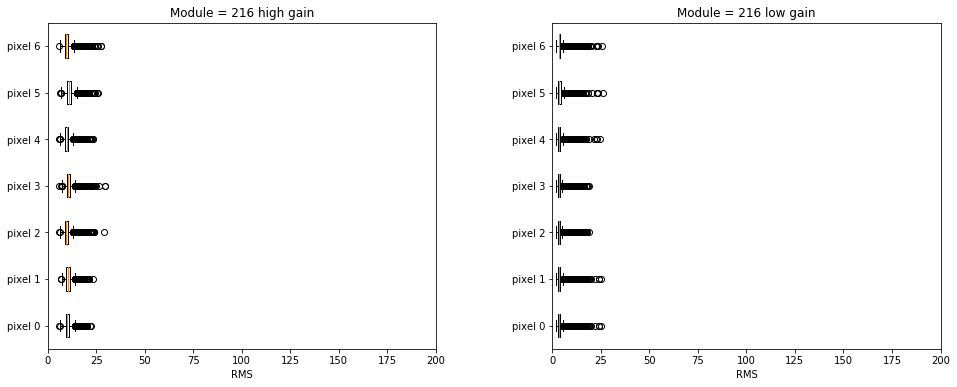

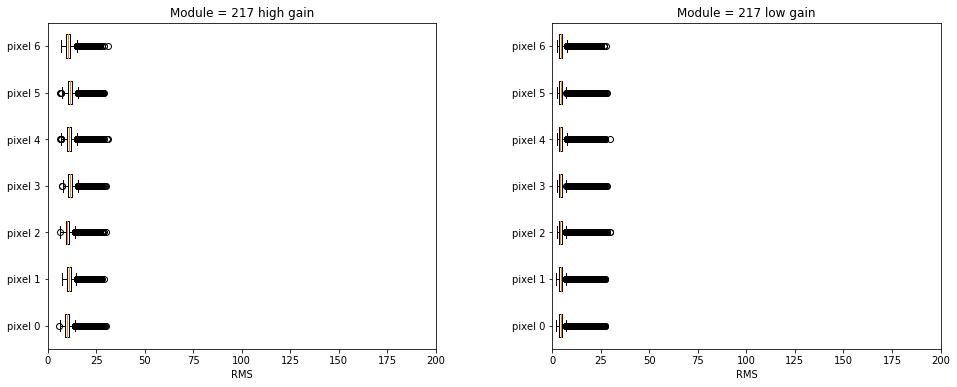

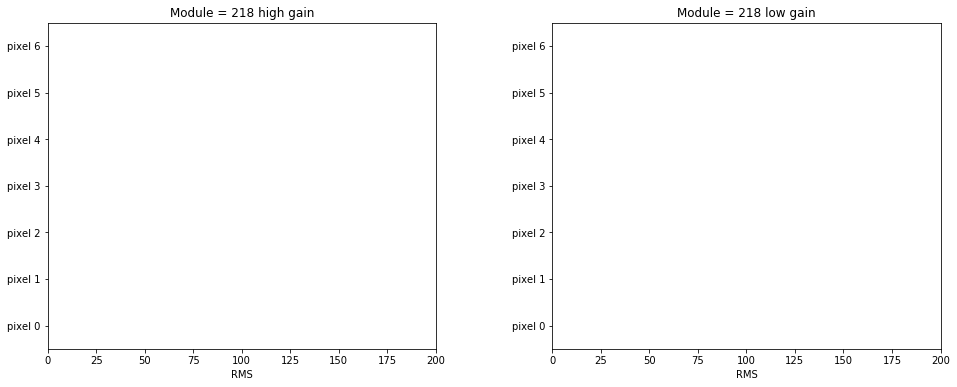

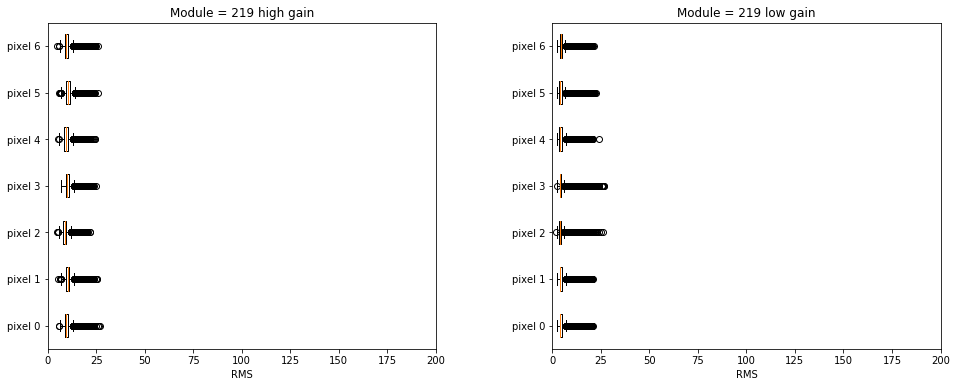

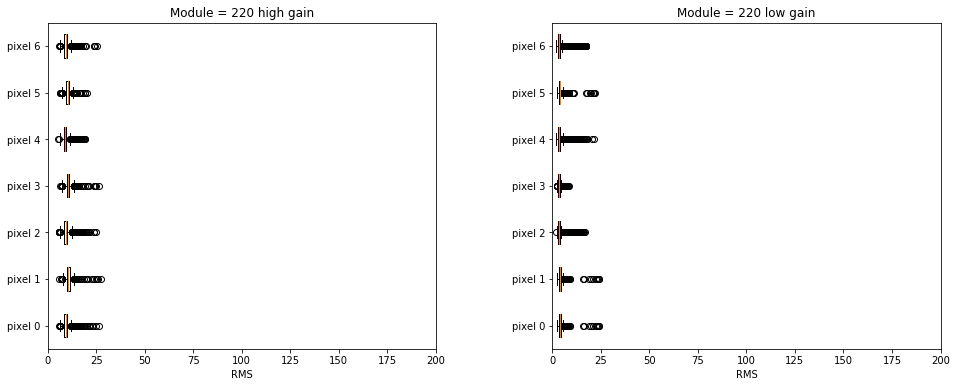

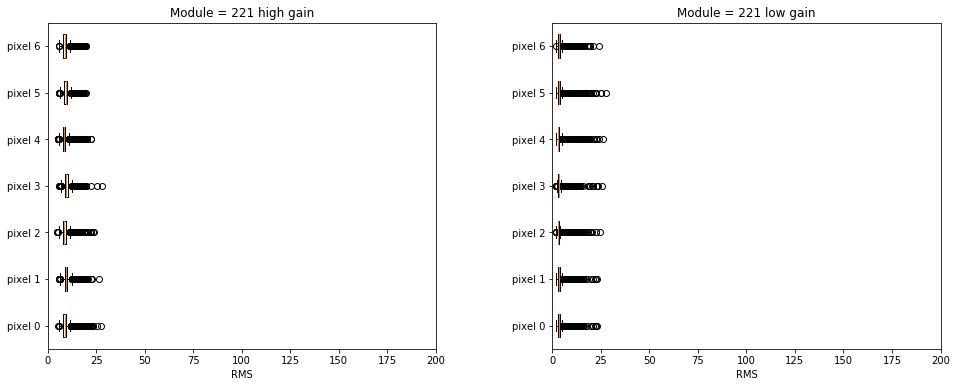

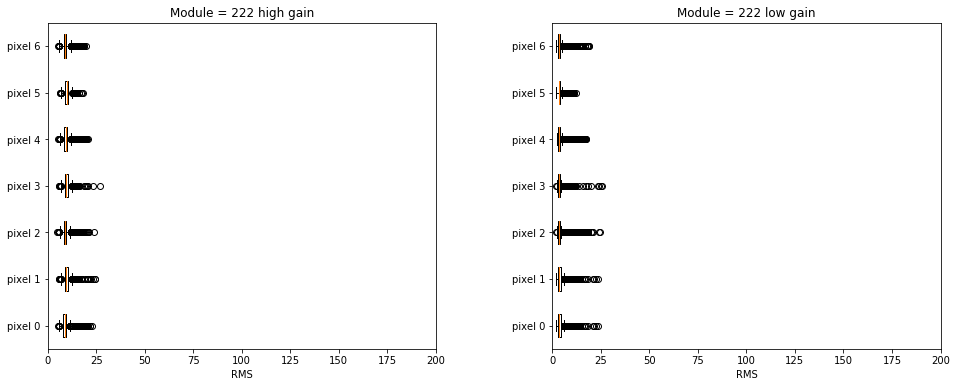

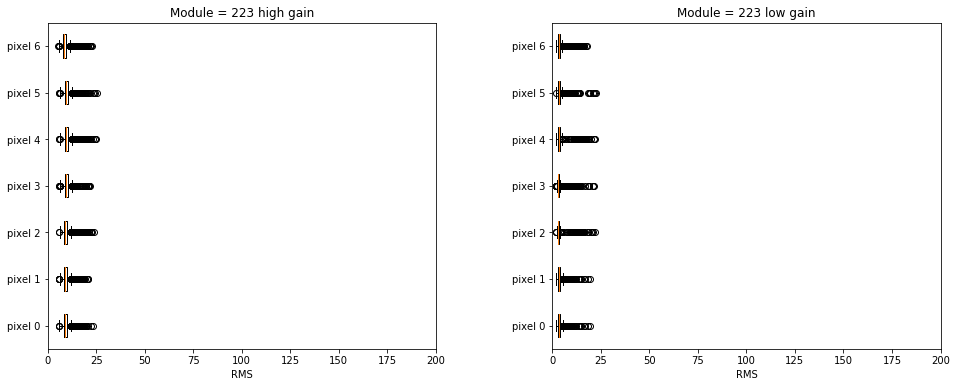

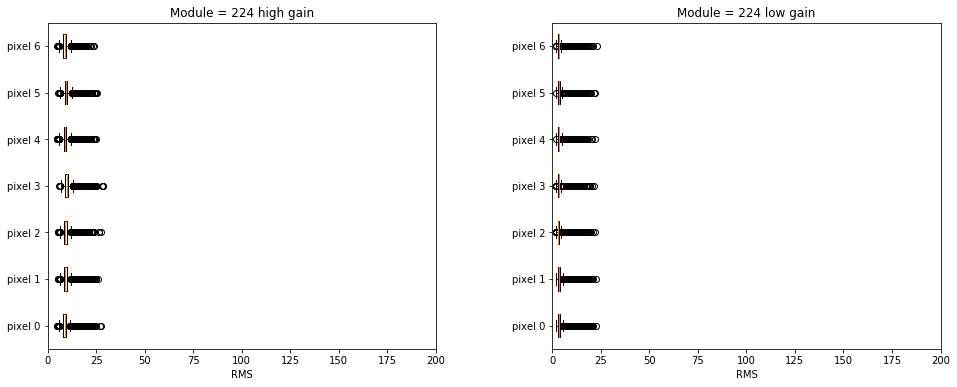

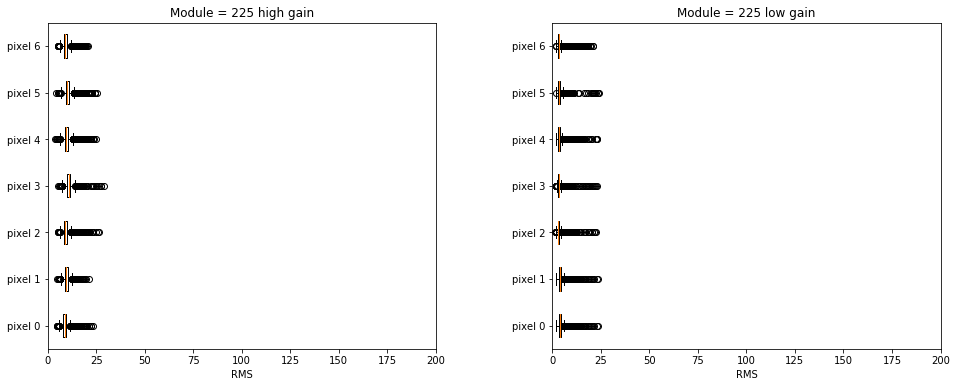

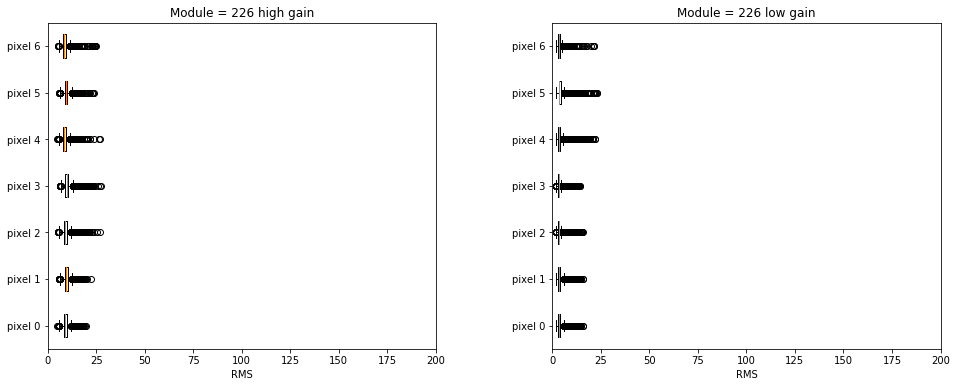

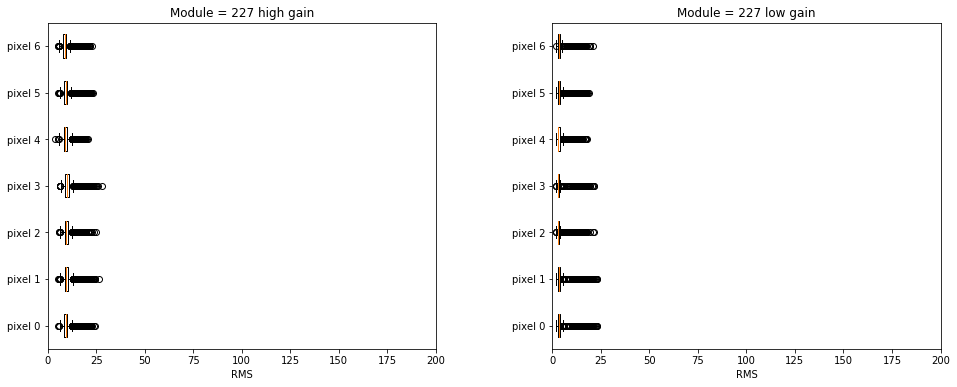

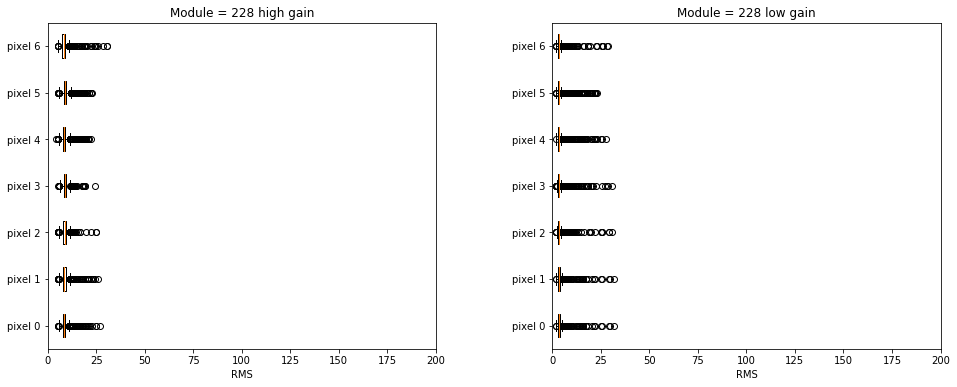

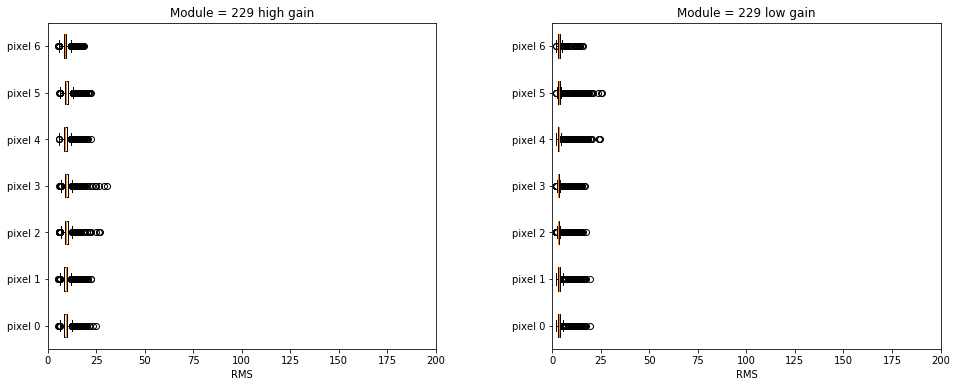

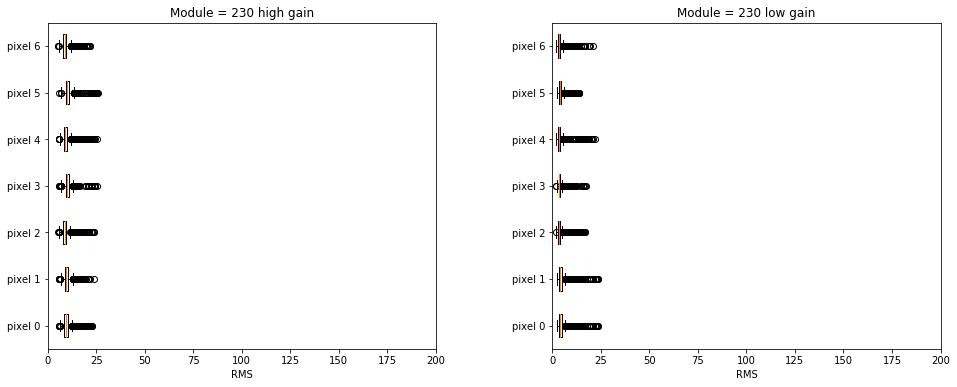

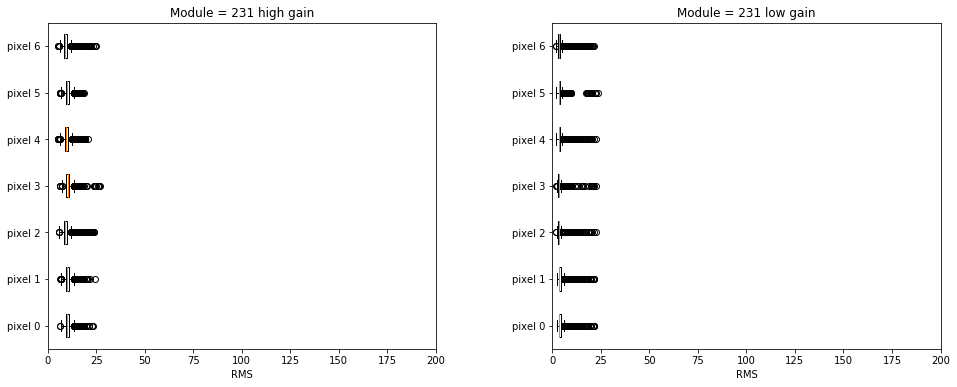

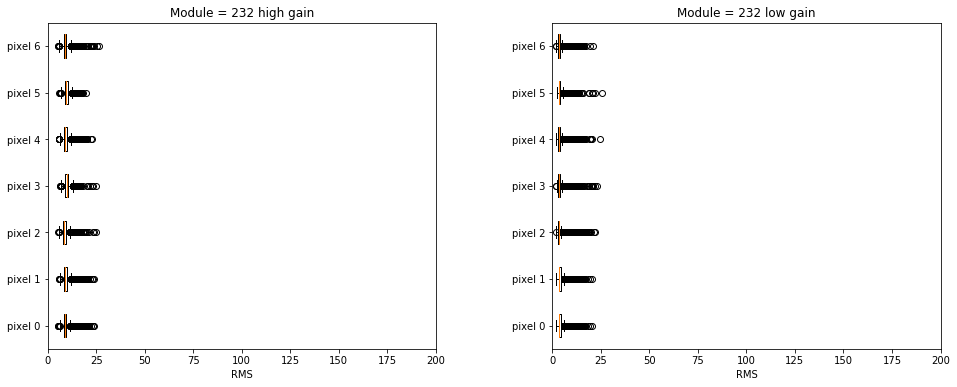

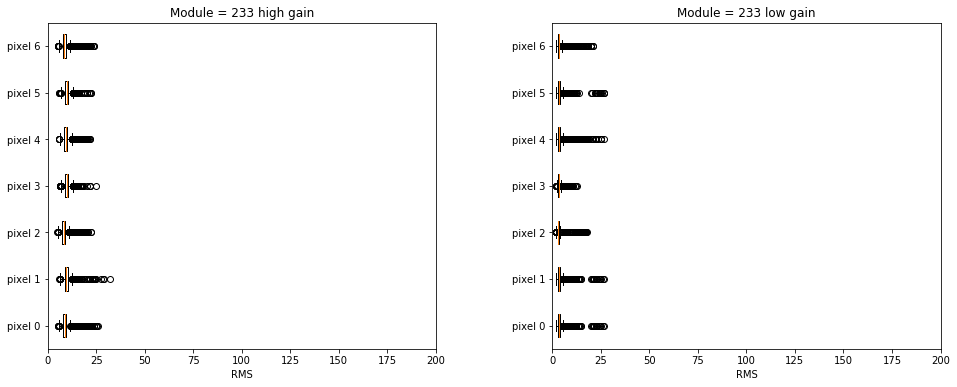

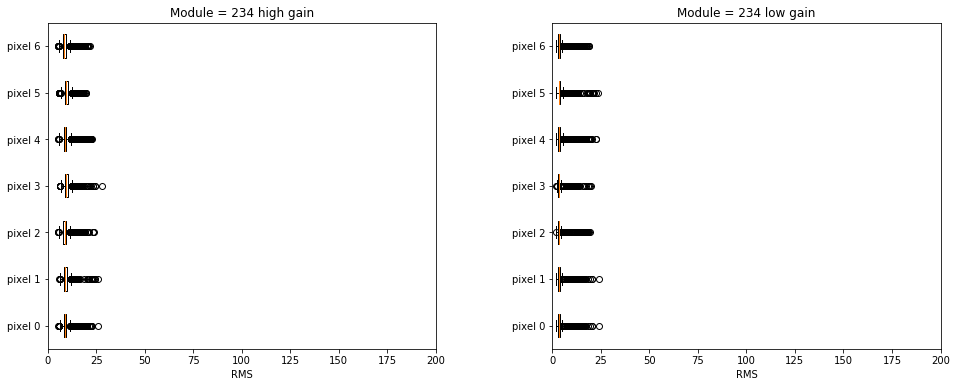

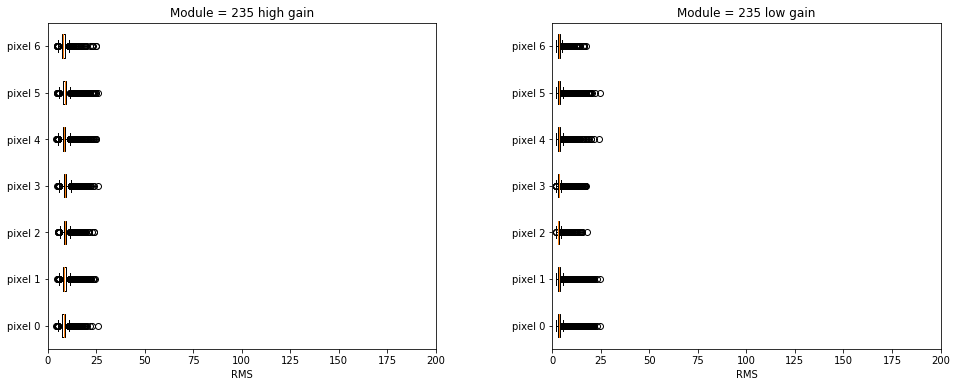

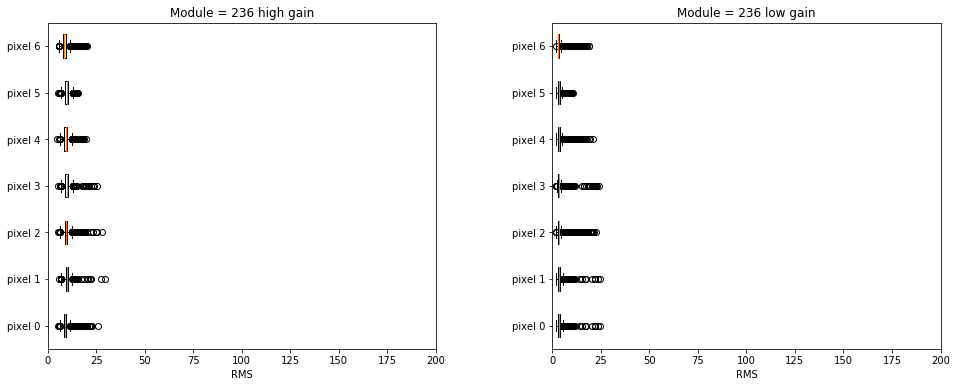

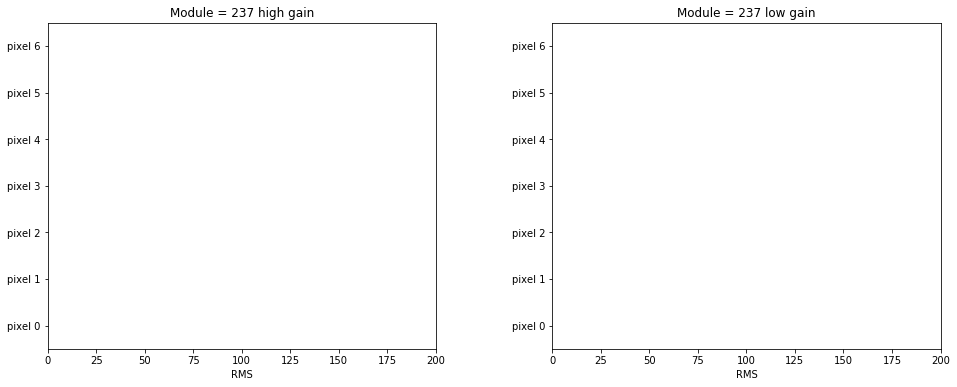

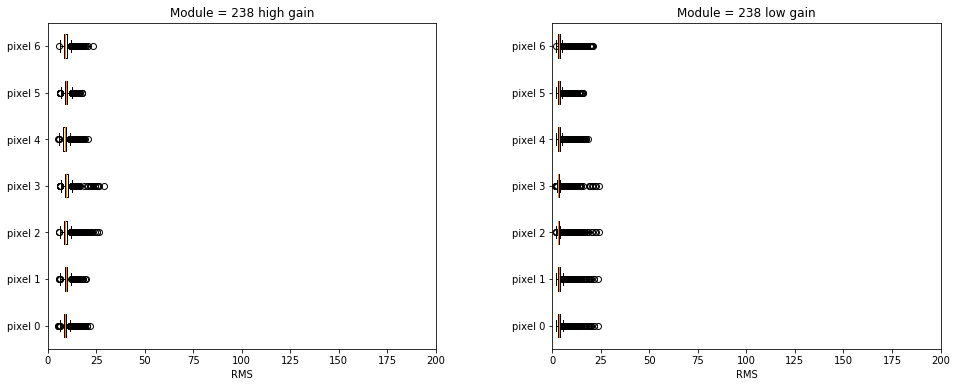

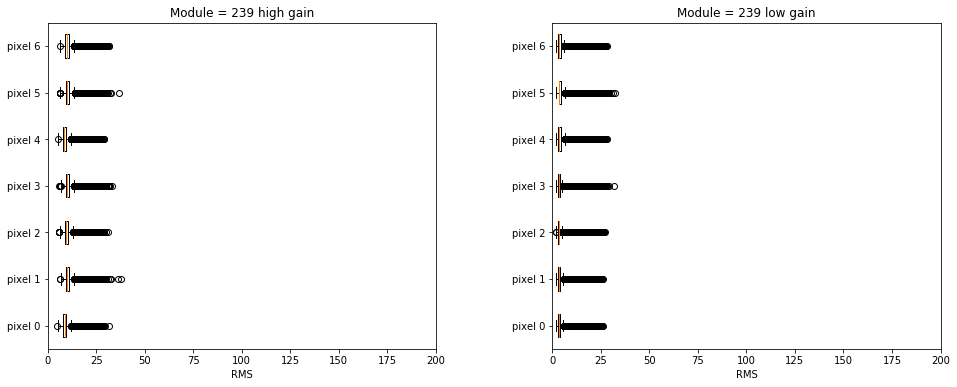

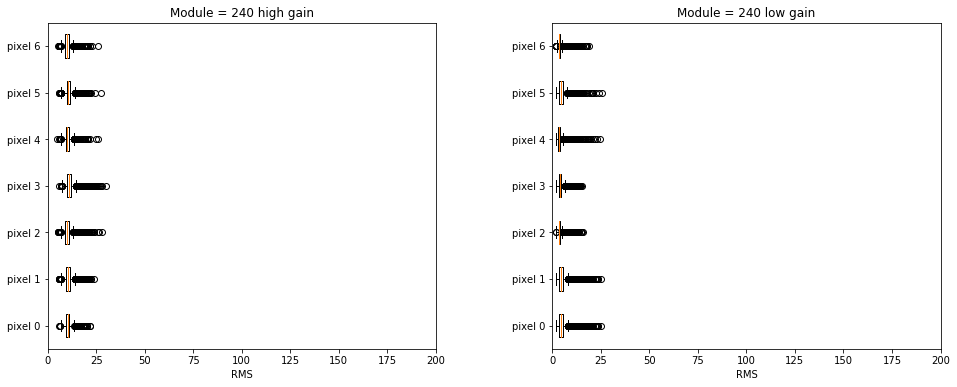

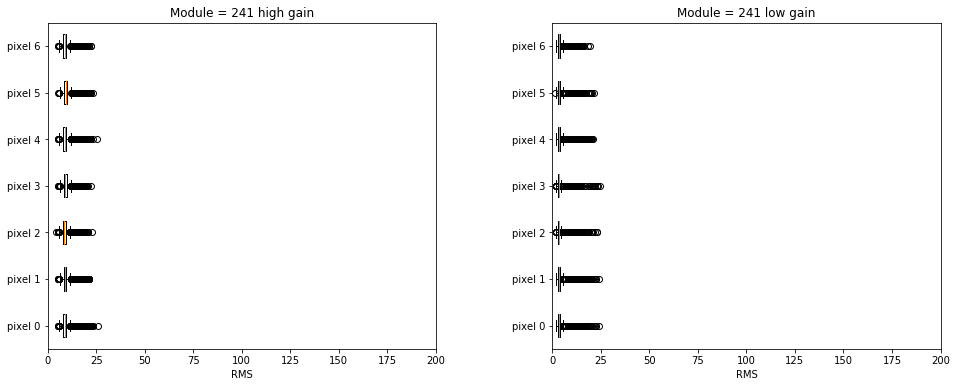

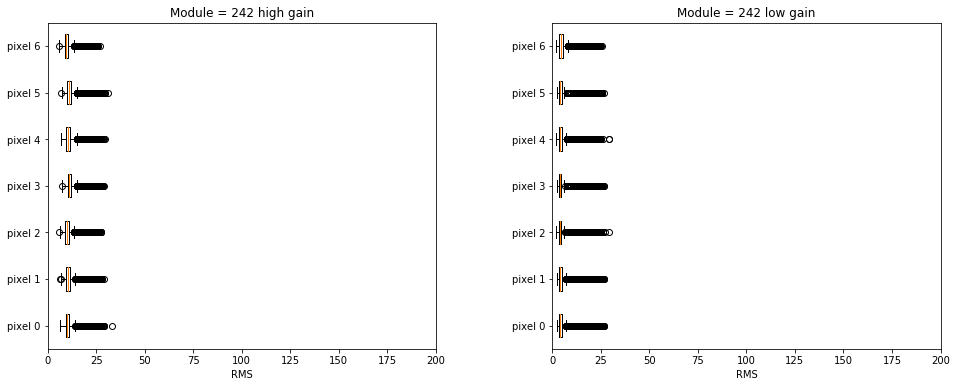

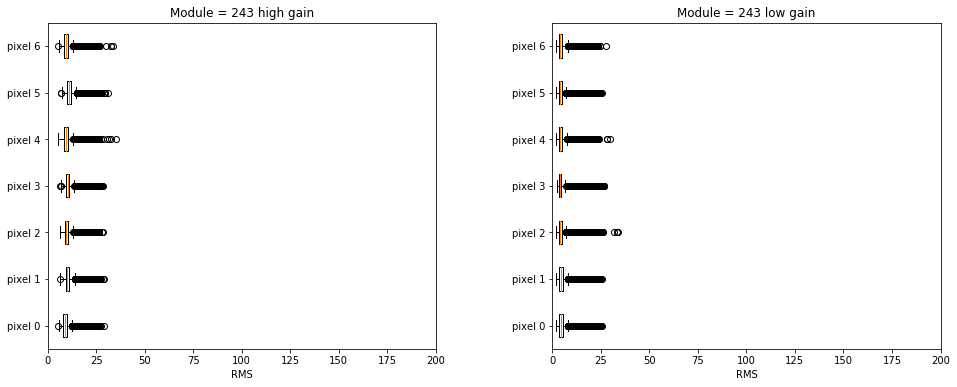

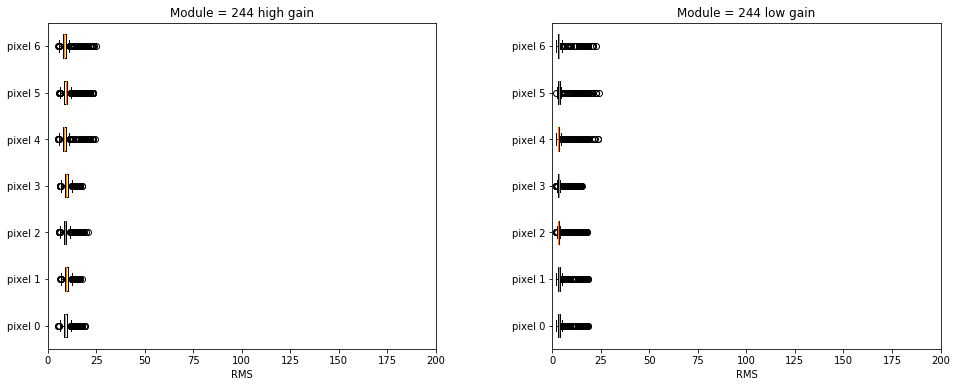

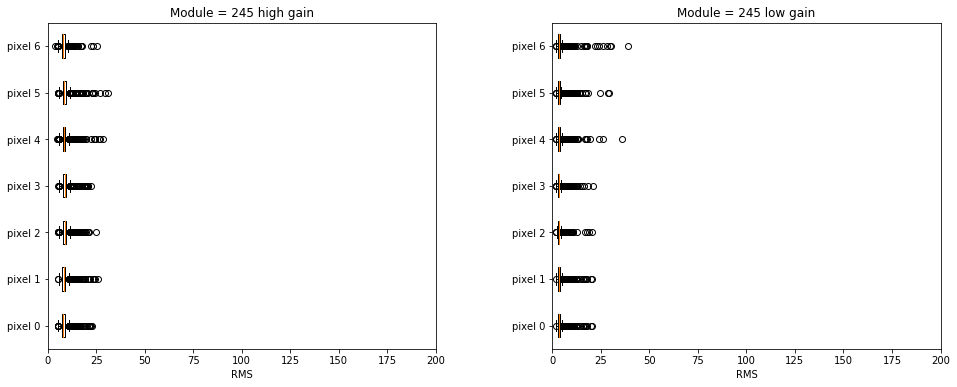

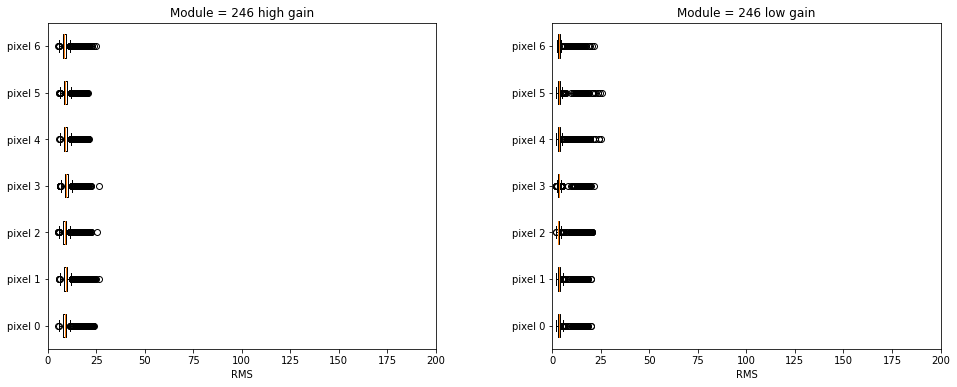

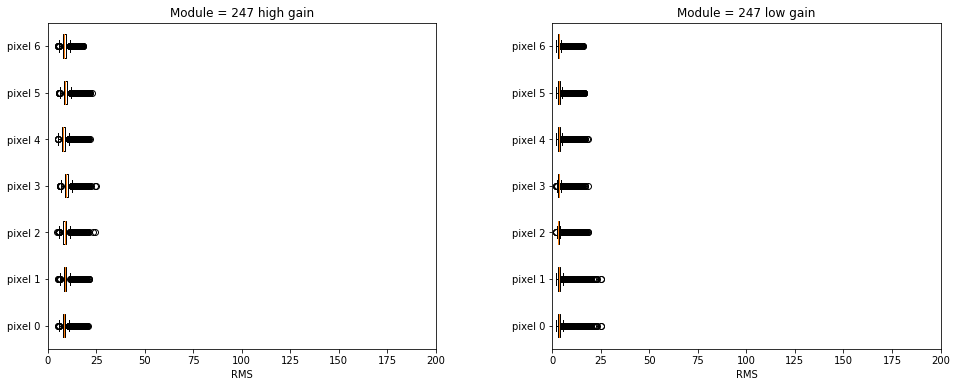

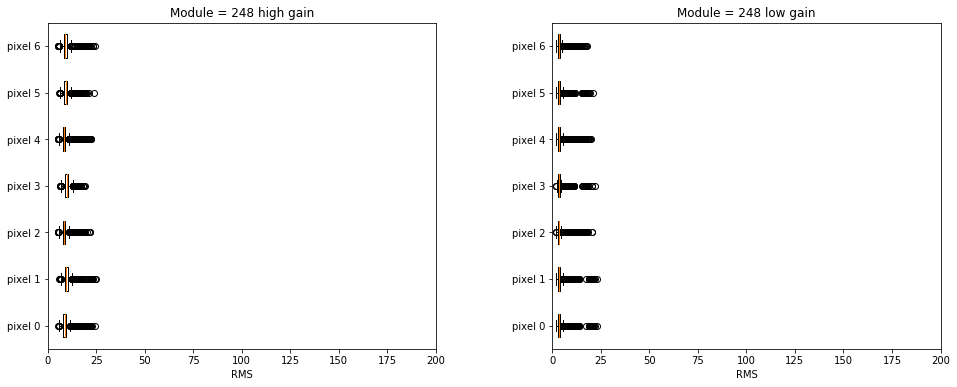

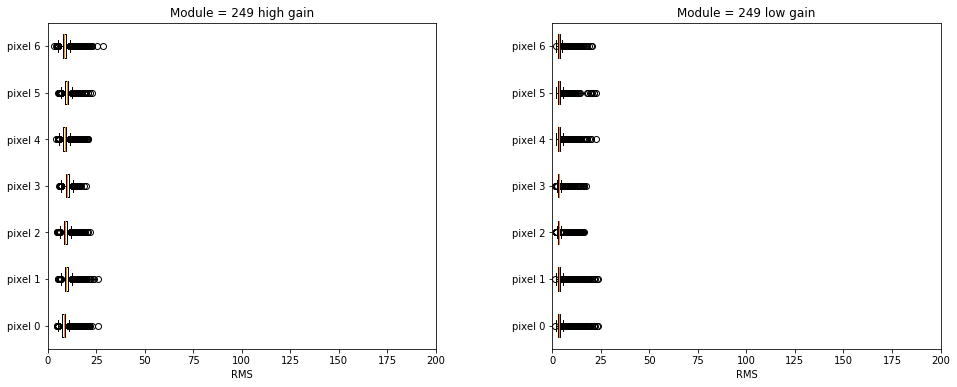

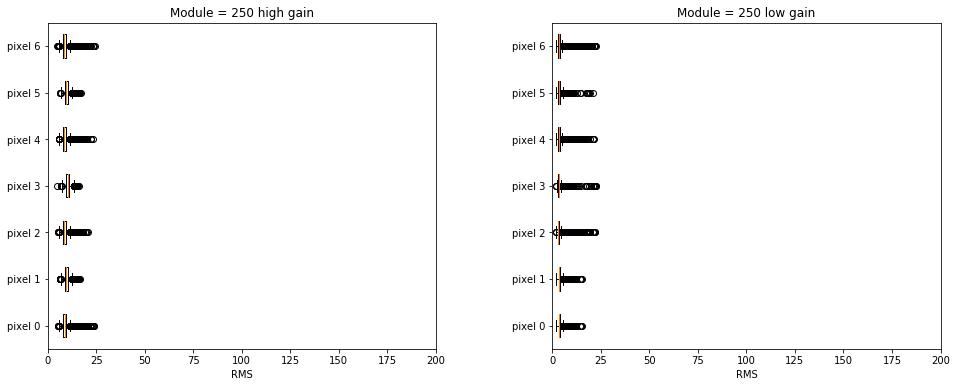

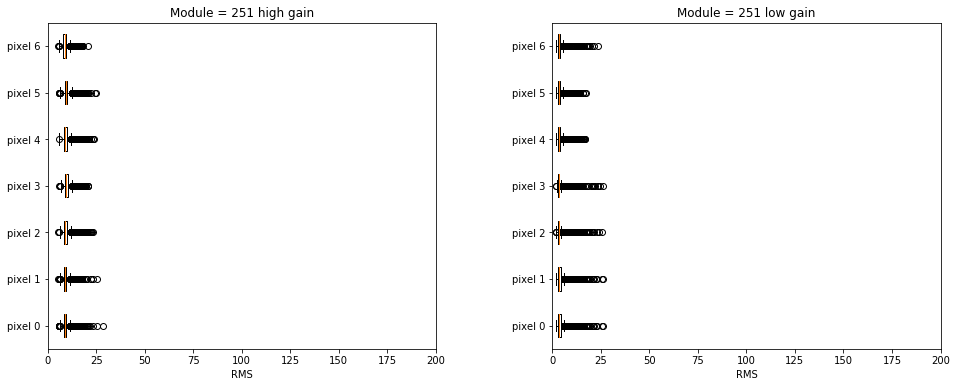

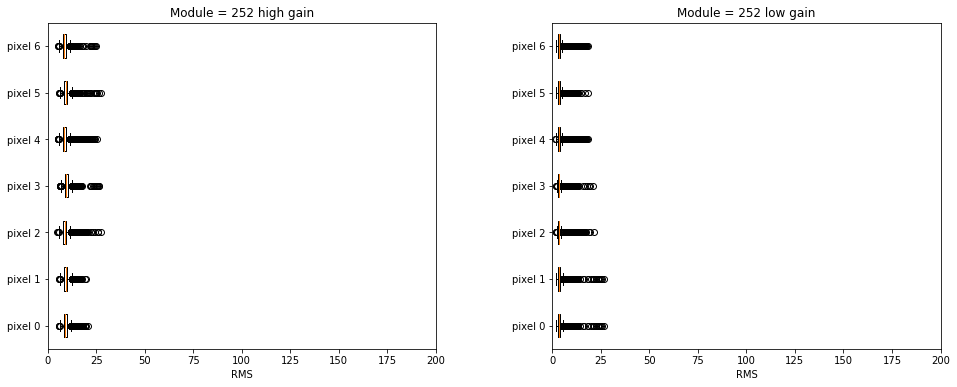

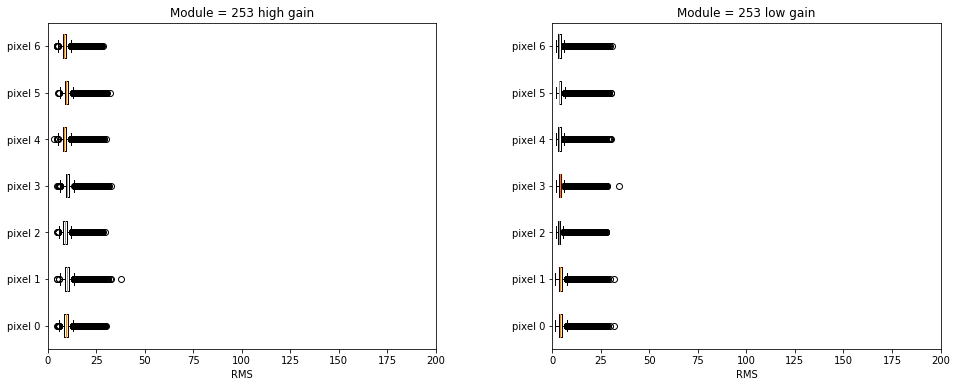

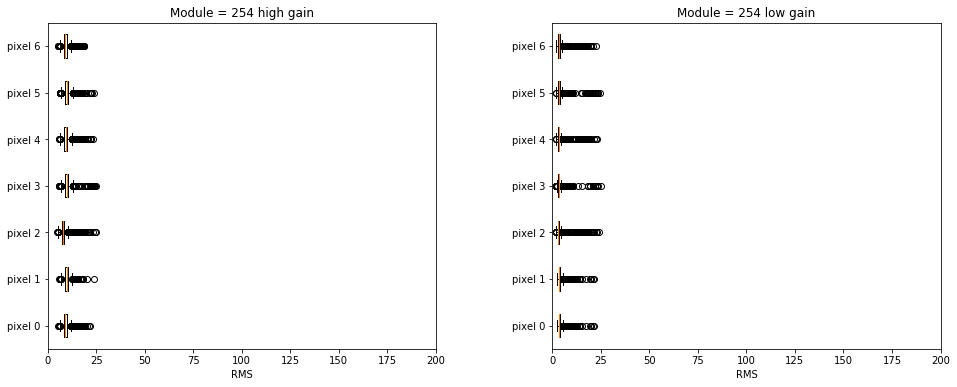

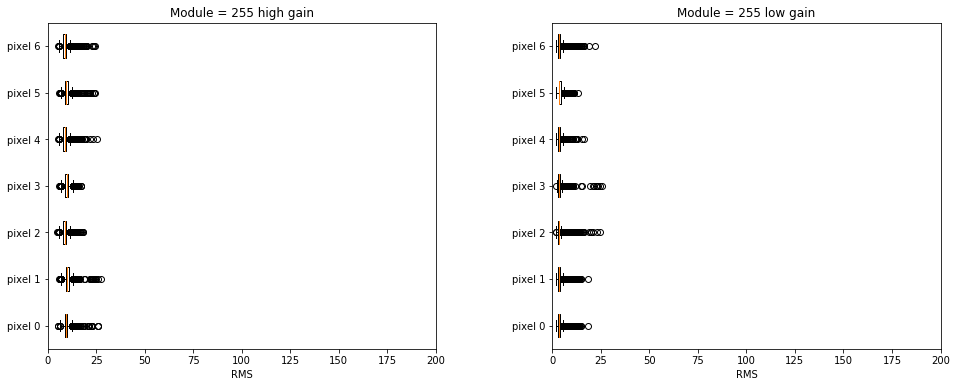

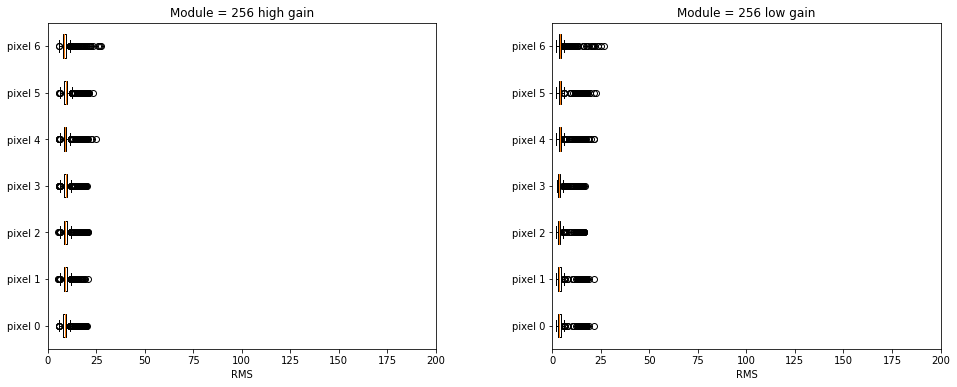

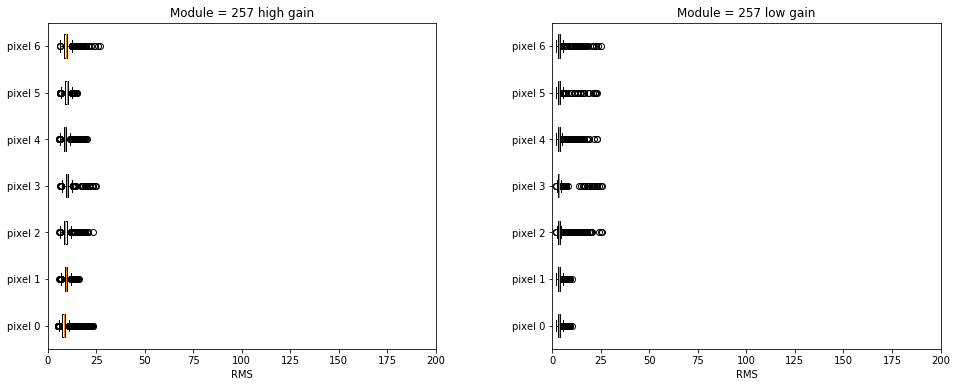

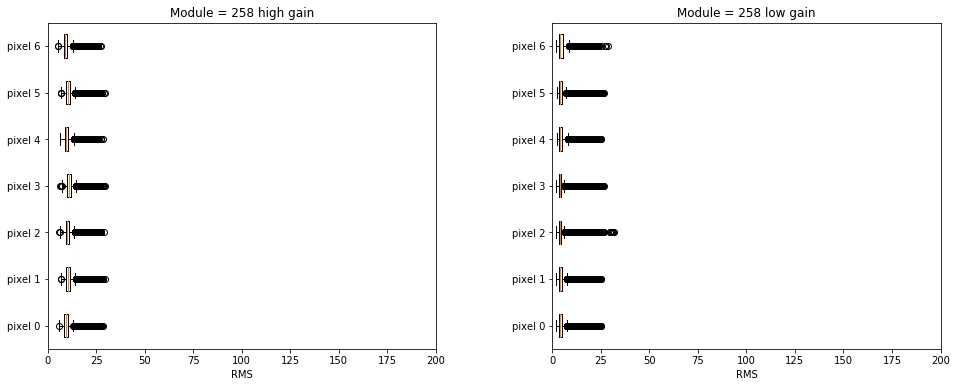

In [8]:
plt.rcParams['figure.figsize'] = (16, 6)
for nr in range(0, NR):  # Here you can chose for which module you want make box plot  
    plot_box(nr, rms_cap_array)

# Historgram of mean RMS of capacitor for all pixels

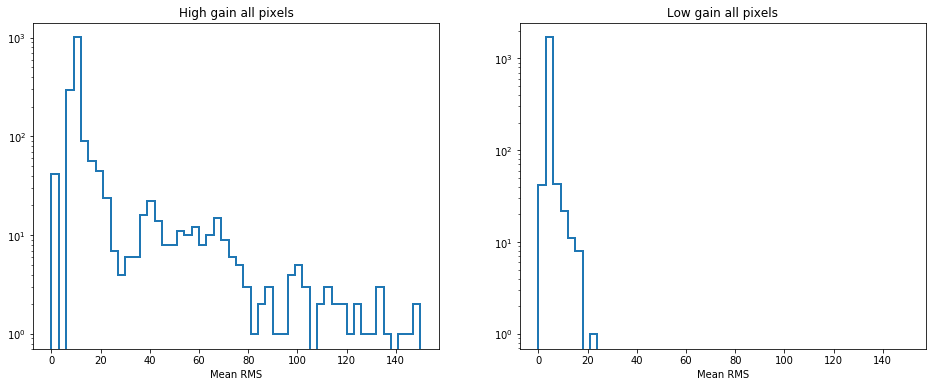

In [9]:

fig, ax0 = plt.subplots(1, 2)
ax0[0].hist(rms_cap_mean_array[:, 0, :].ravel(), bins=50, range=(0, 150), histtype='step', lw=2)
ax0[0].set_xlabel("Mean RMS")
ax0[0].set_ylabel("")
ax0[0].set_yscale('log')
ax0[0].set_title("High gain all pixels")
ax0[1].hist(rms_cap_mean_array[:, 1, :].ravel(), bins=50, range=(0, 150), histtype='step', lw=2)
ax0[1].set_xlabel("Mean RMS")
ax0[1].set_yscale('log')
ax0[1].set_title("Low gain all pixels")
plt.show()

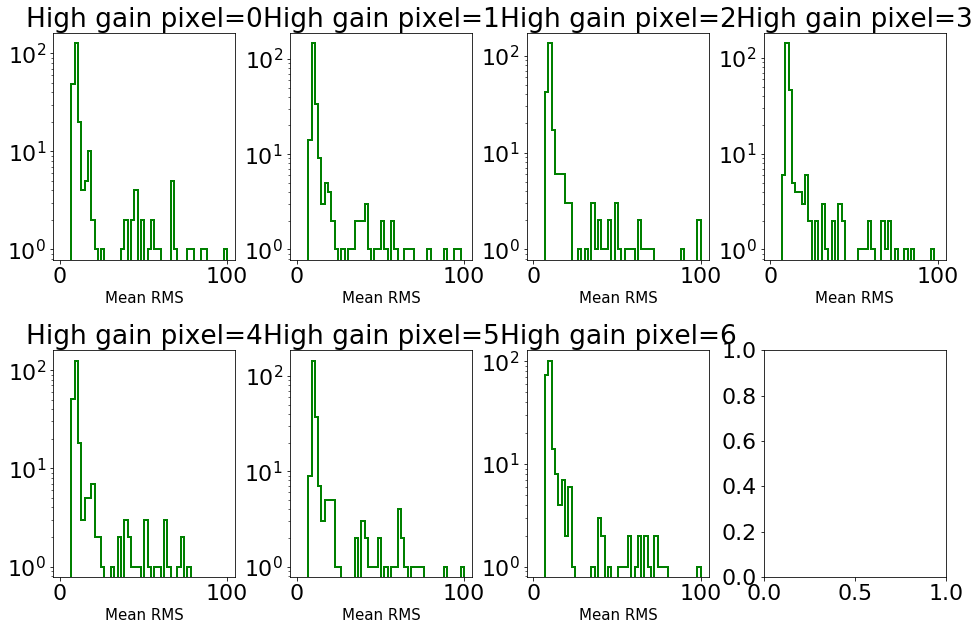

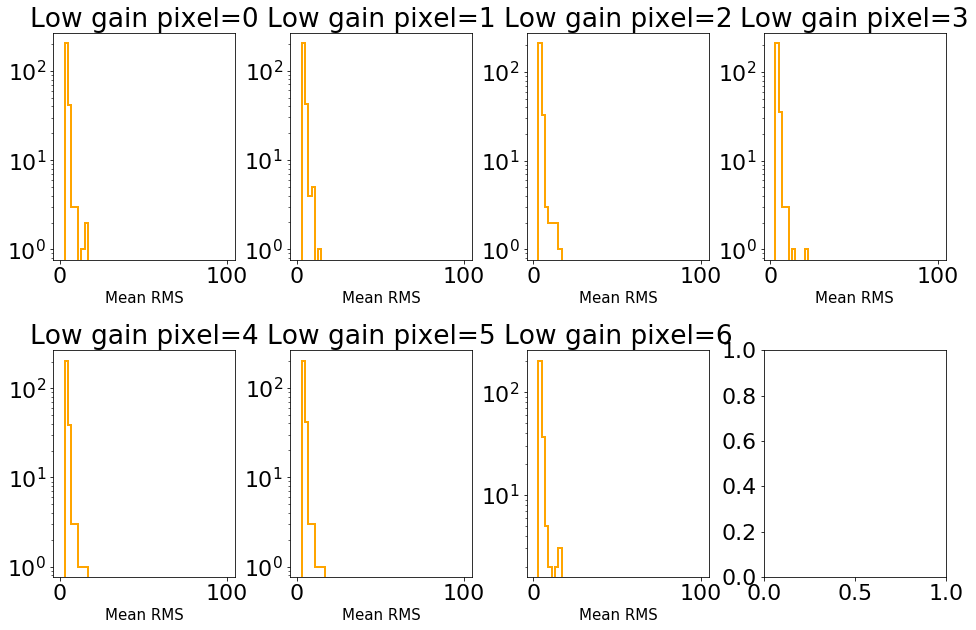

In [10]:
plt.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(2, 4)

for i in [0,1,2,3]:
    ax[0, i].hist(rms_cap_mean_array[:, 0, i].ravel(), bins=50, range=(1, 100), histtype='step', color="green", lw=2)
    ax[0, i].set_yscale('log')
    ax[0, i].set_title("High gain pixel={}".format(i))
    ax[0, i].set_xlabel("Mean RMS", size=15)
for i in [0, 1, 2]:
    ax[1, i].hist(rms_cap_mean_array[:, 0, i+4].ravel(), bins=50, range=(1, 100), histtype='step', color="green", lw=2)
    ax[1, i].set_yscale('log')
    ax[1, i].set_title("High gain pixel={}".format(i+4))
    ax[1, i].set_xlabel("Mean RMS", size=15)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

fig, ax = plt.subplots(2,4)
for i in [0,1,2,3]:
    ax[0, i].hist(rms_cap_mean_array[:, 1, i].ravel(), bins=50, range=(1, 100), histtype='step', color="orange", lw=2)
    ax[0, i].set_yscale('log')
    ax[0, i].set_title("Low gain pixel={}".format(i))
    ax[0, i].set_xlabel("Mean RMS", size=15)
for i in [0, 1, 2]:
    ax[1, i].hist(rms_cap_mean_array[:, 1, i+4].ravel(), bins=50, range=(1, 100), histtype='step', color="orange", lw=2)
    ax[1, i].set_yscale('log')
    ax[1, i].set_title("Low gain pixel={}".format(i+4))
    ax[1, i].set_xlabel("Mean RMS", size=15)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()